# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import albumentations as A
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image
import copy

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Part of "train/0" -> 1600 samples, ~1.3 GB

In [4]:
df_train=pd.read_csv('./train_labels.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/{x[0]}/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/0/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/0/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/0/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/0/0007a5a46901c56.npy
4,0009283e145448e,0,./train/0/0009283e145448e.npy


60000


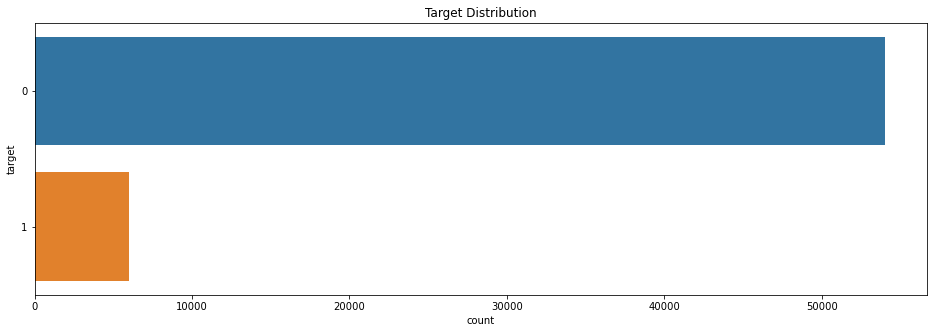

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, transform=None, augment=False): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)
        
        targets = self.targets[item]
        
        if self.augment:
            image = np.vstack(image).transpose((1, 0))
            
            img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
            image = np.array(img_pl)
            
            if self.transform is not None:
                image = self.transform(image=image)['image']
                
        return {
            "image": torch.tensor(image, dtype=torch.float) if not self.augment else torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.conv1Norm(x)
            x = self.poolNorm(x)
            x = self.conv2Norm(x)
        else:
            x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    running_loss = 0
    loss_sum = 0
    i = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        i += 1
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        running_loss += loss.item()
        if i % 100 == 99: # print every 2000 minibatches
            print('[%5d] loss: %.3f' %
                  (i + 1, running_loss / 2000))
            running_loss = 0.0
        
    return loss_sum
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1)).item()
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [10]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3', 'efficientnet-b5'] # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Pretrained Checkpoints
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth',
    baseline_name[2]: './checkpoint/efficientnet-b5-586e6cc6.pth'
}
models = []
device = "cuda"
Batch_Size = 8
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

starter_models = [enetv2(baseline_name[0], pretrained=True, out_dim=1),
                          enetv2(baseline_name[1], pretrained=True, out_dim=1),
                          enetv2(baseline_name[2], pretrained=True, out_dim=1)]

names = ['efficientnet-b1-pretrained', 'efficientnet-b3-augment', 'efficintnet-b5-augment']

epochs = 10
#epochs = [[0 for i in range(5)] for i in names]
train_losses = [[[] for i in range(5)] for i in names]
valid_losses = [[[] for i in range(5)] for i in names]
aurocs = [[[] for i in range(5)] for i in names]

it = 0
train_losses

[[[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []],
 [[], [], [], [], [], [], [], [], [], []]]

In [11]:
#create log file
codecs.open('log2.log', 'w+');

In [12]:
for model in starter_models:
    fold = 0
    for train_index, test_index in skf.split(X, Y):
        #train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y, random_state=2021)
        #model = enetv2(baseline_name, out_dim=1)
        
        train_transform = A.Compose([
                        A.VerticalFlip(p=0.5),
                        A.Cutout(max_h_size=int(512 * 0.1), max_w_size=int(512 * 0.1), num_holes=5, p=0.5),
                        ])
        
        starter_models = [enetv2(baseline_name[0], pretrained=True, out_dim=1),
                          enetv2(baseline_name[1], pretrained=True, out_dim=1),
                          enetv2(baseline_name[2], pretrained=True, out_dim=1)]
        
        model = starter_models[it]
        model.to(device)

        train_images, valid_images = X[train_index], X[test_index]
        train_targets, valid_targets = Y[train_index], Y[test_index]

        train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, transform=train_transform, augment=True)
        valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, transform=None, augment=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        row = 0
        last_loss = 0
        train_loss = 10
        
        best_roc_auc = 0
        
        for epoch in range(epochs):
            if epoch == 6:
                for param_group in optimizer.param_groups:
                    param_group["lr"] = 1e-4
            #if epoch == 4:
            #    for param_group in optimizer.param_groups:
            #        param_group["lr"] = 1e-6
                    
            train_loss = train(train_loader, model, optimizer, device=device)
            predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
            roc_auc = metrics.roc_auc_score(valid_targets, predictions)
            
            train_losses[it][fold].append(train_loss) 
            valid_losses[it][fold].append(valid_loss)
            aurocs[it][fold].append(roc_auc)
            
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc

            print(f"Fold {fold}: Epoch={epoch}, Train Loss={train_loss}, Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}")
            with codecs.open('log2.log', 'a') as up:
                up.write(f"Model={it}, Fold={fold}, Epoch={epoch}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

            if roc_auc > best_roc_auc:        
                torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')
                best_roc_auc = roc_auc

        #torch.save(model.state_dict(), names[it] + '-' + str(it) + '.pt')
        models.append(model)
        fold += 1
    it += 1
    
print('finished')
it = 0

/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
Training:   2%|▌                             | 100/6000 [00:13<11:02,  8.90it/s]

[  100] loss: 0.020


Training:   3%|█                             | 200/6000 [00:25<11:03,  8.74it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:36<10:49,  8.78it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [00:47<10:41,  8.73it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [00:59<10:52,  8.43it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:10<11:08,  8.08it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [01:21<09:41,  9.11it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:33<09:10,  9.45it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:44<09:37,  8.83it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [01:55<09:16,  8.98it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [02:07<09:41,  8.43it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:18<09:07,  8.77it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [02:29<08:49,  8.87it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [02:41<08:16,  9.27it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [02:52<08:26,  8.89it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:03<08:38,  8.49it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:15<08:14,  8.70it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:26<07:22,  9.49it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [03:37<08:36,  7.94it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [03:49<07:27,  8.94it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:01<07:36,  8.55it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:12<07:24,  8.55it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [04:24<06:49,  9.04it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [04:35<06:43,  8.93it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2499/6000 [04:46<07:05,  8.23it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [04:57<06:12,  9.12it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:09<06:04,  9.05it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:20<05:19, 10.01it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [05:31<05:33,  9.31it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [05:42<05:12,  9.61it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [05:53<05:15,  9.20it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:04<05:11,  8.99it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [06:15<05:17,  8.52it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [06:26<04:32,  9.55it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [06:38<04:38,  8.96it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:25,  9.05it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:16,  8.98it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:07,  8.90it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [07:22<03:51,  9.08it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [07:33<03:56,  8.47it/s]

[ 4000] loss: 0.019


Training:  68%|███████████████████▊         | 4100/6000 [07:44<03:39,  8.64it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [07:55<03:05,  9.69it/s]

[ 4200] loss: 0.019


Training:  72%|████████████████████▊        | 4300/6000 [08:06<03:09,  8.96it/s]

[ 4300] loss: 0.019


Training:  73%|█████████████████████▎       | 4400/6000 [08:17<03:00,  8.86it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [08:28<02:47,  8.98it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [08:40<02:45,  8.46it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [08:51<02:31,  8.59it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [09:03<02:23,  8.38it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [09:15<02:05,  8.76it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [09:26<01:53,  8.80it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [09:37<01:35,  9.41it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [09:49<01:33,  8.52it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [10:00<01:21,  8.63it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [10:12<01:10,  8.51it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [10:23<00:59,  8.44it/s]

[ 5500] loss: 0.019


Training:  93%|███████████████████████████  | 5600/6000 [10:35<00:46,  8.67it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [10:47<00:34,  8.63it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [10:58<00:22,  8.74it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [11:09<00:12,  8.06it/s]

[ 5900] loss: 0.014


Training: 100%|█████████████████████████████| 6000/6000 [11:21<00:00,  8.80it/s]


[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:05<00:00, 23.04it/s]


Fold 0: Epoch=0, Train Loss=1992.5075118280947, Validation Loss=575.1981797032058, Validation ROC AUC=0.49895185185185187


Training:   2%|▌                             | 100/6000 [00:11<10:40,  9.21it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:22<10:24,  9.28it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:34<10:02,  9.47it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:45<10:09,  9.18it/s]

[  400] loss: 0.019


Training:   8%|██▌                           | 500/6000 [00:56<09:51,  9.29it/s]

[  500] loss: 0.014


Training:  10%|███                           | 600/6000 [01:07<10:16,  8.75it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:18<09:55,  8.91it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:30<10:26,  8.30it/s]

[  800] loss: 0.013


Training:  15%|████▌                         | 900/6000 [01:42<10:14,  8.30it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [01:53<09:27,  8.81it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:04<09:16,  8.80it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:16<08:49,  9.07it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:27<08:09,  9.60it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:38<08:54,  8.61it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [02:49<08:32,  8.79it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:00<08:31,  8.61it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:11<07:53,  9.08it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:22<07:54,  8.84it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [03:33<07:49,  8.73it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [03:44<06:55,  9.63it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [03:55<07:16,  8.94it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:07<07:15,  8.72it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:18<06:47,  9.07it/s]

[ 2300] loss: 0.014


Training:  40%|███████████▌                 | 2401/6000 [04:29<06:26,  9.31it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2501/6000 [04:40<06:10,  9.45it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [04:52<06:38,  8.53it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [05:03<06:15,  8.78it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:14<05:58,  8.92it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2901/6000 [05:25<05:25,  9.53it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [05:36<05:32,  9.03it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3099/6000 [05:47<04:45, 10.17it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [05:58<04:58,  9.39it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [06:09<04:51,  9.26it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [06:21<05:11,  8.34it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [06:32<04:53,  8.52it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:54,  8.15it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [06:56<04:05,  9.36it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [07:07<04:01,  9.12it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [07:18<04:06,  8.54it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [07:29<03:50,  8.69it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [07:41<03:32,  8.96it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [07:52<03:21,  8.95it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [08:03<03:21,  8.44it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [08:15<03:05,  8.64it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [08:26<02:50,  8.80it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [08:37<02:37,  8.91it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4699/6000 [08:48<02:23,  9.06it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [08:59<02:13,  9.01it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:08,  8.54it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:51,  8.96it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5101/6000 [09:33<01:30,  9.93it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [09:44<01:23,  9.61it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [09:55<01:16,  9.10it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [10:06<01:06,  9.03it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [10:17<00:54,  9.15it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [10:28<00:47,  8.50it/s]

[ 5600] loss: 0.019


Training:  95%|███████████████████████████▌ | 5700/6000 [10:39<00:30,  9.68it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [10:51<00:22,  8.98it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [11:02<00:10,  9.29it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [11:13<00:00,  8.90it/s]

[ 6000] loss: 0.016



Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.61it/s]


Fold 0: Epoch=1, Train Loss=1970.8706948384643, Validation Loss=489.7454431578517, Validation ROC AUC=0.4988707561728395


Training:   2%|▌                             | 100/6000 [00:11<11:09,  8.81it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:23<10:22,  9.31it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:34<11:04,  8.58it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:45<10:00,  9.33it/s]

[  400] loss: 0.018


Training:   8%|██▍                           | 499/6000 [00:56<09:28,  9.68it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:07<09:34,  9.40it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:18<09:36,  9.19it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:30<08:46,  9.87it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:41<09:46,  8.70it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [01:52<09:13,  9.04it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:03<09:08,  8.93it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:15<08:54,  8.97it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:26<08:40,  9.02it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:37<08:40,  8.83it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [02:49<08:40,  8.65it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:00<08:38,  8.48it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:11<07:51,  9.13it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:22<08:07,  8.62it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [03:33<08:04,  8.46it/s]

[ 1900] loss: 0.014


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:44,  8.62it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:39,  8.50it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:08<07:14,  8.74it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:19<06:48,  9.05it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [04:31<06:59,  8.58it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [04:42<06:31,  8.94it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [04:53<06:27,  8.78it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:04<05:37,  9.79it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [05:15<05:20,  9.99it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [05:27<05:46,  8.95it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:33,  9.00it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:35,  8.64it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:34,  8.36it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [06:12<05:08,  8.75it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [06:23<04:42,  9.21it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [06:34<04:15,  9.79it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [06:45<04:24,  9.08it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [06:56<04:02,  9.49it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [07:07<04:01,  9.13it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [07:18<04:02,  8.66it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [07:30<03:28,  9.61it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [07:41<03:41,  8.58it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [07:52<03:23,  8.86it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [08:03<03:03,  9.28it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:14<03:05,  8.61it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4501/6000 [08:25<02:40,  9.35it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [08:36<02:47,  8.36it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [08:47<02:39,  8.13it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [08:59<02:20,  8.52it/s]

[ 4800] loss: 0.019


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:12,  8.27it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:50,  9.01it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:42,  8.81it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:33,  8.52it/s]

[ 5200] loss: 0.013


Training:  88%|█████████████████████████▌   | 5301/6000 [09:56<01:14,  9.40it/s]

[ 5300] loss: 0.019


Training:  90%|██████████████████████████   | 5400/6000 [10:07<01:04,  9.36it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [10:18<00:56,  8.83it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [10:30<00:42,  9.33it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5699/6000 [10:40<00:31,  9.60it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [10:51<00:21,  9.46it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [11:02<00:10,  9.64it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [11:13<00:00,  8.94it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.13it/s]


Fold 0: Epoch=2, Train Loss=1964.5983464494348, Validation Loss=488.3953810185194, Validation ROC AUC=0.5010810956790124


Training:   2%|▌                             | 100/6000 [00:11<11:24,  8.62it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:22<09:42,  9.96it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:33<10:34,  8.98it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:44<10:02,  9.30it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [00:56<09:18,  9.84it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:07<10:10,  8.85it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:18<11:06,  7.95it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [01:29<09:54,  8.75it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:41<10:30,  8.09it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [01:52<10:01,  8.31it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:04<10:03,  8.12it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:15<09:17,  8.60it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:27<09:02,  8.67it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:38<08:28,  9.04it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [02:49<08:27,  8.87it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [03:00<07:38,  9.60it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:11<08:11,  8.74it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:22<07:35,  9.22it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [03:33<08:15,  8.28it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:30,  8.89it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:39,  8.49it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:07<07:00,  9.04it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2299/6000 [04:18<06:20,  9.74it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2401/6000 [04:29<06:08,  9.76it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [04:40<06:26,  9.07it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [04:51<06:41,  8.47it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:03<06:06,  9.00it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:14<05:57,  8.95it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [05:25<05:44,  8.99it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [05:36<05:41,  8.78it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [05:47<05:20,  9.04it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [05:58<05:00,  9.31it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3301/6000 [06:09<04:37,  9.73it/s]

[ 3300] loss: 0.019


Training:  57%|████████████████▍            | 3400/6000 [06:20<04:28,  9.69it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [06:32<05:10,  8.06it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [06:43<04:55,  8.12it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:30,  8.52it/s]

[ 3700] loss: 0.019


Training:  63%|██████████████████▎          | 3800/6000 [07:06<04:10,  8.78it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [07:18<03:59,  8.77it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [07:29<03:26,  9.70it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [07:40<03:39,  8.64it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [07:51<03:08,  9.57it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [08:02<03:06,  9.12it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:13<03:03,  8.71it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [08:25<02:44,  9.12it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [08:36<02:38,  8.84it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [08:47<02:31,  8.59it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [08:58<02:16,  8.82it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [09:09<01:57,  9.34it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [09:21<01:54,  8.73it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [09:32<01:38,  9.11it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [09:43<01:33,  8.57it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [09:55<01:16,  9.14it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [10:06<01:11,  8.34it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [10:17<00:55,  9.01it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [10:29<00:46,  8.67it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [10:39<00:35,  8.38it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [10:51<00:24,  8.26it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5901/6000 [11:02<00:10,  9.88it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [11:13<00:00,  8.91it/s]


[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.51it/s]


Fold 0: Epoch=3, Train Loss=1962.4694676101208, Validation Loss=489.88814344257116, Validation ROC AUC=0.4962172453703704


Training:   2%|▌                             | 100/6000 [00:11<11:02,  8.90it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:22<10:29,  9.22it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:33<10:38,  8.93it/s]

[  300] loss: 0.019


Training:   7%|██                            | 400/6000 [00:45<10:39,  8.76it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [00:56<10:33,  8.68it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:07<09:42,  9.28it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:19<10:08,  8.71it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:30<09:25,  9.19it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:41<09:37,  8.83it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [01:52<09:29,  8.79it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:04<08:50,  9.23it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:15<09:07,  8.77it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1301/6000 [02:26<08:02,  9.74it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:37<07:57,  9.64it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [02:49<08:42,  8.61it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:00<08:28,  8.65it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:11<08:04,  8.87it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:22<08:09,  8.59it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [03:33<07:56,  8.61it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [03:44<06:47,  9.82it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [03:56<06:52,  9.44it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:07<06:52,  9.20it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:18<06:57,  8.86it/s]

[ 2300] loss: 0.014


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:54,  8.69it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [04:41<06:45,  8.63it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [04:53<06:24,  8.84it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:05<06:18,  8.71it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2800/6000 [05:16<06:02,  8.84it/s]

[ 2800] loss: 0.013


Training:  48%|██████████████               | 2900/6000 [05:27<05:39,  9.14it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:31,  9.04it/s]

[ 3000] loss: 0.019


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:24,  8.93it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3200/6000 [06:00<05:22,  8.69it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [06:11<04:54,  9.16it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [06:22<04:42,  9.21it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [06:34<04:32,  9.17it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [06:45<04:15,  9.38it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [06:56<04:04,  9.39it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [07:07<04:17,  8.55it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [07:18<03:46,  9.26it/s]

[ 3900] loss: 0.020


Training:  67%|███████████████████▎         | 4000/6000 [07:29<03:38,  9.16it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [07:40<03:28,  9.11it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [07:51<03:19,  9.02it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [08:03<03:02,  9.31it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:14<02:48,  9.47it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [08:25<02:51,  8.73it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [08:36<02:41,  8.68it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [08:48<02:13,  9.74it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [08:59<02:14,  8.93it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [09:10<02:03,  8.91it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:56,  8.55it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [09:33<01:47,  8.41it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:32,  8.66it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [09:57<01:18,  8.87it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [10:08<01:08,  8.81it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [10:19<00:58,  8.54it/s]

[ 5500] loss: 0.014


Training:  93%|███████████████████████████  | 5600/6000 [10:30<00:46,  8.59it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [10:42<00:32,  9.20it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [10:53<00:22,  8.73it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [11:04<00:11,  9.01it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [11:16<00:00,  8.88it/s]


[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.31it/s]


Fold 0: Epoch=4, Train Loss=1961.5504882186651, Validation Loss=488.0356198772788, Validation ROC AUC=0.5014055169753087


Training:   2%|▌                             | 100/6000 [00:11<11:16,  8.72it/s]

[  100] loss: 0.017


Training:   3%|█                             | 201/6000 [00:22<10:03,  9.61it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:33<11:00,  8.63it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:44<10:19,  9.04it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [00:56<10:24,  8.80it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:07<09:18,  9.67it/s]

[  600] loss: 0.019


Training:  12%|███▌                          | 700/6000 [01:18<10:05,  8.75it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:29<10:02,  8.63it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:40<09:09,  9.29it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [01:51<09:27,  8.81it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:03<09:23,  8.70it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:14<09:13,  8.68it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:26<09:37,  8.14it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:38<08:35,  8.92it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [02:49<08:27,  8.86it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:00<08:40,  8.45it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:11<08:23,  8.55it/s]

[ 1700] loss: 0.019


Training:  30%|████████▋                    | 1800/6000 [03:23<07:47,  8.99it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:35,  9.00it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:03,  9.43it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:31,  8.63it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:08<06:51,  9.23it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:19<06:53,  8.94it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:21,  9.43it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [04:42<06:38,  8.79it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [04:53<05:46,  9.81it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [05:04<06:09,  8.92it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2800/6000 [05:15<05:54,  9.03it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [05:26<05:38,  9.16it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▌              | 3000/6000 [05:37<05:41,  8.77it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:36,  8.62it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [05:59<05:18,  8.80it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [06:10<05:03,  8.91it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [06:22<04:53,  8.85it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [06:33<04:45,  8.77it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:29,  8.92it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:25,  8.65it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [07:07<03:59,  9.19it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [07:19<04:08,  8.43it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [07:30<03:51,  8.64it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [07:42<03:37,  8.72it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [07:53<03:11,  9.38it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4301/6000 [08:04<02:48, 10.07it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [08:15<02:43,  9.78it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [08:26<02:56,  8.52it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4601/6000 [08:37<02:20,  9.94it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [08:48<02:25,  8.96it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [09:00<02:18,  8.64it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:06,  8.69it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:54,  8.75it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [09:33<01:41,  8.84it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [09:44<01:20,  9.92it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [09:55<01:16,  9.20it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [10:06<01:09,  8.65it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [10:17<00:58,  8.51it/s]

[ 5500] loss: 0.019


Training:  93%|███████████████████████████  | 5600/6000 [10:28<00:45,  8.81it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [10:39<00:32,  9.35it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [10:50<00:22,  8.76it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [11:01<00:11,  8.90it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [11:13<00:00,  8.67it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.81it/s]


Fold 0: Epoch=5, Train Loss=1962.0307623595, Validation Loss=487.5615199059248, Validation ROC AUC=0.5207276234567901


Training:   2%|▌                             | 100/6000 [00:12<10:38,  9.24it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:23<11:30,  8.41it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:35<10:50,  8.77it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:46<10:16,  9.08it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [00:57<10:59,  8.34it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:08<09:30,  9.46it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:19<09:58,  8.85it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:30<10:12,  8.49it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:41<10:25,  8.15it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [01:53<09:16,  8.99it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1101/6000 [02:04<08:15,  9.89it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:15<09:07,  8.76it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [02:26<08:43,  8.97it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [02:37<08:47,  8.71it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [02:48<08:25,  8.90it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:00<08:11,  8.95it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:11<08:18,  8.62it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:22<08:17,  8.44it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [03:33<08:03,  8.47it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:24,  9.00it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [03:56<06:33,  9.91it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2201/6000 [04:07<06:21,  9.96it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:18<06:47,  9.08it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [04:29<07:06,  8.45it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [04:41<06:42,  8.69it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [04:52<06:46,  8.36it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:04<06:40,  8.24it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:16<06:15,  8.53it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [05:27<05:53,  8.77it/s]

[ 2900] loss: 0.019


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:35,  8.94it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [05:50<05:19,  9.07it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:16,  8.85it/s]

[ 3200] loss: 0.014


Training:  55%|███████████████▉             | 3300/6000 [06:12<05:03,  8.88it/s]

[ 3300] loss: 0.013


Training:  57%|████████████████▍            | 3400/6000 [06:23<04:57,  8.75it/s]

[ 3400] loss: 0.019


Training:  58%|████████████████▉            | 3500/6000 [06:35<05:02,  8.28it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [06:46<04:39,  8.58it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [06:57<04:16,  8.97it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [07:08<04:14,  8.64it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [07:19<03:32,  9.89it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [07:30<03:49,  8.70it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4099/6000 [07:41<03:38,  8.69it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [07:53<03:27,  8.69it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [08:04<03:03,  9.28it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:15<02:43,  9.81it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [08:26<02:55,  8.55it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:22,  9.83it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:32,  8.52it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [09:00<02:13,  9.02it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:06,  8.70it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5001/6000 [09:22<01:42,  9.79it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:41,  8.83it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:34,  8.45it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [09:57<01:22,  8.49it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [10:08<01:08,  8.73it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [10:20<00:56,  8.88it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [10:31<00:45,  8.85it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [10:42<00:33,  8.99it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [10:53<00:21,  9.18it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5899/6000 [11:04<00:10,  9.54it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [11:16<00:00,  9.06it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.11it/s]


Fold 0: Epoch=6, Train Loss=1953.7840305268764, Validation Loss=487.7163667604327, Validation ROC AUC=0.4976103780864198


Training:   2%|▌                             | 100/6000 [00:11<11:02,  8.90it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:23<10:27,  9.24it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:33<09:23, 10.11it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:45<10:22,  8.99it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [00:56<10:22,  8.84it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:07<10:20,  8.71it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:18<10:17,  8.58it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:29<09:11,  9.44it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:41<09:49,  8.65it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [01:51<09:29,  8.78it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [02:02<08:53,  9.18it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:13<09:14,  8.65it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:25<08:45,  8.95it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:36<08:53,  8.62it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [02:48<08:55,  8.40it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [03:00<08:32,  8.59it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:11<08:32,  8.38it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [03:23<08:07,  8.61it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:10,  9.52it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:40,  8.69it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:35,  8.56it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [04:08<07:09,  8.85it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2299/6000 [04:18<06:26,  9.57it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:23,  9.40it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [04:41<06:15,  9.33it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [04:52<06:25,  8.83it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2701/6000 [05:04<05:55,  9.29it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:15<06:01,  8.86it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [05:26<05:54,  8.75it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [05:37<05:38,  8.87it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3099/6000 [05:48<04:44, 10.18it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:00<05:18,  8.80it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [06:11<04:58,  9.04it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [06:22<04:47,  9.03it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [06:33<04:40,  8.93it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:29,  8.91it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:14,  9.04it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [07:07<04:03,  9.02it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [07:18<03:48,  9.19it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [07:30<03:44,  8.90it/s]

[ 4000] loss: 0.014


Training:  68%|███████████████████▊         | 4100/6000 [07:41<03:46,  8.38it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [07:53<03:32,  8.48it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [08:04<03:12,  8.85it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:16<03:03,  8.74it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<02:40,  9.34it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:30,  9.28it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:34,  8.44it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [09:01<02:20,  8.56it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:05,  8.79it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [09:23<01:53,  8.80it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:41,  8.82it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:24,  9.50it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [09:56<01:15,  9.24it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5401/6000 [10:08<01:02,  9.58it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [10:19<00:55,  9.08it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [10:30<00:47,  8.40it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [10:41<00:35,  8.38it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [10:52<00:23,  8.54it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5901/6000 [11:03<00:09,  9.91it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [11:14<00:00,  8.89it/s]


[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.16it/s]


Fold 0: Epoch=7, Train Loss=1954.18034093827, Validation Loss=487.67264617979527, Validation ROC AUC=0.5156868441358025


Training:   2%|▌                             | 100/6000 [00:12<11:20,  8.67it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:23<11:05,  8.72it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:35<11:12,  8.48it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:46<10:39,  8.76it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [00:58<10:15,  8.94it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:09<09:38,  9.33it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:20<09:42,  9.09it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:31<09:53,  8.77it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [01:42<09:22,  9.07it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [01:54<09:20,  8.92it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:05<09:07,  8.94it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:16<09:07,  8.76it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:27<09:11,  8.52it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1401/6000 [02:39<07:59,  9.60it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [02:50<08:53,  8.44it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:01<08:12,  8.93it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:12<07:48,  9.17it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:23<07:39,  9.13it/s]

[ 1800] loss: 0.013


Training:  32%|█████████▏                   | 1900/6000 [03:34<08:17,  8.25it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:22,  9.05it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [03:57<06:49,  9.52it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [04:08<06:39,  9.50it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:19<06:59,  8.82it/s]

[ 2300] loss: 0.019


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:57,  8.63it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [04:41<06:15,  9.31it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [04:53<06:21,  8.90it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:04<06:38,  8.28it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [05:15<06:33,  8.13it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [05:27<05:39,  9.12it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:29,  9.12it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [05:50<05:18,  9.09it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:26,  8.58it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [06:13<04:57,  9.08it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [06:24<04:49,  8.98it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3499/6000 [06:35<04:36,  9.05it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [06:46<04:32,  8.81it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [06:57<04:10,  9.19it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [07:09<04:11,  8.75it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3899/6000 [07:20<03:49,  9.16it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [07:31<03:53,  8.56it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [07:42<03:36,  8.79it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [07:53<03:18,  9.06it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [08:05<03:02,  9.29it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:16<03:09,  8.46it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<02:37,  9.54it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:40,  8.73it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:26,  8.87it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [09:01<02:18,  8.67it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4901/6000 [09:12<01:55,  9.54it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [09:23<01:54,  8.74it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:49,  8.23it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:37,  8.21it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [09:56<01:20,  8.67it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [10:08<01:07,  8.87it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [10:19<00:57,  8.75it/s]

[ 5500] loss: 0.019


Training:  93%|███████████████████████████  | 5600/6000 [10:31<00:45,  8.70it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [10:42<00:34,  8.65it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [10:54<00:23,  8.67it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [11:05<00:11,  8.86it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [11:16<00:00,  9.00it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.28it/s]


Fold 0: Epoch=8, Train Loss=1954.0959224626422, Validation Loss=487.77773804217577, Validation ROC AUC=0.499360262345679


Training:   2%|▌                             | 101/6000 [00:11<10:21,  9.49it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:22<10:46,  8.97it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:33<10:17,  9.23it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:45<10:42,  8.71it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [00:56<10:05,  9.09it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:07<09:42,  9.26it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:18<10:03,  8.78it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:29<09:50,  8.80it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 901/6000 [01:40<08:38,  9.84it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [01:51<09:02,  9.22it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:02<08:26,  9.67it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:14<09:27,  8.45it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:25<09:07,  8.58it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [02:36<07:56,  9.66it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [02:47<08:56,  8.38it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [02:59<08:20,  8.79it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:11<08:08,  8.80it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:22<08:20,  8.39it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:43,  8.85it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 1999/6000 [03:45<06:33, 10.17it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:14,  8.97it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:07<06:42,  9.45it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:18<06:37,  9.31it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:45,  8.88it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [04:41<06:54,  8.45it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [04:52<06:21,  8.90it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:03<05:59,  9.17it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:14<06:00,  8.88it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [05:26<05:38,  9.16it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [05:37<05:41,  8.79it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [05:47<04:52,  9.92it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [05:59<05:25,  8.59it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [06:10<05:18,  8.48it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [06:21<04:53,  8.87it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [06:33<04:43,  8.81it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:40,  8.54it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:23,  8.74it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [07:06<04:12,  8.72it/s]

[ 3800] loss: 0.014


Training:  65%|██████████████████▊          | 3900/6000 [07:18<03:56,  8.89it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [07:29<03:49,  8.71it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [07:40<03:25,  9.24it/s]

[ 4100] loss: 0.014


Training:  70%|████████████████████▎        | 4200/6000 [07:51<03:24,  8.79it/s]

[ 4200] loss: 0.019


Training:  72%|████████████████████▊        | 4300/6000 [08:03<03:16,  8.65it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [08:14<03:08,  8.51it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [08:26<03:07,  8.00it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4601/6000 [08:38<02:31,  9.24it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:22,  9.14it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [09:00<02:10,  9.18it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [09:12<02:09,  8.51it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [09:23<01:56,  8.59it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:35,  9.46it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:27,  9.13it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [09:56<01:14,  9.36it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [10:07<01:09,  8.66it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [10:18<00:57,  8.72it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [10:29<00:45,  8.85it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [10:41<00:34,  8.65it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [10:52<00:23,  8.63it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [11:03<00:11,  8.65it/s]

[ 5900] loss: 0.018


Training: 100%|████████████████████████████▉| 5999/6000 [11:14<00:00, 10.07it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.17it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 0: Epoch=9, Train Loss=1953.4069749340415, Validation Loss=487.8595774099231, Validation ROC AUC=0.5052787037037038


Training:   2%|▌                             | 100/6000 [00:11<11:27,  8.58it/s]

[  100] loss: 0.020


Training:   3%|█                             | 200/6000 [00:23<11:33,  8.37it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:34<11:36,  8.18it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:46<10:53,  8.57it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [00:58<11:07,  8.24it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:10<10:23,  8.66it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:22<10:03,  8.79it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:33<09:44,  8.89it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:44<09:48,  8.66it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [01:55<09:10,  9.08it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:07<09:33,  8.55it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:18<09:07,  8.77it/s]

[ 1200] loss: 0.014


Training:  22%|██████▎                      | 1300/6000 [02:30<09:22,  8.36it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:41<09:06,  8.42it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1501/6000 [02:52<07:39,  9.79it/s]

[ 1500] loss: 0.014


Training:  27%|███████▋                     | 1600/6000 [03:04<09:03,  8.10it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [03:15<07:56,  9.03it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:26<08:15,  8.48it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [03:38<08:07,  8.42it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [03:49<07:26,  8.95it/s]

[ 2000] loss: 0.019


Training:  35%|██████████▏                  | 2100/6000 [04:00<07:39,  8.49it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:11<07:15,  8.72it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:23<06:36,  9.34it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [04:34<06:43,  8.92it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [04:46<06:42,  8.70it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [04:57<05:57,  9.51it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2701/6000 [05:08<05:49,  9.45it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [05:19<05:45,  9.27it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [05:30<05:44,  9.01it/s]

[ 2900] loss: 0.013


Training:  50%|██████████████▌              | 3000/6000 [05:42<06:05,  8.21it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [05:54<05:51,  8.24it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3200/6000 [06:06<05:40,  8.22it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [06:18<05:12,  8.64it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [06:29<04:56,  8.78it/s]

[ 3400] loss: 0.014


Training:  58%|████████████████▉            | 3500/6000 [06:40<04:53,  8.51it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [06:51<04:32,  8.80it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [07:02<04:28,  8.57it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [07:14<04:04,  9.01it/s]

[ 3800] loss: 0.013


Training:  65%|██████████████████▊          | 3900/6000 [07:25<04:15,  8.22it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:37<03:48,  8.75it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [07:48<03:37,  8.74it/s]

[ 4100] loss: 0.013


Training:  70%|████████████████████▎        | 4200/6000 [07:59<03:16,  9.16it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [08:11<03:12,  8.83it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [08:22<03:02,  8.77it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [08:34<02:44,  9.10it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [08:45<02:45,  8.48it/s]

[ 4600] loss: 0.013


Training:  78%|██████████████████████▋      | 4700/6000 [08:56<02:31,  8.61it/s]

[ 4700] loss: 0.014


Training:  80%|███████████████████████▏     | 4800/6000 [09:07<02:14,  8.90it/s]

[ 4800] loss: 0.014


Training:  82%|███████████████████████▋     | 4900/6000 [09:19<02:01,  9.06it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [09:30<01:45,  9.45it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [09:41<01:44,  8.65it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [09:53<01:24,  9.52it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [10:04<01:14,  9.36it/s]

[ 5300] loss: 0.013


Training:  90%|██████████████████████████   | 5400/6000 [10:15<01:09,  8.69it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:27<00:58,  8.57it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [10:39<00:47,  8.34it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [10:50<00:36,  8.32it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5800/6000 [11:02<00:23,  8.48it/s]

[ 5800] loss: 0.011


Training:  98%|████████████████████████████▌| 5900/6000 [11:14<00:11,  8.38it/s]

[ 5900] loss: 0.012


Training: 100%|█████████████████████████████| 6000/6000 [11:25<00:00,  8.93it/s]

[ 6000] loss: 0.014


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.01it/s]


Fold 1: Epoch=0, Train Loss=1807.3787055816501, Validation Loss=394.89829711057246, Validation ROC AUC=0.7470365354938271


Training:   2%|▌                             | 100/6000 [00:11<10:51,  9.06it/s]

[  100] loss: 0.013


Training:   3%|█                             | 200/6000 [00:23<10:27,  9.24it/s]

[  200] loss: 0.012


Training:   5%|█▌                            | 300/6000 [00:34<10:39,  8.92it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:45<10:27,  8.92it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [00:56<10:17,  8.90it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<09:34,  9.41it/s]

[  600] loss: 0.015


Training:  12%|███▍                          | 699/6000 [01:18<09:21,  9.44it/s]

[  700] loss: 0.013


Training:  13%|████                          | 800/6000 [01:30<09:51,  8.78it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:41<09:07,  9.32it/s]

[  900] loss: 0.012


Training:  17%|████▊                        | 1000/6000 [01:52<09:18,  8.95it/s]

[ 1000] loss: 0.012


Training:  18%|█████▎                       | 1100/6000 [02:04<09:02,  9.03it/s]

[ 1100] loss: 0.013


Training:  20%|█████▊                       | 1200/6000 [02:15<09:22,  8.53it/s]

[ 1200] loss: 0.014


Training:  22%|██████▎                      | 1300/6000 [02:26<08:36,  9.10it/s]

[ 1300] loss: 0.013


Training:  23%|██████▊                      | 1400/6000 [02:37<08:57,  8.56it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [02:49<08:25,  8.91it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [03:00<08:25,  8.70it/s]

[ 1600] loss: 0.012


Training:  28%|████████▏                    | 1700/6000 [03:12<08:11,  8.74it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:24<08:29,  8.24it/s]

[ 1800] loss: 0.013


Training:  32%|█████████▏                   | 1900/6000 [03:35<08:10,  8.36it/s]

[ 1900] loss: 0.013


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:38,  8.72it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:58<06:51,  9.47it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:09<07:16,  8.70it/s]

[ 2200] loss: 0.013


Training:  38%|███████████                  | 2300/6000 [04:21<07:04,  8.72it/s]

[ 2300] loss: 0.012


Training:  40%|███████████▌                 | 2400/6000 [04:32<06:49,  8.78it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:43<06:37,  8.81it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2601/6000 [04:54<05:55,  9.56it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [05:06<06:22,  8.64it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [05:17<06:02,  8.84it/s]

[ 2800] loss: 0.013


Training:  48%|██████████████               | 2900/6000 [05:28<05:59,  8.61it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [05:40<05:58,  8.38it/s]

[ 3000] loss: 0.013


Training:  52%|██████████████▉              | 3100/6000 [05:51<05:22,  8.98it/s]

[ 3100] loss: 0.013


Training:  53%|███████████████▍             | 3200/6000 [06:02<05:19,  8.77it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:14<04:57,  9.08it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:25<04:56,  8.78it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:36<04:51,  8.59it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [06:47<04:27,  8.98it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:59<04:28,  8.55it/s]

[ 3700] loss: 0.013


Training:  63%|██████████████████▎          | 3800/6000 [07:10<03:54,  9.37it/s]

[ 3800] loss: 0.013


Training:  65%|██████████████████▊          | 3900/6000 [07:22<04:03,  8.63it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:33<04:02,  8.26it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [07:44<03:22,  9.39it/s]

[ 4100] loss: 0.014


Training:  70%|████████████████████▎        | 4200/6000 [07:55<03:16,  9.14it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [08:07<03:21,  8.44it/s]

[ 4300] loss: 0.013


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<03:10,  8.41it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:53,  8.66it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<03:01,  7.70it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:18,  9.37it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [09:05<02:14,  8.90it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [09:16<02:05,  8.77it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [09:28<01:49,  9.11it/s]

[ 5000] loss: 0.013


Training:  85%|████████████████████████▋    | 5100/6000 [09:39<01:41,  8.86it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [09:50<01:28,  9.00it/s]

[ 5200] loss: 0.013


Training:  88%|█████████████████████████▌   | 5300/6000 [10:02<01:19,  8.86it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [10:13<01:09,  8.65it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:24<00:56,  8.84it/s]

[ 5500] loss: 0.014


Training:  93%|███████████████████████████  | 5600/6000 [10:36<00:44,  9.01it/s]

[ 5600] loss: 0.012


Training:  95%|███████████████████████████▌ | 5700/6000 [10:47<00:34,  8.64it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [10:59<00:23,  8.58it/s]

[ 5800] loss: 0.012


Training:  98%|████████████████████████████▌| 5900/6000 [11:10<00:10,  9.67it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:21<00:00,  9.01it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.08it/s]


Fold 1: Epoch=1, Train Loss=1461.2530824858695, Validation Loss=322.9655800014734, Validation ROC AUC=0.8005055169753086


Training:   2%|▌                             | 100/6000 [00:11<11:13,  8.76it/s]

[  100] loss: 0.012


Training:   3%|█                             | 200/6000 [00:23<11:07,  8.69it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:34<10:43,  8.86it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:46<10:12,  9.14it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [00:57<10:42,  8.56it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:09<10:15,  8.77it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:21<10:25,  8.48it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:32<09:54,  8.75it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:43<09:15,  9.19it/s]

[  900] loss: 0.013


Training:  17%|████▊                        | 1000/6000 [01:55<09:25,  8.84it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:06<09:47,  8.34it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:18<09:06,  8.78it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:29<09:01,  8.68it/s]

[ 1300] loss: 0.012


Training:  23%|██████▊                      | 1401/6000 [02:41<07:51,  9.75it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:52<08:17,  9.05it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [03:03<08:33,  8.57it/s]

[ 1600] loss: 0.012


Training:  28%|████████▏                    | 1700/6000 [03:14<08:10,  8.76it/s]

[ 1700] loss: 0.013


Training:  30%|████████▋                    | 1800/6000 [03:26<07:55,  8.83it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:37<07:42,  8.86it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:48<07:51,  8.48it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:34,  8.58it/s]

[ 2100] loss: 0.013


Training:  37%|██████████▋                  | 2200/6000 [04:11<07:26,  8.52it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:23<07:14,  8.51it/s]

[ 2300] loss: 0.013


Training:  40%|███████████▌                 | 2400/6000 [04:34<06:57,  8.61it/s]

[ 2400] loss: 0.013


Training:  42%|████████████                 | 2500/6000 [04:45<06:47,  8.60it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:56<05:48,  9.75it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:08<06:06,  9.01it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:19<06:05,  8.76it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [05:30<05:46,  8.95it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [05:42<06:01,  8.30it/s]

[ 3000] loss: 0.012


Training:  52%|██████████████▉              | 3100/6000 [05:54<05:32,  8.71it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:05<05:15,  8.87it/s]

[ 3200] loss: 0.013


Training:  55%|███████████████▉             | 3300/6000 [06:17<05:17,  8.51it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:29<05:03,  8.55it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:40<04:42,  8.86it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:52<04:24,  9.06it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [07:03<04:24,  8.70it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [07:14<04:12,  8.72it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:26<04:04,  8.59it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [07:37<03:48,  8.74it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:48<03:33,  8.90it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4201/6000 [07:59<02:59, 10.04it/s]

[ 4200] loss: 0.013


Training:  72%|████████████████████▊        | 4300/6000 [08:11<03:12,  8.83it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [08:22<02:51,  9.31it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [08:33<02:51,  8.74it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:44<02:50,  8.22it/s]

[ 4600] loss: 0.012


Training:  78%|██████████████████████▋      | 4700/6000 [08:56<02:20,  9.22it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [09:07<02:19,  8.58it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [09:18<01:58,  9.31it/s]

[ 4900] loss: 0.012


Training:  83%|████████████████████████▏    | 5000/6000 [09:29<01:55,  8.65it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [09:41<01:46,  8.43it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [09:52<01:29,  8.98it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [10:04<01:18,  8.86it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:15<01:08,  8.77it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:26<00:57,  8.62it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [10:37<00:46,  8.52it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:49<00:35,  8.36it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5800/6000 [11:01<00:23,  8.35it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [11:13<00:11,  8.50it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:24<00:00,  8.99it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.11it/s]


Fold 1: Epoch=2, Train Loss=1359.1982509605587, Validation Loss=316.7558476738632, Validation ROC AUC=0.8243282793209877


Training:   2%|▌                             | 100/6000 [00:11<11:06,  8.85it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:23<10:56,  8.83it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:34<10:50,  8.76it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:45<10:21,  9.01it/s]

[  400] loss: 0.013


Training:   8%|██▌                           | 500/6000 [00:56<10:26,  8.78it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:08<10:32,  8.54it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:19<09:02,  9.76it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:30<09:50,  8.80it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:42<09:34,  8.87it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1001/6000 [01:53<08:23,  9.93it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1101/6000 [02:04<08:35,  9.50it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:15<09:16,  8.62it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:26<08:53,  8.81it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:38<08:24,  9.12it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:49<08:56,  8.38it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:01<08:24,  8.72it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:12<08:44,  8.20it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:24<08:13,  8.51it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:36<08:19,  8.21it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:48<08:01,  8.30it/s]

[ 2000] loss: 0.012


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:38,  8.51it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:11<07:04,  8.96it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:22<06:55,  8.91it/s]

[ 2300] loss: 0.012


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:54,  8.69it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:44<06:53,  8.46it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:56<06:18,  8.99it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:07<06:18,  8.71it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [05:18<05:58,  8.94it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [05:30<05:54,  8.73it/s]

[ 2900] loss: 0.013


Training:  50%|██████████████▌              | 3000/6000 [05:41<05:37,  8.90it/s]

[ 3000] loss: 0.012


Training:  52%|██████████████▉              | 3100/6000 [05:52<05:30,  8.76it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:04<05:18,  8.80it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [06:15<04:54,  9.17it/s]

[ 3300] loss: 0.012


Training:  57%|████████████████▍            | 3400/6000 [06:26<04:50,  8.94it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:37<04:48,  8.67it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:49,  8.29it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:34,  8.37it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:11,  8.76it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:23<04:00,  8.72it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:46,  8.84it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:45<03:43,  8.49it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:40,  8.15it/s]

[ 4200] loss: 0.012


Training:  72%|████████████████████▊        | 4300/6000 [08:08<03:32,  8.00it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:20<03:07,  8.55it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:55,  8.55it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [08:43<02:47,  8.34it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:55<02:35,  8.35it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [09:06<02:23,  8.38it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [09:18<02:08,  8.55it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [09:29<01:55,  8.68it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [09:41<01:41,  8.91it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:52<01:32,  8.67it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5299/6000 [10:03<01:20,  8.70it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:15<01:07,  8.90it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [10:26<00:55,  9.02it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:38<00:44,  9.04it/s]

[ 5600] loss: 0.012


Training:  95%|███████████████████████████▌ | 5700/6000 [10:49<00:34,  8.79it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [11:00<00:23,  8.56it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:12<00:11,  8.69it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:23<00:00,  9.00it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.13it/s]


Fold 1: Epoch=3, Train Loss=1293.146087411791, Validation Loss=307.11742030642927, Validation ROC AUC=0.8185625385802471


Training:   2%|▌                             | 100/6000 [00:11<09:59,  9.84it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:22<11:36,  8.33it/s]

[  200] loss: 0.012


Training:   5%|█▌                            | 300/6000 [00:33<10:34,  8.98it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:45<10:19,  9.04it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [00:57<10:53,  8.42it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:09<10:41,  8.41it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:20<10:04,  8.76it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:32<10:16,  8.44it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:43<09:37,  8.82it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:55<09:44,  8.55it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:06<09:03,  9.01it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:18<08:41,  9.21it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:29<09:09,  8.56it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:40<08:56,  8.57it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:51<08:33,  8.77it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:02<07:31,  9.75it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:13<07:17,  9.84it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:24<08:13,  8.52it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:36<07:37,  8.96it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:34,  8.81it/s]

[ 2000] loss: 0.008


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:38,  8.50it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:10<07:31,  8.41it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:21<06:40,  9.25it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:32<06:47,  8.84it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:43<06:45,  8.64it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [04:55<06:22,  8.88it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:06<05:29, 10.03it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [05:17<05:48,  9.18it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:28<05:37,  9.18it/s]

[ 2900] loss: 0.010


Training:  50%|██████████████▌              | 3000/6000 [05:39<05:56,  8.41it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:51<05:54,  8.18it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:03<05:39,  8.25it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:15<05:15,  8.55it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:26<05:19,  8.15it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [06:38<04:37,  9.01it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:40,  8.57it/s]

[ 3600] loss: 0.007


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:27,  8.61it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:09,  8.83it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:23<04:02,  8.65it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:48,  8.76it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:46<03:34,  8.85it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:21,  8.94it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:08<03:24,  8.33it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:20<03:07,  8.53it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:52,  8.69it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:36,  8.92it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:29,  8.69it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [09:05<02:07,  9.43it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:16<02:06,  8.66it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:28<01:50,  9.03it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:39<01:38,  9.11it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:50<01:29,  8.97it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [10:02<01:11,  9.82it/s]

[ 5300] loss: 0.013


Training:  90%|██████████████████████████   | 5400/6000 [10:13<01:10,  8.53it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:24<00:55,  9.07it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [10:36<00:45,  8.77it/s]

[ 5600] loss: 0.012


Training:  95%|███████████████████████████▌ | 5700/6000 [10:47<00:35,  8.53it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5800/6000 [10:59<00:24,  8.27it/s]

[ 5800] loss: 0.011


Training:  98%|████████████████████████████▌| 5900/6000 [11:11<00:11,  8.49it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:22<00:00,  8.57it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.93it/s]


Fold 1: Epoch=4, Train Loss=1265.5904334187508, Validation Loss=304.2257165182382, Validation ROC AUC=0.8200024691358024


Training:   2%|▌                             | 100/6000 [00:11<10:58,  8.97it/s]

[  100] loss: 0.008


Training:   3%|█                             | 200/6000 [00:23<11:37,  8.32it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<10:55,  8.69it/s]

[  300] loss: 0.013


Training:   7%|██                            | 400/6000 [00:45<10:53,  8.57it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:56<10:22,  8.84it/s]

[  500] loss: 0.012


Training:  10%|███                           | 600/6000 [01:08<10:31,  8.56it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 700/6000 [01:19<10:09,  8.70it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:30<09:44,  8.89it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:41<09:10,  9.27it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:53<09:45,  8.53it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:04<09:33,  8.54it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:16<09:30,  8.42it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:27<09:03,  8.64it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:39<08:46,  8.74it/s]

[ 1400] loss: 0.013


Training:  25%|███████▎                     | 1500/6000 [02:50<09:02,  8.30it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [03:01<08:10,  8.97it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:12<08:06,  8.83it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:24<07:55,  8.84it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:36<08:15,  8.28it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:50,  8.49it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:48,  8.32it/s]

[ 2100] loss: 0.011


Training:  37%|██████████▋                  | 2200/6000 [04:11<07:27,  8.49it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:22<07:30,  8.21it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:53,  8.70it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [04:44<06:48,  8.56it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:56<06:42,  8.45it/s]

[ 2600] loss: 0.007


Training:  45%|█████████████                | 2700/6000 [05:07<05:34,  9.86it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:18<06:16,  8.49it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:29<05:43,  9.04it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3001/6000 [05:41<05:05,  9.82it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:52<05:29,  8.81it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:03<05:21,  8.71it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:14<04:55,  9.13it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:25<04:58,  8.71it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [06:37<04:55,  8.47it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:48<04:41,  8.54it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:59<04:23,  8.71it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:15,  8.60it/s]

[ 3800] loss: 0.012


Training:  65%|██████████████████▊          | 3901/6000 [07:22<03:42,  9.45it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [07:33<03:50,  8.67it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:44<03:40,  8.62it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:56<03:21,  8.95it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:07<03:02,  9.31it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<03:02,  8.77it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:30<02:53,  8.63it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:47,  8.37it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:26,  8.86it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [09:06<02:21,  8.48it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [09:17<02:11,  8.37it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:29<01:55,  8.68it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [09:40<01:33,  9.61it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:51<01:27,  9.15it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [10:03<01:18,  8.89it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:14<01:06,  9.00it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:25<01:00,  8.32it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [10:37<00:47,  8.44it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:48<00:32,  9.22it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [11:00<00:23,  8.57it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:11<00:11,  8.38it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:22<00:00,  8.95it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.97it/s]


Fold 1: Epoch=5, Train Loss=1228.8656251188368, Validation Loss=287.94737826660275, Validation ROC AUC=0.842020987654321


Training:   2%|▌                             | 100/6000 [00:11<10:05,  9.75it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:22<11:01,  8.77it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:34<10:13,  9.29it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:45<10:55,  8.54it/s]

[  400] loss: 0.008


Training:   8%|██▌                           | 500/6000 [00:56<10:44,  8.54it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:08<10:50,  8.30it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:20<09:57,  8.87it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:31<09:05,  9.53it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:43<09:07,  9.31it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [01:55<09:32,  8.74it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:06<09:51,  8.29it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:17<09:24,  8.50it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:29<09:14,  8.48it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [02:40<08:50,  8.66it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:51<08:46,  8.55it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1599/6000 [03:03<08:06,  9.05it/s]

[ 1600] loss: 0.008


Training:  28%|████████▏                    | 1700/6000 [03:14<08:01,  8.94it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1801/6000 [03:25<07:23,  9.48it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [03:36<07:58,  8.57it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:48<07:34,  8.80it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:26,  8.74it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:10<06:22,  9.93it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:22<07:08,  8.64it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:44,  8.91it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:44<06:54,  8.44it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2599/6000 [04:55<05:51,  9.67it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:07<05:58,  9.21it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [05:18<06:17,  8.48it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [05:29<05:56,  8.70it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:40<05:53,  8.48it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:52<06:00,  8.04it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:03<05:23,  8.66it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:15<04:48,  9.35it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:27<04:56,  8.78it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [06:38<05:00,  8.32it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:50<04:44,  8.45it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [07:01<04:15,  9.00it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:12<04:25,  8.29it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:23<04:03,  8.61it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [07:35<03:44,  8.92it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:46<03:28,  9.13it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:22,  8.87it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:08<03:18,  8.57it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:20<03:06,  8.56it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:55,  8.56it/s]

[ 4500] loss: 0.007


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:30,  9.31it/s]

[ 4600] loss: 0.007


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:38,  8.20it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [09:05<02:19,  8.59it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:17<02:09,  8.48it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:28<01:49,  9.14it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [09:40<01:44,  8.63it/s]

[ 5100] loss: 0.008


Training:  87%|█████████████████████████▏   | 5200/6000 [09:51<01:24,  9.41it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [10:02<01:14,  9.35it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:13<01:02,  9.54it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [10:25<00:57,  8.68it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [10:36<00:46,  8.63it/s]

[ 5600] loss: 0.008


Training:  95%|███████████████████████████▌ | 5699/6000 [10:47<00:32,  9.32it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [10:59<00:22,  8.74it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:10<00:11,  8.87it/s]

[ 5900] loss: 0.009


Training: 100%|████████████████████████████▉| 5999/6000 [11:22<00:00, 10.00it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.83it/s]


Fold 1: Epoch=6, Train Loss=1123.8120183423162, Validation Loss=271.13460714556277, Validation ROC AUC=0.8526626543209876


Training:   2%|▌                             | 100/6000 [00:11<11:43,  8.38it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:23<10:02,  9.62it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:34<11:26,  8.30it/s]

[  300] loss: 0.008


Training:   7%|██                            | 400/6000 [00:45<09:50,  9.48it/s]

[  400] loss: 0.008


Training:   8%|██▌                           | 500/6000 [00:57<10:13,  8.97it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:08<10:21,  8.68it/s]

[  600] loss: 0.008


Training:  12%|███▌                          | 700/6000 [01:19<10:35,  8.35it/s]

[  700] loss: 0.007


Training:  13%|████                          | 800/6000 [01:31<09:56,  8.71it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:42<09:24,  9.03it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [01:53<08:55,  9.34it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:04<08:58,  9.10it/s]

[ 1100] loss: 0.007


Training:  20%|█████▊                       | 1200/6000 [02:15<09:03,  8.83it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:27<08:21,  9.37it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:38<08:41,  8.82it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:49<08:35,  8.73it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:01<08:25,  8.71it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:12<08:03,  8.89it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:23<08:16,  8.47it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [03:35<08:12,  8.32it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:38,  8.72it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:20,  8.85it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:10<07:22,  8.59it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:22<07:02,  8.75it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:51,  8.74it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:44<06:43,  8.67it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [04:56<06:22,  8.89it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:07<06:27,  8.52it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:18<05:48,  9.18it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:29<05:51,  8.82it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [05:40<05:09,  9.69it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [05:52<05:10,  9.34it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:03<05:13,  8.94it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:15<05:14,  8.58it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:26<04:56,  8.76it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:37<04:39,  8.94it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:17,  9.31it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:30,  8.49it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:20,  8.44it/s]

[ 3800] loss: 0.007


Training:  65%|██████████████████▊          | 3900/6000 [07:23<04:01,  8.69it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:40,  9.08it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:45<03:43,  8.52it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:24,  8.79it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:08<02:56,  9.65it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<02:52,  9.27it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:51,  8.77it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:37,  8.89it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:40,  8.12it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [09:05<02:25,  8.24it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [09:17<02:03,  8.94it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:28<01:52,  8.92it/s]

[ 5000] loss: 0.006


Training:  85%|████████████████████████▋    | 5100/6000 [09:40<01:39,  9.06it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:51<01:34,  8.48it/s]

[ 5200] loss: 0.006


Training:  88%|█████████████████████████▌   | 5300/6000 [10:02<01:20,  8.74it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:14<01:08,  8.74it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:25<00:57,  8.67it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [10:36<00:43,  9.13it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:48<00:33,  9.06it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:59<00:22,  8.93it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [11:10<00:11,  8.62it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [11:22<00:00,  8.76it/s]

[ 6000] loss: 0.007


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.11it/s]


Fold 1: Epoch=7, Train Loss=1087.187112633139, Validation Loss=270.24691067636013, Validation ROC AUC=0.8553366512345679


Training:   2%|▌                             | 100/6000 [00:11<10:44,  9.16it/s]

[  100] loss: 0.007


Training:   3%|█                             | 200/6000 [00:23<11:05,  8.71it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:34<10:57,  8.67it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:45<10:51,  8.60it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:56<10:18,  8.89it/s]

[  500] loss: 0.007


Training:  10%|███                           | 600/6000 [01:08<11:35,  7.76it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:19<10:33,  8.37it/s]

[  700] loss: 0.008


Training:  13%|████                          | 800/6000 [01:31<09:53,  8.76it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:43<10:14,  8.31it/s]

[  900] loss: 0.008


Training:  17%|████▊                        | 1000/6000 [01:55<09:52,  8.43it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:06<08:44,  9.34it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:17<08:40,  9.22it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:28<08:33,  9.16it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:39<07:58,  9.62it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:50<07:54,  9.49it/s]

[ 1500] loss: 0.008


Training:  27%|███████▋                     | 1600/6000 [03:02<08:18,  8.82it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:13<08:19,  8.61it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:24<07:54,  8.85it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:36<07:38,  8.95it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:40,  8.68it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [03:58<07:11,  9.05it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:10<06:58,  9.09it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2299/6000 [04:21<06:54,  8.92it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [04:32<06:23,  9.39it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:44<06:55,  8.42it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:55<06:33,  8.63it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:06<06:23,  8.61it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [05:17<05:33,  9.59it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [05:28<05:56,  8.69it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:40<05:37,  8.90it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:51<05:20,  9.03it/s]

[ 3100] loss: 0.007


Training:  53%|███████████████▍             | 3200/6000 [06:03<05:07,  9.10it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:14<05:34,  8.08it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:26<05:04,  8.54it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [06:38<04:56,  8.44it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3601/6000 [06:50<04:06,  9.74it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [07:01<04:27,  8.61it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:12<03:53,  9.42it/s]

[ 3800] loss: 0.008


Training:  65%|██████████████████▊          | 3900/6000 [07:23<03:59,  8.76it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:51,  8.62it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4101/6000 [07:45<03:08, 10.07it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:33,  8.43it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:08<02:59,  9.45it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<02:59,  8.93it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [08:30<02:52,  8.68it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:42,  8.60it/s]

[ 4600] loss: 0.007


Training:  78%|██████████████████████▋      | 4700/6000 [08:53<02:20,  9.23it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [09:04<02:14,  8.94it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [09:16<02:01,  9.04it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:27<01:50,  9.02it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:38<01:36,  9.35it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:50<01:27,  9.18it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [10:01<01:26,  8.13it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:12<01:06,  9.01it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [10:24<00:56,  8.92it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:35<00:45,  8.84it/s]

[ 5600] loss: 0.008


Training:  95%|███████████████████████████▌ | 5700/6000 [10:46<00:33,  9.09it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:57<00:23,  8.53it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [11:09<00:11,  9.01it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:21<00:00,  8.66it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.58it/s]


Fold 1: Epoch=8, Train Loss=1074.4847335666418, Validation Loss=266.98823035229, Validation ROC AUC=0.8564697530864198


Training:   2%|▌                             | 100/6000 [00:11<10:56,  8.98it/s]

[  100] loss: 0.007


Training:   3%|█                             | 200/6000 [00:23<10:57,  8.82it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:34<10:48,  8.79it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:45<10:12,  9.14it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [00:57<09:38,  9.50it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:08<10:33,  8.52it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:19<09:06,  9.70it/s]

[  700] loss: 0.008


Training:  13%|████                          | 800/6000 [01:30<10:05,  8.59it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:42<09:51,  8.63it/s]

[  900] loss: 0.007


Training:  17%|████▊                        | 1000/6000 [01:53<09:50,  8.47it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:04<09:54,  8.24it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:15<08:38,  9.26it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:26<09:37,  8.15it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [02:38<08:28,  9.04it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:49<08:19,  9.00it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:00<08:33,  8.56it/s]

[ 1600] loss: 0.008


Training:  28%|████████▏                    | 1700/6000 [03:12<08:27,  8.48it/s]

[ 1700] loss: 0.006


Training:  30%|████████▋                    | 1800/6000 [03:23<07:24,  9.44it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:35,  9.01it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:46<07:42,  8.64it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [03:58<07:24,  8.78it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:10<07:09,  8.85it/s]

[ 2200] loss: 0.007


Training:  38%|███████████                  | 2300/6000 [04:21<07:19,  8.42it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:54,  8.68it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [04:44<06:15,  9.33it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:55<06:53,  8.22it/s]

[ 2600] loss: 0.007


Training:  45%|█████████████                | 2700/6000 [05:07<06:26,  8.53it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:18<05:54,  9.04it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:29<06:01,  8.57it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [05:41<05:51,  8.53it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:52<05:11,  9.31it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:03<05:21,  8.71it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:15<05:08,  8.74it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:26<04:53,  8.86it/s]

[ 3400] loss: 0.008


Training:  58%|████████████████▉            | 3501/6000 [06:37<04:28,  9.31it/s]

[ 3500] loss: 0.006


Training:  60%|█████████████████▍           | 3600/6000 [06:48<04:29,  8.91it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:10,  9.18it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:04,  9.01it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:23<03:44,  9.34it/s]

[ 3900] loss: 0.007


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:58,  8.38it/s]

[ 4000] loss: 0.008


Training:  68%|███████████████████▊         | 4100/6000 [07:45<03:29,  9.06it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:30,  8.54it/s]

[ 4200] loss: 0.008


Training:  72%|████████████████████▊        | 4300/6000 [08:08<03:08,  9.03it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [08:20<03:11,  8.36it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:54,  8.60it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:44,  8.52it/s]

[ 4600] loss: 0.008


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:30,  8.62it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [09:06<02:15,  8.88it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [09:18<02:13,  8.23it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:29<02:00,  8.30it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [09:40<01:43,  8.71it/s]

[ 5100] loss: 0.006


Training:  87%|█████████████████████████▏   | 5200/6000 [09:52<01:35,  8.36it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [10:03<01:15,  9.23it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [10:14<01:07,  8.90it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [10:26<00:54,  9.11it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:37<00:44,  8.94it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:48<00:33,  9.00it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [11:00<00:24,  8.32it/s]

[ 5800] loss: 0.006


Training:  98%|████████████████████████████▌| 5900/6000 [11:11<00:12,  8.33it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:23<00:00, 10.33it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.97it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 1: Epoch=9, Train Loss=1056.0387508533895, Validation Loss=267.4082336090505, Validation ROC AUC=0.8559810185185185


Training:   2%|▌                             | 100/6000 [00:11<11:28,  8.57it/s]

[  100] loss: 0.020


Training:   3%|█                             | 200/6000 [00:22<10:32,  9.17it/s]

[  200] loss: 0.019


Training:   5%|█▌                            | 300/6000 [00:33<10:59,  8.64it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:45<10:47,  8.65it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 501/6000 [00:56<09:09, 10.02it/s]

[  500] loss: 0.014


Training:  10%|███                           | 600/6000 [01:07<10:35,  8.49it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:19<10:16,  8.60it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:31<10:19,  8.40it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:42<10:04,  8.43it/s]

[  900] loss: 0.014


Training:  17%|████▊                        | 1000/6000 [01:54<09:18,  8.96it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1099/6000 [02:05<08:58,  9.09it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [02:17<09:03,  8.82it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:28<09:10,  8.54it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [02:39<08:32,  8.98it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [02:51<08:11,  9.15it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:02<08:16,  8.87it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:13<08:20,  8.59it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:25<08:04,  8.67it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [03:36<08:11,  8.34it/s]

[ 1900] loss: 0.014


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:11,  9.27it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:47,  8.34it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:10<07:29,  8.46it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:21<07:11,  8.57it/s]

[ 2300] loss: 0.014


Training:  40%|███████████▌                 | 2400/6000 [04:32<07:00,  8.57it/s]

[ 2400] loss: 0.014


Training:  42%|████████████                 | 2500/6000 [04:43<06:21,  9.17it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2600/6000 [04:55<06:33,  8.63it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [05:06<06:09,  8.92it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [05:17<06:05,  8.75it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [05:28<05:50,  8.85it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [05:40<05:45,  8.68it/s]

[ 3000] loss: 0.014


Training:  52%|██████████████▉              | 3101/6000 [05:51<04:57,  9.74it/s]

[ 3100] loss: 0.013


Training:  53%|███████████████▍             | 3200/6000 [06:02<05:09,  9.05it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [06:14<05:12,  8.64it/s]

[ 3300] loss: 0.013


Training:  57%|████████████████▍            | 3400/6000 [06:26<05:12,  8.32it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [06:38<04:54,  8.48it/s]

[ 3500] loss: 0.013


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:34,  8.76it/s]

[ 3600] loss: 0.013


Training:  62%|█████████████████▉           | 3700/6000 [07:01<04:07,  9.29it/s]

[ 3700] loss: 0.013


Training:  63%|██████████████████▎          | 3800/6000 [07:12<04:14,  8.66it/s]

[ 3800] loss: 0.012


Training:  65%|██████████████████▊          | 3901/6000 [07:24<03:42,  9.42it/s]

[ 3900] loss: 0.014


Training:  67%|███████████████████▎         | 4000/6000 [07:35<03:47,  8.81it/s]

[ 4000] loss: 0.014


Training:  68%|███████████████████▊         | 4100/6000 [07:46<03:37,  8.72it/s]

[ 4100] loss: 0.014


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:25,  8.74it/s]

[ 4200] loss: 0.012


Training:  72%|████████████████████▊        | 4300/6000 [08:09<03:17,  8.63it/s]

[ 4300] loss: 0.013


Training:  73%|█████████████████████▎       | 4400/6000 [08:20<03:01,  8.83it/s]

[ 4400] loss: 0.013


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:40,  9.35it/s]

[ 4500] loss: 0.013


Training:  77%|██████████████████████▏      | 4600/6000 [08:43<02:34,  9.07it/s]

[ 4600] loss: 0.013


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:30,  8.66it/s]

[ 4700] loss: 0.014


Training:  80%|███████████████████████▏     | 4800/6000 [09:06<02:20,  8.56it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [09:17<02:07,  8.60it/s]

[ 4900] loss: 0.013


Training:  83%|████████████████████████▏    | 5001/6000 [09:28<01:44,  9.58it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [09:39<01:42,  8.81it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [09:50<01:32,  8.61it/s]

[ 5200] loss: 0.013


Training:  88%|█████████████████████████▌   | 5300/6000 [10:01<01:17,  8.98it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [10:13<01:08,  8.70it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [10:24<01:00,  8.28it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [10:36<00:45,  8.80it/s]

[ 5600] loss: 0.012


Training:  95%|███████████████████████████▌ | 5700/6000 [10:46<00:35,  8.53it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5800/6000 [10:58<00:22,  9.03it/s]

[ 5800] loss: 0.012


Training:  98%|████████████████████████████▌| 5900/6000 [11:09<00:12,  8.07it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:21<00:00,  8.39it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.47it/s]


Fold 2: Epoch=0, Train Loss=1675.3044152744114, Validation Loss=353.0896391365677, Validation ROC AUC=0.7851925540123457


Training:   2%|▌                             | 100/6000 [00:11<10:40,  9.21it/s]

[  100] loss: 0.012


Training:   3%|█                             | 200/6000 [00:22<10:12,  9.47it/s]

[  200] loss: 0.013


Training:   5%|█▌                            | 300/6000 [00:34<10:34,  8.99it/s]

[  300] loss: 0.011


Training:   7%|█▉                            | 399/6000 [00:45<09:50,  9.48it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [00:56<10:12,  8.99it/s]

[  500] loss: 0.014


Training:  10%|███                           | 600/6000 [01:07<10:50,  8.31it/s]

[  600] loss: 0.014


Training:  12%|███▌                          | 700/6000 [01:19<10:23,  8.50it/s]

[  700] loss: 0.013


Training:  13%|████                          | 800/6000 [01:30<10:15,  8.45it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:41<10:00,  8.49it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:53<09:46,  8.53it/s]

[ 1000] loss: 0.013


Training:  18%|█████▎                       | 1100/6000 [02:04<09:28,  8.62it/s]

[ 1100] loss: 0.012


Training:  20%|█████▊                       | 1200/6000 [02:16<08:47,  9.10it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1300/6000 [02:27<09:23,  8.34it/s]

[ 1300] loss: 0.012


Training:  23%|██████▊                      | 1399/6000 [02:38<08:41,  8.82it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [02:49<08:14,  9.10it/s]

[ 1500] loss: 0.013


Training:  27%|███████▋                     | 1600/6000 [03:01<08:42,  8.41it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:12<08:04,  8.87it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:23<07:39,  9.15it/s]

[ 1800] loss: 0.012


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:32,  9.05it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:46<07:49,  8.52it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:57<07:16,  8.93it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:09<07:12,  8.78it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:21<07:11,  8.57it/s]

[ 2300] loss: 0.012


Training:  40%|███████████▌                 | 2400/6000 [04:33<07:04,  8.48it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2499/6000 [04:44<06:41,  8.71it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [04:55<06:10,  9.17it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:07<06:31,  8.44it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:18<05:56,  8.97it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [05:30<06:07,  8.44it/s]

[ 2900] loss: 0.010


Training:  50%|██████████████▌              | 3000/6000 [05:42<06:02,  8.29it/s]

[ 3000] loss: 0.014


Training:  52%|██████████████▉              | 3100/6000 [05:53<05:29,  8.81it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [06:04<05:05,  9.17it/s]

[ 3200] loss: 0.013


Training:  55%|███████████████▉             | 3300/6000 [06:16<05:05,  8.85it/s]

[ 3300] loss: 0.013


Training:  57%|████████████████▍            | 3400/6000 [06:28<04:56,  8.78it/s]

[ 3400] loss: 0.014


Training:  58%|████████████████▉            | 3500/6000 [06:39<04:44,  8.78it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:51<04:20,  9.23it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [07:02<04:39,  8.24it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3801/6000 [07:14<03:44,  9.81it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:25<04:06,  8.53it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4001/6000 [07:37<03:23,  9.81it/s]

[ 4000] loss: 0.012


Training:  68%|███████████████████▊         | 4100/6000 [07:48<03:44,  8.48it/s]

[ 4100] loss: 0.012


Training:  70%|████████████████████▎        | 4200/6000 [07:59<03:22,  8.89it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [08:10<03:10,  8.94it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:22<03:01,  8.83it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:33<02:43,  9.18it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:44<02:45,  8.47it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:56<02:37,  8.28it/s]

[ 4700] loss: 0.013


Training:  80%|███████████████████████▏     | 4800/6000 [09:08<02:17,  8.73it/s]

[ 4800] loss: 0.013


Training:  82%|███████████████████████▋     | 4900/6000 [09:20<01:52,  9.79it/s]

[ 4900] loss: 0.013


Training:  83%|████████████████████████▏    | 5000/6000 [09:31<01:54,  8.71it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [09:42<01:42,  8.74it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [09:53<01:30,  8.83it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [10:05<01:18,  8.94it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [10:16<01:09,  8.59it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:27<00:55,  9.05it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5601/6000 [10:39<00:40,  9.86it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:50<00:35,  8.37it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [11:01<00:22,  8.75it/s]

[ 5800] loss: 0.013


Training:  98%|████████████████████████████▌| 5901/6000 [11:13<00:10,  9.78it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:24<00:00,  8.75it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.78it/s]


Fold 2: Epoch=1, Train Loss=1427.9285774976015, Validation Loss=322.23713794723153, Validation ROC AUC=0.8199924768518518


Training:   2%|▌                             | 100/6000 [00:11<11:37,  8.46it/s]

[  100] loss: 0.013


Training:   3%|█                             | 200/6000 [00:22<11:35,  8.34it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<10:57,  8.66it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:45<11:45,  7.93it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [00:56<10:56,  8.38it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:07<10:24,  8.65it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [01:19<10:34,  8.35it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:31<10:14,  8.47it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:42<09:43,  8.73it/s]

[  900] loss: 0.012


Training:  17%|████▊                        | 1000/6000 [01:54<09:33,  8.72it/s]

[ 1000] loss: 0.013


Training:  18%|█████▎                       | 1100/6000 [02:05<08:08, 10.03it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:16<08:58,  8.92it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:28<08:51,  8.84it/s]

[ 1300] loss: 0.012


Training:  23%|██████▊                      | 1400/6000 [02:39<08:48,  8.71it/s]

[ 1400] loss: 0.011


Training:  25%|███████▏                     | 1499/6000 [02:50<08:12,  9.14it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:02<08:14,  8.90it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:13<07:52,  9.11it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:24<08:21,  8.37it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1901/6000 [03:36<06:53,  9.92it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:02,  9.47it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [03:58<07:03,  9.20it/s]

[ 2100] loss: 0.011


Training:  37%|██████████▋                  | 2201/6000 [04:10<06:17, 10.07it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:21<07:25,  8.30it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:49,  8.78it/s]

[ 2400] loss: 0.013


Training:  42%|████████████                 | 2500/6000 [04:44<06:38,  8.79it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [04:55<06:20,  8.93it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2701/6000 [05:06<05:28, 10.04it/s]

[ 2700] loss: 0.013


Training:  47%|█████████████▌               | 2801/6000 [05:17<05:19, 10.02it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:28<05:53,  8.76it/s]

[ 2900] loss: 0.013


Training:  50%|██████████████▌              | 3000/6000 [05:39<05:40,  8.81it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:51<05:21,  9.01it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:02<05:20,  8.74it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:14<05:15,  8.56it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:25<04:57,  8.73it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:37<05:13,  7.98it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:29,  8.92it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:09,  9.20it/s]

[ 3700] loss: 0.013


Training:  63%|██████████████████▎          | 3800/6000 [07:12<04:16,  8.58it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:23<03:57,  8.86it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:48,  8.75it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:46<03:29,  9.06it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:34,  8.38it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:09<03:14,  8.74it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:20<02:57,  8.99it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [08:32<02:51,  8.76it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:42<02:35,  8.98it/s]

[ 4600] loss: 0.012


Training:  78%|██████████████████████▋      | 4700/6000 [08:54<02:37,  8.28it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [09:05<02:18,  8.64it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4901/6000 [09:16<01:48, 10.12it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5001/6000 [09:27<01:43,  9.61it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5101/6000 [09:39<01:33,  9.67it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:50<01:34,  8.44it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [10:01<01:21,  8.56it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [10:13<01:02,  9.57it/s]

[ 5400] loss: 0.012


Training:  92%|██████████████████████████▌  | 5500/6000 [10:24<00:57,  8.65it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [10:36<00:46,  8.55it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:47<00:34,  8.74it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [10:58<00:21,  9.37it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:10<00:11,  8.98it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:21<00:00,  8.35it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.34it/s]


Fold 2: Epoch=2, Train Loss=1341.4869635719806, Validation Loss=321.7830444369465, Validation ROC AUC=0.8168910108024691


Training:   2%|▌                             | 100/6000 [00:11<11:17,  8.71it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:23<11:11,  8.64it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:34<10:51,  8.75it/s]

[  300] loss: 0.013


Training:   7%|██                            | 400/6000 [00:44<09:11, 10.16it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:54<10:20,  8.87it/s]

[  500] loss: 0.012


Training:  10%|███                           | 600/6000 [01:05<09:27,  9.51it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:17<09:51,  8.96it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:28<10:01,  8.64it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:39<09:58,  8.53it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [01:51<08:11, 10.18it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1101/6000 [02:02<08:07, 10.06it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:13<09:18,  8.60it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:24<08:52,  8.83it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:35<09:02,  8.48it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:47<08:35,  8.73it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [02:58<08:43,  8.41it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:09<08:05,  8.86it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:20<08:13,  8.52it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [03:32<07:51,  8.69it/s]

[ 1900] loss: 0.012


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:44,  8.61it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [03:54<06:59,  9.29it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:06<07:06,  8.92it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:18<07:16,  8.48it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:46,  8.85it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:41<06:52,  8.49it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:53<06:30,  8.72it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:04<06:11,  8.87it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [05:15<05:57,  8.95it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:26<05:44,  9.00it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:33,  9.00it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3101/6000 [05:49<05:07,  9.44it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:19,  8.78it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:12<05:03,  8.88it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:23<05:02,  8.61it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [06:35<04:57,  8.41it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:46<04:28,  8.93it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [06:58<04:20,  8.81it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:09<04:31,  8.10it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:21<04:03,  8.61it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [07:32<03:54,  8.54it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [07:43<03:35,  8.82it/s]

[ 4100] loss: 0.012


Training:  70%|████████████████████▎        | 4200/6000 [07:54<03:35,  8.36it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:06<03:11,  8.86it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4401/6000 [08:17<02:40,  9.96it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [08:28<02:52,  8.67it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [08:40<02:37,  8.90it/s]

[ 4600] loss: 0.012


Training:  78%|██████████████████████▋      | 4700/6000 [08:51<02:28,  8.74it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [09:03<02:24,  8.28it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:15<02:05,  8.75it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:26<02:00,  8.33it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:38<01:47,  8.34it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:50<01:36,  8.32it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [10:01<01:21,  8.59it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [10:12<01:09,  8.58it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:24<00:56,  8.78it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:35<00:40,  9.77it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:46<00:32,  9.22it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:58<00:22,  8.91it/s]

[ 5800] loss: 0.012


Training:  98%|████████████████████████████▌| 5900/6000 [11:09<00:11,  8.81it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [11:20<00:00,  8.78it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.65it/s]


Fold 2: Epoch=3, Train Loss=1296.248411057517, Validation Loss=308.0306691955775, Validation ROC AUC=0.8354567129629631


Training:   2%|▌                             | 100/6000 [00:11<11:22,  8.64it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:23<09:37, 10.04it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:33<11:00,  8.63it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:45<10:50,  8.61it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 501/6000 [00:56<09:18,  9.84it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<10:08,  8.88it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:19<10:15,  8.62it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:30<09:59,  8.67it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:42<10:05,  8.42it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [01:53<09:36,  8.68it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:05<09:59,  8.17it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:16<08:25,  9.49it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:28<08:41,  9.02it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:39<08:52,  8.65it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:50<08:54,  8.42it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:02<08:45,  8.38it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:13<08:20,  8.60it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:24<08:35,  8.14it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:36<08:37,  7.92it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:47<07:43,  8.63it/s]

[ 2000] loss: 0.014


Training:  35%|██████████▏                  | 2100/6000 [03:58<06:48,  9.54it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:10<07:17,  8.69it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:21<06:53,  8.94it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:32<06:43,  8.92it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:43<06:31,  8.93it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:55<06:24,  8.83it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:06<05:49,  9.45it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [05:17<05:57,  8.94it/s]

[ 2800] loss: 0.013


Training:  48%|██████████████               | 2900/6000 [05:28<05:37,  9.19it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:40<06:06,  8.19it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:51<05:30,  8.77it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:02<04:57,  9.43it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:13<05:13,  8.61it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:25<04:45,  9.12it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:36<04:42,  8.86it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:48<04:36,  8.67it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:42,  8.15it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:11<04:10,  8.79it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:23<04:02,  8.65it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:50,  8.69it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [07:45<03:23,  9.32it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:56<03:29,  8.60it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [08:07<03:17,  8.62it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<03:08,  8.47it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:30<02:47,  8.96it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:41<02:38,  8.84it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:52<02:33,  8.45it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [09:04<02:21,  8.48it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [09:15<02:03,  8.92it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:27<01:52,  8.86it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:38<01:41,  8.84it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:49<01:28,  9.01it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [10:00<01:18,  8.93it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5399/6000 [10:11<01:05,  9.19it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:23<00:58,  8.61it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:34<00:45,  8.76it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:45<00:32,  9.21it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:56<00:22,  8.74it/s]

[ 5800] loss: 0.013


Training:  98%|████████████████████████████▌| 5900/6000 [11:08<00:11,  8.41it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:18<00:00,  8.84it/s]


[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.30it/s]


Fold 2: Epoch=4, Train Loss=1255.1229609809816, Validation Loss=312.85475696250796, Validation ROC AUC=0.8429554012345679


Training:   2%|▌                             | 100/6000 [00:11<11:48,  8.33it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:23<11:09,  8.66it/s]

[  200] loss: 0.012


Training:   5%|█▌                            | 300/6000 [00:34<11:01,  8.61it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:45<10:44,  8.69it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [00:56<09:04, 10.11it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:07<10:25,  8.63it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 700/6000 [01:19<10:33,  8.37it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:30<09:32,  9.08it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:41<10:10,  8.36it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:52<09:10,  9.09it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:04<09:04,  9.00it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:15<09:43,  8.23it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:26<08:21,  9.37it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:37<08:19,  9.22it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:48<08:23,  8.94it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:00<08:52,  8.27it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:11<08:36,  8.32it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:22<07:57,  8.80it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:34<08:18,  8.22it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:27,  8.94it/s]

[ 2000] loss: 0.012


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:29,  8.68it/s]

[ 2100] loss: 0.011


Training:  37%|██████████▋                  | 2200/6000 [04:08<07:03,  8.98it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:19<07:03,  8.73it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:31<06:28,  9.26it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:43<07:04,  8.24it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:54<06:19,  8.96it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:06<06:38,  8.28it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:17<06:05,  8.76it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:28<06:01,  8.59it/s]

[ 2900] loss: 0.010


Training:  50%|██████████████▌              | 3000/6000 [05:40<05:58,  8.36it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:51<05:15,  9.20it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:02<05:17,  8.83it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:14<05:11,  8.68it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:25<04:48,  9.02it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [06:36<04:40,  8.93it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:48<04:33,  8.78it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [06:59<04:31,  8.48it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [07:11<03:47,  9.67it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:22<04:11,  8.34it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:33<03:50,  8.69it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:45<03:28,  9.10it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:56<03:23,  8.85it/s]

[ 4200] loss: 0.008


Training:  72%|████████████████████▊        | 4300/6000 [08:07<03:09,  8.97it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<03:02,  8.77it/s]

[ 4400] loss: 0.007


Training:  75%|█████████████████████▊       | 4500/6000 [08:30<02:46,  8.99it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:41<02:38,  8.81it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:52<02:18,  9.39it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [09:03<02:12,  9.08it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [09:14<02:07,  8.62it/s]

[ 4900] loss: 0.012


Training:  83%|████████████████████████▏    | 5000/6000 [09:26<01:58,  8.44it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:38<01:45,  8.55it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:49<01:26,  9.26it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [10:01<01:18,  8.89it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [10:12<01:09,  8.64it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:23<00:54,  9.17it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:34<00:47,  8.35it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:46<00:33,  9.05it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:57<00:22,  8.86it/s]

[ 5800] loss: 0.012


Training:  98%|████████████████████████████▌| 5900/6000 [11:08<00:11,  8.60it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:20<00:00,  8.82it/s]

[ 6000] loss: 0.012



Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.53it/s]


Fold 2: Epoch=5, Train Loss=1226.0457682739943, Validation Loss=299.13601119443774, Validation ROC AUC=0.8336383101851852


Training:   2%|▌                             | 100/6000 [00:11<11:30,  8.54it/s]

[  100] loss: 0.011


Training:   3%|█                             | 200/6000 [00:22<10:57,  8.82it/s]

[  200] loss: 0.008


Training:   5%|█▌                            | 300/6000 [00:34<10:59,  8.64it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:45<10:43,  8.70it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [00:56<10:21,  8.85it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<10:28,  8.59it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:19<09:59,  8.84it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:30<09:12,  9.42it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 901/6000 [01:41<08:55,  9.52it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:52<09:55,  8.39it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:04<09:56,  8.21it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:16<08:43,  9.16it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:28<08:47,  8.91it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:39<08:54,  8.61it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:50<08:54,  8.42it/s]

[ 1500] loss: 0.008


Training:  27%|███████▋                     | 1600/6000 [03:02<08:07,  9.02it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:13<08:46,  8.16it/s]

[ 1700] loss: 0.008


Training:  30%|████████▋                    | 1800/6000 [03:24<07:40,  9.13it/s]

[ 1800] loss: 0.012


Training:  32%|█████████▏                   | 1900/6000 [03:35<07:57,  8.58it/s]

[ 1900] loss: 0.007


Training:  33%|█████████▋                   | 2000/6000 [03:47<06:38, 10.04it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [03:58<07:22,  8.82it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2201/6000 [04:09<06:15, 10.11it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:20<07:17,  8.46it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [04:31<06:04,  9.87it/s]

[ 2400] loss: 0.007


Training:  42%|████████████                 | 2499/6000 [04:42<06:40,  8.74it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:54<06:37,  8.56it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:05<06:25,  8.56it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:16<06:11,  8.61it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:27<05:40,  9.10it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:29,  9.09it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3101/6000 [05:49<04:53,  9.87it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:25,  8.60it/s]

[ 3200] loss: 0.007


Training:  55%|███████████████▉             | 3300/6000 [06:12<05:03,  8.91it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:23<04:53,  8.86it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:34<04:56,  8.43it/s]

[ 3500] loss: 0.008


Training:  60%|█████████████████▍           | 3600/6000 [06:46<04:45,  8.41it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [06:57<04:48,  7.96it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:09<04:16,  8.58it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:21<04:20,  8.07it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:33<03:51,  8.63it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:44<03:37,  8.73it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:56<03:27,  8.68it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:07<03:15,  8.68it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:18<02:59,  8.90it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [08:29<02:59,  8.36it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:40<02:42,  8.62it/s]

[ 4600] loss: 0.008


Training:  78%|██████████████████████▋      | 4700/6000 [08:52<02:21,  9.18it/s]

[ 4700] loss: 0.008


Training:  80%|███████████████████████▏     | 4800/6000 [09:03<02:00,  9.97it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [09:14<02:04,  8.82it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:26<01:57,  8.50it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:37<01:47,  8.38it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:48<01:31,  8.73it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [10:00<01:23,  8.40it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [10:11<01:08,  8.72it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:23<00:55,  8.93it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [10:34<00:45,  8.77it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5699/6000 [10:45<00:36,  8.34it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:57<00:21,  9.24it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5899/6000 [11:08<00:11,  8.73it/s]

[ 5900] loss: 0.009


Training: 100%|████████████████████████████▉| 5999/6000 [11:19<00:00, 10.24it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.04it/s]


Fold 2: Epoch=6, Train Loss=1132.696618694812, Validation Loss=275.1334583312273, Validation ROC AUC=0.8567381944444443


Training:   2%|▌                             | 100/6000 [00:12<11:12,  8.78it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:23<11:31,  8.39it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:34<10:52,  8.73it/s]

[  300] loss: 0.008


Training:   7%|██                            | 400/6000 [00:45<10:08,  9.20it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [00:56<09:29,  9.65it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<09:52,  9.12it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:18<10:20,  8.55it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:29<09:11,  9.43it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:40<09:55,  8.56it/s]

[  900] loss: 0.008


Training:  17%|████▊                        | 1000/6000 [01:51<09:29,  8.79it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:02<09:08,  8.93it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:14<08:51,  9.04it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:25<08:36,  9.11it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:36<08:42,  8.80it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:48<08:28,  8.85it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [02:59<08:41,  8.44it/s]

[ 1600] loss: 0.008


Training:  28%|████████▏                    | 1700/6000 [03:10<08:02,  8.92it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:22<07:51,  8.91it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:33<07:46,  8.79it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:25,  8.98it/s]

[ 2000] loss: 0.008


Training:  35%|██████████▏                  | 2100/6000 [03:55<07:17,  8.92it/s]

[ 2100] loss: 0.007


Training:  37%|██████████▋                  | 2200/6000 [04:07<07:24,  8.54it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:18<06:56,  8.87it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:41,  8.96it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:41<06:45,  8.64it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:52<06:44,  8.41it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:04<06:03,  9.09it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [05:15<06:33,  8.13it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:26<06:01,  8.58it/s]

[ 2900] loss: 0.007


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:51,  8.53it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:30,  8.77it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:00<05:21,  8.72it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:12<05:06,  8.80it/s]

[ 3300] loss: 0.008


Training:  57%|████████████████▍            | 3400/6000 [06:23<04:58,  8.71it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:34<04:55,  8.47it/s]

[ 3500] loss: 0.008


Training:  60%|█████████████████▍           | 3600/6000 [06:46<04:28,  8.93it/s]

[ 3600] loss: 0.008


Training:  62%|█████████████████▉           | 3700/6000 [06:57<04:30,  8.49it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:08<04:12,  8.70it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:20<04:00,  8.74it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4001/6000 [07:31<03:24,  9.80it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:42<03:43,  8.51it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4201/6000 [07:54<03:10,  9.44it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:05<03:13,  8.79it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:16<03:05,  8.62it/s]

[ 4400] loss: 0.006


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<02:46,  9.01it/s]

[ 4500] loss: 0.007


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:38,  8.84it/s]

[ 4600] loss: 0.007


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:24,  9.01it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [09:01<02:21,  8.49it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [09:12<02:05,  8.75it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:23<01:56,  8.58it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:35<01:43,  8.72it/s]

[ 5100] loss: 0.008


Training:  87%|█████████████████████████▏   | 5200/6000 [09:46<01:29,  8.93it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:58<01:17,  9.06it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [10:09<01:03,  9.46it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5501/6000 [10:21<00:51,  9.64it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [10:32<00:46,  8.60it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:43<00:33,  8.90it/s]

[ 5700] loss: 0.007


Training:  97%|████████████████████████████ | 5801/6000 [10:54<00:19, 10.15it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:05<00:11,  8.63it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:16<00:00,  8.68it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.65it/s]


Fold 2: Epoch=7, Train Loss=1085.1034255791456, Validation Loss=276.3945698561147, Validation ROC AUC=0.857354475308642


Training:   2%|▌                             | 100/6000 [00:11<10:03,  9.77it/s]

[  100] loss: 0.006


Training:   3%|█                             | 200/6000 [00:22<10:50,  8.91it/s]

[  200] loss: 0.008


Training:   5%|█▌                            | 300/6000 [00:33<11:16,  8.42it/s]

[  300] loss: 0.008


Training:   7%|██                            | 400/6000 [00:45<10:40,  8.74it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 501/6000 [00:56<09:28,  9.67it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<10:08,  8.88it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:18<09:41,  9.11it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:29<09:44,  8.90it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:41<08:45,  9.71it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1001/6000 [01:51<08:17, 10.04it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:02<09:21,  8.73it/s]

[ 1100] loss: 0.007


Training:  20%|█████▊                       | 1200/6000 [02:14<09:38,  8.29it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:26<09:43,  8.06it/s]

[ 1300] loss: 0.007


Training:  23%|██████▊                      | 1400/6000 [02:37<09:01,  8.50it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:49<08:28,  8.85it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:00<08:38,  8.49it/s]

[ 1600] loss: 0.008


Training:  28%|████████▏                    | 1700/6000 [03:11<08:32,  8.38it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:22<07:52,  8.88it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [03:33<06:44, 10.14it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:26,  8.95it/s]

[ 2000] loss: 0.008


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:13,  8.99it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2201/6000 [04:07<06:19, 10.00it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:18<07:12,  8.55it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:32,  9.18it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:40<05:58,  9.78it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:51<05:44,  9.86it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:03<06:23,  8.61it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [05:14<05:59,  8.91it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [05:25<05:52,  8.80it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [05:37<05:47,  8.63it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:48<05:36,  8.61it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [06:00<05:17,  8.81it/s]

[ 3200] loss: 0.007


Training:  55%|███████████████▉             | 3301/6000 [06:11<04:32,  9.92it/s]

[ 3300] loss: 0.008


Training:  57%|████████████████▍            | 3400/6000 [06:22<05:08,  8.43it/s]

[ 3400] loss: 0.008


Training:  58%|████████████████▉            | 3500/6000 [06:33<04:49,  8.64it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:23,  9.11it/s]

[ 3600] loss: 0.008


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:12,  9.10it/s]

[ 3700] loss: 0.008


Training:  63%|██████████████████▎          | 3800/6000 [07:06<03:58,  9.24it/s]

[ 3800] loss: 0.008


Training:  65%|██████████████████▊          | 3900/6000 [07:18<04:28,  7.84it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [07:29<03:55,  8.50it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:41<03:40,  8.61it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [07:53<03:26,  8.73it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:04<03:13,  8.81it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:15<03:10,  8.42it/s]

[ 4400] loss: 0.008


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<02:53,  8.65it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:41,  8.69it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:26,  8.89it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [09:00<02:22,  8.43it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<01:53,  9.67it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:52,  8.85it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:33<01:43,  8.73it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:25,  9.32it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [09:56<01:24,  8.28it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:07<01:08,  8.78it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [10:19<00:57,  8.76it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:30<00:47,  8.39it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:41<00:32,  9.36it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:52<00:20,  9.65it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5901/6000 [11:04<00:09,  9.95it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:15<00:00,  9.05it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.54it/s]


Fold 2: Epoch=8, Train Loss=1067.0920650791377, Validation Loss=268.5043998742476, Validation ROC AUC=0.861060763888889


Training:   2%|▌                             | 100/6000 [00:12<12:11,  8.06it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:24<10:33,  9.16it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:35<09:37,  9.88it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:46<10:54,  8.56it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:57<09:56,  9.23it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:09<10:47,  8.34it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:20<10:00,  8.83it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:31<08:56,  9.70it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:42<08:51,  9.59it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [01:54<09:07,  9.13it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:05<09:00,  9.07it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:16<08:28,  9.44it/s]

[ 1200] loss: 0.008


Training:  22%|██████▎                      | 1300/6000 [02:27<08:55,  8.78it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [02:38<08:45,  8.75it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:50<08:34,  8.74it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:01<08:25,  8.70it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:12<08:05,  8.85it/s]

[ 1700] loss: 0.007


Training:  30%|████████▋                    | 1800/6000 [03:23<07:47,  8.98it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:51,  8.69it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2001/6000 [03:46<06:41,  9.95it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2101/6000 [03:57<06:57,  9.33it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:07<07:10,  8.84it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:18<07:03,  8.74it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:56,  8.63it/s]

[ 2400] loss: 0.007


Training:  42%|████████████                 | 2500/6000 [04:41<06:23,  9.12it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [04:52<06:41,  8.46it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:04<06:54,  7.96it/s]

[ 2700] loss: 0.007


Training:  47%|█████████████▌               | 2800/6000 [05:16<05:58,  8.92it/s]

[ 2800] loss: 0.011


Training:  48%|██████████████               | 2900/6000 [05:28<06:15,  8.27it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:39<05:28,  9.12it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:50<05:15,  9.19it/s]

[ 3100] loss: 0.008


Training:  53%|███████████████▍             | 3200/6000 [06:02<05:09,  9.06it/s]

[ 3200] loss: 0.007


Training:  55%|███████████████▉             | 3300/6000 [06:13<05:06,  8.81it/s]

[ 3300] loss: 0.007


Training:  57%|████████████████▍            | 3400/6000 [06:24<04:45,  9.11it/s]

[ 3400] loss: 0.008


Training:  58%|████████████████▉            | 3500/6000 [06:35<04:38,  8.98it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:46<04:28,  8.92it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:57<04:21,  8.78it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:09<04:04,  9.00it/s]

[ 3800] loss: 0.008


Training:  65%|██████████████████▊          | 3900/6000 [07:20<03:49,  9.15it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [07:31<03:56,  8.47it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:43<03:37,  8.72it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:54<03:32,  8.47it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:06<03:09,  8.95it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:17<03:04,  8.66it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [08:28<02:48,  8.90it/s]

[ 4500] loss: 0.008


Training:  77%|██████████████████████▏      | 4600/6000 [08:40<02:39,  8.79it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:51<02:22,  9.15it/s]

[ 4700] loss: 0.007


Training:  80%|███████████████████████▏     | 4799/6000 [09:02<02:17,  8.76it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4901/6000 [09:14<01:51,  9.83it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:25<01:54,  8.71it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:36<01:37,  9.22it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:47<01:23,  9.52it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [09:59<01:23,  8.37it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [10:10<01:09,  8.61it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:22<00:56,  8.80it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [10:34<00:46,  8.52it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:45<00:35,  8.43it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [10:56<00:23,  8.64it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [11:08<00:10,  9.09it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:19<00:00,  8.83it/s]

[ 6000] loss: 0.009



Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.72it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 2: Epoch=9, Train Loss=1059.6397459674627, Validation Loss=268.548042435199, Validation ROC AUC=0.8627466049382716


Training:   2%|▌                             | 101/6000 [00:11<09:46, 10.06it/s]

[  100] loss: 0.021


Training:   3%|█                             | 200/6000 [00:23<11:31,  8.39it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:34<10:51,  8.75it/s]

[  300] loss: 0.016


Training:   7%|██                            | 401/6000 [00:45<09:40,  9.65it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [00:56<10:44,  8.54it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:07<10:22,  8.67it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:18<09:28,  9.32it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:29<09:37,  9.01it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:40<09:47,  8.68it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [01:50<08:58,  9.29it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:02<09:41,  8.42it/s]

[ 1100] loss: 0.019


Training:  20%|█████▊                       | 1200/6000 [02:13<08:50,  9.04it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:24<09:14,  8.48it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [02:36<09:40,  7.92it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [02:48<09:31,  7.88it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [02:59<08:29,  8.63it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:11<07:53,  9.08it/s]

[ 1700] loss: 0.014


Training:  30%|████████▋                    | 1800/6000 [03:22<07:17,  9.59it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1901/6000 [03:33<06:47, 10.06it/s]

[ 1900] loss: 0.012


Training:  33%|█████████▋                   | 2000/6000 [03:44<08:12,  8.13it/s]

[ 2000] loss: 0.014


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:20,  8.85it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:06<07:09,  8.85it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:18<06:53,  8.94it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:45,  8.88it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [04:40<06:37,  8.81it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2600/6000 [04:52<05:36, 10.10it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [05:03<06:24,  8.59it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:14<05:43,  9.31it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [05:25<06:03,  8.54it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [05:37<05:35,  8.95it/s]

[ 3000] loss: 0.013


Training:  52%|██████████████▉              | 3100/6000 [05:48<05:55,  8.17it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3200/6000 [05:59<04:54,  9.51it/s]

[ 3200] loss: 0.013


Training:  55%|███████████████▉             | 3301/6000 [06:10<04:24, 10.19it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [06:21<04:25,  9.78it/s]

[ 3400] loss: 0.013


Training:  58%|████████████████▉            | 3500/6000 [06:32<04:17,  9.70it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:52,  8.19it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:29,  8.52it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:06<04:10,  8.79it/s]

[ 3800] loss: 0.014


Training:  65%|██████████████████▊          | 3900/6000 [07:17<03:59,  8.79it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:28<03:49,  8.70it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [07:40<03:47,  8.35it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:51<03:35,  8.34it/s]

[ 4200] loss: 0.013


Training:  72%|████████████████████▊        | 4300/6000 [08:03<03:11,  8.89it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [08:14<02:57,  9.02it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4501/6000 [08:26<02:28, 10.13it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [08:37<02:30,  9.28it/s]

[ 4600] loss: 0.012


Training:  78%|██████████████████████▋      | 4700/6000 [08:48<02:27,  8.84it/s]

[ 4700] loss: 0.013


Training:  80%|███████████████████████▏     | 4800/6000 [09:00<02:16,  8.79it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:02,  9.01it/s]

[ 4900] loss: 0.013


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:55,  8.64it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5100/6000 [09:33<01:40,  8.99it/s]

[ 5100] loss: 0.013


Training:  87%|█████████████████████████▏   | 5200/6000 [09:44<01:26,  9.29it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [09:55<01:20,  8.67it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [10:06<01:11,  8.41it/s]

[ 5400] loss: 0.013


Training:  92%|██████████████████████████▌  | 5500/6000 [10:17<00:56,  8.84it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [10:29<00:48,  8.23it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [10:40<00:36,  8.20it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5801/6000 [10:51<00:19, 10.02it/s]

[ 5800] loss: 0.013


Training:  98%|████████████████████████████▌| 5900/6000 [11:03<00:11,  8.68it/s]

[ 5900] loss: 0.013


Training: 100%|█████████████████████████████| 6000/6000 [11:14<00:00,  8.70it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.84it/s]


Fold 3: Epoch=0, Train Loss=1718.2284664791077, Validation Loss=366.0013655424118, Validation ROC AUC=0.7714522762345679


Training:   2%|▌                             | 100/6000 [00:11<09:45, 10.07it/s]

[  100] loss: 0.014


Training:   3%|█                             | 200/6000 [00:23<10:43,  9.01it/s]

[  200] loss: 0.014


Training:   5%|█▌                            | 300/6000 [00:35<11:18,  8.41it/s]

[  300] loss: 0.013


Training:   7%|██                            | 400/6000 [00:47<10:44,  8.69it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [00:58<10:29,  8.73it/s]

[  500] loss: 0.012


Training:  10%|███                           | 600/6000 [01:09<09:44,  9.23it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:21<09:40,  9.12it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:32<09:47,  8.85it/s]

[  800] loss: 0.013


Training:  15%|████▌                         | 900/6000 [01:43<09:48,  8.67it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:55<09:20,  8.92it/s]

[ 1000] loss: 0.013


Training:  18%|█████▎                       | 1100/6000 [02:06<09:33,  8.54it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [02:17<09:52,  8.11it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1300/6000 [02:29<08:42,  9.00it/s]

[ 1300] loss: 0.014


Training:  23%|██████▊                      | 1400/6000 [02:40<09:03,  8.47it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [02:51<08:42,  8.61it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [03:03<08:13,  8.91it/s]

[ 1600] loss: 0.012


Training:  28%|████████▏                    | 1700/6000 [03:14<08:13,  8.71it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:26<08:01,  8.73it/s]

[ 1800] loss: 0.013


Training:  32%|█████████▏                   | 1900/6000 [03:37<07:52,  8.69it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:48<07:37,  8.75it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:59<07:15,  8.95it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:10<07:04,  8.94it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:21<06:22,  9.68it/s]

[ 2300] loss: 0.012


Training:  40%|███████████▌                 | 2400/6000 [04:33<06:50,  8.78it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2499/6000 [04:44<05:45, 10.12it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2600/6000 [04:55<06:20,  8.93it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:06<06:10,  8.90it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:17<05:19, 10.01it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [05:29<06:27,  8.00it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [05:41<06:08,  8.15it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:53<05:34,  8.67it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:04<05:14,  8.92it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [06:15<05:18,  8.48it/s]

[ 3300] loss: 0.012


Training:  57%|████████████████▍            | 3400/6000 [06:27<05:09,  8.40it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [06:38<04:47,  8.70it/s]

[ 3500] loss: 0.013


Training:  60%|█████████████████▍           | 3600/6000 [06:49<04:41,  8.52it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [07:00<04:18,  8.91it/s]

[ 3700] loss: 0.008


Training:  63%|██████████████████▎          | 3801/6000 [07:12<03:52,  9.45it/s]

[ 3800] loss: 0.012


Training:  65%|██████████████████▊          | 3900/6000 [07:23<03:53,  8.98it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:34<03:49,  8.73it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [07:46<03:54,  8.10it/s]

[ 4100] loss: 0.012


Training:  70%|████████████████████▎        | 4200/6000 [07:57<03:22,  8.88it/s]

[ 4200] loss: 0.013


Training:  72%|████████████████████▊        | 4300/6000 [08:08<03:12,  8.85it/s]

[ 4300] loss: 0.012


Training:  73%|█████████████████████▎       | 4400/6000 [08:19<02:54,  9.15it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [08:31<02:50,  8.80it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4600/6000 [08:41<02:35,  8.98it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:52<02:29,  8.68it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [09:04<02:18,  8.68it/s]

[ 4800] loss: 0.013


Training:  82%|███████████████████████▋     | 4900/6000 [09:15<02:08,  8.57it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [09:26<01:57,  8.50it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [09:37<01:35,  9.41it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [09:48<01:24,  9.48it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [10:00<01:21,  8.55it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [10:11<01:08,  8.79it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:23<00:59,  8.42it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [10:34<00:46,  8.64it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [10:46<00:34,  8.78it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5801/6000 [10:58<00:20,  9.66it/s]

[ 5800] loss: 0.013


Training:  98%|████████████████████████████▌| 5900/6000 [11:08<00:11,  8.54it/s]

[ 5900] loss: 0.012


Training: 100%|█████████████████████████████| 6000/6000 [11:20<00:00,  9.32it/s]

[ 6000] loss: 0.013


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.85it/s]


Fold 3: Epoch=1, Train Loss=1429.0972066801041, Validation Loss=355.6399535126984, Validation ROC AUC=0.7954165123456791


Training:   2%|▌                             | 100/6000 [00:11<11:25,  8.61it/s]

[  100] loss: 0.011


Training:   3%|█                             | 200/6000 [00:22<11:04,  8.73it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:34<11:01,  8.62it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:44<11:04,  8.43it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 501/6000 [00:55<09:07, 10.04it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:06<09:21,  9.61it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [01:18<10:41,  8.26it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:29<09:44,  8.89it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:40<09:00,  9.43it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:51<09:25,  8.83it/s]

[ 1000] loss: 0.012


Training:  18%|█████▎                       | 1100/6000 [02:02<08:46,  9.31it/s]

[ 1100] loss: 0.012


Training:  20%|█████▊                       | 1200/6000 [02:13<07:53, 10.14it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:24<08:45,  8.94it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:35<08:40,  8.83it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:46<08:41,  8.63it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [02:57<07:44,  9.48it/s]

[ 1600] loss: 0.012


Training:  28%|████████▏                    | 1700/6000 [03:09<08:28,  8.45it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:21<08:17,  8.44it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:33<07:12,  9.47it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:39,  8.71it/s]

[ 2000] loss: 0.013


Training:  35%|██████████▏                  | 2100/6000 [03:56<06:25, 10.12it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [04:07<07:14,  8.74it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:18<06:54,  8.92it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:57,  8.62it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [04:41<07:19,  7.96it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2600/6000 [04:52<06:43,  8.42it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:03<05:59,  9.19it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:14<06:07,  8.71it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:26<06:01,  8.58it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [05:37<05:56,  8.42it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:48<05:36,  8.63it/s]

[ 3100] loss: 0.013


Training:  53%|███████████████▍             | 3200/6000 [05:59<04:59,  9.35it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [06:10<05:15,  8.57it/s]

[ 3300] loss: 0.013


Training:  57%|████████████████▍            | 3400/6000 [06:22<04:51,  8.91it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:33<04:47,  8.71it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:44<04:45,  8.39it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:56<04:08,  9.26it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [07:07<04:12,  8.70it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:18<03:50,  9.11it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 3999/6000 [07:29<03:43,  8.96it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [07:41<03:27,  9.17it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4201/6000 [07:52<03:01,  9.92it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [08:04<03:31,  8.06it/s]

[ 4300] loss: 0.012


Training:  73%|█████████████████████▎       | 4400/6000 [08:15<03:19,  8.03it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<03:00,  8.29it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4600/6000 [08:39<02:35,  8.99it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:50<02:36,  8.30it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [09:02<02:16,  8.77it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [09:13<02:04,  8.84it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:24<01:47,  9.34it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [09:35<01:43,  8.68it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:46<01:30,  8.80it/s]

[ 5200] loss: 0.013


Training:  88%|█████████████████████████▌   | 5300/6000 [09:58<01:18,  8.93it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5401/6000 [10:09<01:04,  9.35it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:20<00:59,  8.46it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [10:31<00:40,  9.93it/s]

[ 5600] loss: 0.012


Training:  95%|███████████████████████████▌ | 5700/6000 [10:43<00:32,  9.22it/s]

[ 5700] loss: 0.013


Training:  97%|████████████████████████████ | 5800/6000 [10:54<00:22,  8.87it/s]

[ 5800] loss: 0.011


Training:  98%|████████████████████████████▌| 5900/6000 [11:05<00:11,  9.05it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:16<00:00,  8.87it/s]


[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.94it/s]


Fold 3: Epoch=2, Train Loss=1344.8920432254672, Validation Loss=322.83277013804764, Validation ROC AUC=0.8172043209876543


Training:   2%|▌                             | 100/6000 [00:11<10:40,  9.22it/s]

[  100] loss: 0.012


Training:   3%|█                             | 200/6000 [00:22<10:41,  9.03it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<09:52,  9.62it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:44<10:59,  8.50it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [00:56<10:17,  8.90it/s]

[  500] loss: 0.012


Training:  10%|███                           | 600/6000 [01:08<11:14,  8.01it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:19<09:40,  9.12it/s]

[  700] loss: 0.011


Training:  13%|████                          | 801/6000 [01:30<08:44,  9.92it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:41<09:56,  8.54it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:53<09:23,  8.88it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:04<09:48,  8.33it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:15<09:13,  8.67it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:27<08:51,  8.85it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:38<08:31,  9.00it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [02:49<07:37,  9.83it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:00<08:08,  9.01it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:12<07:37,  9.40it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:23<08:00,  8.75it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:44,  8.83it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:46<07:22,  9.04it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:57<07:16,  8.93it/s]

[ 2100] loss: 0.011


Training:  37%|██████████▋                  | 2200/6000 [04:08<07:26,  8.50it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:19<07:12,  8.56it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:31,  9.20it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:42<06:36,  8.83it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:53<06:49,  8.30it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:04<06:26,  8.54it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:15<06:21,  8.38it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [05:27<05:52,  8.80it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3001/6000 [05:38<05:17,  9.44it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:02,  9.58it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:25,  8.61it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:13<05:15,  8.57it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:24<04:50,  8.96it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:36<04:54,  8.48it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:47<04:40,  8.57it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:58<04:28,  8.57it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [07:09<03:57,  9.26it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:21<03:49,  9.15it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:31<03:44,  8.90it/s]

[ 4000] loss: 0.012


Training:  68%|███████████████████▊         | 4100/6000 [07:42<03:21,  9.45it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:54<03:23,  8.85it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:05<03:19,  8.51it/s]

[ 4300] loss: 0.012


Training:  73%|█████████████████████▎       | 4400/6000 [08:16<03:04,  8.66it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:28<02:51,  8.75it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:39<02:32,  9.21it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [08:50<02:29,  8.70it/s]

[ 4700] loss: 0.013


Training:  80%|███████████████████████▏     | 4799/6000 [09:01<02:18,  8.68it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [09:12<02:01,  9.07it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [09:23<01:42,  9.78it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:38,  9.16it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5201/6000 [09:46<01:25,  9.39it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [09:57<01:18,  8.95it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5401/6000 [10:08<01:01,  9.80it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:19<00:56,  8.91it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:30<00:43,  9.21it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [10:42<00:34,  8.77it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5800/6000 [10:53<00:22,  8.74it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:05<00:11,  8.47it/s]

[ 5900] loss: 0.012


Training: 100%|█████████████████████████████| 6000/6000 [11:17<00:00,  8.82it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.87it/s]


Fold 3: Epoch=3, Train Loss=1289.8891653660685, Validation Loss=307.0128266066313, Validation ROC AUC=0.8291560185185185


Training:   2%|▌                             | 101/6000 [00:11<09:55,  9.91it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:22<11:12,  8.62it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 301/6000 [00:33<09:32,  9.95it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:44<10:38,  8.78it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [00:56<10:17,  8.91it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:07<10:27,  8.61it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:18<10:12,  8.66it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:29<10:07,  8.56it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:41<09:44,  8.72it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [01:52<08:58,  9.29it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1099/6000 [02:03<08:02, 10.16it/s]

[ 1100] loss: 0.013


Training:  20%|█████▊                       | 1200/6000 [02:14<09:35,  8.34it/s]

[ 1200] loss: 0.008


Training:  22%|██████▎                      | 1300/6000 [02:25<09:05,  8.62it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:36<09:01,  8.50it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:48<09:02,  8.29it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [02:59<08:19,  8.82it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:10<07:48,  9.17it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:21<07:56,  8.81it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [03:33<07:59,  8.55it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:45<08:05,  8.23it/s]

[ 2000] loss: 0.012


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:27,  8.72it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:08<06:24,  9.89it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:19<06:52,  8.96it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:55,  8.67it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:42<06:58,  8.36it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:53<06:46,  8.36it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:04<06:01,  9.12it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:15<05:57,  8.94it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [05:27<06:05,  8.47it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:09,  9.69it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:24,  8.94it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [06:01<05:12,  8.96it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:12<04:39,  9.65it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:23<04:41,  9.23it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:34<04:29,  9.28it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [06:45<04:35,  8.71it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:57<04:26,  8.63it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [07:08<04:17,  8.55it/s]

[ 3800] loss: 0.012


Training:  65%|██████████████████▊          | 3900/6000 [07:19<03:47,  9.24it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [07:30<03:50,  8.68it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:42<03:40,  8.62it/s]

[ 4100] loss: 0.013


Training:  70%|████████████████████▎        | 4200/6000 [07:53<03:19,  9.00it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [08:04<03:17,  8.60it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:15<03:05,  8.64it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<03:02,  8.24it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:50,  8.22it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:50<02:33,  8.47it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [09:02<02:12,  9.08it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [09:13<02:07,  8.60it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:24<01:50,  9.05it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:36<01:40,  8.92it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5199/6000 [09:46<01:26,  9.26it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:58<01:20,  8.72it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [10:09<01:07,  8.89it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:20<00:55,  9.06it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5601/6000 [10:31<00:39, 10.04it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:42<00:33,  8.94it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:53<00:20,  9.62it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:04<00:11,  8.51it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:15<00:00,  8.88it/s]


[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.74it/s]


Fold 3: Epoch=4, Train Loss=1255.437850451097, Validation Loss=298.1154167819768, Validation ROC AUC=0.8314335648148149


Training:   2%|▌                             | 100/6000 [00:11<10:51,  9.05it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:22<10:56,  8.84it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<10:59,  8.65it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:45<10:41,  8.74it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:55<09:02, 10.14it/s]

[  500] loss: 0.013


Training:  10%|███                           | 600/6000 [01:07<09:59,  9.01it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 700/6000 [01:18<10:32,  8.37it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:30<10:53,  7.96it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:42<09:48,  8.66it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [01:53<09:37,  8.66it/s]

[ 1000] loss: 0.012


Training:  18%|█████▎                       | 1100/6000 [02:05<08:59,  9.08it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:16<08:57,  8.92it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:27<09:02,  8.66it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1401/6000 [02:38<07:35, 10.09it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [02:49<08:35,  8.73it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [03:00<08:01,  9.14it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:11<07:55,  9.04it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:23<07:51,  8.91it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:34<07:53,  8.66it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:45<07:19,  9.09it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:56<07:13,  8.99it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:08<07:02,  9.00it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2301/6000 [04:19<06:39,  9.26it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:30<06:47,  8.83it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [04:41<07:02,  8.28it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:53<06:18,  8.97it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:04<06:08,  8.95it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:15<06:05,  8.74it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [05:26<05:29,  9.41it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:58,  8.36it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:42,  8.46it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:00<05:40,  8.23it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:11<05:02,  8.93it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:23<04:56,  8.78it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:35<04:45,  8.76it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:47<04:42,  8.51it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:58<04:41,  8.16it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [07:09<04:20,  8.45it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:20<03:54,  8.97it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:32<03:51,  8.65it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:43<03:25,  9.25it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:54<03:19,  9.02it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [08:05<03:08,  9.02it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:16<03:09,  8.45it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [08:27<02:46,  9.02it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4600/6000 [08:38<02:41,  8.65it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [08:49<02:21,  9.18it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [09:01<02:10,  9.18it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4899/6000 [09:12<02:05,  8.78it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:23<01:48,  9.23it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [09:34<01:42,  8.75it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:45<01:32,  8.65it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [09:57<01:19,  8.75it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:08<01:07,  8.93it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [10:19<00:52,  9.55it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [10:30<00:46,  8.59it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:41<00:34,  8.63it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:52<00:22,  9.06it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [11:03<00:10,  9.75it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:15<00:00,  7.92it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.18it/s]


Fold 3: Epoch=5, Train Loss=1222.0250896774232, Validation Loss=304.1781776668504, Validation ROC AUC=0.8335072145061728


Training:   2%|▌                             | 100/6000 [00:11<11:29,  8.55it/s]

[  100] loss: 0.009


Training:   3%|█                             | 201/6000 [00:23<10:06,  9.57it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:33<11:00,  8.63it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:44<10:20,  9.02it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:55<09:13,  9.94it/s]

[  500] loss: 0.009


Training:  10%|███                           | 601/6000 [01:06<09:31,  9.45it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:18<10:22,  8.52it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:29<09:50,  8.81it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:40<10:01,  8.49it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [01:52<09:33,  8.72it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:03<09:17,  8.79it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:14<08:40,  9.21it/s]

[ 1200] loss: 0.008


Training:  22%|██████▎                      | 1300/6000 [02:25<08:47,  8.91it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:36<08:26,  9.08it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:47<07:45,  9.66it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [02:58<07:50,  9.34it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:09<08:04,  8.88it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:21<07:34,  9.24it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:32<08:20,  8.20it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:39,  8.71it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:55<07:34,  8.58it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:06<07:33,  8.39it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:18<07:01,  8.77it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:42,  8.95it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:40<06:41,  8.72it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [04:52<06:18,  8.98it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:03<06:14,  8.81it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [05:14<05:58,  8.93it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [05:25<05:36,  9.21it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [05:36<05:41,  8.79it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [05:47<05:17,  9.14it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [05:59<05:16,  8.86it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:10<05:03,  8.89it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:21<04:36,  9.40it/s]

[ 3400] loss: 0.007


Training:  58%|████████████████▉            | 3500/6000 [06:32<04:39,  8.93it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:43<04:43,  8.46it/s]

[ 3600] loss: 0.008


Training:  62%|█████████████████▉           | 3700/6000 [06:55<04:33,  8.42it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:06<04:15,  8.62it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:17<03:49,  9.14it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:28<03:57,  8.43it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [07:40<03:45,  8.44it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:51<03:14,  9.25it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:02<03:17,  8.61it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:13<02:59,  8.90it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [08:25<02:43,  9.20it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [08:36<02:44,  8.49it/s]

[ 4600] loss: 0.007


Training:  78%|██████████████████████▋      | 4700/6000 [08:47<02:19,  9.35it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [08:59<02:10,  9.20it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [09:11<02:16,  8.08it/s]

[ 4900] loss: 0.007


Training:  83%|████████████████████████▏    | 5000/6000 [09:22<01:56,  8.62it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:33<01:45,  8.55it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:44<01:34,  8.45it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:55<01:11,  9.79it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:07<01:10,  8.53it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5499/6000 [10:18<00:54,  9.14it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:29<00:44,  8.89it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:40<00:32,  9.12it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:52<00:21,  9.18it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [11:02<00:10,  9.36it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:13<00:00,  9.06it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.82it/s]


Fold 3: Epoch=6, Train Loss=1135.2321284972131, Validation Loss=268.74157438613474, Validation ROC AUC=0.8573339120370371


Training:   2%|▌                             | 100/6000 [00:11<11:07,  8.84it/s]

[  100] loss: 0.013


Training:   3%|█                             | 200/6000 [00:22<10:51,  8.90it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:34<10:59,  8.64it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:45<10:53,  8.57it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [00:56<09:16,  9.88it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<10:41,  8.42it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:18<10:11,  8.67it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:29<09:59,  8.67it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:41<09:48,  8.67it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [01:52<09:57,  8.37it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:04<09:27,  8.64it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1201/6000 [02:15<08:26,  9.47it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:26<09:01,  8.69it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:38<08:42,  8.81it/s]

[ 1400] loss: 0.008


Training:  25%|███████▎                     | 1500/6000 [02:49<08:28,  8.85it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:00<08:31,  8.61it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:11<07:49,  9.15it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:23<07:32,  9.27it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1901/6000 [03:34<06:50,  9.98it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:24,  9.00it/s]

[ 2000] loss: 0.008


Training:  35%|██████████▏                  | 2100/6000 [03:55<06:27, 10.07it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:06<07:04,  8.96it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:17<07:09,  8.62it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:29<06:38,  9.04it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [04:40<06:22,  9.16it/s]

[ 2500] loss: 0.007


Training:  43%|████████████▌                | 2600/6000 [04:51<06:23,  8.86it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:02<06:38,  8.27it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [05:13<06:03,  8.79it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:24<05:59,  8.62it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [05:35<06:04,  8.23it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:46<05:33,  8.70it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [05:57<05:00,  9.33it/s]

[ 3200] loss: 0.008


Training:  55%|███████████████▉             | 3300/6000 [06:08<05:22,  8.37it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:19<04:55,  8.81it/s]

[ 3400] loss: 0.008


Training:  58%|████████████████▉            | 3500/6000 [06:30<04:42,  8.85it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:41<04:45,  8.41it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [06:53<04:23,  8.74it/s]

[ 3700] loss: 0.008


Training:  63%|██████████████████▎          | 3800/6000 [07:05<04:17,  8.54it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:16<03:53,  8.99it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:27<03:42,  8.98it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:39<03:33,  8.88it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:49<03:23,  8.85it/s]

[ 4200] loss: 0.008


Training:  72%|████████████████████▊        | 4300/6000 [08:00<03:05,  9.16it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4401/6000 [08:11<02:48,  9.51it/s]

[ 4400] loss: 0.008


Training:  75%|█████████████████████▊       | 4500/6000 [08:23<02:51,  8.75it/s]

[ 4500] loss: 0.008


Training:  77%|██████████████████████▏      | 4600/6000 [08:33<02:35,  9.00it/s]

[ 4600] loss: 0.008


Training:  78%|██████████████████████▋      | 4700/6000 [08:45<02:32,  8.53it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [08:56<02:15,  8.83it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [09:07<02:03,  8.92it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:18<01:53,  8.84it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [09:30<01:41,  8.83it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:40<01:33,  8.58it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:51<01:24,  8.30it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [10:03<01:08,  8.76it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [10:14<00:54,  9.11it/s]

[ 5500] loss: 0.007


Training:  93%|███████████████████████████  | 5600/6000 [10:25<00:44,  9.08it/s]

[ 5600] loss: 0.008


Training:  95%|███████████████████████████▌ | 5700/6000 [10:36<00:30,  9.69it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [10:47<00:22,  8.76it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [10:58<00:10,  9.11it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:09<00:00,  9.03it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.36it/s]


Fold 3: Epoch=7, Train Loss=1088.9001051448286, Validation Loss=266.6709337811917, Validation ROC AUC=0.8589528549382716


Training:   2%|▌                             | 100/6000 [00:11<10:40,  9.22it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:22<10:51,  8.91it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:34<11:43,  8.11it/s]

[  300] loss: 0.008


Training:   7%|██                            | 400/6000 [00:45<10:07,  9.21it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:56<09:38,  9.50it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:07<09:32,  9.43it/s]

[  600] loss: 0.007


Training:  12%|███▌                          | 700/6000 [01:19<09:08,  9.65it/s]

[  700] loss: 0.007


Training:  13%|████                          | 800/6000 [01:30<09:44,  8.90it/s]

[  800] loss: 0.007


Training:  15%|████▌                         | 900/6000 [01:41<09:57,  8.54it/s]

[  900] loss: 0.007


Training:  17%|████▊                        | 1000/6000 [01:52<09:33,  8.72it/s]

[ 1000] loss: 0.007


Training:  18%|█████▎                       | 1100/6000 [02:03<09:09,  8.92it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:15<08:32,  9.37it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:26<08:46,  8.92it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:37<08:21,  9.17it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:48<08:40,  8.64it/s]

[ 1500] loss: 0.007


Training:  27%|███████▋                     | 1600/6000 [02:59<08:14,  8.89it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:11<08:13,  8.71it/s]

[ 1700] loss: 0.008


Training:  30%|████████▋                    | 1800/6000 [03:22<07:08,  9.81it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [03:33<07:44,  8.83it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:43,  8.62it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:55<07:16,  8.94it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:06<07:03,  8.97it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:18<06:51,  8.98it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:29<07:03,  8.50it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [04:41<06:42,  8.69it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [04:53<06:23,  8.88it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:04<06:04,  9.05it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2801/6000 [05:15<05:35,  9.52it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [05:27<05:58,  8.65it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:38<05:52,  8.52it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:49<05:29,  8.80it/s]

[ 3100] loss: 0.008


Training:  53%|███████████████▍             | 3200/6000 [06:00<05:24,  8.63it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:11<05:17,  8.51it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:22<05:03,  8.56it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [06:34<04:44,  8.78it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:45<04:32,  8.82it/s]

[ 3600] loss: 0.008


Training:  62%|█████████████████▉           | 3701/6000 [06:56<04:05,  9.38it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:07<03:59,  9.20it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:18<03:58,  8.82it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [07:30<03:52,  8.60it/s]

[ 4000] loss: 0.008


Training:  68%|███████████████████▊         | 4100/6000 [07:41<03:53,  8.13it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:52<03:27,  8.67it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4301/6000 [08:03<02:51,  9.89it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [08:14<02:58,  8.98it/s]

[ 4400] loss: 0.008


Training:  75%|█████████████████████▊       | 4500/6000 [08:25<02:41,  9.28it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:37<02:36,  8.94it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:47<02:14,  9.64it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [08:59<02:15,  8.86it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:09<01:56,  9.42it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5001/6000 [09:21<01:44,  9.55it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [09:32<01:40,  8.96it/s]

[ 5100] loss: 0.008


Training:  87%|█████████████████████████▏   | 5200/6000 [09:44<01:28,  9.02it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:55<01:18,  8.95it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [10:06<01:08,  8.80it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [10:17<00:52,  9.56it/s]

[ 5500] loss: 0.007


Training:  93%|███████████████████████████  | 5600/6000 [10:28<00:41,  9.57it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:40<00:32,  9.26it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:51<00:20,  9.80it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [11:02<00:10,  9.17it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:13<00:00,  9.54it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.85it/s]


Fold 3: Epoch=8, Train Loss=1069.3493017908186, Validation Loss=262.31817977130413, Validation ROC AUC=0.8628539351851852


Training:   2%|▌                             | 100/6000 [00:11<10:55,  9.00it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:22<09:56,  9.72it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<10:11,  9.33it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:44<10:49,  8.62it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:55<09:33,  9.58it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:06<10:21,  8.69it/s]

[  600] loss: 0.007


Training:  12%|███▌                          | 700/6000 [01:17<09:30,  9.30it/s]

[  700] loss: 0.008


Training:  13%|████                          | 801/6000 [01:28<08:35, 10.09it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:39<09:23,  9.05it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [01:51<09:44,  8.55it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:02<09:21,  8.72it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:13<09:30,  8.41it/s]

[ 1200] loss: 0.008


Training:  22%|██████▎                      | 1300/6000 [02:25<09:26,  8.29it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:37<08:54,  8.60it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:48<08:50,  8.48it/s]

[ 1500] loss: 0.008


Training:  27%|███████▋                     | 1600/6000 [02:59<08:11,  8.95it/s]

[ 1600] loss: 0.007


Training:  28%|████████▏                    | 1700/6000 [03:11<07:48,  9.17it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:22<07:46,  9.01it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [03:33<08:01,  8.51it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:17,  9.14it/s]

[ 2000] loss: 0.008


Training:  35%|██████████▏                  | 2100/6000 [03:55<07:05,  9.17it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2199/6000 [04:06<06:50,  9.26it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:17<07:01,  8.77it/s]

[ 2300] loss: 0.007


Training:  40%|███████████▌                 | 2400/6000 [04:28<06:24,  9.36it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [04:39<06:10,  9.44it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [04:50<06:27,  8.77it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:01<06:06,  9.00it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [05:12<05:41,  9.37it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [05:23<05:42,  9.06it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:35<05:43,  8.73it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [05:46<05:35,  8.64it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [05:57<05:04,  9.20it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:08<04:53,  9.20it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:19<04:57,  8.75it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:31<04:28,  9.31it/s]

[ 3500] loss: 0.007


Training:  60%|█████████████████▍           | 3600/6000 [06:42<04:27,  8.96it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:53<04:23,  8.72it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:04<04:14,  8.65it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:16<04:02,  8.67it/s]

[ 3900] loss: 0.007


Training:  67%|███████████████████▎         | 4000/6000 [07:27<03:54,  8.53it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:39<03:42,  8.53it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4201/6000 [07:51<03:06,  9.66it/s]

[ 4200] loss: 0.008


Training:  72%|████████████████████▊        | 4300/6000 [08:02<03:13,  8.79it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [08:13<03:01,  8.82it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [08:24<02:46,  8.98it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:35<02:34,  9.06it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:46<02:26,  8.87it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [08:58<02:09,  9.24it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [09:09<02:08,  8.54it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 4999/6000 [09:19<01:38, 10.15it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:30<01:35,  9.41it/s]

[ 5100] loss: 0.007


Training:  87%|█████████████████████████▏   | 5200/6000 [09:41<01:26,  9.22it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [09:52<01:14,  9.36it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:03<01:09,  8.62it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [10:14<00:55,  8.95it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [10:26<00:42,  9.35it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:37<00:30,  9.96it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:48<00:22,  9.05it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5901/6000 [10:59<00:09, 10.10it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:10<00:00,  9.70it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.67it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 3: Epoch=9, Train Loss=1064.6531347855926, Validation Loss=260.478941667825, Validation ROC AUC=0.8654195216049383


Training:   2%|▌                             | 100/6000 [00:12<11:24,  8.63it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:24<11:44,  8.23it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:35<10:35,  8.97it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:46<10:59,  8.49it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [00:57<09:50,  9.32it/s]

[  500] loss: 0.019


Training:  10%|███                           | 600/6000 [01:08<10:06,  8.91it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:19<08:46, 10.07it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:30<10:19,  8.40it/s]

[  800] loss: 0.018


Training:  15%|████▍                         | 899/6000 [01:41<08:23, 10.12it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [01:52<09:56,  8.38it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:03<08:43,  9.36it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:14<09:24,  8.50it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1301/6000 [02:25<07:56,  9.86it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:36<07:39, 10.01it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [02:47<07:26, 10.09it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [02:58<08:10,  8.97it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [03:09<07:41,  9.32it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:21<08:05,  8.65it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [03:32<08:10,  8.36it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:35,  8.78it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [03:54<07:09,  9.07it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [04:05<07:30,  8.44it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:17<06:43,  9.17it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [04:28<05:54, 10.16it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [04:38<06:50,  8.52it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [04:50<06:12,  9.13it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [05:01<06:32,  8.40it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [05:13<06:18,  8.45it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [05:25<05:45,  8.97it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [05:36<05:52,  8.52it/s]

[ 3000] loss: 0.014


Training:  52%|██████████████▉              | 3100/6000 [05:47<05:18,  9.10it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3201/6000 [05:58<04:47,  9.75it/s]

[ 3200] loss: 0.013


Training:  55%|███████████████▉             | 3300/6000 [06:09<04:58,  9.06it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [06:20<04:43,  9.18it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [06:31<04:34,  9.12it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [06:42<04:26,  9.01it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [06:54<04:14,  9.05it/s]

[ 3700] loss: 0.014


Training:  63%|██████████████████▎          | 3801/6000 [07:05<03:46,  9.70it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [07:16<03:50,  9.10it/s]

[ 3900] loss: 0.014


Training:  67%|███████████████████▎         | 3999/6000 [07:27<03:43,  8.95it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [07:38<03:23,  9.33it/s]

[ 4100] loss: 0.013


Training:  70%|████████████████████▎        | 4201/6000 [07:50<03:11,  9.37it/s]

[ 4200] loss: 0.013


Training:  72%|████████████████████▊        | 4300/6000 [08:01<03:15,  8.68it/s]

[ 4300] loss: 0.013


Training:  73%|█████████████████████▎       | 4400/6000 [08:12<03:03,  8.71it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [08:23<02:48,  8.89it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [08:34<02:37,  8.91it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [08:46<02:31,  8.56it/s]

[ 4700] loss: 0.014


Training:  80%|███████████████████████▏     | 4800/6000 [08:57<02:15,  8.88it/s]

[ 4800] loss: 0.013


Training:  82%|███████████████████████▋     | 4900/6000 [09:08<02:06,  8.69it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [09:19<01:55,  8.65it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [09:31<01:47,  8.35it/s]

[ 5100] loss: 0.013


Training:  87%|█████████████████████████▏   | 5200/6000 [09:42<01:27,  9.09it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [09:53<01:18,  8.90it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [10:04<01:08,  8.71it/s]

[ 5400] loss: 0.014


Training:  92%|██████████████████████████▌  | 5500/6000 [10:16<00:57,  8.68it/s]

[ 5500] loss: 0.013


Training:  93%|███████████████████████████  | 5600/6000 [10:28<00:46,  8.65it/s]

[ 5600] loss: 0.014


Training:  95%|███████████████████████████▌ | 5700/6000 [10:39<00:32,  9.20it/s]

[ 5700] loss: 0.013


Training:  97%|████████████████████████████ | 5800/6000 [10:50<00:22,  8.97it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [11:01<00:11,  9.03it/s]

[ 5900] loss: 0.012


Training: 100%|█████████████████████████████| 6000/6000 [11:12<00:00,  8.92it/s]


[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.38it/s]


Fold 4: Epoch=0, Train Loss=1784.7869231831282, Validation Loss=380.4699778370559, Validation ROC AUC=0.7578411651234569


Training:   2%|▌                             | 100/6000 [00:11<11:38,  8.44it/s]

[  100] loss: 0.011


Training:   3%|█                             | 200/6000 [00:22<10:14,  9.44it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:33<10:17,  9.23it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:44<11:28,  8.14it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [00:55<09:36,  9.54it/s]

[  500] loss: 0.013


Training:  10%|███                           | 600/6000 [01:06<09:59,  9.00it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 700/6000 [01:17<10:01,  8.81it/s]

[  700] loss: 0.013


Training:  13%|████                          | 800/6000 [01:28<09:43,  8.91it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:39<09:19,  9.12it/s]

[  900] loss: 0.013


Training:  17%|████▊                        | 1000/6000 [01:51<09:23,  8.87it/s]

[ 1000] loss: 0.013


Training:  18%|█████▎                       | 1100/6000 [02:02<09:16,  8.80it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1201/6000 [02:13<08:15,  9.68it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1300/6000 [02:24<08:30,  9.20it/s]

[ 1300] loss: 0.014


Training:  23%|██████▊                      | 1399/6000 [02:35<08:09,  9.40it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [02:46<08:39,  8.66it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [02:58<08:27,  8.67it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [03:09<08:25,  8.51it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:21<08:10,  8.56it/s]

[ 1800] loss: 0.012


Training:  32%|█████████▏                   | 1900/6000 [03:32<06:47, 10.07it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:46,  8.58it/s]

[ 2000] loss: 0.013


Training:  35%|██████████▏                  | 2100/6000 [03:54<07:40,  8.46it/s]

[ 2100] loss: 0.013


Training:  37%|██████████▋                  | 2200/6000 [04:05<06:59,  9.06it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:16<06:36,  9.33it/s]

[ 2300] loss: 0.012


Training:  40%|███████████▌                 | 2400/6000 [04:27<06:40,  8.98it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [04:38<06:29,  8.99it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:50<06:17,  9.01it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:01<06:15,  8.79it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:12<06:06,  8.72it/s]

[ 2800] loss: 0.013


Training:  48%|██████████████               | 2900/6000 [05:23<05:55,  8.72it/s]

[ 2900] loss: 0.013


Training:  50%|██████████████▌              | 3000/6000 [05:34<05:22,  9.30it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:45<05:21,  9.02it/s]

[ 3100] loss: 0.013


Training:  53%|███████████████▍             | 3200/6000 [05:56<05:24,  8.63it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [06:08<05:05,  8.82it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:19<04:50,  8.94it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [06:30<04:47,  8.70it/s]

[ 3500] loss: 0.013


Training:  60%|█████████████████▍           | 3600/6000 [06:41<04:40,  8.55it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [06:52<04:30,  8.49it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [07:04<04:02,  9.07it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [07:15<03:55,  8.90it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:26<03:45,  8.88it/s]

[ 4000] loss: 0.012


Training:  68%|███████████████████▊         | 4100/6000 [07:37<03:17,  9.64it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:48<03:34,  8.40it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [08:00<03:16,  8.64it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [08:12<03:07,  8.55it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:23<02:45,  9.05it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [08:35<02:27,  9.50it/s]

[ 4600] loss: 0.008


Training:  78%|██████████████████████▋      | 4700/6000 [08:46<02:19,  9.29it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [08:57<02:19,  8.63it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:08<02:05,  8.77it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:19<02:00,  8.28it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [09:31<01:42,  8.79it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [09:41<01:28,  9.08it/s]

[ 5200] loss: 0.013


Training:  88%|█████████████████████████▌   | 5300/6000 [09:53<01:23,  8.42it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [10:04<01:03,  9.47it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:15<00:56,  8.86it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:26<00:47,  8.33it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:37<00:33,  9.03it/s]

[ 5700] loss: 0.013


Training:  97%|████████████████████████████ | 5800/6000 [10:48<00:22,  8.99it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [10:59<00:11,  8.63it/s]

[ 5900] loss: 0.012


Training: 100%|█████████████████████████████| 6000/6000 [11:10<00:00,  8.95it/s]


[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.54it/s]


Fold 4: Epoch=1, Train Loss=1441.2045174036175, Validation Loss=331.0073001757264, Validation ROC AUC=0.8031057098765431


Training:   2%|▌                             | 100/6000 [00:11<11:15,  8.73it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:22<10:49,  8.93it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:34<11:28,  8.28it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:45<10:57,  8.52it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [00:57<11:11,  8.19it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:09<09:52,  9.11it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:19<09:27,  9.34it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:30<09:35,  9.04it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:41<09:36,  8.84it/s]

[  900] loss: 0.012


Training:  17%|████▊                        | 1000/6000 [01:52<09:18,  8.95it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:03<08:25,  9.70it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:15<08:33,  9.35it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1301/6000 [02:26<07:48, 10.02it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:37<08:19,  9.22it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:48<08:36,  8.72it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [02:59<08:34,  8.55it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:10<08:29,  8.45it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1801/6000 [03:21<06:56, 10.07it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [03:32<07:46,  8.79it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:00,  9.52it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [03:54<07:14,  8.97it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:06<07:20,  8.64it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:16<06:04, 10.14it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:28<06:13,  9.63it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [04:39<06:26,  9.05it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:50<06:38,  8.52it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:01<05:51,  9.38it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [05:12<06:01,  8.85it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:24<05:56,  8.71it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [05:35<05:40,  8.81it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:47<05:45,  8.39it/s]

[ 3100] loss: 0.013


Training:  53%|███████████████▍             | 3200/6000 [05:58<05:16,  8.85it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:09<05:12,  8.65it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:21<04:57,  8.73it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:32<04:42,  8.84it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [06:43<04:52,  8.21it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:54<04:07,  9.30it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [07:05<03:58,  9.23it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3901/6000 [07:16<03:25, 10.21it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:27<03:42,  8.99it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [07:39<03:30,  9.04it/s]

[ 4100] loss: 0.012


Training:  70%|████████████████████▎        | 4200/6000 [07:50<03:29,  8.59it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [08:01<03:10,  8.94it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4401/6000 [08:12<02:42,  9.83it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [08:23<02:44,  9.12it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4601/6000 [08:35<02:22,  9.84it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [08:46<02:23,  9.04it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [08:57<02:12,  9.08it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [09:08<01:58,  9.30it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:19<01:57,  8.54it/s]

[ 5000] loss: 0.013


Training:  85%|████████████████████████▋    | 5100/6000 [09:30<01:37,  9.22it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:41<01:30,  8.79it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [09:52<01:21,  8.63it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [10:03<01:07,  8.93it/s]

[ 5400] loss: 0.012


Training:  92%|██████████████████████████▌  | 5500/6000 [10:15<00:56,  8.80it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:26<00:48,  8.22it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:37<00:33,  8.86it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:49<00:22,  8.79it/s]

[ 5800] loss: 0.011


Training:  98%|████████████████████████████▌| 5900/6000 [11:01<00:11,  8.97it/s]

[ 5900] loss: 0.012


Training: 100%|█████████████████████████████| 6000/6000 [11:12<00:00,  9.19it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.57it/s]


Fold 4: Epoch=2, Train Loss=1341.1751901414245, Validation Loss=318.7282950952649, Validation ROC AUC=0.8223391203703704


Training:   2%|▌                             | 101/6000 [00:11<09:44, 10.10it/s]

[  100] loss: 0.008


Training:   3%|█                             | 200/6000 [00:22<10:22,  9.31it/s]

[  200] loss: 0.013


Training:   5%|█▌                            | 300/6000 [00:33<10:22,  9.15it/s]

[  300] loss: 0.013


Training:   7%|██                            | 400/6000 [00:44<10:38,  8.77it/s]

[  400] loss: 0.013


Training:   8%|██▌                           | 500/6000 [00:54<10:36,  8.65it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:06<09:34,  9.40it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [01:17<09:54,  8.92it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:28<09:43,  8.92it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:39<09:57,  8.53it/s]

[  900] loss: 0.010


Training:  17%|████▉                         | 999/6000 [01:50<08:13, 10.14it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:01<09:07,  8.95it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:12<09:23,  8.52it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1300/6000 [02:23<09:26,  8.30it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:35<08:43,  8.79it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [02:46<08:15,  9.09it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1601/6000 [02:57<07:32,  9.72it/s]

[ 1600] loss: 0.012


Training:  28%|████████▏                    | 1700/6000 [03:08<07:39,  9.36it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:19<08:45,  8.00it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:31<07:45,  8.80it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:43,  8.62it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:54<07:17,  8.91it/s]

[ 2100] loss: 0.011


Training:  37%|██████████▋                  | 2200/6000 [04:05<07:12,  8.78it/s]

[ 2200] loss: 0.013


Training:  38%|███████████                  | 2300/6000 [04:16<06:59,  8.82it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:27<06:58,  8.61it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:38<05:55,  9.84it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [04:49<06:19,  8.96it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:00<05:41,  9.66it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:11<05:32,  9.62it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:22<05:44,  8.99it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:33<05:14,  9.54it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3099/6000 [05:44<05:12,  9.29it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [05:55<04:47,  9.75it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:06<05:04,  8.87it/s]

[ 3300] loss: 0.013


Training:  57%|████████████████▍            | 3400/6000 [06:17<04:33,  9.52it/s]

[ 3400] loss: 0.008


Training:  58%|████████████████▉            | 3500/6000 [06:28<04:40,  8.92it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [06:40<04:30,  8.87it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:50<04:29,  8.54it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [07:01<04:21,  8.40it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [07:13<03:57,  8.85it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [07:24<03:38,  9.17it/s]

[ 4000] loss: 0.012


Training:  68%|███████████████████▊         | 4099/6000 [07:35<03:43,  8.49it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:46<03:09,  9.52it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [07:57<03:03,  9.29it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:08<02:59,  8.91it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [08:19<02:58,  8.39it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:31<02:41,  8.68it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:42<02:28,  8.76it/s]

[ 4700] loss: 0.008


Training:  80%|███████████████████████▏     | 4800/6000 [08:54<02:17,  8.75it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [09:05<02:02,  8.94it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:16<01:54,  8.77it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [09:27<01:38,  9.11it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [09:38<01:25,  9.39it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:49<01:20,  8.70it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [10:00<01:07,  8.84it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [10:11<00:55,  9.08it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:22<00:47,  8.37it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:33<00:31,  9.45it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5799/6000 [10:44<00:19, 10.15it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [10:55<00:10,  9.13it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [11:07<00:00,  8.99it/s]


[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.49it/s]


Fold 4: Epoch=3, Train Loss=1282.0632212944329, Validation Loss=309.01103046536446, Validation ROC AUC=0.8193546296296297


Training:   2%|▌                             | 100/6000 [00:11<10:53,  9.02it/s]

[  100] loss: 0.012


Training:   3%|█                             | 200/6000 [00:22<10:59,  8.79it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:33<09:29, 10.01it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:44<10:20,  9.02it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 501/6000 [00:55<09:50,  9.31it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:06<10:17,  8.74it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [01:17<10:52,  8.12it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:29<10:24,  8.32it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:41<09:57,  8.54it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [01:52<09:40,  8.61it/s]

[ 1000] loss: 0.007


Training:  18%|█████▎                       | 1100/6000 [02:03<08:23,  9.73it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:14<09:00,  8.87it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:25<08:51,  8.85it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:36<08:40,  8.84it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:47<08:04,  9.28it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [02:58<08:03,  9.09it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:09<08:23,  8.53it/s]

[ 1700] loss: 0.013


Training:  30%|████████▋                    | 1800/6000 [03:20<07:56,  8.82it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:32<07:22,  9.26it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [03:42<07:13,  9.23it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:54<07:05,  9.17it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:05<07:05,  8.93it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:16<07:14,  8.52it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:27<06:44,  8.90it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [04:38<06:21,  9.18it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:49<06:32,  8.67it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:00<06:16,  8.75it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [05:11<06:03,  8.80it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [05:22<05:51,  8.82it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [05:33<05:47,  8.64it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3101/6000 [05:44<04:48, 10.06it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [05:55<05:24,  8.62it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [06:07<04:43,  9.53it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:18<05:01,  8.62it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:30<04:54,  8.50it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [06:41<04:30,  8.86it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [06:53<04:26,  8.62it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:04<04:15,  8.60it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:15<04:09,  8.42it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:26<03:36,  9.25it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [07:36<03:39,  8.66it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [07:47<03:23,  8.83it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [07:58<03:07,  9.08it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4401/6000 [08:09<02:45,  9.69it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▋       | 4499/6000 [08:20<02:53,  8.66it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:31<02:37,  8.87it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:43<02:23,  9.06it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [08:54<02:17,  8.73it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [09:05<02:08,  8.53it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [09:16<01:49,  9.17it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:27<01:40,  8.97it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:38<01:29,  8.98it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [09:50<01:20,  8.71it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5401/6000 [10:01<00:58, 10.16it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:11<00:56,  8.89it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5601/6000 [10:22<00:40,  9.87it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:33<00:32,  9.30it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [10:44<00:20,  9.96it/s]

[ 5800] loss: 0.013


Training:  98%|████████████████████████████▌| 5900/6000 [10:55<00:10,  9.32it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [11:07<00:00,  8.99it/s]


[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.96it/s]


Fold 4: Epoch=4, Train Loss=1236.7739693317562, Validation Loss=310.60806880891323, Validation ROC AUC=0.8231426697530864


Training:   2%|▌                             | 100/6000 [00:11<10:49,  9.08it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:22<10:19,  9.37it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<10:38,  8.93it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:44<10:34,  8.82it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [00:55<10:36,  8.64it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:06<10:07,  8.89it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:17<09:40,  9.13it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:28<10:09,  8.53it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:39<08:30,  9.98it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:50<09:06,  9.16it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:01<08:57,  9.12it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:12<08:33,  9.34it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:23<08:59,  8.71it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [02:34<08:21,  9.17it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:45<08:10,  9.17it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [02:56<08:07,  9.03it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:08<08:03,  8.89it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:19<08:06,  8.63it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [03:30<08:10,  8.36it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2001/6000 [03:41<06:42,  9.93it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:52<07:03,  9.20it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:03<07:04,  8.96it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:15<06:44,  9.14it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [04:26<06:56,  8.64it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [04:38<07:03,  8.27it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [04:49<06:05,  9.30it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:00<05:57,  9.22it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [05:11<05:59,  8.91it/s]

[ 2800] loss: 0.011


Training:  48%|██████████████               | 2900/6000 [05:22<05:47,  8.91it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [05:33<05:31,  9.05it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [05:44<05:07,  9.42it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [05:55<05:37,  8.30it/s]

[ 3200] loss: 0.011


Training:  55%|███████████████▉             | 3300/6000 [06:06<05:02,  8.92it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [06:17<04:43,  9.18it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:28<04:34,  9.10it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:40<04:24,  9.06it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [06:51<04:10,  9.17it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3801/6000 [07:02<03:48,  9.62it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:13<03:53,  8.99it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [07:24<03:41,  9.02it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [07:35<03:32,  8.94it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [07:46<03:15,  9.21it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [07:58<02:59,  9.50it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:09<03:05,  8.64it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:20<02:45,  9.06it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4601/6000 [08:31<02:21,  9.86it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [08:42<02:28,  8.74it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [08:53<02:12,  9.04it/s]

[ 4800] loss: 0.007


Training:  82%|███████████████████████▋     | 4900/6000 [09:04<02:11,  8.35it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:16<01:56,  8.62it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:28<01:39,  9.04it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:39<01:34,  8.42it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [09:50<01:18,  8.96it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:01<01:05,  9.16it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [10:12<00:57,  8.75it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [10:24<00:44,  9.03it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [10:34<00:29, 10.02it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:45<00:20,  9.76it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [10:57<00:10,  9.15it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:08<00:00,  8.98it/s]


[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.45it/s]


Fold 4: Epoch=5, Train Loss=1213.0058607673272, Validation Loss=303.3212605714798, Validation ROC AUC=0.8332692901234569


Training:   2%|▌                             | 101/6000 [00:11<10:00,  9.83it/s]

[  100] loss: 0.010


Training:   3%|█                             | 201/6000 [00:22<09:57,  9.71it/s]

[  200] loss: 0.012


Training:   5%|█▌                            | 300/6000 [00:33<10:55,  8.70it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:44<10:33,  8.84it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [00:55<09:36,  9.53it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:06<09:53,  9.10it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 700/6000 [01:17<10:23,  8.50it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:28<10:01,  8.65it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:39<09:18,  9.14it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [01:50<09:22,  8.88it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:02<09:34,  8.53it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:14<09:35,  8.34it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:25<08:57,  8.74it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [02:36<08:25,  9.09it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [02:48<08:33,  8.76it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [02:58<07:31,  9.74it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:09<07:33,  9.48it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:20<07:23,  9.47it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:31<07:17,  9.37it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2000/6000 [03:42<07:10,  9.28it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [03:53<07:10,  9.06it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:04<06:33,  9.65it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:15<06:55,  8.90it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [04:26<06:29,  9.24it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [04:38<06:47,  8.60it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [04:49<06:38,  8.53it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:00<05:57,  9.24it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [05:11<05:52,  9.07it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2901/6000 [05:22<05:11,  9.95it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3001/6000 [05:33<05:10,  9.66it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:44<05:13,  9.24it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [05:55<04:58,  9.38it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [06:06<04:58,  9.05it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3401/6000 [06:17<04:27,  9.72it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [06:28<04:51,  8.57it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3601/6000 [06:40<04:10,  9.58it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:50<04:01,  9.51it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:02<04:01,  9.12it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [07:14<03:57,  8.84it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:25<03:45,  8.86it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:36<03:42,  8.55it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [07:48<03:17,  9.11it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [07:59<02:54,  9.76it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [08:10<02:38, 10.07it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [08:21<02:57,  8.47it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:32<02:27,  9.46it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:43<02:33,  8.44it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [08:54<02:16,  8.80it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [09:05<02:01,  9.08it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:16<01:49,  9.15it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [09:27<01:41,  8.83it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [09:38<01:30,  8.88it/s]

[ 5200] loss: 0.008


Training:  88%|█████████████████████████▌   | 5300/6000 [09:49<01:18,  8.96it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [10:00<00:59, 10.12it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [10:11<00:57,  8.65it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:22<00:42,  9.38it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [10:33<00:34,  8.81it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [10:45<00:23,  8.59it/s]

[ 5800] loss: 0.007


Training:  98%|████████████████████████████▌| 5900/6000 [10:56<00:10,  9.42it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [11:07<00:00,  8.78it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.23it/s]


Fold 4: Epoch=6, Train Loss=1124.7414377108216, Validation Loss=278.681071867235, Validation ROC AUC=0.8527563657407407


Training:   2%|▌                             | 100/6000 [00:12<11:32,  8.52it/s]

[  100] loss: 0.011


Training:   3%|█                             | 200/6000 [00:23<10:25,  9.27it/s]

[  200] loss: 0.006


Training:   5%|█▌                            | 301/6000 [00:34<10:27,  9.08it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:45<09:31,  9.80it/s]

[  400] loss: 0.008


Training:   8%|██▌                           | 500/6000 [00:56<10:52,  8.43it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:07<10:08,  8.87it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 701/6000 [01:18<08:59,  9.83it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:29<10:05,  8.59it/s]

[  800] loss: 0.009


Training:  15%|████▌                         | 900/6000 [01:40<09:07,  9.31it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1001/6000 [01:52<08:47,  9.48it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:03<09:33,  8.54it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:13<09:13,  8.67it/s]

[ 1200] loss: 0.007


Training:  22%|██████▎                      | 1300/6000 [02:25<08:36,  9.10it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:35<08:07,  9.43it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:46<08:41,  8.63it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [02:57<08:12,  8.94it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:08<07:38,  9.37it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:19<07:31,  9.30it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [03:30<06:53,  9.93it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [03:41<07:39,  8.70it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [03:52<07:08,  9.09it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:04<06:50,  9.27it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:15<06:39,  9.27it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [04:26<06:27,  9.28it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [04:37<05:50,  9.98it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [04:48<06:38,  8.52it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:00<06:20,  8.67it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [05:12<05:58,  8.93it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [05:23<05:51,  8.82it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [05:34<05:54,  8.46it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [05:45<05:29,  8.79it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [05:57<05:02,  9.26it/s]

[ 3200] loss: 0.008


Training:  55%|███████████████▉             | 3300/6000 [06:08<05:06,  8.80it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:19<05:13,  8.30it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [06:30<04:37,  9.02it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:41<04:32,  8.80it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:52<04:23,  8.71it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:03<04:03,  9.05it/s]

[ 3800] loss: 0.007


Training:  65%|██████████████████▊          | 3900/6000 [07:14<04:19,  8.08it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [07:26<03:56,  8.47it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [07:37<03:31,  8.97it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4201/6000 [07:48<03:02,  9.83it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [07:59<02:50,  9.99it/s]

[ 4300] loss: 0.007


Training:  73%|█████████████████████▎       | 4400/6000 [08:10<03:09,  8.46it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [08:21<02:48,  8.92it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [08:33<02:28,  9.45it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [08:44<02:24,  9.00it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4801/6000 [08:55<02:01,  9.89it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [09:06<01:58,  9.28it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [09:17<01:51,  8.96it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5101/6000 [09:28<01:28, 10.13it/s]

[ 5100] loss: 0.007


Training:  87%|█████████████████████████▏   | 5200/6000 [09:39<01:30,  8.82it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:51<01:18,  8.93it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [10:02<01:09,  8.68it/s]

[ 5400] loss: 0.007


Training:  92%|██████████████████████████▌  | 5500/6000 [10:14<01:00,  8.23it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [10:25<00:40,  9.78it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:37<00:34,  8.72it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [10:48<00:22,  8.78it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5901/6000 [10:59<00:09, 10.15it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [11:10<00:00,  9.11it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.38it/s]


Fold 4: Epoch=7, Train Loss=1079.6610258575529, Validation Loss=270.6639701137319, Validation ROC AUC=0.8574531249999999


Training:   2%|▌                             | 100/6000 [00:11<10:58,  8.97it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:22<10:18,  9.38it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:33<09:18, 10.20it/s]

[  300] loss: 0.010


Training:   7%|██                            | 401/6000 [00:44<09:31,  9.80it/s]

[  400] loss: 0.008


Training:   8%|██▌                           | 500/6000 [00:55<10:40,  8.59it/s]

[  500] loss: 0.008


Training:  10%|███                           | 600/6000 [01:07<10:11,  8.83it/s]

[  600] loss: 0.007


Training:  12%|███▌                          | 700/6000 [01:18<10:02,  8.80it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:29<09:03,  9.56it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:40<09:37,  8.84it/s]

[  900] loss: 0.008


Training:  17%|████▊                        | 1000/6000 [01:51<09:46,  8.52it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:02<08:34,  9.52it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:13<08:30,  9.39it/s]

[ 1200] loss: 0.007


Training:  22%|██████▎                      | 1300/6000 [02:24<08:42,  9.00it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:36<08:36,  8.91it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [02:48<08:41,  8.62it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [02:59<08:40,  8.45it/s]

[ 1600] loss: 0.007


Training:  28%|████████▏                    | 1700/6000 [03:11<08:14,  8.69it/s]

[ 1700] loss: 0.009


Training:  30%|████████▋                    | 1800/6000 [03:22<07:17,  9.60it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [03:33<08:01,  8.51it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:44<07:01,  9.49it/s]

[ 2000] loss: 0.007


Training:  35%|██████████▏                  | 2100/6000 [03:55<06:54,  9.40it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:06<06:43,  9.42it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2299/6000 [04:17<06:48,  9.06it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [04:28<06:36,  9.08it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:39<06:25,  9.09it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [04:50<06:23,  8.86it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:01<06:29,  8.47it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [05:12<05:48,  9.18it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [05:23<06:00,  8.59it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [05:34<05:36,  8.91it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [05:45<05:37,  8.59it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [05:57<05:27,  8.55it/s]

[ 3200] loss: 0.008


Training:  55%|███████████████▉             | 3300/6000 [06:08<05:11,  8.67it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [06:19<04:35,  9.44it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3499/6000 [06:30<04:48,  8.66it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [06:42<04:14,  9.44it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [06:52<03:54,  9.82it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:03<03:57,  9.28it/s]

[ 3800] loss: 0.008


Training:  65%|██████████████████▊          | 3900/6000 [07:14<03:52,  9.01it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [07:25<03:35,  9.29it/s]

[ 4000] loss: 0.008


Training:  68%|███████████████████▊         | 4100/6000 [07:37<03:32,  8.94it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [07:48<03:32,  8.46it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [08:00<03:19,  8.50it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [08:12<03:06,  8.60it/s]

[ 4400] loss: 0.008


Training:  75%|█████████████████████▊       | 4500/6000 [08:23<03:00,  8.30it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [08:34<02:30,  9.33it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [08:45<02:28,  8.73it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [08:56<02:16,  8.80it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4899/6000 [09:07<01:56,  9.42it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [09:19<01:51,  8.99it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [09:29<01:44,  8.62it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:41<01:24,  9.47it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:52<01:17,  8.98it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:03<01:10,  8.48it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [10:14<00:57,  8.69it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [10:25<00:46,  8.57it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [10:36<00:33,  8.90it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [10:47<00:21,  9.14it/s]

[ 5800] loss: 0.007


Training:  98%|████████████████████████████▌| 5901/6000 [10:58<00:09, 10.04it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [11:09<00:00,  8.96it/s]


[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:00<00:00, 24.62it/s]


Fold 4: Epoch=8, Train Loss=1061.161709940061, Validation Loss=271.05674095172435, Validation ROC AUC=0.8585432870370371


Training:   2%|▌                             | 100/6000 [00:11<10:32,  9.33it/s]

[  100] loss: 0.007


Training:   3%|█                             | 200/6000 [00:22<11:15,  8.58it/s]

[  200] loss: 0.006


Training:   5%|█▌                            | 300/6000 [00:34<11:06,  8.55it/s]

[  300] loss: 0.008


Training:   7%|██                            | 400/6000 [00:45<10:11,  9.16it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [00:57<09:20,  9.81it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:08<10:45,  8.36it/s]

[  600] loss: 0.007


Training:  12%|███▌                          | 700/6000 [01:19<10:32,  8.38it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:30<09:48,  8.84it/s]

[  800] loss: 0.007


Training:  15%|████▌                         | 900/6000 [01:41<08:47,  9.66it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1001/6000 [01:52<08:14, 10.10it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:03<09:22,  8.72it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:14<08:59,  8.90it/s]

[ 1200] loss: 0.008


Training:  22%|██████▎                      | 1300/6000 [02:25<09:09,  8.55it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [02:36<08:13,  9.33it/s]

[ 1400] loss: 0.007


Training:  25%|███████▎                     | 1500/6000 [02:47<08:24,  8.93it/s]

[ 1500] loss: 0.008


Training:  27%|███████▋                     | 1600/6000 [02:58<07:47,  9.42it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:09<07:45,  9.24it/s]

[ 1700] loss: 0.008


Training:  30%|████████▋                    | 1799/6000 [03:20<07:42,  9.09it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [03:31<07:45,  8.82it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [03:43<07:28,  8.91it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [03:54<07:14,  8.98it/s]

[ 2100] loss: 0.007


Training:  37%|██████████▋                  | 2200/6000 [04:04<07:05,  8.94it/s]

[ 2200] loss: 0.007


Training:  38%|███████████                  | 2301/6000 [04:15<06:32,  9.41it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [04:26<06:40,  8.99it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [04:38<06:32,  8.93it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [04:49<05:40, 10.00it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:00<05:53,  9.34it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [05:11<05:32,  9.62it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [05:22<06:03,  8.54it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [05:34<05:37,  8.88it/s]

[ 3000] loss: 0.007


Training:  52%|██████████████▉              | 3100/6000 [05:45<05:48,  8.32it/s]

[ 3100] loss: 0.007


Training:  53%|███████████████▍             | 3200/6000 [05:57<05:25,  8.60it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [06:08<04:41,  9.58it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [06:19<04:46,  9.06it/s]

[ 3400] loss: 0.008


Training:  58%|████████████████▉            | 3500/6000 [06:30<04:35,  9.08it/s]

[ 3500] loss: 0.008


Training:  60%|█████████████████▍           | 3600/6000 [06:41<04:44,  8.44it/s]

[ 3600] loss: 0.008


Training:  62%|█████████████████▉           | 3700/6000 [06:52<04:29,  8.54it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [07:03<04:12,  8.70it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3899/6000 [07:14<03:55,  8.90it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [07:26<03:45,  8.88it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4101/6000 [07:36<03:10,  9.96it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [07:48<03:10,  9.43it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [07:59<03:14,  8.76it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [08:10<03:06,  8.57it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [08:20<02:38,  9.44it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4601/6000 [08:32<02:20,  9.95it/s]

[ 4600] loss: 0.008


Training:  78%|██████████████████████▋      | 4700/6000 [08:43<02:33,  8.47it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [08:54<02:16,  8.77it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [09:05<02:01,  9.08it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [09:16<01:45,  9.45it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [09:27<01:39,  9.05it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [09:38<01:28,  9.00it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [09:49<01:18,  8.90it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [10:00<01:10,  8.56it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5501/6000 [10:12<00:52,  9.52it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [10:23<00:44,  8.91it/s]

[ 5600] loss: 0.008


Training:  95%|███████████████████████████▌ | 5700/6000 [10:34<00:34,  8.71it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [10:46<00:24,  8.26it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [10:57<00:11,  8.50it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [11:09<00:00,  8.97it/s]


[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.56it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 4: Epoch=9, Train Loss=1040.834868054837, Validation Loss=265.4172741966322, Validation ROC AUC=0.8610581790123457


Training:   2%|▌                             | 100/6000 [00:13<11:46,  8.35it/s]

[  100] loss: 0.020


Training:   3%|█                             | 200/6000 [00:25<12:48,  7.55it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<12:23,  7.66it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:51<12:05,  7.72it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:04<11:13,  8.17it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<11:28,  7.85it/s]

[  600] loss: 0.019


Training:  12%|███▌                          | 700/6000 [01:29<10:35,  8.33it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:41<11:09,  7.77it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:54<10:54,  7.80it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:07<10:24,  8.00it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [02:19<10:22,  7.87it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:32<10:31,  7.60it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:44<10:06,  7.75it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:57<09:49,  7.81it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [03:10<09:56,  7.54it/s]

[ 1500] loss: 0.014


Training:  27%|███████▋                     | 1600/6000 [03:23<10:10,  7.20it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:37<09:46,  7.33it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:50<09:15,  7.56it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:03<08:30,  8.04it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:15<08:15,  8.07it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [04:28<08:37,  7.53it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:40<08:02,  7.87it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:53<07:47,  7.92it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:06<08:06,  7.40it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:18<07:14,  8.05it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [05:31<06:43,  8.42it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:44<07:10,  7.67it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:56<06:39,  8.00it/s]

[ 2800] loss: 0.019


Training:  48%|██████████████               | 2900/6000 [06:09<06:29,  7.96it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [06:22<06:33,  7.62it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [06:35<06:20,  7.62it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:48<06:01,  7.75it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:01<05:55,  7.60it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:13<05:46,  7.51it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:26<05:26,  7.66it/s]

[ 3500] loss: 0.014


Training:  60%|█████████████████▍           | 3600/6000 [07:38<05:08,  7.77it/s]

[ 3600] loss: 0.019


Training:  62%|█████████████████▉           | 3700/6000 [07:51<04:52,  7.86it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [08:04<04:41,  7.80it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [08:17<04:46,  7.34it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:31<04:34,  7.28it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [08:44<03:56,  8.05it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [08:57<03:43,  8.06it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [09:10<03:37,  7.81it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:23<03:24,  7.83it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:36<03:09,  7.90it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:48<02:59,  7.80it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [10:01<02:43,  7.97it/s]

[ 4700] loss: 0.020


Training:  80%|███████████████████████▏     | 4800/6000 [10:14<02:36,  7.65it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [10:27<02:27,  7.47it/s]

[ 4900] loss: 0.019


Training:  83%|████████████████████████▏    | 5000/6000 [10:39<02:05,  7.99it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:52<01:58,  7.59it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:05<01:40,  7.93it/s]

[ 5200] loss: 0.013


Training:  88%|█████████████████████████▌   | 5300/6000 [11:18<01:28,  7.93it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:31<01:14,  8.01it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:43<01:02,  7.94it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [11:56<00:53,  7.45it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:09<00:35,  8.47it/s]

[ 5700] loss: 0.019


Training:  97%|████████████████████████████ | 5800/6000 [12:21<00:25,  7.90it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:34<00:12,  8.04it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:47<00:00,  8.07it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.83it/s]


Fold 0: Epoch=0, Train Loss=1987.4152083434165, Validation Loss=489.2743647620082, Validation ROC AUC=0.49099949845679014


Training:   2%|▌                             | 100/6000 [00:13<12:42,  7.74it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:25<12:21,  7.82it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<11:28,  8.28it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:51<11:57,  7.80it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:04<11:55,  7.68it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:17<11:39,  7.72it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:29<11:32,  7.65it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:42<11:19,  7.65it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:55<10:20,  8.22it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [02:08<10:30,  7.93it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:20<09:42,  8.41it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:33<10:06,  7.92it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [02:46<10:11,  7.68it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:59<10:16,  7.46it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:11<09:31,  7.87it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [03:24<09:27,  7.76it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:37<08:35,  8.33it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:50<09:15,  7.56it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:02<08:23,  8.14it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:15<08:13,  8.10it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:28<08:51,  7.33it/s]

[ 2100] loss: 0.013


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:06,  7.81it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:55<08:24,  7.33it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:30,  7.99it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:20<07:11,  8.10it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:33<07:15,  7.81it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:46<07:03,  7.80it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:59<06:59,  7.63it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:12<06:33,  7.88it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [06:25<06:29,  7.70it/s]

[ 3000] loss: 0.014


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:08,  7.87it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:51<06:00,  7.77it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:03<05:53,  7.63it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:30,  7.86it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:29,  7.60it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [07:42<05:28,  7.30it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:54<04:49,  7.96it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:54,  7.48it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:30,  7.76it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:07,  8.07it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [08:45<03:52,  8.16it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [08:58<03:48,  7.88it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:33,  7.97it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:24<03:33,  7.48it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:22,  7.39it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:51<03:02,  7.66it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [10:04<02:39,  8.16it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:28,  8.07it/s]

[ 4800] loss: 0.019


Training:  82%|███████████████████████▋     | 4900/6000 [10:29<02:18,  7.92it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [10:42<02:02,  8.15it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [10:55<01:51,  8.05it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [11:07<01:54,  6.96it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:28,  7.95it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [11:33<01:16,  7.87it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:45<01:00,  8.32it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [11:58<00:52,  7.55it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:40,  7.49it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:24<00:25,  7.82it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:37<00:12,  8.21it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:49<00:00,  8.16it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.46it/s]


Fold 0: Epoch=1, Train Loss=1975.6881028153002, Validation Loss=492.44201128929853, Validation ROC AUC=0.49349047067901236


Training:   2%|▌                             | 100/6000 [00:13<11:58,  8.22it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:26<12:51,  7.52it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:39<12:58,  7.32it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:53<12:44,  7.32it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:06<11:05,  8.26it/s]

[  500] loss: 0.014


Training:  10%|███                           | 600/6000 [01:19<11:19,  7.95it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:32<11:26,  7.72it/s]

[  700] loss: 0.014


Training:  13%|████                          | 800/6000 [01:44<10:32,  8.22it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:57<10:29,  8.11it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:10<10:39,  7.82it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [02:22<10:37,  7.69it/s]

[ 1100] loss: 0.019


Training:  20%|█████▊                       | 1200/6000 [02:35<10:39,  7.51it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:48<09:43,  8.06it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [03:00<09:48,  7.81it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:13<09:38,  7.78it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:26<09:28,  7.74it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [03:39<09:16,  7.72it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:52<08:59,  7.78it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:40,  7.88it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:27,  7.88it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:27,  7.69it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:42<07:42,  8.21it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [04:55<07:29,  8.24it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:08<08:02,  7.46it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:20<07:05,  8.23it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:34<07:29,  7.56it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:47<07:23,  7.44it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [06:00<07:21,  7.25it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:13<06:47,  7.61it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:36,  7.56it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:15,  7.73it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:52<06:07,  7.62it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:48,  7.74it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:17<05:39,  7.66it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:30<05:21,  7.78it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [07:43<05:14,  7.64it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [07:56<04:53,  7.82it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:09<04:48,  7.62it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:22<04:23,  7.97it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:35<04:18,  7.75it/s]

[ 4000] loss: 0.019


Training:  68%|███████████████████▊         | 4100/6000 [08:47<04:07,  7.68it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [09:00<03:43,  8.04it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [09:13<03:27,  8.21it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:26<03:18,  8.07it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:38<03:10,  7.89it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [09:51<02:46,  8.42it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:04<02:54,  7.44it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [10:17<02:34,  7.74it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:30<02:25,  7.56it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [10:43<02:13,  7.52it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [10:57<02:01,  7.38it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:10<01:41,  7.87it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [11:22<01:30,  7.78it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [11:35<01:18,  7.64it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [11:48<01:05,  7.59it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:01<00:50,  7.96it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [12:14<00:38,  7.82it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:27<00:25,  7.93it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:40<00:12,  7.95it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:52<00:00,  7.66it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.26it/s]


Fold 0: Epoch=2, Train Loss=1966.5405913740396, Validation Loss=489.653255186975, Validation ROC AUC=0.5015709490740741


Training:   2%|▌                             | 100/6000 [00:12<12:42,  7.73it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<11:40,  8.28it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:38<12:18,  7.72it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:50<11:54,  7.84it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:03<11:34,  7.92it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<11:12,  8.03it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:29<11:45,  7.51it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:42<11:26,  7.57it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [01:55<10:57,  7.75it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [02:09<11:00,  7.58it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [02:21<10:21,  7.89it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [02:34<10:38,  7.52it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:47<09:52,  7.94it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:00<09:47,  7.83it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:12<09:28,  7.92it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:25<08:50,  8.29it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:38<08:51,  8.08it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:51<09:05,  7.70it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [04:03<08:06,  8.43it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [04:16<08:31,  7.83it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:29<07:57,  8.17it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:41<08:18,  7.62it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:54<07:48,  7.90it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:57,  7.54it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:20<07:34,  7.70it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:33<07:15,  7.81it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:45<06:57,  7.91it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:58<07:08,  7.47it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:11<06:15,  8.26it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:25,  7.79it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:37<06:23,  7.57it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [06:50<06:13,  7.50it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:03<06:29,  6.94it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:40,  7.63it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:38,  7.39it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [07:41<05:12,  7.67it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [07:54<05:02,  7.59it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:44,  7.73it/s]

[ 3800] loss: 0.014


Training:  65%|██████████████████▊          | 3900/6000 [08:19<04:29,  7.81it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:32<04:08,  8.06it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:45<03:55,  8.06it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [08:58<03:49,  7.83it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:54,  7.24it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:23<03:28,  7.69it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [09:36<03:04,  8.15it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:49<02:58,  7.82it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:02<02:55,  7.39it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:15<02:21,  8.47it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:28<02:32,  7.23it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:40<02:08,  7.77it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:53<01:52,  8.02it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:06<01:39,  8.04it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [11:19<01:30,  7.77it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:31<01:23,  7.18it/s]

[ 5400] loss: 0.019


Training:  92%|██████████████████████████▌  | 5500/6000 [11:45<01:05,  7.64it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [11:58<00:56,  7.07it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:38,  7.86it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [12:24<00:26,  7.55it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [12:37<00:12,  7.84it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:49<00:00,  8.27it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.39it/s]


Fold 0: Epoch=3, Train Loss=1965.8129790127277, Validation Loss=487.9870911985636, Validation ROC AUC=0.49491701388888887


Training:   2%|▌                             | 100/6000 [00:13<12:23,  7.94it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:26<12:38,  7.65it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:38<11:51,  8.01it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<11:39,  8.00it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:04<11:32,  7.94it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:17<11:13,  8.01it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:29<10:28,  8.44it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:42<11:27,  7.56it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:54<11:10,  7.61it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [02:07<10:06,  8.24it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:20<10:21,  7.88it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:32<10:07,  7.90it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:45<10:12,  7.67it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:59<09:55,  7.72it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [03:12<10:02,  7.46it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:25<09:31,  7.70it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:38<08:39,  8.27it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:51<09:20,  7.49it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:03<08:44,  7.82it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [04:16<08:28,  7.86it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:25,  7.72it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:04,  7.85it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [04:54<07:37,  8.10it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:31,  7.98it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:20<07:29,  7.79it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [05:33<07:26,  7.62it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:46<07:18,  7.53it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:59<07:03,  7.56it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:11<06:54,  7.48it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:08,  8.15it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:36<05:50,  8.27it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:50<06:05,  7.66it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:02<05:31,  8.15it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:15<05:24,  8.01it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [07:28<05:23,  7.72it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [07:41<05:33,  7.19it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:54<04:54,  7.80it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [08:08<04:57,  7.40it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:21<04:24,  7.94it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:34<04:15,  7.83it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:46<04:11,  7.55it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [08:59<03:45,  7.98it/s]

[ 4200] loss: 0.019


Training:  72%|████████████████████▊        | 4300/6000 [09:12<03:32,  8.01it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:25<03:22,  7.92it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:02,  8.20it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<02:57,  7.90it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [10:03<02:37,  8.24it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:32,  7.87it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [10:28<02:18,  7.93it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:41<02:06,  7.91it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:54<01:55,  7.81it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [11:07<01:41,  7.90it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:31,  7.62it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [11:32<01:16,  7.89it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:45<01:01,  8.08it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [11:58<00:50,  7.91it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:37,  8.10it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [12:23<00:24,  8.09it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:36<00:12,  7.87it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [12:49<00:00,  7.47it/s]

[ 6000] loss: 0.014


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.96it/s]


Fold 0: Epoch=4, Train Loss=1964.9757289551198, Validation Loss=495.8780802860856, Validation ROC AUC=0.5043219135802468


Training:   2%|▌                             | 100/6000 [00:13<13:07,  7.49it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:25<11:20,  8.52it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<11:13,  8.46it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:50<11:57,  7.80it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:03<11:43,  7.82it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:16<10:54,  8.24it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:29<11:49,  7.47it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:42<11:31,  7.52it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [01:54<10:03,  8.45it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:07<11:03,  7.53it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:20<10:04,  8.11it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:32<09:56,  8.04it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:45<10:14,  7.64it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:58<09:47,  7.83it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:10<08:53,  8.44it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:23<09:33,  7.67it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:36<08:55,  8.02it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:49<09:33,  7.32it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:02<09:33,  7.15it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [04:16<09:18,  7.16it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:19,  7.81it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:41<07:39,  8.27it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:54<07:44,  7.97it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:37,  7.87it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:20<07:04,  8.25it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:32<07:29,  7.56it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [05:45<06:39,  8.26it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [05:58<06:38,  8.02it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:10<06:40,  7.75it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:23<06:47,  7.36it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:36<06:22,  7.58it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:49<05:46,  8.08it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:01<05:46,  7.80it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:14<05:22,  8.06it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:27<05:28,  7.62it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:40<05:01,  7.96it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:52<04:57,  7.73it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:05<04:29,  8.16it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:18<04:33,  7.68it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:31<04:15,  7.82it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [08:43<03:52,  8.17it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [08:56<04:10,  7.19it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [09:10<03:39,  7.75it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:23<03:25,  7.79it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:36<03:11,  7.83it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [09:49<02:51,  8.15it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:01<02:40,  8.12it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:14<02:29,  8.03it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:27<02:25,  7.56it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:39<02:07,  7.83it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:52<01:56,  7.70it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [11:05<01:40,  8.00it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:18<01:30,  7.76it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:30<01:17,  7.79it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [11:43<01:05,  7.63it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [11:56<00:49,  8.10it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:09<00:38,  7.85it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:21<00:24,  8.04it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:34<00:13,  7.56it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:47<00:00,  7.80it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.32it/s]


Fold 0: Epoch=5, Train Loss=1965.5228614322841, Validation Loss=491.08793845772743, Validation ROC AUC=0.49293888888888887


Training:   2%|▌                             | 100/6000 [00:13<13:20,  7.37it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:27<12:16,  7.88it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:40<12:24,  7.66it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:52<11:19,  8.24it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:05<12:21,  7.41it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:18<11:32,  7.80it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:30<11:02,  8.00it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:43<11:04,  7.83it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:56<10:55,  7.78it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:08<10:45,  7.74it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:21<10:32,  7.75it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:34<10:22,  7.72it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:46<09:57,  7.86it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:59<09:46,  7.84it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [03:11<09:57,  7.53it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:24<09:28,  7.74it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:37<09:30,  7.54it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:50<08:56,  7.83it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:03<09:03,  7.54it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:15<08:22,  7.96it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [04:28<08:18,  7.82it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:41<08:46,  7.21it/s]

[ 2200] loss: 0.019


Training:  38%|███████████                  | 2300/6000 [04:54<07:56,  7.76it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:36,  7.89it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:20<07:27,  7.82it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [05:33<07:45,  7.30it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:47<06:41,  8.23it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:59<06:48,  7.83it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [06:12<06:41,  7.72it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:25<06:30,  7.67it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:15,  7.73it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:50<05:47,  8.06it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:03<05:57,  7.56it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:50,  7.41it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:18,  7.84it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:42<05:21,  7.47it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [07:55<05:02,  7.60it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:48,  7.63it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:19,  8.10it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:22,  7.62it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:46<03:54,  8.11it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [08:58<04:01,  7.44it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:43,  7.60it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:24<03:14,  8.21it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:10,  7.87it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [09:49<02:56,  7.95it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [10:02<02:48,  7.69it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:39,  7.53it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:29<02:41,  6.81it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [10:42<02:09,  7.74it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5100/6000 [10:55<01:57,  7.64it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:07<01:38,  8.09it/s]

[ 5200] loss: 0.019


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:29,  7.82it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:33<01:17,  7.73it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:45<01:05,  7.64it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [11:58<00:51,  7.73it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:38,  7.86it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:24<00:26,  7.41it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [12:37<00:13,  7.34it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  7.73it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.35it/s]


Fold 0: Epoch=6, Train Loss=1955.1455670893192, Validation Loss=488.46055889874697, Validation ROC AUC=0.4911719135802469


Training:   2%|▌                             | 100/6000 [00:13<12:27,  7.89it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<11:46,  8.21it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<12:41,  7.48it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<11:40,  8.00it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [01:03<11:16,  8.13it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<12:11,  7.38it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:30<12:06,  7.30it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:43<10:57,  7.91it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [01:55<10:36,  8.02it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:08<10:55,  7.62it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:21<10:23,  7.86it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:33<10:11,  7.85it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:46<09:36,  8.16it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:58<09:38,  7.95it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [03:11<10:10,  7.37it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:23<09:24,  7.79it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:36<08:41,  8.24it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:49<08:46,  7.98it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:02<09:15,  7.38it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:14<08:14,  8.09it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:27<08:09,  7.97it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:40<07:51,  8.06it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:52<07:51,  7.85it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:05<07:28,  8.04it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:18<07:05,  8.22it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2600/6000 [05:31<07:06,  7.96it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [05:43<07:09,  7.68it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:56<06:49,  7.81it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:09<06:41,  7.72it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:23<06:49,  7.33it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:36<06:22,  7.58it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [06:49<06:03,  7.71it/s]

[ 3200] loss: 0.019


Training:  55%|███████████████▉             | 3300/6000 [07:02<05:27,  8.25it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [07:14<05:39,  7.67it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:27<05:25,  7.68it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [07:40<05:03,  7.92it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:52<04:55,  7.79it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:05<04:26,  8.26it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [08:18<04:40,  7.47it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:31<04:19,  7.70it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:44<04:07,  7.68it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [08:57<03:38,  8.25it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [09:10<03:26,  8.24it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [09:22<03:09,  8.45it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [09:35<03:00,  8.32it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:47<02:52,  8.12it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [10:00<02:52,  7.56it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:13<02:32,  7.89it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [10:26<02:33,  7.16it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:38<02:11,  7.59it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [10:51<01:52,  8.02it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:04<01:43,  7.75it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [11:17<01:38,  7.11it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:31<01:20,  7.43it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:44<01:05,  7.68it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [11:57<00:52,  7.55it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [12:09<00:37,  8.06it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:22<00:25,  7.82it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:35<00:12,  8.30it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:48<00:00,  7.76it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.41it/s]


Fold 0: Epoch=7, Train Loss=1955.6128705367446, Validation Loss=488.86692409962416, Validation ROC AUC=0.5034786651234567


Training:   2%|▌                             | 100/6000 [00:12<12:22,  7.95it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<12:16,  7.87it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:38<12:10,  7.80it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:50<11:47,  7.92it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:03<11:50,  7.74it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:16<11:07,  8.09it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:29<10:37,  8.32it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:41<11:23,  7.61it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:54<10:43,  7.92it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:07<10:35,  7.86it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:20<10:38,  7.68it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:33<10:40,  7.50it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [02:47<10:13,  7.66it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [03:00<10:19,  7.42it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:13<09:54,  7.57it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:25<09:38,  7.60it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:38<09:08,  7.84it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:51<08:54,  7.85it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [04:03<09:05,  7.51it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:16<08:23,  7.95it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:29<07:42,  8.43it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:42<07:57,  7.97it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:54<07:56,  7.77it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:31,  7.97it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:20<07:55,  7.37it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:33<07:10,  7.90it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:46<06:39,  8.26it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [05:59<06:39,  8.01it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:11<06:37,  7.80it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:41,  7.48it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:37<05:45,  8.39it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:50<06:13,  7.50it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:02<05:50,  7.70it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:15<05:47,  7.48it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:28<05:44,  7.25it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:42<05:23,  7.42it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:54<04:30,  8.49it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:32,  8.08it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:22,  8.00it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:32<04:11,  7.95it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:45<04:02,  7.82it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [08:58<03:41,  8.13it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:39,  7.74it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:23<03:08,  8.47it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:36<03:03,  8.17it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:49<03:00,  7.76it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:02<02:50,  7.62it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:14<02:22,  8.41it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:27<02:20,  7.82it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [10:40<02:09,  7.72it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [10:53<02:02,  7.34it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:06<01:35,  8.34it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:19<01:29,  7.84it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:31<01:13,  8.18it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:44<01:03,  7.85it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [11:57<00:48,  8.32it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [12:09<00:38,  7.70it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:22<00:27,  7.31it/s]

[ 5800] loss: 0.014


Training:  98%|████████████████████████████▌| 5900/6000 [12:36<00:13,  7.25it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:49<00:00,  7.76it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.49it/s]


Fold 0: Epoch=8, Train Loss=1954.4035013914108, Validation Loss=493.61535487324, Validation ROC AUC=0.5096740740740741


Training:   2%|▌                             | 100/6000 [00:13<13:19,  7.38it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:26<12:53,  7.50it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<12:28,  7.61it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<12:12,  7.64it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:04<11:27,  8.00it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:17<11:33,  7.79it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:29<11:24,  7.74it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:42<10:50,  8.00it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:55<10:51,  7.82it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:07<10:25,  7.99it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:20<10:41,  7.64it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:33<10:24,  7.68it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:46<10:21,  7.56it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:59<09:52,  7.76it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:11<09:28,  7.92it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:24<09:44,  7.53it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [03:38<09:15,  7.74it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:51<09:04,  7.72it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:54,  7.68it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:22,  7.97it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:32,  7.62it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:21,  7.58it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:55<08:14,  7.48it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:54,  7.58it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:21<07:38,  7.63it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:34<07:23,  7.67it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [05:46<06:55,  7.94it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:59<06:38,  8.03it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [06:12<06:30,  7.94it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [06:25<06:29,  7.70it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:05,  7.94it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:51<05:46,  8.08it/s]

[ 3200] loss: 0.014


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:58,  7.52it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:22,  8.06it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:20,  7.80it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:42<04:59,  8.03it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [07:54<04:40,  8.19it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:56,  7.41it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:19,  8.09it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:26,  7.50it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:47<04:15,  7.44it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [09:00<03:49,  7.83it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [09:13<03:43,  7.60it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:26<03:22,  7.92it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:38<03:11,  7.85it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:51<02:52,  8.10it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [10:03<02:44,  7.90it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:31,  7.91it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:29<02:23,  7.68it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:42<02:12,  7.54it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:54<01:54,  7.88it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:07<01:45,  7.58it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:34,  7.38it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:33<01:16,  7.80it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:46<01:04,  7.76it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [11:59<00:52,  7.56it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:36,  8.26it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:24<00:25,  7.85it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [12:37<00:12,  7.85it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  7.70it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.65it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 0: Epoch=9, Train Loss=1953.365255460143, Validation Loss=488.7304054200649, Validation ROC AUC=0.4922634645061728


Training:   2%|▌                             | 100/6000 [00:13<12:32,  7.84it/s]

[  100] loss: 0.021


Training:   3%|█                             | 200/6000 [00:25<12:08,  7.96it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<12:06,  7.85it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:50<11:50,  7.88it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:03<11:32,  7.94it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<11:05,  8.11it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:28<11:24,  7.74it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:41<10:44,  8.07it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:54<11:05,  7.66it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:07<11:18,  7.37it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [02:19<09:53,  8.26it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:32<10:50,  7.38it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:45<09:21,  8.37it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:58<10:04,  7.60it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:10<10:08,  7.40it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:23<09:37,  7.62it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [03:36<08:42,  8.23it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [03:48<08:56,  7.82it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:01<08:44,  7.82it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:14<08:19,  8.01it/s]

[ 2000] loss: 0.019


Training:  35%|██████████▏                  | 2100/6000 [04:26<08:06,  8.02it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:39<08:54,  7.11it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:53<08:08,  7.58it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:06<07:55,  7.58it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:19<07:07,  8.19it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:31<07:16,  7.79it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:44<07:01,  7.82it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:57<06:46,  7.88it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:09<06:43,  7.68it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:22<06:38,  7.53it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [06:35<06:30,  7.43it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [06:48<05:56,  7.86it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [07:00<05:28,  8.22it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:13<05:31,  7.85it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:26<05:08,  8.10it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [07:38<05:13,  7.66it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:51<04:56,  7.77it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [08:04<04:38,  7.89it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:17<04:29,  7.80it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [08:29<04:00,  8.30it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:42<03:48,  8.32it/s]

[ 4100] loss: 0.014


Training:  70%|████████████████████▎        | 4200/6000 [08:54<03:41,  8.13it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [09:07<03:38,  7.80it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [09:20<03:20,  7.99it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [09:33<03:10,  7.88it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [09:46<03:10,  7.36it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:00<02:51,  7.60it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [10:13<02:34,  7.76it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:25<02:17,  8.00it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:38<02:09,  7.74it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [10:51<01:58,  7.57it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [11:04<01:43,  7.70it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:17<01:29,  7.81it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:29<01:16,  7.81it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:42<01:01,  8.07it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [11:55<00:52,  7.55it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:08<00:39,  7.64it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:21<00:26,  7.45it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [12:33<00:12,  7.80it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:46<00:00,  8.54it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.35it/s]


Fold 1: Epoch=0, Train Loss=1990.0550062060356, Validation Loss=491.16227827966213, Validation ROC AUC=0.4989856095679012


Training:   2%|▌                             | 100/6000 [00:12<12:29,  7.88it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<12:23,  7.80it/s]

[  200] loss: 0.019


Training:   5%|█▌                            | 300/6000 [00:38<11:47,  8.06it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:51<11:51,  7.87it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:05<12:26,  7.37it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:18<11:27,  7.85it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:31<11:16,  7.84it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:43<11:25,  7.58it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:56<10:34,  8.03it/s]

[  900] loss: 0.019


Training:  17%|████▊                        | 1000/6000 [02:08<11:14,  7.41it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:21<09:46,  8.36it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:34<10:08,  7.89it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [02:46<10:01,  7.81it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [02:59<09:26,  8.12it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:12<09:48,  7.65it/s]

[ 1500] loss: 0.014


Training:  27%|███████▋                     | 1600/6000 [03:25<09:53,  7.42it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [03:37<09:21,  7.65it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:50<09:10,  7.63it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:03<08:22,  8.16it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:16<07:54,  8.43it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:28<07:56,  8.18it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:41<08:26,  7.51it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:54<07:38,  8.08it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:49,  7.67it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2500/6000 [05:19<08:11,  7.12it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:32<07:33,  7.50it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:45<07:18,  7.53it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [05:59<07:47,  6.85it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:12<06:40,  7.74it/s]

[ 2900] loss: 0.019


Training:  50%|██████████████▌              | 3000/6000 [06:25<06:30,  7.69it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:19,  7.64it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:51<05:54,  7.91it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:57,  7.55it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:37,  7.70it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:13,  7.96it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [07:42<04:51,  8.24it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:55<04:49,  7.93it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:27,  8.21it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:16,  8.19it/s]

[ 3900] loss: 0.014


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:21,  7.65it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:46<04:00,  7.90it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [08:58<03:58,  7.54it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:32,  7.99it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [09:24<03:31,  7.56it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:11,  7.84it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<03:02,  7.67it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [10:02<02:50,  7.60it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [10:15<02:25,  8.27it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [10:28<02:27,  7.45it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [10:41<02:10,  7.68it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [10:54<02:03,  7.29it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:08<01:46,  7.51it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:21<01:29,  7.85it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:34<01:17,  7.75it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:46<01:00,  8.23it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [11:59<00:52,  7.67it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:12<00:40,  7.34it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:25<00:26,  7.67it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:38<00:12,  7.70it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  8.34it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.36it/s]


Fold 1: Epoch=1, Train Loss=1970.9540561176836, Validation Loss=488.4594191610813, Validation ROC AUC=0.4916587962962963


Training:   2%|▌                             | 100/6000 [00:13<11:49,  8.32it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<12:32,  7.71it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:38<11:26,  8.31it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:51<12:18,  7.58it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:03<12:02,  7.62it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:16<11:44,  7.67it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:29<11:33,  7.64it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:42<11:03,  7.84it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:55<10:35,  8.03it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:08<11:20,  7.34it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:22<10:54,  7.49it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:34<11:03,  7.24it/s]

[ 1200] loss: 0.013


Training:  22%|██████▎                      | 1300/6000 [02:47<09:39,  8.11it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:00<09:01,  8.50it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:12<09:07,  8.23it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:25<09:22,  7.82it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:38<08:26,  8.50it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:51<08:51,  7.91it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:03<09:14,  7.39it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:16<09:02,  7.37it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:04,  8.05it/s]

[ 2100] loss: 0.019


Training:  37%|██████████▋                  | 2200/6000 [04:42<07:36,  8.33it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:54<07:57,  7.75it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:46,  7.72it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:20<07:25,  7.85it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [05:33<06:40,  8.49it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:45<06:40,  8.23it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [05:58<06:37,  8.06it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:11<06:39,  7.77it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:22,  7.83it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:37<06:24,  7.55it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:49<05:51,  7.97it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:03<06:04,  7.41it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:49,  7.43it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:21,  7.79it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:42<04:57,  8.06it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:55<04:32,  8.44it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:40,  7.84it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:16,  8.20it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:27,  7.49it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:46<03:50,  8.25it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [08:59<03:43,  8.05it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [09:12<03:45,  7.54it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [09:24<03:15,  8.20it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:09,  7.92it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<02:47,  8.38it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:02<02:51,  7.59it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:15<02:33,  7.84it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:28<02:27,  7.45it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [10:40<02:05,  7.96it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:53<01:52,  8.02it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [11:06<01:43,  7.74it/s]

[ 5200] loss: 0.019


Training:  88%|█████████████████████████▌   | 5300/6000 [11:19<01:28,  7.88it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [11:32<01:15,  7.95it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:45<01:04,  7.78it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [11:58<00:55,  7.19it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:42,  7.14it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:25<00:24,  8.01it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [12:38<00:12,  8.24it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  8.43it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.38it/s]


Fold 1: Epoch=2, Train Loss=1967.8527231775224, Validation Loss=488.24081702530384, Validation ROC AUC=0.5070212191358026


Training:   2%|▌                             | 100/6000 [00:13<12:25,  7.91it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<12:22,  7.81it/s]

[  200] loss: 0.014


Training:   5%|█▌                            | 300/6000 [00:38<12:14,  7.76it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [00:51<11:33,  8.08it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:03<10:45,  8.52it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<11:51,  7.59it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:29<11:14,  7.86it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:41<11:08,  7.78it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:54<10:36,  8.01it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:07<10:43,  7.77it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:20<10:33,  7.73it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:33<10:02,  7.96it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:45<09:45,  8.02it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:58<10:17,  7.45it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:12<10:07,  7.41it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:25<09:15,  7.92it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:38<09:15,  7.74it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:51<08:44,  8.01it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:57,  7.63it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [04:16<08:17,  8.04it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:20,  7.79it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:25,  7.52it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:55<07:54,  7.80it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:46,  7.72it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:20<07:05,  8.23it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:33<07:24,  7.64it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:46<06:49,  8.06it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:59<06:52,  7.75it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:11<06:35,  7.85it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:13,  8.04it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:37<06:22,  7.59it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:49<05:51,  7.97it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:02<05:39,  7.96it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:15<05:33,  7.79it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [07:28<05:05,  8.19it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:40<05:01,  7.97it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:53<05:02,  7.59it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:06<04:57,  7.38it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:43,  7.40it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:22,  7.63it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [08:46<04:06,  7.70it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [08:59<03:50,  7.82it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:46,  7.50it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:24<03:24,  7.83it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:11,  7.81it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<03:05,  7.57it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:03<02:50,  7.60it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:15<02:32,  7.87it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:28<02:23,  7.67it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:40<02:04,  8.03it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [10:53<01:52,  7.97it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [11:06<01:44,  7.65it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:19<01:32,  7.55it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:32<01:16,  7.82it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:44<01:04,  7.79it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [11:57<00:50,  7.91it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:10<00:36,  8.12it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:22<00:25,  7.79it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:35<00:12,  7.81it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:48<00:00,  8.54it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.80it/s]


Fold 1: Epoch=3, Train Loss=1964.6115765869617, Validation Loss=491.83703961223364, Validation ROC AUC=0.5136393518518518


Training:   2%|▌                             | 100/6000 [00:13<13:12,  7.44it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<11:43,  8.25it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:38<12:44,  7.45it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<11:31,  8.10it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:03<11:29,  7.97it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<11:54,  7.55it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:28<11:30,  7.68it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:41<11:15,  7.70it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:54<10:39,  7.97it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:07<10:38,  7.83it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:20<10:28,  7.79it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:32<09:43,  8.22it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:45<09:54,  7.91it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [02:58<09:05,  8.43it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:10<08:53,  8.43it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:23<09:32,  7.68it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:35<08:35,  8.35it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:48<09:01,  7.75it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:01<08:34,  7.98it/s]

[ 1900] loss: 0.019


Training:  33%|█████████▋                   | 2000/6000 [04:14<08:56,  7.46it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:27<09:50,  6.61it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:41<07:54,  8.01it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:54<08:08,  7.57it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:41,  7.79it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:20<07:38,  7.64it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [05:32<07:31,  7.53it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:45<07:29,  7.33it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:58<07:07,  7.49it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:11<06:44,  7.67it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:24,  7.80it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [06:36<06:08,  7.87it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:49<05:59,  7.79it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:02<05:33,  8.10it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [07:15<05:28,  7.91it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:28<05:20,  7.80it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:40<05:06,  7.84it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:53<04:40,  8.20it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [08:06<04:37,  7.94it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:18<04:25,  7.92it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:31<04:11,  7.95it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:44<04:12,  7.53it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [08:57<04:07,  7.28it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [09:10<03:42,  7.65it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [09:23<03:38,  7.31it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:21,  7.45it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<03:01,  7.71it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [10:03<02:44,  7.92it/s]

[ 4700] loss: 0.014


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:43,  7.35it/s]

[ 4800] loss: 0.014


Training:  82%|███████████████████████▋     | 4900/6000 [10:29<02:23,  7.68it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:41<01:59,  8.35it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [10:54<01:54,  7.83it/s]

[ 5100] loss: 0.013


Training:  87%|█████████████████████████▏   | 5200/6000 [11:07<01:46,  7.49it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:29,  7.81it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:32<01:16,  7.81it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:45<01:04,  7.70it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [11:58<00:49,  8.06it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [12:11<00:38,  7.74it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [12:24<00:23,  8.35it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [12:37<00:12,  7.71it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  8.25it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.28it/s]


Fold 1: Epoch=4, Train Loss=1965.5200850181282, Validation Loss=487.66433553397655, Validation ROC AUC=0.49204733796296296


Training:   2%|▌                             | 100/6000 [00:13<12:49,  7.67it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:26<12:17,  7.86it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:40<12:57,  7.33it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:53<11:26,  8.15it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [01:05<11:32,  7.95it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:18<11:32,  7.80it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:31<10:36,  8.32it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:44<11:08,  7.78it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:56<11:05,  7.66it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:09<10:59,  7.59it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:22<10:36,  7.70it/s]

[ 1100] loss: 0.019


Training:  20%|█████▊                       | 1200/6000 [02:35<10:22,  7.71it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:48<09:54,  7.91it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:00<09:30,  8.06it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:13<09:56,  7.54it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:26<09:09,  8.01it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:39<09:15,  7.74it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:51<08:59,  7.79it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:28,  8.07it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:30,  7.84it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:28,  7.67it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:03,  7.86it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:55<08:23,  7.35it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:12,  8.32it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:21<07:29,  7.79it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [05:34<07:30,  7.54it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [05:48<07:29,  7.33it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [06:00<06:52,  7.76it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:13<06:35,  7.83it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:17,  7.96it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:12,  7.78it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:52<05:58,  7.81it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:55,  7.59it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:44,  7.54it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:30<04:54,  8.49it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [07:43<05:04,  7.87it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:56<04:46,  8.02it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:09<04:38,  7.90it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:22<04:33,  7.68it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:35<04:17,  7.77it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:47<04:03,  7.81it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [09:00<03:55,  7.63it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:13<03:35,  7.89it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:25<03:18,  8.05it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:38<03:23,  7.37it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [09:51<02:53,  8.09it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [10:04<02:48,  7.71it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:17<02:41,  7.43it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:30<02:23,  7.66it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [10:44<02:13,  7.50it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [10:57<01:50,  8.16it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:09<01:47,  7.46it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:22<01:34,  7.38it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:35<01:14,  8.07it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:48<01:04,  7.72it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [12:00<00:50,  7.95it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [12:13<00:35,  8.35it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:26<00:24,  8.09it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:38<00:12,  7.81it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:51<00:00,  8.18it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.31it/s]


Fold 1: Epoch=5, Train Loss=1962.737111158669, Validation Loss=493.1115720421076, Validation ROC AUC=0.495956674382716


Training:   2%|▌                             | 100/6000 [00:13<12:42,  7.74it/s]

[  100] loss: 0.014


Training:   3%|█                             | 200/6000 [00:25<11:15,  8.59it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<12:39,  7.51it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:50<11:38,  8.01it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [01:03<11:15,  8.14it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:16<11:41,  7.70it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:29<11:53,  7.43it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:43<12:06,  7.16it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:56<11:13,  7.57it/s]

[  900] loss: 0.014


Training:  17%|████▊                        | 1000/6000 [02:09<10:46,  7.73it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [02:22<09:55,  8.23it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:34<10:10,  7.86it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:47<09:40,  8.10it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [03:00<09:01,  8.50it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:12<09:28,  7.91it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:25<09:24,  7.79it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:38<09:29,  7.55it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [03:51<09:13,  7.59it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [04:03<08:24,  8.13it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [04:16<08:24,  7.93it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:02,  8.08it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:19,  7.61it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:55<08:01,  7.68it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:44,  7.74it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:20<07:35,  7.68it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:33<07:19,  7.73it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:46<07:02,  7.81it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [05:59<06:46,  7.87it/s]

[ 2800] loss: 0.019


Training:  48%|██████████████               | 2900/6000 [06:11<06:35,  7.84it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [06:24<06:49,  7.33it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:51,  7.05it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:51<06:32,  7.13it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:44,  7.84it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:17<05:24,  8.00it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:16,  7.89it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:42<05:02,  7.93it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [07:55<04:55,  7.77it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:08<04:42,  7.80it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [08:21<04:27,  7.85it/s]

[ 3900] loss: 0.014


Training:  67%|███████████████████▎         | 4000/6000 [08:34<04:13,  7.88it/s]

[ 4000] loss: 0.014


Training:  68%|███████████████████▊         | 4100/6000 [08:46<04:00,  7.89it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [08:59<03:48,  7.88it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [09:12<03:33,  7.96it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [09:25<03:20,  7.99it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:00,  8.31it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<03:03,  7.61it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [10:03<02:53,  7.51it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:30,  7.99it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:29<02:28,  7.40it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:41<02:01,  8.22it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [10:54<01:53,  7.90it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [11:07<01:44,  7.67it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:24,  8.30it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [11:33<01:23,  7.22it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [11:46<01:12,  6.93it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [12:00<00:52,  7.64it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [12:12<00:39,  7.60it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [12:25<00:26,  7.55it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:38<00:12,  8.04it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  8.59it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.25it/s]


Fold 1: Epoch=6, Train Loss=1955.1804208606482, Validation Loss=488.14351385086775, Validation ROC AUC=0.5135697530864197


Training:   2%|▌                             | 100/6000 [00:13<12:58,  7.58it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:25<12:12,  7.92it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:38<12:22,  7.67it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:50<11:34,  8.06it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:03<12:06,  7.57it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:16<11:38,  7.73it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:29<10:41,  8.27it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:42<11:24,  7.60it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:54<10:37,  8.00it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:07<10:34,  7.88it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:20<10:22,  7.88it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:33<10:47,  7.41it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:47<10:37,  7.38it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:00<09:58,  7.69it/s]

[ 1400] loss: 0.013


Training:  25%|███████▎                     | 1500/6000 [03:13<09:12,  8.14it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:25<09:29,  7.72it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:38<08:58,  7.99it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [03:51<08:43,  8.02it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:36,  7.94it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:04,  8.26it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:34,  7.59it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:42<07:31,  8.43it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:55<07:54,  7.80it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:46,  7.72it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:20<07:33,  7.72it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:33<07:25,  7.64it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [05:46<07:18,  7.53it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:59<07:00,  7.61it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:11<06:40,  7.75it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:24<05:59,  8.34it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [06:37<06:31,  7.40it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [06:50<05:49,  8.02it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:03<05:48,  7.74it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:38,  7.69it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:34,  7.48it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:42<05:08,  7.78it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:56<05:04,  7.55it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:08<04:31,  8.11it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:21<04:18,  8.12it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:34<04:26,  7.50it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:47<04:02,  7.85it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [09:00<03:58,  7.55it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [09:13<03:47,  7.46it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:26<03:33,  7.48it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:38<03:07,  7.99it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [09:51<03:05,  7.54it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:04<02:52,  7.55it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:17<02:41,  7.42it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:30<02:20,  7.85it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [10:42<02:10,  7.66it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [10:55<01:57,  7.66it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:08<01:43,  7.76it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:20<01:33,  7.47it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:33<01:13,  8.18it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:46<01:04,  7.71it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [11:59<00:48,  8.18it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [12:12<00:39,  7.51it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:25<00:24,  8.28it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:38<00:12,  7.89it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [12:51<00:00,  7.98it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.16it/s]


Fold 1: Epoch=7, Train Loss=1954.8969827368855, Validation Loss=487.93991028517485, Validation ROC AUC=0.5088557098765432


Training:   2%|▌                             | 100/6000 [00:13<12:37,  7.79it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:26<12:37,  7.66it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:38<12:21,  7.69it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<12:09,  7.67it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:04<11:44,  7.81it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:17<10:37,  8.47it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:29<11:21,  7.78it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:42<10:58,  7.89it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:54<11:25,  7.44it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [02:07<11:03,  7.53it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:20<10:36,  7.70it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:33<09:54,  8.07it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [02:46<10:11,  7.68it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [02:59<09:16,  8.26it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:11<10:21,  7.24it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:24<09:14,  7.94it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [03:37<09:38,  7.43it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:51<08:59,  7.78it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:04<09:47,  6.98it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:50,  7.54it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:13,  7.90it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:23,  7.55it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:56<07:35,  8.13it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:09<07:32,  7.96it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:22<07:30,  7.77it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [05:35<07:25,  7.64it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:47<07:26,  7.39it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [06:00<06:29,  8.22it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:13<06:28,  7.97it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:32,  7.64it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:38<05:52,  8.23it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:51<05:53,  7.92it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:53,  7.63it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:17<05:14,  8.27it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:28,  7.61it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:42<05:01,  7.97it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:55<04:59,  7.68it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:08<04:30,  8.15it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [08:21<04:25,  7.91it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:19,  7.70it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:47<04:28,  7.07it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [09:00<03:57,  7.57it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [09:13<03:35,  7.89it/s]

[ 4300] loss: 0.013


Training:  73%|█████████████████████▎       | 4400/6000 [09:26<03:20,  8.00it/s]

[ 4400] loss: 0.019


Training:  75%|█████████████████████▊       | 4500/6000 [09:39<03:12,  7.81it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:52<03:08,  7.42it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:05<02:52,  7.53it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:18<02:32,  7.88it/s]

[ 4800] loss: 0.019


Training:  82%|███████████████████████▋     | 4900/6000 [10:30<02:33,  7.15it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [10:43<02:06,  7.88it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:56<01:55,  7.79it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:09<01:39,  8.03it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:21<01:31,  7.64it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:34<01:16,  7.87it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:47<01:00,  8.21it/s]

[ 5500] loss: 0.014


Training:  93%|███████████████████████████  | 5600/6000 [12:00<00:50,  7.85it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:13<00:38,  7.70it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [12:26<00:26,  7.65it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:39<00:13,  7.51it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:52<00:00,  7.77it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.99it/s]


Fold 1: Epoch=8, Train Loss=1955.0654764324427, Validation Loss=487.6423505619168, Validation ROC AUC=0.5047493441358024


Training:   2%|▌                             | 100/6000 [00:13<13:06,  7.50it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:26<12:01,  8.04it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:39<12:00,  7.91it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:52<12:15,  7.61it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:05<11:30,  7.96it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:17<10:53,  8.27it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [01:30<10:45,  8.21it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:42<11:23,  7.61it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:55<10:22,  8.19it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:07<11:17,  7.38it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:20<10:28,  7.80it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:33<10:12,  7.84it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:45<09:54,  7.90it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:58<09:18,  8.24it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:11<10:18,  7.27it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:24<09:41,  7.57it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:36<09:11,  7.80it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [03:49<08:27,  8.28it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:02<08:20,  8.18it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [04:15<08:09,  8.17it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:28<08:43,  7.46it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [04:40<08:47,  7.21it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:54<08:43,  7.07it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:52,  7.63it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:21<07:37,  7.65it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:33<07:03,  8.03it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:47<07:07,  7.73it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [05:59<07:01,  7.59it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [06:12<06:43,  7.68it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:25<06:25,  7.79it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:15,  7.73it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3200/6000 [06:51<06:01,  7.74it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:55,  7.59it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:17<05:33,  7.80it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:30<05:30,  7.56it/s]

[ 3500] loss: 0.019


Training:  60%|█████████████████▍           | 3600/6000 [07:43<05:12,  7.68it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [07:55<05:10,  7.40it/s]

[ 3700] loss: 0.019


Training:  63%|██████████████████▎          | 3800/6000 [08:08<04:39,  7.86it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:21<04:23,  7.96it/s]

[ 3900] loss: 0.019


Training:  67%|███████████████████▎         | 4000/6000 [08:34<04:14,  7.86it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:47<04:04,  7.78it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [09:00<03:38,  8.23it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [09:12<03:42,  7.65it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:25<03:29,  7.65it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [09:38<03:11,  7.85it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [09:52<03:10,  7.35it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:05<02:48,  7.73it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:18<02:29,  8.03it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:31<02:21,  7.80it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:43<01:58,  8.42it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:56<01:47,  8.36it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:09<01:40,  7.98it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:22<01:23,  8.37it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:35<01:17,  7.72it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:47<01:03,  7.90it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:00<00:49,  8.11it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:13<00:38,  7.85it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:26<00:26,  7.66it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:39<00:12,  7.74it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [12:51<00:00,  8.35it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.37it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 1: Epoch=9, Train Loss=1955.0793770328164, Validation Loss=487.650855332613, Validation ROC AUC=0.507784799382716


Training:   2%|▌                             | 100/6000 [00:13<12:47,  7.69it/s]

[  100] loss: 0.020


Training:   3%|█                             | 200/6000 [00:26<11:49,  8.18it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:38<12:00,  7.91it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:51<12:25,  7.51it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:04<12:14,  7.49it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:18<12:06,  7.43it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:31<11:46,  7.50it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:44<10:46,  8.04it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:56<10:57,  7.76it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:09<10:41,  7.80it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [02:22<10:40,  7.65it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:34<10:08,  7.89it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:47<10:09,  7.71it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [03:00<10:15,  7.47it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:13<09:09,  8.19it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:26<09:46,  7.50it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:39<09:28,  7.57it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [03:51<08:25,  8.31it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:56,  7.64it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:16<08:11,  8.14it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [04:29<08:20,  7.79it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:41<08:23,  7.54it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:54<07:20,  8.41it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:07<07:44,  7.76it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:20<07:16,  8.01it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:32<07:29,  7.57it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [05:45<07:23,  7.44it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [05:59<07:23,  7.21it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:12<07:17,  7.08it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:25<06:26,  7.75it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:17,  7.69it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:51<05:29,  8.49it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:03<05:51,  7.69it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:16<05:24,  8.02it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:29<05:06,  8.16it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [07:41<05:28,  7.30it/s]

[ 3600] loss: 0.013


Training:  62%|█████████████████▉           | 3700/6000 [07:54<05:03,  7.58it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [08:07<04:34,  8.01it/s]

[ 3800] loss: 0.014


Training:  65%|██████████████████▊          | 3900/6000 [08:20<04:30,  7.77it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [08:33<04:34,  7.29it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:46<04:13,  7.51it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [08:59<03:49,  7.83it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:11<03:38,  7.79it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [09:24<03:25,  7.77it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [09:37<03:15,  7.69it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [09:50<02:56,  7.91it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [10:03<02:48,  7.70it/s]

[ 4700] loss: 0.013


Training:  80%|███████████████████████▏     | 4800/6000 [10:16<02:34,  7.78it/s]

[ 4800] loss: 0.014


Training:  82%|███████████████████████▋     | 4900/6000 [10:28<02:24,  7.59it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [10:41<02:07,  7.86it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:54<02:01,  7.43it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [11:08<01:45,  7.58it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [11:21<01:33,  7.48it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [11:34<01:19,  7.58it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [11:47<01:05,  7.62it/s]

[ 5500] loss: 0.014


Training:  93%|███████████████████████████  | 5600/6000 [11:59<00:53,  7.43it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [12:12<00:38,  7.76it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5800/6000 [12:25<00:26,  7.46it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:37<00:11,  8.45it/s]

[ 5900] loss: 0.013


Training: 100%|█████████████████████████████| 6000/6000 [12:50<00:00,  7.92it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.34it/s]


Fold 2: Epoch=0, Train Loss=1876.7627435587347, Validation Loss=538.3089760486037, Validation ROC AUC=0.7142253858024692


Training:   2%|▌                             | 100/6000 [00:13<12:33,  7.83it/s]

[  100] loss: 0.012


Training:   3%|█                             | 200/6000 [00:26<11:54,  8.12it/s]

[  200] loss: 0.013


Training:   5%|█▌                            | 300/6000 [00:39<11:16,  8.42it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:52<12:25,  7.52it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [01:04<12:08,  7.55it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:17<11:52,  7.58it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [01:30<11:06,  7.95it/s]

[  700] loss: 0.014


Training:  13%|████                          | 800/6000 [01:43<11:22,  7.62it/s]

[  800] loss: 0.013


Training:  15%|████▌                         | 900/6000 [01:56<11:32,  7.36it/s]

[  900] loss: 0.013


Training:  17%|████▊                        | 1000/6000 [02:09<10:54,  7.64it/s]

[ 1000] loss: 0.014


Training:  18%|█████▎                       | 1100/6000 [02:23<10:45,  7.59it/s]

[ 1100] loss: 0.013


Training:  20%|█████▊                       | 1200/6000 [02:36<10:12,  7.84it/s]

[ 1200] loss: 0.013


Training:  22%|██████▎                      | 1300/6000 [02:49<09:17,  8.44it/s]

[ 1300] loss: 0.012


Training:  23%|██████▊                      | 1400/6000 [03:02<10:09,  7.54it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [03:15<09:47,  7.65it/s]

[ 1500] loss: 0.013


Training:  27%|███████▋                     | 1600/6000 [03:28<09:34,  7.66it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:41<08:52,  8.07it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:53<08:26,  8.29it/s]

[ 1800] loss: 0.012


Training:  32%|█████████▏                   | 1900/6000 [04:06<09:10,  7.44it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:42,  7.65it/s]

[ 2000] loss: 0.013


Training:  35%|██████████▏                  | 2100/6000 [04:32<07:54,  8.22it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:45<08:22,  7.56it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:58<07:39,  8.06it/s]

[ 2300] loss: 0.012


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:49,  7.66it/s]

[ 2400] loss: 0.013


Training:  42%|████████████                 | 2500/6000 [05:24<07:33,  7.72it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [05:37<07:46,  7.29it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:50<07:13,  7.61it/s]

[ 2700] loss: 0.012


Training:  47%|█████████████▌               | 2800/6000 [06:03<07:20,  7.27it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [06:16<06:56,  7.45it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [06:28<05:57,  8.38it/s]

[ 3000] loss: 0.012


Training:  52%|██████████████▉              | 3100/6000 [06:41<06:10,  7.83it/s]

[ 3100] loss: 0.013


Training:  53%|███████████████▍             | 3200/6000 [06:54<06:34,  7.09it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [07:07<06:04,  7.41it/s]

[ 3300] loss: 0.012


Training:  57%|████████████████▍            | 3400/6000 [07:21<05:49,  7.44it/s]

[ 3400] loss: 0.014


Training:  58%|████████████████▉            | 3500/6000 [07:34<05:29,  7.60it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [07:47<05:16,  7.58it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [08:00<05:01,  7.64it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:46,  7.68it/s]

[ 3800] loss: 0.013


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:11,  8.35it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [08:38<04:18,  7.73it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [08:51<04:02,  7.84it/s]

[ 4100] loss: 0.013


Training:  70%|████████████████████▎        | 4200/6000 [09:04<03:51,  7.77it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [09:17<03:56,  7.20it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [09:30<03:35,  7.42it/s]

[ 4400] loss: 0.013


Training:  75%|█████████████████████▊       | 4500/6000 [09:42<03:10,  7.86it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [09:55<03:01,  7.69it/s]

[ 4600] loss: 0.012


Training:  78%|██████████████████████▋      | 4700/6000 [10:08<02:40,  8.09it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [10:21<02:34,  7.75it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [10:34<02:24,  7.64it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:10,  7.64it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [11:00<01:55,  7.76it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:46,  7.51it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:31,  7.62it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [11:38<01:17,  7.77it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:05,  7.64it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:54,  7.37it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:42,  7.07it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5800/6000 [12:31<00:26,  7.46it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:13,  7.62it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  7.78it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.12it/s]


Fold 2: Epoch=1, Train Loss=1451.302825126797, Validation Loss=341.6209174245596, Validation ROC AUC=0.8049631558641975


Training:   2%|▌                             | 100/6000 [00:12<13:00,  7.56it/s]

[  100] loss: 0.012


Training:   3%|█                             | 200/6000 [00:25<12:17,  7.87it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:38<11:31,  8.25it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:51<11:33,  8.07it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [01:04<11:49,  7.75it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:17<11:33,  7.79it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [01:30<11:25,  7.73it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:42<11:11,  7.75it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:55<11:36,  7.32it/s]

[  900] loss: 0.012


Training:  17%|████▊                        | 1000/6000 [02:08<10:54,  7.63it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:21<09:51,  8.29it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:33<10:15,  7.79it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1300/6000 [02:46<10:07,  7.74it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:59<10:11,  7.52it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [03:13<10:14,  7.32it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [03:26<09:54,  7.40it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:39<09:37,  7.44it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:52<08:50,  7.91it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:30,  8.04it/s]

[ 1900] loss: 0.012


Training:  33%|█████████▋                   | 2000/6000 [04:18<08:55,  7.47it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:44,  7.43it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:18,  7.62it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:56<07:36,  8.11it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [05:09<07:09,  8.38it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [05:22<07:36,  7.66it/s]

[ 2500] loss: 0.013


Training:  43%|████████████▌                | 2600/6000 [05:35<07:31,  7.54it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:48<07:20,  7.49it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:43,  7.92it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [06:14<06:51,  7.54it/s]

[ 2900] loss: 0.010


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:33,  7.62it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:18,  7.67it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:52<05:35,  8.34it/s]

[ 3200] loss: 0.013


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:26,  8.28it/s]

[ 3300] loss: 0.012


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:31,  7.83it/s]

[ 3400] loss: 0.013


Training:  58%|████████████████▉            | 3500/6000 [07:30<04:56,  8.43it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [07:43<05:14,  7.64it/s]

[ 3600] loss: 0.012


Training:  62%|█████████████████▉           | 3700/6000 [07:56<05:20,  7.18it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:47,  7.65it/s]

[ 3800] loss: 0.012


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:37,  7.56it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [08:36<03:59,  8.35it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:06,  7.71it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:53,  7.72it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:39,  7.75it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [09:28<03:28,  7.66it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [09:40<03:17,  7.59it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [09:53<03:01,  7.71it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:06<02:41,  8.03it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [10:19<02:32,  7.89it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [10:32<02:21,  7.78it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [10:45<02:07,  7.82it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [10:58<01:56,  7.69it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:44,  7.66it/s]

[ 5200] loss: 0.012


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:31,  7.64it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:16,  7.89it/s]

[ 5400] loss: 0.012


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:05,  7.64it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:47,  8.49it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [12:15<00:37,  8.03it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:28<00:25,  7.74it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [12:41<00:13,  7.50it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [12:54<00:00,  7.85it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.66it/s]


Fold 2: Epoch=2, Train Loss=1339.730447191745, Validation Loss=305.32634783536196, Validation ROC AUC=0.8341530478395063


Training:   2%|▌                             | 100/6000 [00:13<12:58,  7.58it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:26<11:58,  8.07it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:38<12:16,  7.74it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:51<12:05,  7.72it/s]

[  400] loss: 0.013


Training:   8%|██▌                           | 500/6000 [01:04<11:30,  7.96it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:17<11:01,  8.16it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:30<11:15,  7.84it/s]

[  700] loss: 0.012


Training:  13%|████                          | 800/6000 [01:43<10:46,  8.04it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:56<10:35,  8.03it/s]

[  900] loss: 0.011


Training:  17%|████▊                        | 1000/6000 [02:09<10:52,  7.66it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:22<10:24,  7.85it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:35<10:28,  7.64it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:48<10:08,  7.73it/s]

[ 1300] loss: 0.012


Training:  23%|██████▊                      | 1400/6000 [03:00<09:19,  8.22it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [03:13<09:41,  7.74it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:26<09:52,  7.43it/s]

[ 1600] loss: 0.007


Training:  28%|████████▏                    | 1700/6000 [03:39<08:46,  8.17it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:52<09:07,  7.68it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:49,  7.74it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [04:18<08:55,  7.47it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:18,  7.83it/s]

[ 2100] loss: 0.013


Training:  37%|██████████▋                  | 2200/6000 [04:44<07:36,  8.32it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:57<07:46,  7.93it/s]

[ 2300] loss: 0.007


Training:  40%|███████████▌                 | 2400/6000 [05:10<07:37,  7.87it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [05:23<07:42,  7.57it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [05:36<06:51,  8.26it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:49<07:08,  7.70it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [06:02<07:15,  7.34it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [06:15<06:31,  7.92it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [06:28<06:32,  7.65it/s]

[ 3000] loss: 0.012


Training:  52%|██████████████▉              | 3100/6000 [06:41<05:43,  8.43it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:54<05:52,  7.93it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:50,  7.71it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [07:20<05:42,  7.60it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:12,  8.01it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:22,  7.45it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:58<04:34,  8.37it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:19,  8.47it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:29,  7.80it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:18,  7.74it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:01,  7.88it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [09:02<04:12,  7.12it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:39,  7.75it/s]

[ 4300] loss: 0.012


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:39,  7.29it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:14,  7.69it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:02,  7.66it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:56,  7.36it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:37,  7.61it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:21,  7.80it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:08,  7.77it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<02:00,  7.49it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:43,  7.72it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:30,  7.78it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:18,  7.60it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:02,  8.02it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:49,  8.11it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:39,  7.68it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:29<00:26,  7.64it/s]

[ 5800] loss: 0.011


Training:  98%|████████████████████████████▌| 5900/6000 [12:42<00:13,  7.61it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [12:55<00:00,  7.87it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.13it/s]


Fold 2: Epoch=3, Train Loss=1275.4272946026176, Validation Loss=316.4645012617111, Validation ROC AUC=0.8246269290123457


Training:   2%|▌                             | 100/6000 [00:14<13:20,  7.37it/s]

[  100] loss: 0.011


Training:   3%|█                             | 200/6000 [00:27<13:18,  7.27it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:41<11:27,  8.29it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:53<12:11,  7.66it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [01:06<12:06,  7.58it/s]

[  500] loss: 0.008


Training:  10%|███                           | 600/6000 [01:19<12:02,  7.48it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:31<11:20,  7.79it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:44<11:25,  7.59it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:57<10:12,  8.33it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [02:10<10:51,  7.67it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:22<11:03,  7.38it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:35<10:28,  7.64it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:48<10:06,  7.76it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [03:01<10:10,  7.54it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [03:13<09:48,  7.64it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:26<09:37,  7.61it/s]

[ 1600] loss: 0.012


Training:  28%|████████▏                    | 1700/6000 [03:39<09:49,  7.29it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:52<08:18,  8.43it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:51,  7.71it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:43,  7.63it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [04:30<09:00,  7.22it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:25,  7.51it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:56<08:05,  7.62it/s]

[ 2300] loss: 0.011


Training:  40%|███████████▌                 | 2400/6000 [05:09<08:28,  7.08it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [05:23<08:00,  7.29it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [05:36<07:03,  8.03it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:49<07:01,  7.82it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:26,  8.27it/s]

[ 2800] loss: 0.011


Training:  48%|██████████████               | 2900/6000 [06:15<06:53,  7.50it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [06:27<06:26,  7.75it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [06:40<06:16,  7.71it/s]

[ 3100] loss: 0.008


Training:  53%|███████████████▍             | 3200/6000 [06:53<06:00,  7.77it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [07:05<06:06,  7.37it/s]

[ 3300] loss: 0.013


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:10,  8.38it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:31<05:26,  7.65it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [07:44<05:19,  7.52it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:57<04:45,  8.05it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:38,  7.91it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:40,  7.49it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [08:35<04:16,  7.80it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [08:48<03:54,  8.10it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [09:01<03:35,  8.35it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [09:14<03:43,  7.61it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [09:27<03:23,  7.88it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [09:40<03:11,  7.85it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [09:53<02:59,  7.80it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [10:06<02:53,  7.48it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [10:19<02:39,  7.52it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:24,  7.59it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [10:45<02:03,  8.08it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [10:58<01:47,  8.41it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:50,  7.24it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:23,  8.34it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:15,  7.92it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [11:49<01:01,  8.13it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [12:02<00:51,  7.71it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:15<00:38,  7.84it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [12:28<00:25,  7.73it/s]

[ 5800] loss: 0.012


Training:  98%|████████████████████████████▌| 5900/6000 [12:41<00:12,  7.89it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [12:54<00:00,  8.61it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.23it/s]


Fold 2: Epoch=4, Train Loss=1235.3687137868255, Validation Loss=297.9288631621748, Validation ROC AUC=0.8385478395061728


Training:   2%|▌                             | 100/6000 [00:13<12:05,  8.14it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:26<12:00,  8.05it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:39<12:20,  7.70it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:52<12:07,  7.70it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:04<12:44,  7.20it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:18<12:50,  7.01it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:31<11:50,  7.45it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:45<10:55,  7.94it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:57<10:04,  8.44it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [02:10<10:32,  7.91it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:23<10:23,  7.86it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:35<10:32,  7.59it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:48<09:53,  7.92it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [03:01<10:16,  7.46it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [03:14<09:02,  8.30it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:27<09:09,  8.01it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:40<09:13,  7.77it/s]

[ 1700] loss: 0.007


Training:  30%|████████▋                    | 1800/6000 [03:53<09:09,  7.64it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [04:06<08:40,  7.88it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:38,  7.72it/s]

[ 2000] loss: 0.011


Training:  35%|██████████▏                  | 2100/6000 [04:31<08:00,  8.12it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:44<07:49,  8.09it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:57<07:57,  7.75it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [05:10<07:16,  8.24it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [05:23<08:04,  7.22it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [05:36<07:18,  7.75it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:48<07:08,  7.70it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [06:01<07:02,  7.57it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [06:15<06:56,  7.44it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [06:28<06:52,  7.27it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [06:42<06:32,  7.39it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:55<06:09,  7.59it/s]

[ 3200] loss: 0.008


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:16,  8.54it/s]

[ 3300] loss: 0.012


Training:  57%|████████████████▍            | 3400/6000 [07:20<05:25,  7.99it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:33<05:18,  7.84it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [07:46<05:15,  7.61it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [07:59<04:47,  8.00it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [08:12<04:42,  7.80it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [08:24<04:27,  7.86it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [08:37<04:24,  7.57it/s]

[ 4000] loss: 0.008


Training:  68%|███████████████████▊         | 4100/6000 [08:50<04:07,  7.68it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [09:03<03:48,  7.87it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [09:16<03:32,  8.02it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:22,  7.90it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [09:42<02:57,  8.44it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:02,  7.67it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:59,  7.25it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:38,  7.57it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:23,  7.65it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:13,  7.47it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<01:51,  8.10it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:43,  7.75it/s]

[ 5200] loss: 0.008


Training:  88%|█████████████████████████▌   | 5300/6000 [11:26<01:31,  7.61it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [11:39<01:19,  7.53it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [11:52<01:05,  7.61it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [12:05<00:50,  7.86it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [12:18<00:37,  7.92it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:31<00:26,  7.53it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:13,  7.66it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  7.76it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.19it/s]


Fold 2: Epoch=5, Train Loss=1201.5366352312267, Validation Loss=289.0807651411742, Validation ROC AUC=0.8445630401234567


Training:   2%|▌                             | 100/6000 [00:13<12:27,  7.89it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:26<12:40,  7.62it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:38<12:10,  7.80it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:51<11:21,  8.21it/s]

[  400] loss: 0.011


Training:   8%|██▌                           | 500/6000 [01:04<12:06,  7.57it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:16<12:11,  7.38it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:29<11:56,  7.40it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:42<10:56,  7.92it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:55<10:50,  7.84it/s]

[  900] loss: 0.007


Training:  17%|████▊                        | 1000/6000 [02:08<10:24,  8.00it/s]

[ 1000] loss: 0.007


Training:  18%|█████▎                       | 1100/6000 [02:21<11:02,  7.40it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:35<10:18,  7.76it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:48<10:27,  7.49it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [03:01<10:08,  7.56it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [03:13<09:58,  7.52it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:26<09:44,  7.53it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:39<09:09,  7.83it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:52<08:56,  7.83it/s]

[ 1800] loss: 0.010


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:37,  7.92it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [04:18<08:26,  7.90it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [04:31<08:07,  8.00it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:00,  7.91it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:56<08:03,  7.65it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [05:09<07:03,  8.50it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [05:22<06:57,  8.39it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [05:35<07:41,  7.37it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:47<07:16,  7.56it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [06:00<06:56,  7.68it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [06:13<06:46,  7.62it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:39,  7.51it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:19,  7.65it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:52<05:56,  7.86it/s]

[ 3200] loss: 0.007


Training:  55%|███████████████▉             | 3300/6000 [07:05<06:02,  7.45it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:56,  7.30it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:43,  7.28it/s]

[ 3500] loss: 0.008


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:14,  7.64it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:58<04:55,  7.79it/s]

[ 3700] loss: 0.008


Training:  63%|██████████████████▎          | 3800/6000 [08:11<04:54,  7.47it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:24<04:38,  7.55it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:26,  7.50it/s]

[ 4000] loss: 0.008


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:07,  7.66it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:51,  7.78it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:43,  7.59it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:28<03:28,  7.67it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:25,  7.31it/s]

[ 4500] loss: 0.008


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:01,  7.72it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:44,  7.92it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [10:19<02:36,  7.67it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [10:32<02:18,  7.95it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [10:45<02:15,  7.40it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [10:58<01:58,  7.59it/s]

[ 5100] loss: 0.008


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:44,  7.64it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:31,  7.68it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:19,  7.59it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:05,  7.66it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:51,  7.75it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:40,  7.49it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:26,  7.43it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:12,  7.87it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  7.78it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.13it/s]


Fold 2: Epoch=6, Train Loss=1102.5219121258706, Validation Loss=272.10119312256575, Validation ROC AUC=0.8584676697530864


Training:   2%|▌                             | 100/6000 [00:13<11:50,  8.31it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:25<12:54,  7.49it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:38<12:48,  7.42it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:51<11:03,  8.43it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:03<11:43,  7.82it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:16<11:30,  7.82it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:29<10:25,  8.48it/s]

[  700] loss: 0.008


Training:  13%|████                          | 800/6000 [01:42<10:59,  7.88it/s]

[  800] loss: 0.011


Training:  15%|████▌                         | 900/6000 [01:54<10:56,  7.77it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [02:07<09:57,  8.37it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:20<10:39,  7.66it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:32<10:09,  7.87it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:45<10:03,  7.79it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [02:58<10:20,  7.42it/s]

[ 1400] loss: 0.010


Training:  25%|███████▎                     | 1500/6000 [03:11<10:15,  7.31it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [03:25<10:06,  7.25it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:38<08:40,  8.26it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:51<08:42,  8.04it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:38,  7.91it/s]

[ 1900] loss: 0.006


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:35,  7.76it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:19,  7.80it/s]

[ 2100] loss: 0.010


Training:  37%|██████████▋                  | 2200/6000 [04:42<08:02,  7.88it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:55<07:43,  7.98it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:37,  7.86it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [05:21<07:36,  7.67it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [05:34<07:42,  7.35it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:47<07:26,  7.39it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [06:00<06:40,  7.98it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [06:13<06:45,  7.65it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:22,  7.85it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [06:38<06:18,  7.67it/s]

[ 3100] loss: 0.008


Training:  53%|███████████████▍             | 3200/6000 [06:52<06:07,  7.63it/s]

[ 3200] loss: 0.008


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:57,  7.55it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [07:17<05:34,  7.77it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:30<05:19,  7.83it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [07:43<04:45,  8.39it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [07:56<04:55,  7.77it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [08:09<05:08,  7.14it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:57,  7.07it/s]

[ 3900] loss: 0.008


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:32,  7.35it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:10,  7.59it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:51,  7.78it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:16<03:37,  7.80it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:20,  7.97it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:19,  7.51it/s]

[ 4500] loss: 0.008


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:07,  7.47it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:52,  7.56it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:30,  8.00it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:21,  7.77it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:18,  7.22it/s]

[ 5000] loss: 0.009


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<01:58,  7.57it/s]

[ 5100] loss: 0.007


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:46,  7.49it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:31,  7.68it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:16,  7.85it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:04,  7.78it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:48,  8.32it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:37,  8.05it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [12:29<00:25,  7.71it/s]

[ 5800] loss: 0.007


Training:  98%|████████████████████████████▌| 5900/6000 [12:42<00:12,  8.15it/s]

[ 5900] loss: 0.007


Training: 100%|█████████████████████████████| 6000/6000 [12:55<00:00,  7.92it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.66it/s]


Fold 2: Epoch=7, Train Loss=1071.5583671592176, Validation Loss=268.41438170708716, Validation ROC AUC=0.8602097608024691


Training:   2%|▌                             | 100/6000 [00:13<11:43,  8.39it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:26<12:49,  7.54it/s]

[  200] loss: 0.008


Training:   5%|█▌                            | 300/6000 [00:38<11:15,  8.44it/s]

[  300] loss: 0.008


Training:   7%|██                            | 400/6000 [00:51<12:15,  7.62it/s]

[  400] loss: 0.008


Training:   8%|██▌                           | 500/6000 [01:04<11:38,  7.87it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:17<11:26,  7.87it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:30<11:36,  7.61it/s]

[  700] loss: 0.007


Training:  13%|████                          | 800/6000 [01:43<10:58,  7.90it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:56<10:40,  7.96it/s]

[  900] loss: 0.006


Training:  17%|████▊                        | 1000/6000 [02:09<10:26,  7.98it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:21<09:44,  8.38it/s]

[ 1100] loss: 0.007


Training:  20%|█████▊                       | 1200/6000 [02:34<10:29,  7.62it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:46<09:21,  8.37it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [02:59<09:06,  8.42it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [03:12<09:28,  7.91it/s]

[ 1500] loss: 0.007


Training:  27%|███████▋                     | 1600/6000 [03:25<08:43,  8.41it/s]

[ 1600] loss: 0.008


Training:  28%|████████▏                    | 1700/6000 [03:38<09:24,  7.62it/s]

[ 1700] loss: 0.008


Training:  30%|████████▋                    | 1800/6000 [03:51<09:10,  7.63it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [04:03<08:48,  7.76it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2000/6000 [04:17<09:10,  7.27it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [04:30<09:02,  7.19it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:44<08:16,  7.65it/s]

[ 2200] loss: 0.007


Training:  38%|███████████                  | 2300/6000 [04:57<08:18,  7.42it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [05:10<07:47,  7.71it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [05:23<07:25,  7.85it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [05:36<07:17,  7.77it/s]

[ 2600] loss: 0.008


Training:  45%|█████████████                | 2700/6000 [05:49<06:42,  8.21it/s]

[ 2700] loss: 0.007


Training:  47%|█████████████▌               | 2800/6000 [06:02<07:00,  7.61it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [06:15<07:02,  7.33it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [06:28<06:16,  7.96it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [06:41<06:20,  7.63it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:54<05:50,  7.99it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:45,  7.82it/s]

[ 3300] loss: 0.008


Training:  57%|████████████████▍            | 3400/6000 [07:19<05:39,  7.65it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:14,  7.96it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:14,  7.64it/s]

[ 3600] loss: 0.008


Training:  62%|█████████████████▉           | 3700/6000 [07:58<05:08,  7.46it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [08:11<04:26,  8.26it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:24<04:24,  7.95it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:25,  7.53it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:10,  7.60it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [09:02<04:00,  7.50it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:16<03:46,  7.50it/s]

[ 4300] loss: 0.008


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:37,  7.35it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [09:42<03:16,  7.65it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [09:55<03:00,  7.74it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:08<02:57,  7.34it/s]

[ 4700] loss: 0.007


Training:  80%|███████████████████████▏     | 4800/6000 [10:21<02:32,  7.86it/s]

[ 4800] loss: 0.009


Training:  82%|███████████████████████▋     | 4900/6000 [10:34<02:16,  8.07it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [10:47<02:10,  7.64it/s]

[ 5000] loss: 0.011


Training:  85%|████████████████████████▋    | 5100/6000 [11:00<01:51,  8.10it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [11:13<01:47,  7.46it/s]

[ 5200] loss: 0.008


Training:  88%|█████████████████████████▌   | 5300/6000 [11:26<01:31,  7.63it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [11:38<01:12,  8.22it/s]

[ 5400] loss: 0.008


Training:  92%|██████████████████████████▌  | 5500/6000 [11:51<01:00,  8.20it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:53,  7.45it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:39,  7.68it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:27,  7.40it/s]

[ 5800] loss: 0.007


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:13,  7.27it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  7.71it/s]

[ 6000] loss: 0.007


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.35it/s]


Fold 2: Epoch=8, Train Loss=1042.7257595844567, Validation Loss=268.170129657723, Validation ROC AUC=0.861170987654321


Training:   2%|▌                             | 100/6000 [00:13<13:42,  7.17it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:27<12:59,  7.44it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:40<11:51,  8.01it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:53<12:31,  7.45it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:06<11:55,  7.69it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:19<11:43,  7.67it/s]

[  600] loss: 0.008


Training:  12%|███▌                          | 700/6000 [01:32<10:20,  8.54it/s]

[  700] loss: 0.007


Training:  13%|████                          | 800/6000 [01:45<11:23,  7.60it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:57<10:42,  7.94it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [02:10<10:52,  7.66it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:23<10:29,  7.78it/s]

[ 1100] loss: 0.007


Training:  20%|█████▊                       | 1200/6000 [02:36<10:40,  7.49it/s]

[ 1200] loss: 0.006


Training:  22%|██████▎                      | 1300/6000 [02:49<09:42,  8.07it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [03:02<09:12,  8.33it/s]

[ 1400] loss: 0.007


Training:  25%|███████▎                     | 1500/6000 [03:15<09:55,  7.56it/s]

[ 1500] loss: 0.009


Training:  27%|███████▋                     | 1600/6000 [03:28<09:49,  7.46it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:41<09:51,  7.27it/s]

[ 1700] loss: 0.008


Training:  30%|████████▋                    | 1800/6000 [03:54<09:04,  7.72it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [04:07<08:49,  7.74it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:38,  7.71it/s]

[ 2000] loss: 0.008


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:22,  7.76it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:45<08:09,  7.76it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:58<08:12,  7.52it/s]

[ 2300] loss: 0.008


Training:  40%|███████████▌                 | 2400/6000 [05:11<08:09,  7.35it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [05:25<08:23,  6.95it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [05:39<07:37,  7.43it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:52<07:18,  7.52it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [06:05<06:55,  7.69it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [06:17<06:35,  7.83it/s]

[ 2900] loss: 0.007


Training:  50%|██████████████▌              | 3000/6000 [06:30<06:27,  7.74it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [06:43<05:43,  8.43it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [06:56<05:56,  7.86it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [07:09<06:21,  7.08it/s]

[ 3300] loss: 0.007


Training:  57%|████████████████▍            | 3400/6000 [07:21<05:34,  7.77it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [07:34<05:27,  7.64it/s]

[ 3500] loss: 0.008


Training:  60%|█████████████████▍           | 3600/6000 [07:47<05:04,  7.87it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [08:00<04:50,  7.92it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:47,  7.65it/s]

[ 3800] loss: 0.007


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:31,  7.73it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [08:39<04:11,  7.94it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [08:51<04:08,  7.64it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [09:04<03:45,  7.97it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [09:17<03:22,  8.41it/s]

[ 4300] loss: 0.007


Training:  73%|█████████████████████▎       | 4400/6000 [09:30<03:31,  7.57it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [09:43<03:02,  8.20it/s]

[ 4500] loss: 0.009


Training:  77%|██████████████████████▏      | 4600/6000 [09:56<03:05,  7.57it/s]

[ 4600] loss: 0.007


Training:  78%|██████████████████████▋      | 4700/6000 [10:08<03:07,  6.95it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [10:22<02:42,  7.40it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [10:35<02:30,  7.31it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [10:48<02:12,  7.53it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [11:01<01:52,  7.97it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [11:14<01:33,  8.53it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [11:27<01:30,  7.72it/s]

[ 5300] loss: 0.009


Training:  90%|██████████████████████████   | 5400/6000 [11:40<01:21,  7.39it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [11:53<01:01,  8.16it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [12:06<00:50,  7.87it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [12:19<00:37,  7.97it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [12:31<00:25,  7.73it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [12:44<00:13,  7.62it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [12:57<00:00,  7.63it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.14it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 2: Epoch=9, Train Loss=1036.5009241681546, Validation Loss=264.8930218955502, Validation ROC AUC=0.8647927469135801


Training:   2%|▌                             | 100/6000 [00:13<13:07,  7.49it/s]

[  100] loss: 0.020


Training:   3%|█                             | 200/6000 [00:26<12:37,  7.66it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:39<12:44,  7.45it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:52<12:04,  7.73it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:05<11:36,  7.90it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:18<12:50,  7.01it/s]

[  600] loss: 0.014


Training:  12%|███▌                          | 700/6000 [01:32<11:21,  7.78it/s]

[  700] loss: 0.019


Training:  13%|████                          | 800/6000 [01:45<11:50,  7.32it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [01:58<10:32,  8.06it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [02:11<10:55,  7.62it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:24<10:55,  7.47it/s]

[ 1100] loss: 0.019


Training:  20%|█████▊                       | 1200/6000 [02:37<09:38,  8.29it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:49<09:55,  7.89it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [03:02<09:38,  7.95it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:15<09:56,  7.54it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [03:28<09:45,  7.52it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:41<10:09,  7.06it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:54<08:43,  8.02it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [04:06<08:35,  7.96it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:23,  7.94it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:39,  7.51it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:45<07:56,  7.98it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [04:58<07:19,  8.43it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:43,  7.77it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:23<07:41,  7.58it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:36<07:35,  7.46it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:49<07:12,  7.63it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [06:02<07:12,  7.40it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:16<07:13,  7.15it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:29<06:39,  7.50it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:42<06:09,  7.85it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:55<06:05,  7.66it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [07:08<06:01,  7.47it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:22<05:40,  7.64it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:35<05:15,  7.92it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:47<04:46,  8.39it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [08:00<05:08,  7.46it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:40,  7.85it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:48,  7.29it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [08:39<04:15,  7.82it/s]

[ 4000] loss: 0.014


Training:  68%|███████████████████▊         | 4100/6000 [08:52<04:13,  7.51it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [09:05<03:51,  7.79it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [09:18<03:45,  7.55it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:31<03:25,  7.80it/s]

[ 4400] loss: 0.019


Training:  75%|█████████████████████▊       | 4500/6000 [09:44<03:16,  7.62it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:57<03:01,  7.70it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:10<02:54,  7.47it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [10:23<02:37,  7.60it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:36<02:17,  8.02it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:49<02:10,  7.68it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [11:02<01:56,  7.74it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:16<01:51,  7.17it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:29<01:33,  7.48it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:42<01:18,  7.62it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [11:55<01:04,  7.76it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:08<00:51,  7.81it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:21<00:37,  8.07it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:34<00:25,  7.99it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:47<00:12,  7.81it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [13:00<00:00,  7.69it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.22it/s]


Fold 3: Epoch=0, Train Loss=1989.157359201461, Validation Loss=1205.1777648329735, Validation ROC AUC=0.49946346450617285


Training:   2%|▌                             | 100/6000 [00:13<12:21,  7.96it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:26<12:22,  7.81it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:38<12:28,  7.61it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<11:34,  8.06it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:04<11:56,  7.67it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:17<11:57,  7.52it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:30<11:09,  7.91it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:43<11:07,  7.79it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:56<11:31,  7.38it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:09<11:46,  7.08it/s]

[ 1000] loss: 0.014


Training:  18%|█████▎                       | 1100/6000 [02:23<11:38,  7.01it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:36<10:57,  7.30it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:49<11:06,  7.05it/s]

[ 1300] loss: 0.014


Training:  23%|██████▊                      | 1400/6000 [03:02<10:04,  7.61it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:15<09:33,  7.85it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:28<09:30,  7.71it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:41<09:03,  7.92it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:54<09:08,  7.66it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [04:07<08:56,  7.64it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:20<08:11,  8.13it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:33<09:01,  7.21it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:46<08:20,  7.60it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [04:59<08:29,  7.26it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:41,  7.79it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:24<07:30,  7.77it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:37<07:24,  7.65it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:50<07:34,  7.27it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [06:03<06:41,  7.97it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:16<06:36,  7.82it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:29<07:05,  7.04it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [06:42<06:29,  7.44it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [06:55<05:57,  7.83it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:08<06:11,  7.28it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [07:22<06:07,  7.08it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:36<05:13,  7.96it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:48<05:15,  7.61it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [08:01<05:05,  7.53it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:14<04:24,  8.32it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:27<04:30,  7.78it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:40<03:59,  8.37it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:53<04:07,  7.69it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [09:06<03:36,  8.30it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:19<03:42,  7.64it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [09:32<03:31,  7.55it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [09:45<03:10,  7.88it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:58<02:57,  7.90it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [10:11<02:52,  7.55it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:23<02:24,  8.32it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [10:36<02:15,  8.14it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [10:49<01:59,  8.36it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [11:02<01:57,  7.64it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:15<01:43,  7.72it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [11:28<01:32,  7.58it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:41<01:20,  7.46it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [11:54<01:08,  7.35it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [12:07<00:55,  7.20it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:20<00:40,  7.43it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:34<00:27,  7.19it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [12:47<00:13,  7.66it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [13:00<00:00,  8.20it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.06it/s]


Fold 3: Epoch=1, Train Loss=1968.102681685239, Validation Loss=489.5251619294286, Validation ROC AUC=0.49996489197530863


Training:   2%|▌                             | 100/6000 [00:12<12:18,  7.99it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<12:41,  7.62it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:38<11:53,  7.99it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [00:51<12:29,  7.47it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:04<11:34,  7.92it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:17<11:27,  7.86it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:29<11:34,  7.63it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:42<10:14,  8.46it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:55<11:18,  7.52it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:08<11:18,  7.37it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:21<10:32,  7.74it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:34<10:06,  7.92it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:46<10:29,  7.47it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [02:59<10:22,  7.39it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:13<10:01,  7.49it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [03:26<10:31,  6.97it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [03:39<08:33,  8.38it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:52<08:51,  7.90it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [04:05<09:02,  7.55it/s]

[ 1900] loss: 0.020


Training:  33%|█████████▋                   | 2000/6000 [04:18<08:25,  7.91it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:31<08:31,  7.63it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:44<07:37,  8.31it/s]

[ 2200] loss: 0.012


Training:  38%|███████████                  | 2300/6000 [04:57<07:59,  7.72it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:10<08:11,  7.32it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:22<07:29,  7.79it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:35<07:27,  7.60it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [05:49<07:06,  7.75it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [06:02<07:10,  7.43it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:15<06:26,  8.03it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:28<06:01,  8.29it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:40<05:46,  8.38it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:53<06:14,  7.47it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:06<05:49,  7.72it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [07:19<05:40,  7.63it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:12,  7.99it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:02,  7.94it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:58<04:41,  8.17it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [08:11<04:52,  7.53it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:25<04:45,  7.37it/s]

[ 3900] loss: 0.019


Training:  67%|███████████████████▎         | 4000/6000 [08:38<04:11,  7.97it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:50<04:07,  7.68it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [09:03<03:53,  7.71it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:16<03:44,  7.58it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:40,  7.26it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:10,  7.89it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:07,  7.47it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:40,  8.12it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:35,  7.72it/s]

[ 4800] loss: 0.019


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:24,  7.61it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:13,  7.47it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<01:55,  7.81it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:42,  7.84it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:27,  8.01it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:15,  7.95it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [11:51<01:06,  7.55it/s]

[ 5500] loss: 0.014


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:51,  7.81it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:40,  7.48it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5800/6000 [12:31<00:25,  7.69it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [12:44<00:13,  7.23it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [12:57<00:00,  8.02it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:05<00:00, 23.07it/s]


Fold 3: Epoch=2, Train Loss=1966.451819371432, Validation Loss=490.89258374273777, Validation ROC AUC=0.5018891975308641


Training:   2%|▌                             | 100/6000 [00:13<12:36,  7.80it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:26<11:51,  8.16it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:38<11:40,  8.14it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<11:34,  8.06it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:04<11:08,  8.23it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:17<11:20,  7.94it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:30<11:41,  7.55it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:43<11:04,  7.83it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:56<10:53,  7.80it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:09<10:32,  7.91it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:22<10:55,  7.48it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:35<11:12,  7.14it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:48<10:01,  7.81it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [03:00<09:28,  8.08it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [03:13<09:44,  7.70it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:26<09:45,  7.51it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:39<09:34,  7.48it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:52<08:51,  7.90it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:06<09:04,  7.53it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:19<09:20,  7.14it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:33<08:12,  7.92it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:46<07:58,  7.94it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:59<08:07,  7.60it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:12<07:17,  8.23it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [05:25<07:39,  7.62it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [05:37<07:22,  7.68it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:50<07:08,  7.71it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [06:03<06:50,  7.80it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:16<06:44,  7.66it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [06:28<06:09,  8.11it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [06:41<06:02,  7.99it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:54<06:31,  7.15it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:37,  8.01it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:20<05:32,  7.83it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:33<05:23,  7.73it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:46<05:00,  7.99it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [07:58<04:32,  8.44it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:11<04:44,  7.74it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:24<04:30,  7.76it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:37<04:01,  8.27it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:50<03:59,  7.93it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [09:03<03:56,  7.60it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:17<03:55,  7.20it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [09:30<03:36,  7.40it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:43<03:03,  8.17it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:56<02:57,  7.90it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [10:09<02:38,  8.22it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:22<02:31,  7.94it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:34<02:23,  7.65it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:47<02:02,  8.17it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [11:00<01:57,  7.67it/s]

[ 5100] loss: 0.019


Training:  87%|█████████████████████████▏   | 5200/6000 [11:13<01:43,  7.70it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:31,  7.65it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:38<01:17,  7.75it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:51<00:59,  8.38it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:51,  7.70it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:37,  7.97it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:29<00:26,  7.56it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [12:42<00:12,  7.75it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:55<00:00,  7.68it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.19it/s]


Fold 3: Epoch=3, Train Loss=1966.687704320997, Validation Loss=490.2301567569375, Validation ROC AUC=0.4961058641975309


Training:   2%|▌                             | 100/6000 [00:14<13:49,  7.11it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:27<13:54,  6.95it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:40<11:44,  8.09it/s]

[  300] loss: 0.019


Training:   7%|██                            | 400/6000 [00:53<12:47,  7.30it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:06<12:00,  7.63it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:19<11:26,  7.87it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:31<11:10,  7.91it/s]

[  700] loss: 0.019


Training:  13%|████                          | 800/6000 [01:44<11:02,  7.84it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:57<11:04,  7.67it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:10<10:50,  7.69it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [02:23<10:36,  7.69it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:36<09:39,  8.28it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:48<09:43,  8.06it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [03:01<09:39,  7.94it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:14<09:03,  8.28it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [03:26<09:33,  7.67it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [03:39<09:25,  7.60it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:52<08:35,  8.15it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:52,  7.70it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [04:18<09:10,  7.27it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:31<08:35,  7.57it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [04:43<07:55,  7.99it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:56<07:18,  8.44it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:10<08:05,  7.42it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:23<08:08,  7.17it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:36<07:16,  7.79it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [05:49<07:09,  7.69it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [06:02<07:02,  7.58it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [06:14<06:41,  7.72it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [06:27<06:31,  7.66it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [06:40<06:01,  8.03it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:53<05:44,  8.12it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [07:06<05:20,  8.43it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [07:19<05:41,  7.62it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:27,  7.62it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:16,  7.58it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:57<04:47,  8.00it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:34,  8.01it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:37,  7.58it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:16,  7.78it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:07,  7.68it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:58,  7.54it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [09:14<03:33,  7.97it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [09:27<03:12,  8.29it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [09:40<03:19,  7.53it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [09:53<02:58,  7.83it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [10:06<02:54,  7.44it/s]

[ 4700] loss: 0.019


Training:  80%|███████████████████████▏     | 4800/6000 [10:19<02:48,  7.13it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:24,  7.63it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:10,  7.65it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<01:55,  7.79it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:49,  7.33it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:28,  7.90it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:19,  7.54it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:05,  7.61it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:50,  7.90it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:38,  7.80it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [12:29<00:26,  7.47it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:42<00:12,  7.77it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:55<00:00,  7.74it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.02it/s]


Fold 3: Epoch=4, Train Loss=1963.3446013480425, Validation Loss=488.02807816118, Validation ROC AUC=0.49697121913580244


Training:   2%|▌                             | 100/6000 [00:13<12:33,  7.83it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:26<11:46,  8.21it/s]

[  200] loss: 0.014


Training:   5%|█▌                            | 300/6000 [00:38<11:47,  8.06it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [00:51<11:33,  8.08it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:04<12:19,  7.43it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:18<12:17,  7.32it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:31<12:44,  6.93it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:44<10:52,  7.97it/s]

[  800] loss: 0.019


Training:  15%|████▌                         | 900/6000 [01:57<10:43,  7.93it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:10<11:05,  7.52it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:23<09:54,  8.24it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [02:36<10:24,  7.69it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [02:49<09:40,  8.09it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [03:02<10:22,  7.39it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:14<09:44,  7.70it/s]

[ 1500] loss: 0.019


Training:  27%|███████▋                     | 1600/6000 [03:27<09:17,  7.89it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:40<09:21,  7.65it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:53<09:03,  7.73it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:06<09:02,  7.56it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:12,  8.12it/s]

[ 2000] loss: 0.013


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:30,  7.63it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:44<08:08,  7.78it/s]

[ 2200] loss: 0.019


Training:  38%|███████████                  | 2300/6000 [04:57<07:31,  8.20it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:10<07:49,  7.67it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:23<07:26,  7.84it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [05:36<07:31,  7.53it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [05:49<07:09,  7.69it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:43,  7.92it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [06:15<06:55,  7.46it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:29<06:28,  7.73it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [06:42<06:16,  7.70it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:55<05:49,  8.01it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [07:08<06:05,  7.39it/s]

[ 3300] loss: 0.019


Training:  57%|████████████████▍            | 3400/6000 [07:20<05:36,  7.72it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [07:33<05:29,  7.59it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [07:46<04:52,  8.20it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [07:59<04:49,  7.96it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:12<04:42,  7.79it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:25<04:38,  7.54it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [08:38<04:35,  7.27it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [08:51<04:10,  7.59it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [09:04<03:59,  7.53it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [09:17<03:38,  7.79it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [09:30<03:27,  7.71it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [09:43<03:17,  7.60it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [09:56<03:00,  7.78it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [10:08<02:44,  7.90it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:21<02:31,  7.92it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:34<02:18,  7.95it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [10:47<02:03,  8.10it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [11:00<01:49,  8.24it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:13<01:45,  7.59it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:27<01:31,  7.65it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [11:40<01:16,  7.82it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:53<01:06,  7.54it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [12:06<00:50,  7.99it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [12:18<00:36,  8.27it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [12:31<00:26,  7.50it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:44<00:13,  7.62it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:57<00:00,  7.82it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.99it/s]


Fold 3: Epoch=5, Train Loss=1963.8334332071245, Validation Loss=496.96505819261074, Validation ROC AUC=0.504277237654321


Training:   2%|▌                             | 100/6000 [00:13<12:40,  7.76it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:25<12:54,  7.49it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:38<11:17,  8.41it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [00:51<11:34,  8.06it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:04<11:23,  8.05it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:16<11:40,  7.71it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:30<11:47,  7.49it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [01:42<11:03,  7.83it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [01:55<10:56,  7.77it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:08<11:07,  7.49it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:22<10:45,  7.59it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [02:35<11:07,  7.19it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:48<10:03,  7.79it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:01<10:01,  7.65it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:14<09:59,  7.50it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [03:27<08:54,  8.24it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:39<09:30,  7.53it/s]

[ 1700] loss: 0.019


Training:  30%|████████▋                    | 1800/6000 [03:52<09:29,  7.37it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:48,  7.77it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:18<08:33,  7.78it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [04:31<08:14,  7.89it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [04:44<08:17,  7.63it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [04:57<08:00,  7.70it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:09<07:35,  7.90it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2500/6000 [05:22<07:16,  8.02it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [05:35<07:15,  7.80it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:48<07:11,  7.65it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [06:01<07:03,  7.55it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:14<06:15,  8.26it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:35,  7.59it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:12,  7.78it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3200/6000 [06:52<06:11,  7.55it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:57,  7.55it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:19<05:47,  7.47it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:42,  7.31it/s]

[ 3500] loss: 0.019


Training:  60%|█████████████████▍           | 3600/6000 [07:45<04:54,  8.15it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:58<05:00,  7.66it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [08:11<04:23,  8.34it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:24<04:36,  7.60it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [08:37<04:05,  8.16it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:50<04:12,  7.52it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:49,  7.85it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:40,  7.71it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:28<03:20,  7.98it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:12,  7.79it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:01,  7.70it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [10:06<02:49,  7.68it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [10:19<02:29,  8.02it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:32<02:13,  8.23it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [10:45<02:04,  8.04it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:58<02:02,  7.34it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:44,  7.63it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:30,  7.78it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:18,  7.61it/s]

[ 5400] loss: 0.014


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:05,  7.60it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:53,  7.50it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:41,  7.30it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:26,  7.50it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:13,  7.47it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  7.79it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.10it/s]


Fold 3: Epoch=6, Train Loss=1955.9251663982868, Validation Loss=487.65566531568766, Validation ROC AUC=0.49748449074074075


Training:   2%|▌                             | 100/6000 [00:13<12:44,  7.72it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:26<12:45,  7.58it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:38<11:48,  8.05it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<12:23,  7.53it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:04<12:14,  7.49it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:17<11:54,  7.56it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:29<11:22,  7.77it/s]

[  700] loss: 0.014


Training:  13%|████                          | 800/6000 [01:42<11:10,  7.76it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [01:55<10:32,  8.06it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [02:08<10:55,  7.63it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [02:21<10:22,  7.87it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:33<10:10,  7.86it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:46<10:01,  7.81it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [02:59<09:53,  7.75it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:12<10:04,  7.44it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:25<09:27,  7.76it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:39<08:52,  8.08it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [03:52<09:08,  7.65it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:10,  8.35it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [04:18<08:24,  7.93it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:43,  7.46it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:04,  7.84it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [04:56<07:55,  7.78it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:09<07:58,  7.53it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:22<07:49,  7.45it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:35<07:45,  7.30it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:48<07:31,  7.30it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:41,  7.98it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:14<06:26,  8.02it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [06:27<06:20,  7.88it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:31,  7.40it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [06:52<05:46,  8.08it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:22,  8.37it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:57,  7.26it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:30<05:20,  7.81it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:43<04:56,  8.09it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [07:56<04:57,  7.72it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:09<05:03,  7.24it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:34,  7.64it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:44,  7.04it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:13,  7.49it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:49,  7.83it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [09:14<03:38,  7.79it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [09:27<03:21,  7.96it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [09:40<03:13,  7.74it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:53<02:57,  7.87it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:05<02:39,  8.13it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [10:18<02:34,  7.75it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [10:31<02:25,  7.53it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [10:44<02:07,  7.87it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [10:57<01:57,  7.66it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [11:10<01:43,  7.73it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [11:23<01:27,  8.02it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [11:36<01:16,  7.85it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [11:49<01:06,  7.50it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:02<00:50,  7.90it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:15<00:40,  7.49it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:28<00:24,  8.31it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:40<00:12,  8.01it/s]

[ 5900] loss: 0.014


Training: 100%|█████████████████████████████| 6000/6000 [12:53<00:00,  8.73it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.56it/s]


Fold 3: Epoch=7, Train Loss=1954.9891101643443, Validation Loss=487.8028787076473, Validation ROC AUC=0.5058332561728396


Training:   2%|▌                             | 100/6000 [00:13<13:35,  7.24it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:26<12:29,  7.74it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:39<12:21,  7.68it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [00:51<11:36,  8.04it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:04<11:27,  8.00it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:17<11:15,  7.99it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [01:30<11:14,  7.85it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:43<11:39,  7.43it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [01:55<10:49,  7.86it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [02:08<10:02,  8.30it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [02:21<10:44,  7.61it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:34<10:56,  7.32it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:46<09:46,  8.02it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [02:59<09:38,  7.95it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [03:12<09:33,  7.84it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:25<08:57,  8.19it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [03:38<09:00,  7.96it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:51<08:41,  8.05it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:54,  7.67it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:54,  7.48it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:23,  7.74it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [04:44<08:07,  7.80it/s]

[ 2200] loss: 0.014


Training:  38%|███████████                  | 2300/6000 [04:57<08:31,  7.23it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [05:10<07:48,  7.68it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:22<07:15,  8.04it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:35<06:46,  8.36it/s]

[ 2600] loss: 0.019


Training:  45%|█████████████                | 2700/6000 [05:48<06:58,  7.88it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:53,  7.74it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [06:14<06:36,  7.81it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:27<06:34,  7.61it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [06:40<06:29,  7.45it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [06:53<05:41,  8.20it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:44,  7.83it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [07:19<05:21,  8.08it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:29,  7.58it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [07:44<05:13,  7.66it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:57<04:46,  8.04it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:48,  7.62it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:39,  7.51it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:16,  7.79it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [08:48<04:13,  7.49it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [09:01<04:01,  7.46it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [09:14<03:50,  7.37it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [09:28<03:33,  7.51it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [09:42<03:14,  7.73it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<02:54,  8.01it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:54,  7.47it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:33,  7.84it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:17,  8.01it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:21,  7.07it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<02:00,  7.45it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:54,  7.00it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:32,  7.59it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [11:38<01:22,  7.32it/s]

[ 5400] loss: 0.014


Training:  92%|██████████████████████████▌  | 5500/6000 [11:51<01:03,  7.86it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:48,  8.18it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:36,  8.28it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [12:29<00:26,  7.68it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [12:42<00:12,  7.95it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [12:55<00:00,  8.14it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.97it/s]


Fold 3: Epoch=8, Train Loss=1955.36403285712, Validation Loss=488.4658054113388, Validation ROC AUC=0.49989972993827153


Training:   2%|▌                             | 100/6000 [00:13<13:16,  7.40it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:27<12:49,  7.54it/s]

[  200] loss: 0.014


Training:   5%|█▌                            | 300/6000 [00:40<12:32,  7.57it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [00:53<12:46,  7.31it/s]

[  400] loss: 0.013


Training:   8%|██▌                           | 500/6000 [01:06<11:57,  7.66it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:19<11:47,  7.63it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [01:32<11:22,  7.77it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [01:45<11:26,  7.57it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [01:58<11:15,  7.55it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [02:11<10:58,  7.59it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [02:23<10:08,  8.06it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [02:36<09:53,  8.09it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:49<10:08,  7.72it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:02<10:26,  7.35it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [03:15<09:53,  7.59it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [03:28<09:04,  8.08it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [03:41<08:52,  8.07it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [03:54<09:25,  7.42it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [04:07<08:21,  8.17it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:20<08:25,  7.92it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [04:33<08:53,  7.31it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [04:45<08:24,  7.53it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [04:58<07:25,  8.30it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [05:12<08:08,  7.37it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [05:25<08:04,  7.23it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:39<07:48,  7.26it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [05:52<07:17,  7.55it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [06:04<07:04,  7.54it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [06:17<06:49,  7.58it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [06:30<06:38,  7.52it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [06:43<06:29,  7.44it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [06:56<06:14,  7.48it/s]

[ 3200] loss: 0.014


Training:  55%|███████████████▉             | 3300/6000 [07:09<05:31,  8.14it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [07:21<05:31,  7.83it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [07:34<05:29,  7.59it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [07:47<05:24,  7.39it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [08:00<05:02,  7.61it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:35,  7.97it/s]

[ 3800] loss: 0.020


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:21,  8.03it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [08:39<04:15,  7.83it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [08:52<04:05,  7.74it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [09:05<03:40,  8.15it/s]

[ 4200] loss: 0.019


Training:  72%|████████████████████▊        | 4300/6000 [09:17<03:53,  7.29it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [09:30<03:14,  8.21it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [09:43<03:12,  7.77it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [09:56<03:06,  7.52it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [10:09<02:41,  8.03it/s]

[ 4700] loss: 0.014


Training:  80%|███████████████████████▏     | 4800/6000 [10:23<02:41,  7.45it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [10:37<02:24,  7.62it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [10:50<02:03,  8.09it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [11:03<01:52,  8.02it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [11:15<01:34,  8.51it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [11:28<01:31,  7.67it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [11:41<01:11,  8.38it/s]

[ 5400] loss: 0.013


Training:  92%|██████████████████████████▌  | 5500/6000 [11:54<01:04,  7.78it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [12:07<00:49,  8.03it/s]

[ 5600] loss: 0.014


Training:  95%|███████████████████████████▌ | 5700/6000 [12:20<00:40,  7.35it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [12:33<00:25,  7.75it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [12:46<00:13,  7.56it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [12:58<00:00,  7.64it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.17it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 3: Epoch=9, Train Loss=1953.507745705545, Validation Loss=487.6825623437762, Validation ROC AUC=0.501434837962963


Training:   2%|▌                             | 100/6000 [00:13<13:08,  7.48it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:25<12:28,  7.74it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:38<11:41,  8.12it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [00:51<11:28,  8.13it/s]

[  400] loss: 0.019


Training:   8%|██▌                           | 500/6000 [01:04<11:02,  8.30it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:17<12:14,  7.35it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:31<11:52,  7.44it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [01:44<11:33,  7.50it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [01:56<10:49,  7.85it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [02:09<10:52,  7.66it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [02:22<10:00,  8.16it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [02:35<10:14,  7.81it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [02:47<10:03,  7.78it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [03:00<09:52,  7.77it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [03:13<09:55,  7.56it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [03:26<09:34,  7.65it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [03:39<09:23,  7.63it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [03:51<08:16,  8.45it/s]

[ 1800] loss: 0.013


Training:  32%|█████████▏                   | 1900/6000 [04:04<09:09,  7.46it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [04:17<07:55,  8.40it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:34,  7.58it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:04,  7.84it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [04:56<08:12,  7.52it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [05:08<07:50,  7.66it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [05:21<07:17,  8.00it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [05:34<07:17,  7.77it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [05:47<06:45,  8.14it/s]

[ 2700] loss: 0.013


Training:  47%|█████████████▌               | 2800/6000 [06:00<07:00,  7.62it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [06:13<07:20,  7.03it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:54,  7.24it/s]

[ 3000] loss: 0.013


Training:  52%|██████████████▉              | 3100/6000 [06:40<06:53,  7.02it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [06:53<06:14,  7.47it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:29,  8.19it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:37,  7.69it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [07:31<05:28,  7.62it/s]

[ 3500] loss: 0.014


Training:  60%|█████████████████▍           | 3600/6000 [07:44<04:59,  8.03it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [07:57<04:48,  7.99it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:40,  7.84it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:32,  7.71it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:18,  7.73it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [08:49<04:05,  7.74it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [09:02<04:09,  7.22it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:39,  7.76it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [09:28<03:24,  7.83it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:21,  7.45it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [09:53<02:56,  7.91it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [10:06<02:44,  7.88it/s]

[ 4700] loss: 0.014


Training:  80%|███████████████████████▏     | 4800/6000 [10:19<02:36,  7.67it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [10:32<02:21,  7.79it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [10:45<02:07,  7.83it/s]

[ 5000] loss: 0.013


Training:  85%|████████████████████████▋    | 5100/6000 [10:58<02:00,  7.49it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:53,  7.06it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:30,  7.69it/s]

[ 5300] loss: 0.012


Training:  90%|██████████████████████████   | 5400/6000 [11:38<01:19,  7.52it/s]

[ 5400] loss: 0.013


Training:  92%|██████████████████████████▌  | 5500/6000 [11:51<01:04,  7.74it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:49,  8.09it/s]

[ 5600] loss: 0.014


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:39,  7.52it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:26,  7.62it/s]

[ 5800] loss: 0.014


Training:  98%|████████████████████████████▌| 5900/6000 [12:42<00:12,  8.30it/s]

[ 5900] loss: 0.013


Training: 100%|█████████████████████████████| 6000/6000 [12:55<00:00,  8.52it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.00it/s]


Fold 4: Epoch=0, Train Loss=1831.679420625791, Validation Loss=406.6716425232589, Validation ROC AUC=0.7522491512345679


Training:   2%|▌                             | 100/6000 [00:13<13:11,  7.46it/s]

[  100] loss: 0.014


Training:   3%|█                             | 200/6000 [00:25<11:26,  8.45it/s]

[  200] loss: 0.013


Training:   5%|█▌                            | 300/6000 [00:38<12:56,  7.34it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:51<11:28,  8.14it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [01:04<11:44,  7.80it/s]

[  500] loss: 0.013


Training:  10%|███                           | 600/6000 [01:17<10:47,  8.34it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [01:30<10:29,  8.41it/s]

[  700] loss: 0.014


Training:  13%|████                          | 800/6000 [01:43<11:38,  7.44it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:55<11:04,  7.68it/s]

[  900] loss: 0.013


Training:  17%|████▊                        | 1000/6000 [02:08<09:52,  8.44it/s]

[ 1000] loss: 0.013


Training:  18%|█████▎                       | 1100/6000 [02:21<11:17,  7.23it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [02:34<11:00,  7.26it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:47<10:23,  7.54it/s]

[ 1300] loss: 0.013


Training:  23%|██████▊                      | 1400/6000 [03:00<10:45,  7.12it/s]

[ 1400] loss: 0.012


Training:  25%|███████▎                     | 1500/6000 [03:13<09:11,  8.15it/s]

[ 1500] loss: 0.014


Training:  27%|███████▋                     | 1600/6000 [03:26<09:17,  7.89it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [03:39<08:46,  8.17it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:51<09:35,  7.30it/s]

[ 1800] loss: 0.013


Training:  32%|█████████▏                   | 1900/6000 [04:04<09:02,  7.56it/s]

[ 1900] loss: 0.013


Training:  33%|█████████▋                   | 2000/6000 [04:17<08:46,  7.60it/s]

[ 2000] loss: 0.012


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:28,  7.67it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:26,  7.50it/s]

[ 2200] loss: 0.014


Training:  38%|███████████                  | 2300/6000 [04:56<08:23,  7.36it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [05:09<08:00,  7.50it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [05:22<07:08,  8.16it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [05:34<07:26,  7.61it/s]

[ 2600] loss: 0.013


Training:  45%|█████████████                | 2700/6000 [05:47<06:45,  8.14it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [06:00<07:16,  7.33it/s]

[ 2800] loss: 0.012


Training:  48%|██████████████               | 2900/6000 [06:13<06:50,  7.55it/s]

[ 2900] loss: 0.012


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:32,  7.64it/s]

[ 3000] loss: 0.013


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:17,  7.67it/s]

[ 3100] loss: 0.012


Training:  53%|███████████████▍             | 3200/6000 [06:52<05:37,  8.30it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [07:04<05:20,  8.43it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [07:18<06:11,  7.00it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [07:31<05:30,  7.57it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:24,  7.41it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [07:57<04:50,  7.91it/s]

[ 3700] loss: 0.014


Training:  63%|██████████████████▎          | 3800/6000 [08:10<05:03,  7.26it/s]

[ 3800] loss: 0.012


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:39,  7.52it/s]

[ 3900] loss: 0.012


Training:  67%|███████████████████▎         | 4000/6000 [08:36<04:36,  7.23it/s]

[ 4000] loss: 0.014


Training:  68%|███████████████████▊         | 4100/6000 [08:49<03:59,  7.93it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:33,  8.42it/s]

[ 4200] loss: 0.013


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:33,  7.98it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [09:28<03:31,  7.56it/s]

[ 4400] loss: 0.013


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:22,  7.39it/s]

[ 4500] loss: 0.013


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<02:49,  8.24it/s]

[ 4600] loss: 0.013


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:42,  7.98it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:26,  8.18it/s]

[ 4800] loss: 0.012


Training:  82%|███████████████████████▋     | 4900/6000 [10:32<02:15,  8.11it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [10:45<01:59,  8.39it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [10:58<01:57,  7.63it/s]

[ 5100] loss: 0.010


Training:  87%|█████████████████████████▏   | 5200/6000 [11:11<01:45,  7.55it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [11:24<01:32,  7.60it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [11:37<01:20,  7.49it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [11:50<01:00,  8.32it/s]

[ 5500] loss: 0.012


Training:  93%|███████████████████████████  | 5600/6000 [12:03<00:50,  7.90it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [12:16<00:40,  7.33it/s]

[ 5700] loss: 0.012


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:26,  7.45it/s]

[ 5800] loss: 0.013


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:13,  7.59it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  8.77it/s]

[ 6000] loss: 0.012


Evaluating: 100%|███████████████████████████| 1500/1500 [01:01<00:00, 24.20it/s]


Fold 4: Epoch=1, Train Loss=1476.3079080348834, Validation Loss=359.73029382526875, Validation ROC AUC=0.7730835648148149


Training:   2%|▌                             | 100/6000 [00:13<11:38,  8.45it/s]

[  100] loss: 0.013


Training:   3%|█                             | 200/6000 [00:25<12:16,  7.87it/s]

[  200] loss: 0.013


Training:   5%|█▌                            | 300/6000 [00:38<12:24,  7.66it/s]

[  300] loss: 0.014


Training:   7%|██                            | 400/6000 [00:50<12:00,  7.77it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [01:03<12:39,  7.24it/s]

[  500] loss: 0.012


Training:  10%|███                           | 600/6000 [01:16<11:11,  8.04it/s]

[  600] loss: 0.012


Training:  12%|███▌                          | 700/6000 [01:29<11:37,  7.60it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:42<11:07,  7.80it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:55<10:47,  7.87it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [02:08<10:50,  7.69it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:21<10:40,  7.65it/s]

[ 1100] loss: 0.009


Training:  20%|█████▊                       | 1200/6000 [02:34<10:30,  7.61it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [02:46<09:45,  8.02it/s]

[ 1300] loss: 0.012


Training:  23%|██████▊                      | 1400/6000 [02:59<09:51,  7.77it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [03:12<10:17,  7.29it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [03:26<09:35,  7.65it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:39<09:36,  7.46it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:52<09:08,  7.66it/s]

[ 1800] loss: 0.013


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:34,  7.96it/s]

[ 1900] loss: 0.011


Training:  33%|█████████▋                   | 2000/6000 [04:18<09:04,  7.34it/s]

[ 2000] loss: 0.012


Training:  35%|██████████▏                  | 2100/6000 [04:31<08:03,  8.06it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:43<08:14,  7.68it/s]

[ 2200] loss: 0.010


Training:  38%|███████████                  | 2300/6000 [04:56<08:21,  7.38it/s]

[ 2300] loss: 0.013


Training:  40%|███████████▌                 | 2400/6000 [05:09<08:04,  7.43it/s]

[ 2400] loss: 0.010


Training:  42%|████████████                 | 2500/6000 [05:22<07:28,  7.80it/s]

[ 2500] loss: 0.011


Training:  43%|████████████▌                | 2600/6000 [05:35<07:34,  7.48it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:48<07:07,  7.72it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:39,  8.01it/s]

[ 2800] loss: 0.011


Training:  48%|██████████████               | 2900/6000 [06:13<06:45,  7.65it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [06:26<06:16,  7.98it/s]

[ 3000] loss: 0.012


Training:  52%|██████████████▉              | 3100/6000 [06:39<06:01,  8.02it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:52<05:51,  7.97it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [07:05<05:49,  7.72it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [07:18<05:13,  8.29it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [07:31<05:10,  8.05it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [07:44<05:04,  7.89it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:57<04:53,  7.83it/s]

[ 3700] loss: 0.012


Training:  63%|██████████████████▎          | 3800/6000 [08:10<04:53,  7.50it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [08:23<04:52,  7.19it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [08:37<04:31,  7.37it/s]

[ 4000] loss: 0.013


Training:  68%|███████████████████▊         | 4100/6000 [08:50<04:00,  7.89it/s]

[ 4100] loss: 0.012


Training:  70%|████████████████████▎        | 4200/6000 [09:03<03:54,  7.66it/s]

[ 4200] loss: 0.013


Training:  72%|████████████████████▊        | 4300/6000 [09:16<03:40,  7.71it/s]

[ 4300] loss: 0.011


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:23,  7.87it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [09:41<03:07,  7.99it/s]

[ 4500] loss: 0.012


Training:  77%|██████████████████████▏      | 4600/6000 [09:54<03:07,  7.46it/s]

[ 4600] loss: 0.012


Training:  78%|██████████████████████▋      | 4700/6000 [10:07<02:44,  7.91it/s]

[ 4700] loss: 0.011


Training:  80%|███████████████████████▏     | 4800/6000 [10:20<02:40,  7.46it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [10:33<02:24,  7.61it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [10:46<02:00,  8.27it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [10:59<01:57,  7.68it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [11:12<01:41,  7.87it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [11:25<01:30,  7.76it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [11:38<01:21,  7.36it/s]

[ 5400] loss: 0.012


Training:  92%|██████████████████████████▌  | 5500/6000 [11:51<01:04,  7.80it/s]

[ 5500] loss: 0.011


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:52,  7.66it/s]

[ 5600] loss: 0.013


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:38,  7.82it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:25,  7.81it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:12,  7.79it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  7.89it/s]

[ 6000] loss: 0.011


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.51it/s]


Fold 4: Epoch=2, Train Loss=1362.82922568731, Validation Loss=320.06307045184076, Validation ROC AUC=0.8141895833333332


Training:   2%|▌                             | 100/6000 [00:13<12:33,  7.83it/s]

[  100] loss: 0.011


Training:   3%|█                             | 200/6000 [00:26<12:20,  7.83it/s]

[  200] loss: 0.011


Training:   5%|█▌                            | 300/6000 [00:39<12:11,  7.80it/s]

[  300] loss: 0.011


Training:   7%|██                            | 400/6000 [00:52<12:20,  7.57it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:05<12:30,  7.33it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:17<11:58,  7.52it/s]

[  600] loss: 0.011


Training:  12%|███▌                          | 700/6000 [01:30<12:02,  7.34it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:43<11:34,  7.49it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:56<11:16,  7.54it/s]

[  900] loss: 0.012


Training:  17%|████▊                        | 1000/6000 [02:08<10:06,  8.25it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:21<10:35,  7.71it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [02:34<09:40,  8.27it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:47<09:24,  8.33it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [03:00<10:02,  7.63it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [03:12<09:03,  8.28it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:25<09:30,  7.71it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:38<09:16,  7.73it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:51<09:04,  7.71it/s]

[ 1800] loss: 0.012


Training:  32%|█████████▏                   | 1900/6000 [04:04<08:51,  7.72it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [04:17<09:03,  7.35it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [04:30<08:38,  7.53it/s]

[ 2100] loss: 0.011


Training:  37%|██████████▋                  | 2200/6000 [04:44<08:20,  7.60it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:57<08:45,  7.04it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [05:09<07:13,  8.31it/s]

[ 2400] loss: 0.014


Training:  42%|████████████                 | 2500/6000 [05:22<07:46,  7.50it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [05:36<07:10,  7.90it/s]

[ 2600] loss: 0.012


Training:  45%|█████████████                | 2700/6000 [05:48<06:33,  8.39it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [06:01<06:57,  7.67it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [06:14<06:24,  8.07it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [06:27<06:07,  8.15it/s]

[ 3000] loss: 0.012


Training:  52%|██████████████▉              | 3100/6000 [06:40<06:09,  7.84it/s]

[ 3100] loss: 0.011


Training:  53%|███████████████▍             | 3200/6000 [06:53<06:14,  7.47it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [07:06<05:56,  7.57it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [07:19<05:48,  7.46it/s]

[ 3400] loss: 0.012


Training:  58%|████████████████▉            | 3500/6000 [07:32<05:40,  7.33it/s]

[ 3500] loss: 0.013


Training:  60%|█████████████████▍           | 3600/6000 [07:45<05:05,  7.85it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:58<05:03,  7.57it/s]

[ 3700] loss: 0.011


Training:  63%|██████████████████▎          | 3800/6000 [08:11<05:06,  7.18it/s]

[ 3800] loss: 0.011


Training:  65%|██████████████████▊          | 3900/6000 [08:24<04:23,  7.97it/s]

[ 3900] loss: 0.008


Training:  67%|███████████████████▎         | 4000/6000 [08:37<04:15,  7.81it/s]

[ 4000] loss: 0.012


Training:  68%|███████████████████▊         | 4100/6000 [08:50<04:04,  7.78it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [09:02<03:33,  8.41it/s]

[ 4200] loss: 0.011


Training:  72%|████████████████████▊        | 4300/6000 [09:15<03:58,  7.14it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:29<03:35,  7.44it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [09:43<03:26,  7.28it/s]

[ 4500] loss: 0.011


Training:  77%|██████████████████████▏      | 4600/6000 [09:55<03:00,  7.75it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [10:09<02:51,  7.58it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [10:21<02:25,  8.23it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [10:34<02:27,  7.44it/s]

[ 4900] loss: 0.011


Training:  83%|████████████████████████▏    | 5000/6000 [10:47<02:11,  7.58it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [11:00<02:00,  7.45it/s]

[ 5100] loss: 0.012


Training:  87%|█████████████████████████▏   | 5200/6000 [11:13<01:38,  8.14it/s]

[ 5200] loss: 0.010


Training:  88%|█████████████████████████▌   | 5300/6000 [11:26<01:27,  8.01it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [11:39<01:16,  7.80it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [11:52<01:04,  7.81it/s]

[ 5500] loss: 0.013


Training:  93%|███████████████████████████  | 5600/6000 [12:04<00:48,  8.21it/s]

[ 5600] loss: 0.010


Training:  95%|███████████████████████████▌ | 5700/6000 [12:17<00:38,  7.74it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:30<00:25,  7.89it/s]

[ 5800] loss: 0.011


Training:  98%|████████████████████████████▌| 5900/6000 [12:43<00:13,  7.69it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [12:56<00:00,  8.31it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 23.94it/s]


Fold 4: Epoch=3, Train Loss=1301.511976399459, Validation Loss=320.8542333487421, Validation ROC AUC=0.8206194830246913


Training:   2%|▌                             | 100/6000 [00:13<14:28,  6.80it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:27<13:06,  7.37it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:40<12:27,  7.62it/s]

[  300] loss: 0.013


Training:   7%|██                            | 400/6000 [00:53<11:57,  7.81it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:06<11:59,  7.64it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:19<11:15,  7.99it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:32<11:30,  7.68it/s]

[  700] loss: 0.011


Training:  13%|████                          | 800/6000 [01:45<11:12,  7.73it/s]

[  800] loss: 0.012


Training:  15%|████▌                         | 900/6000 [01:58<11:00,  7.73it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [02:11<11:10,  7.45it/s]

[ 1000] loss: 0.011


Training:  18%|█████▎                       | 1100/6000 [02:24<10:43,  7.61it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:36<10:31,  7.60it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:49<10:44,  7.30it/s]

[ 1300] loss: 0.011


Training:  23%|██████▊                      | 1400/6000 [03:02<09:55,  7.73it/s]

[ 1400] loss: 0.013


Training:  25%|███████▎                     | 1500/6000 [03:15<09:48,  7.64it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [03:28<09:10,  7.99it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:41<09:10,  7.82it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:54<08:49,  7.93it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [04:07<08:55,  7.65it/s]

[ 1900] loss: 0.013


Training:  33%|█████████▋                   | 2000/6000 [04:20<08:09,  8.17it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [04:33<08:02,  8.08it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:46<08:05,  7.83it/s]

[ 2200] loss: 0.013


Training:  38%|███████████                  | 2300/6000 [04:59<07:52,  7.83it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:32,  7.95it/s]

[ 2400] loss: 0.012


Training:  42%|████████████                 | 2500/6000 [05:25<07:50,  7.44it/s]

[ 2500] loss: 0.012


Training:  43%|████████████▌                | 2600/6000 [05:38<07:40,  7.39it/s]

[ 2600] loss: 0.011


Training:  45%|█████████████                | 2700/6000 [05:52<07:40,  7.17it/s]

[ 2700] loss: 0.011


Training:  47%|█████████████▌               | 2800/6000 [06:05<06:30,  8.19it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [06:17<06:40,  7.75it/s]

[ 2900] loss: 0.011


Training:  50%|██████████████▌              | 3000/6000 [06:30<06:27,  7.75it/s]

[ 3000] loss: 0.011


Training:  52%|██████████████▉              | 3100/6000 [06:43<06:27,  7.48it/s]

[ 3100] loss: 0.010


Training:  53%|███████████████▍             | 3200/6000 [06:56<06:10,  7.55it/s]

[ 3200] loss: 0.010


Training:  55%|███████████████▉             | 3300/6000 [07:09<05:42,  7.88it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [07:22<05:30,  7.87it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [07:35<05:21,  7.78it/s]

[ 3500] loss: 0.012


Training:  60%|█████████████████▍           | 3600/6000 [07:48<05:13,  7.66it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [08:01<04:56,  7.75it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [08:14<04:24,  8.31it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:27<04:33,  7.68it/s]

[ 3900] loss: 0.011


Training:  67%|███████████████████▎         | 4000/6000 [08:40<04:33,  7.32it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [08:53<03:56,  8.03it/s]

[ 4100] loss: 0.011


Training:  70%|████████████████████▎        | 4200/6000 [09:06<03:54,  7.66it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [09:19<03:47,  7.46it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:32<03:29,  7.62it/s]

[ 4400] loss: 0.010


Training:  75%|█████████████████████▊       | 4500/6000 [09:45<03:06,  8.05it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [09:58<02:56,  7.95it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:10<02:48,  7.71it/s]

[ 4700] loss: 0.010


Training:  80%|███████████████████████▏     | 4800/6000 [10:24<02:41,  7.43it/s]

[ 4800] loss: 0.011


Training:  82%|███████████████████████▋     | 4900/6000 [10:38<02:31,  7.26it/s]

[ 4900] loss: 0.010


Training:  83%|████████████████████████▏    | 5000/6000 [10:51<02:05,  7.99it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [11:04<01:51,  8.09it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [11:16<01:39,  8.01it/s]

[ 5200] loss: 0.011


Training:  88%|█████████████████████████▌   | 5300/6000 [11:29<01:31,  7.69it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [11:41<01:11,  8.44it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [11:54<01:04,  7.79it/s]

[ 5500] loss: 0.013


Training:  93%|███████████████████████████  | 5600/6000 [12:07<00:52,  7.56it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:20<00:38,  7.75it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:33<00:25,  7.77it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [12:46<00:12,  7.91it/s]

[ 5900] loss: 0.008


Training: 100%|█████████████████████████████| 6000/6000 [12:59<00:00,  7.68it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.17it/s]


Fold 4: Epoch=4, Train Loss=1265.5911622513086, Validation Loss=305.4311918411404, Validation ROC AUC=0.8241755401234567


Training:   2%|▌                             | 100/6000 [00:13<12:28,  7.88it/s]

[  100] loss: 0.010


Training:   3%|█                             | 200/6000 [00:26<11:38,  8.30it/s]

[  200] loss: 0.010


Training:   5%|█▌                            | 300/6000 [00:39<11:36,  8.19it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:52<12:09,  7.68it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:05<11:09,  8.21it/s]

[  500] loss: 0.011


Training:  10%|███                           | 600/6000 [01:18<11:45,  7.66it/s]

[  600] loss: 0.010


Training:  12%|███▌                          | 700/6000 [01:32<12:02,  7.33it/s]

[  700] loss: 0.010


Training:  13%|████                          | 800/6000 [01:45<11:27,  7.56it/s]

[  800] loss: 0.013


Training:  15%|████▌                         | 900/6000 [01:58<11:46,  7.22it/s]

[  900] loss: 0.010


Training:  17%|████▊                        | 1000/6000 [02:11<10:23,  8.02it/s]

[ 1000] loss: 0.009


Training:  18%|█████▎                       | 1100/6000 [02:23<09:56,  8.21it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:36<11:00,  7.26it/s]

[ 1200] loss: 0.012


Training:  22%|██████▎                      | 1300/6000 [02:49<10:23,  7.54it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [03:02<10:13,  7.49it/s]

[ 1400] loss: 0.011


Training:  25%|███████▎                     | 1500/6000 [03:15<09:41,  7.74it/s]

[ 1500] loss: 0.012


Training:  27%|███████▋                     | 1600/6000 [03:28<09:14,  7.93it/s]

[ 1600] loss: 0.011


Training:  28%|████████▏                    | 1700/6000 [03:41<08:37,  8.31it/s]

[ 1700] loss: 0.011


Training:  30%|████████▋                    | 1800/6000 [03:54<09:00,  7.78it/s]

[ 1800] loss: 0.011


Training:  32%|█████████▏                   | 1900/6000 [04:07<09:09,  7.46it/s]

[ 1900] loss: 0.008


Training:  33%|█████████▋                   | 2000/6000 [04:20<09:05,  7.33it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:09,  7.96it/s]

[ 2100] loss: 0.012


Training:  37%|██████████▋                  | 2200/6000 [04:45<08:14,  7.69it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:58<07:43,  7.98it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:41,  7.80it/s]

[ 2400] loss: 0.011


Training:  42%|████████████                 | 2500/6000 [05:24<07:45,  7.52it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [05:37<07:26,  7.62it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:50<07:11,  7.64it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [06:03<07:05,  7.52it/s]

[ 2800] loss: 0.011


Training:  48%|██████████████               | 2900/6000 [06:16<07:07,  7.25it/s]

[ 2900] loss: 0.009


Training:  50%|██████████████▌              | 3000/6000 [06:29<07:00,  7.13it/s]

[ 3000] loss: 0.010


Training:  52%|██████████████▉              | 3100/6000 [06:43<06:36,  7.32it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:56<06:12,  7.51it/s]

[ 3200] loss: 0.012


Training:  55%|███████████████▉             | 3300/6000 [07:09<05:33,  8.09it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [07:21<05:35,  7.76it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [07:34<05:30,  7.56it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [07:47<05:01,  7.95it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [08:00<05:12,  7.37it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:35,  8.00it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:44,  7.38it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [08:39<04:23,  7.60it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [08:52<04:08,  7.66it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [09:05<04:05,  7.35it/s]

[ 4200] loss: 0.010


Training:  72%|████████████████████▊        | 4300/6000 [09:18<03:45,  7.55it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [09:31<03:29,  7.65it/s]

[ 4400] loss: 0.012


Training:  75%|█████████████████████▊       | 4500/6000 [09:44<03:16,  7.62it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [09:57<02:56,  7.95it/s]

[ 4600] loss: 0.011


Training:  78%|██████████████████████▋      | 4700/6000 [10:10<02:53,  7.48it/s]

[ 4700] loss: 0.012


Training:  80%|███████████████████████▏     | 4800/6000 [10:22<02:35,  7.72it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [10:35<02:24,  7.60it/s]

[ 4900] loss: 0.012


Training:  83%|████████████████████████▏    | 5000/6000 [10:48<02:11,  7.59it/s]

[ 5000] loss: 0.012


Training:  85%|████████████████████████▋    | 5100/6000 [11:01<02:03,  7.28it/s]

[ 5100] loss: 0.008


Training:  87%|█████████████████████████▏   | 5200/6000 [11:14<01:39,  8.08it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [11:27<01:32,  7.54it/s]

[ 5300] loss: 0.013


Training:  90%|██████████████████████████   | 5400/6000 [11:41<01:19,  7.57it/s]

[ 5400] loss: 0.011


Training:  92%|██████████████████████████▌  | 5500/6000 [11:54<01:01,  8.13it/s]

[ 5500] loss: 0.010


Training:  93%|███████████████████████████  | 5600/6000 [12:07<00:54,  7.39it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [12:20<00:38,  7.81it/s]

[ 5700] loss: 0.010


Training:  97%|████████████████████████████ | 5800/6000 [12:32<00:24,  8.22it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [12:45<00:12,  7.71it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [12:58<00:00,  8.77it/s]

[ 6000] loss: 0.008


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.15it/s]


Fold 4: Epoch=5, Train Loss=1223.4564930014312, Validation Loss=307.62300257384777, Validation ROC AUC=0.8240771604938273


Training:   2%|▌                             | 100/6000 [00:13<12:49,  7.67it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:26<12:28,  7.75it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:38<12:14,  7.76it/s]

[  300] loss: 0.012


Training:   7%|██                            | 400/6000 [00:51<11:31,  8.10it/s]

[  400] loss: 0.012


Training:   8%|██▌                           | 500/6000 [01:04<11:52,  7.72it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:17<11:32,  7.80it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:30<11:54,  7.42it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:42<11:07,  7.79it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:55<11:02,  7.70it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [02:08<10:39,  7.82it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:22<11:20,  7.20it/s]

[ 1100] loss: 0.011


Training:  20%|█████▊                       | 1200/6000 [02:35<10:51,  7.36it/s]

[ 1200] loss: 0.011


Training:  22%|██████▎                      | 1300/6000 [02:48<10:12,  7.67it/s]

[ 1300] loss: 0.010


Training:  23%|██████▊                      | 1400/6000 [03:01<09:58,  7.69it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [03:14<09:53,  7.58it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [03:27<09:28,  7.75it/s]

[ 1600] loss: 0.009


Training:  28%|████████▏                    | 1700/6000 [03:40<09:23,  7.64it/s]

[ 1700] loss: 0.012


Training:  30%|████████▋                    | 1800/6000 [03:53<08:47,  7.96it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [04:06<08:47,  7.78it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:31,  7.82it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:59,  7.23it/s]

[ 2100] loss: 0.009


Training:  37%|██████████▋                  | 2200/6000 [04:45<07:33,  8.37it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:57<08:11,  7.53it/s]

[ 2300] loss: 0.010


Training:  40%|███████████▌                 | 2400/6000 [05:10<08:03,  7.45it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [05:23<07:18,  7.98it/s]

[ 2500] loss: 0.010


Training:  43%|████████████▌                | 2600/6000 [05:36<06:58,  8.12it/s]

[ 2600] loss: 0.010


Training:  45%|█████████████                | 2700/6000 [05:49<07:16,  7.55it/s]

[ 2700] loss: 0.010


Training:  47%|█████████████▌               | 2800/6000 [06:02<06:52,  7.75it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [06:15<06:43,  7.67it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [06:28<06:50,  7.30it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [06:41<05:49,  8.31it/s]

[ 3100] loss: 0.008


Training:  53%|███████████████▍             | 3200/6000 [06:54<06:14,  7.47it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:49,  7.71it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [07:20<06:08,  7.06it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [07:34<05:46,  7.22it/s]

[ 3500] loss: 0.008


Training:  60%|█████████████████▍           | 3600/6000 [07:47<05:31,  7.24it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [08:00<04:59,  7.67it/s]

[ 3700] loss: 0.007


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:30,  8.12it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:39,  7.52it/s]

[ 3900] loss: 0.009


Training:  67%|███████████████████▎         | 4000/6000 [08:40<04:23,  7.58it/s]

[ 4000] loss: 0.011


Training:  68%|███████████████████▊         | 4100/6000 [08:53<04:11,  7.54it/s]

[ 4100] loss: 0.010


Training:  70%|████████████████████▎        | 4200/6000 [09:05<03:45,  8.00it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:18<03:44,  7.56it/s]

[ 4300] loss: 0.009


Training:  73%|█████████████████████▎       | 4400/6000 [09:31<03:23,  7.87it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [09:44<03:19,  7.53it/s]

[ 4500] loss: 0.008


Training:  77%|██████████████████████▏      | 4600/6000 [09:57<03:01,  7.71it/s]

[ 4600] loss: 0.010


Training:  78%|██████████████████████▋      | 4700/6000 [10:10<02:48,  7.70it/s]

[ 4700] loss: 0.009


Training:  80%|███████████████████████▏     | 4800/6000 [10:23<02:25,  8.22it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [10:36<02:13,  8.21it/s]

[ 4900] loss: 0.007


Training:  83%|████████████████████████▏    | 5000/6000 [10:49<02:04,  8.05it/s]

[ 5000] loss: 0.010


Training:  85%|████████████████████████▋    | 5100/6000 [11:02<02:03,  7.27it/s]

[ 5100] loss: 0.011


Training:  87%|█████████████████████████▏   | 5200/6000 [11:15<01:42,  7.83it/s]

[ 5200] loss: 0.009


Training:  88%|█████████████████████████▌   | 5300/6000 [11:27<01:30,  7.76it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [11:41<01:19,  7.53it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [11:53<01:04,  7.71it/s]

[ 5500] loss: 0.007


Training:  93%|███████████████████████████  | 5600/6000 [12:07<00:54,  7.34it/s]

[ 5600] loss: 0.007


Training:  95%|███████████████████████████▌ | 5700/6000 [12:20<00:39,  7.67it/s]

[ 5700] loss: 0.007


Training:  97%|████████████████████████████ | 5800/6000 [12:33<00:26,  7.66it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [12:47<00:13,  7.68it/s]

[ 5900] loss: 0.009


Training: 100%|█████████████████████████████| 6000/6000 [13:00<00:00,  7.64it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.07it/s]


Fold 4: Epoch=6, Train Loss=1120.940543167293, Validation Loss=285.55553644150496, Validation ROC AUC=0.8443425154320987


Training:   2%|▌                             | 100/6000 [00:13<12:22,  7.94it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:26<12:17,  7.86it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:39<12:29,  7.61it/s]

[  300] loss: 0.010


Training:   7%|██                            | 400/6000 [00:52<12:13,  7.64it/s]

[  400] loss: 0.008


Training:   8%|██▌                           | 500/6000 [01:04<11:11,  8.19it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:18<12:07,  7.42it/s]

[  600] loss: 0.009


Training:  12%|███▌                          | 700/6000 [01:30<11:54,  7.42it/s]

[  700] loss: 0.008


Training:  13%|████                          | 800/6000 [01:43<11:23,  7.61it/s]

[  800] loss: 0.010


Training:  15%|████▌                         | 900/6000 [01:56<10:44,  7.92it/s]

[  900] loss: 0.009


Training:  17%|████▊                        | 1000/6000 [02:09<10:45,  7.74it/s]

[ 1000] loss: 0.010


Training:  18%|█████▎                       | 1100/6000 [02:22<10:22,  7.88it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:35<10:12,  7.84it/s]

[ 1200] loss: 0.008


Training:  22%|██████▎                      | 1300/6000 [02:47<10:09,  7.71it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [03:00<10:13,  7.50it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [03:14<10:02,  7.47it/s]

[ 1500] loss: 0.011


Training:  27%|███████▋                     | 1600/6000 [03:27<10:28,  7.00it/s]

[ 1600] loss: 0.008


Training:  28%|████████▏                    | 1700/6000 [03:41<09:26,  7.59it/s]

[ 1700] loss: 0.007


Training:  30%|████████▋                    | 1800/6000 [03:53<08:49,  7.93it/s]

[ 1800] loss: 0.008


Training:  32%|█████████▏                   | 1900/6000 [04:06<08:13,  8.31it/s]

[ 1900] loss: 0.007


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:35,  7.76it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:45,  7.42it/s]

[ 2100] loss: 0.007


Training:  37%|██████████▋                  | 2200/6000 [04:45<08:11,  7.74it/s]

[ 2200] loss: 0.011


Training:  38%|███████████                  | 2300/6000 [04:58<08:07,  7.58it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:53,  7.61it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [05:24<07:32,  7.73it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [05:37<07:26,  7.61it/s]

[ 2600] loss: 0.007


Training:  45%|█████████████                | 2700/6000 [05:50<06:56,  7.92it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [06:03<06:33,  8.14it/s]

[ 2800] loss: 0.010


Training:  48%|██████████████               | 2900/6000 [06:16<06:35,  7.83it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [06:29<06:21,  7.86it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [06:42<06:14,  7.74it/s]

[ 3100] loss: 0.009


Training:  53%|███████████████▍             | 3200/6000 [06:54<05:56,  7.85it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:53,  7.64it/s]

[ 3300] loss: 0.009


Training:  57%|████████████████▍            | 3400/6000 [07:20<05:31,  7.85it/s]

[ 3400] loss: 0.010


Training:  58%|████████████████▉            | 3500/6000 [07:33<05:32,  7.52it/s]

[ 3500] loss: 0.011


Training:  60%|█████████████████▍           | 3600/6000 [07:46<04:59,  8.02it/s]

[ 3600] loss: 0.011


Training:  62%|█████████████████▉           | 3700/6000 [07:59<05:06,  7.51it/s]

[ 3700] loss: 0.009


Training:  63%|██████████████████▎          | 3800/6000 [08:12<04:58,  7.36it/s]

[ 3800] loss: 0.009


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:36,  7.59it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [08:39<04:25,  7.54it/s]

[ 4000] loss: 0.010


Training:  68%|███████████████████▊         | 4100/6000 [08:52<04:12,  7.51it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [09:05<03:46,  7.93it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:18<03:42,  7.65it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:31<03:24,  7.84it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [09:44<03:20,  7.50it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [09:56<02:49,  8.24it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:09<02:47,  7.74it/s]

[ 4700] loss: 0.008


Training:  80%|███████████████████████▏     | 4800/6000 [10:22<02:34,  7.75it/s]

[ 4800] loss: 0.010


Training:  82%|███████████████████████▋     | 4900/6000 [10:35<02:24,  7.59it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [10:48<02:12,  7.56it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [11:01<01:55,  7.79it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [11:14<01:45,  7.57it/s]

[ 5200] loss: 0.008


Training:  88%|█████████████████████████▌   | 5300/6000 [11:27<01:32,  7.57it/s]

[ 5300] loss: 0.011


Training:  90%|██████████████████████████   | 5400/6000 [11:40<01:17,  7.70it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [11:53<01:06,  7.57it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [12:06<00:52,  7.62it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:19<00:37,  7.90it/s]

[ 5700] loss: 0.009


Training:  97%|████████████████████████████ | 5800/6000 [12:32<00:26,  7.63it/s]

[ 5800] loss: 0.008


Training:  98%|████████████████████████████▌| 5900/6000 [12:44<00:13,  7.64it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [12:57<00:00,  7.70it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:03<00:00, 23.46it/s]


Fold 4: Epoch=7, Train Loss=1083.40896528773, Validation Loss=279.8894147388637, Validation ROC AUC=0.84888125


Training:   2%|▌                             | 100/6000 [00:13<11:59,  8.20it/s]

[  100] loss: 0.009


Training:   3%|█                             | 200/6000 [00:25<12:10,  7.94it/s]

[  200] loss: 0.008


Training:   5%|█▌                            | 300/6000 [00:38<12:52,  7.38it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:51<11:49,  7.89it/s]

[  400] loss: 0.009


Training:   8%|██▌                           | 500/6000 [01:04<11:31,  7.95it/s]

[  500] loss: 0.010


Training:  10%|███                           | 600/6000 [01:17<11:49,  7.61it/s]

[  600] loss: 0.008


Training:  12%|███▌                          | 700/6000 [01:30<11:21,  7.78it/s]

[  700] loss: 0.009


Training:  13%|████                          | 800/6000 [01:43<11:03,  7.84it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:56<11:03,  7.69it/s]

[  900] loss: 0.007


Training:  17%|████▊                        | 1000/6000 [02:09<10:42,  7.78it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:22<09:59,  8.18it/s]

[ 1100] loss: 0.008


Training:  20%|█████▊                       | 1200/6000 [02:34<10:13,  7.83it/s]

[ 1200] loss: 0.010


Training:  22%|██████▎                      | 1300/6000 [02:47<10:17,  7.61it/s]

[ 1300] loss: 0.009


Training:  23%|██████▊                      | 1400/6000 [03:00<10:09,  7.55it/s]

[ 1400] loss: 0.009


Training:  25%|███████▎                     | 1500/6000 [03:13<10:15,  7.32it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:26<09:42,  7.55it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:39<10:01,  7.14it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:52<09:08,  7.65it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [04:05<08:48,  7.76it/s]

[ 1900] loss: 0.010


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:53,  7.49it/s]

[ 2000] loss: 0.009


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:40,  7.49it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:46<08:12,  7.71it/s]

[ 2200] loss: 0.008


Training:  38%|███████████                  | 2300/6000 [04:58<08:04,  7.64it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [05:11<07:42,  7.78it/s]

[ 2400] loss: 0.008


Training:  42%|████████████                 | 2500/6000 [05:24<07:27,  7.83it/s]

[ 2500] loss: 0.008


Training:  43%|████████████▌                | 2600/6000 [05:37<07:24,  7.65it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:50<07:11,  7.64it/s]

[ 2700] loss: 0.009


Training:  47%|█████████████▌               | 2800/6000 [06:03<06:53,  7.74it/s]

[ 2800] loss: 0.008


Training:  48%|██████████████               | 2900/6000 [06:16<06:16,  8.22it/s]

[ 2900] loss: 0.008


Training:  50%|██████████████▌              | 3000/6000 [06:29<06:39,  7.51it/s]

[ 3000] loss: 0.008


Training:  52%|██████████████▉              | 3100/6000 [06:42<06:03,  7.97it/s]

[ 3100] loss: 0.007


Training:  53%|███████████████▍             | 3200/6000 [06:54<06:01,  7.74it/s]

[ 3200] loss: 0.009


Training:  55%|███████████████▉             | 3300/6000 [07:07<05:52,  7.65it/s]

[ 3300] loss: 0.011


Training:  57%|████████████████▍            | 3400/6000 [07:20<05:19,  8.14it/s]

[ 3400] loss: 0.011


Training:  58%|████████████████▉            | 3500/6000 [07:33<05:40,  7.35it/s]

[ 3500] loss: 0.009


Training:  60%|█████████████████▍           | 3600/6000 [07:46<05:22,  7.45it/s]

[ 3600] loss: 0.010


Training:  62%|█████████████████▉           | 3700/6000 [07:59<05:05,  7.53it/s]

[ 3700] loss: 0.010


Training:  63%|██████████████████▎          | 3800/6000 [08:12<04:58,  7.37it/s]

[ 3800] loss: 0.008


Training:  65%|██████████████████▊          | 3900/6000 [08:25<04:37,  7.56it/s]

[ 3900] loss: 0.010


Training:  67%|███████████████████▎         | 4000/6000 [08:38<04:11,  7.94it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [08:51<04:05,  7.73it/s]

[ 4100] loss: 0.008


Training:  70%|████████████████████▎        | 4200/6000 [09:04<03:50,  7.79it/s]

[ 4200] loss: 0.009


Training:  72%|████████████████████▊        | 4300/6000 [09:17<03:45,  7.55it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:31<03:31,  7.57it/s]

[ 4400] loss: 0.009


Training:  75%|█████████████████████▊       | 4500/6000 [09:44<03:18,  7.56it/s]

[ 4500] loss: 0.010


Training:  77%|██████████████████████▏      | 4600/6000 [09:57<02:48,  8.29it/s]

[ 4600] loss: 0.007


Training:  78%|██████████████████████▋      | 4700/6000 [10:10<02:47,  7.75it/s]

[ 4700] loss: 0.007


Training:  80%|███████████████████████▏     | 4800/6000 [10:23<02:32,  7.87it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [10:36<02:20,  7.82it/s]

[ 4900] loss: 0.009


Training:  83%|████████████████████████▏    | 5000/6000 [10:49<02:14,  7.42it/s]

[ 5000] loss: 0.006


Training:  85%|████████████████████████▋    | 5100/6000 [11:02<02:00,  7.46it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [11:15<01:42,  7.80it/s]

[ 5200] loss: 0.007


Training:  88%|█████████████████████████▌   | 5300/6000 [11:28<01:29,  7.86it/s]

[ 5300] loss: 0.010


Training:  90%|██████████████████████████   | 5400/6000 [11:41<01:18,  7.64it/s]

[ 5400] loss: 0.009


Training:  92%|██████████████████████████▌  | 5500/6000 [11:54<01:03,  7.84it/s]

[ 5500] loss: 0.009


Training:  93%|███████████████████████████  | 5600/6000 [12:07<00:51,  7.72it/s]

[ 5600] loss: 0.009


Training:  95%|███████████████████████████▌ | 5700/6000 [12:20<00:39,  7.69it/s]

[ 5700] loss: 0.011


Training:  97%|████████████████████████████ | 5800/6000 [12:33<00:25,  7.99it/s]

[ 5800] loss: 0.009


Training:  98%|████████████████████████████▌| 5900/6000 [12:45<00:12,  8.21it/s]

[ 5900] loss: 0.010


Training: 100%|█████████████████████████████| 6000/6000 [12:58<00:00,  7.72it/s]

[ 6000] loss: 0.010


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.11it/s]


Fold 4: Epoch=8, Train Loss=1071.1978287231177, Validation Loss=276.5497729331255, Validation ROC AUC=0.85035


Training:   2%|▌                             | 100/6000 [00:13<13:06,  7.50it/s]

[  100] loss: 0.008


Training:   3%|█                             | 200/6000 [00:27<12:39,  7.64it/s]

[  200] loss: 0.009


Training:   5%|█▌                            | 300/6000 [00:40<11:47,  8.06it/s]

[  300] loss: 0.009


Training:   7%|██                            | 400/6000 [00:53<11:55,  7.83it/s]

[  400] loss: 0.010


Training:   8%|██▌                           | 500/6000 [01:05<12:09,  7.54it/s]

[  500] loss: 0.009


Training:  10%|███                           | 600/6000 [01:18<12:43,  7.07it/s]

[  600] loss: 0.007


Training:  12%|███▌                          | 700/6000 [01:31<11:33,  7.64it/s]

[  700] loss: 0.007


Training:  13%|████                          | 800/6000 [01:44<11:08,  7.78it/s]

[  800] loss: 0.008


Training:  15%|████▌                         | 900/6000 [01:57<10:13,  8.31it/s]

[  900] loss: 0.007


Training:  17%|████▊                        | 1000/6000 [02:10<10:07,  8.23it/s]

[ 1000] loss: 0.008


Training:  18%|█████▎                       | 1100/6000 [02:23<09:56,  8.21it/s]

[ 1100] loss: 0.010


Training:  20%|█████▊                       | 1200/6000 [02:36<10:42,  7.48it/s]

[ 1200] loss: 0.009


Training:  22%|██████▎                      | 1300/6000 [02:49<10:08,  7.73it/s]

[ 1300] loss: 0.008


Training:  23%|██████▊                      | 1400/6000 [03:02<09:38,  7.96it/s]

[ 1400] loss: 0.008


Training:  25%|███████▎                     | 1500/6000 [03:15<09:19,  8.04it/s]

[ 1500] loss: 0.010


Training:  27%|███████▋                     | 1600/6000 [03:27<09:55,  7.39it/s]

[ 1600] loss: 0.010


Training:  28%|████████▏                    | 1700/6000 [03:40<09:33,  7.50it/s]

[ 1700] loss: 0.010


Training:  30%|████████▋                    | 1800/6000 [03:53<08:38,  8.11it/s]

[ 1800] loss: 0.009


Training:  32%|█████████▏                   | 1900/6000 [04:06<09:19,  7.32it/s]

[ 1900] loss: 0.009


Training:  33%|█████████▋                   | 2000/6000 [04:19<08:47,  7.59it/s]

[ 2000] loss: 0.010


Training:  35%|██████████▏                  | 2100/6000 [04:32<08:37,  7.54it/s]

[ 2100] loss: 0.008


Training:  37%|██████████▋                  | 2200/6000 [04:45<08:10,  7.75it/s]

[ 2200] loss: 0.009


Training:  38%|███████████                  | 2300/6000 [04:58<07:57,  7.74it/s]

[ 2300] loss: 0.009


Training:  40%|███████████▌                 | 2400/6000 [05:11<08:08,  7.37it/s]

[ 2400] loss: 0.009


Training:  42%|████████████                 | 2500/6000 [05:25<08:00,  7.29it/s]

[ 2500] loss: 0.009


Training:  43%|████████████▌                | 2600/6000 [05:38<07:20,  7.71it/s]

[ 2600] loss: 0.009


Training:  45%|█████████████                | 2700/6000 [05:51<06:59,  7.86it/s]

[ 2700] loss: 0.008


Training:  47%|█████████████▌               | 2800/6000 [06:04<06:56,  7.69it/s]

[ 2800] loss: 0.009


Training:  48%|██████████████               | 2900/6000 [06:17<06:25,  8.05it/s]

[ 2900] loss: 0.010


Training:  50%|██████████████▌              | 3000/6000 [06:30<06:01,  8.29it/s]

[ 3000] loss: 0.009


Training:  52%|██████████████▉              | 3100/6000 [06:43<05:46,  8.37it/s]

[ 3100] loss: 0.008


Training:  53%|███████████████▍             | 3200/6000 [06:56<06:03,  7.70it/s]

[ 3200] loss: 0.008


Training:  55%|███████████████▉             | 3300/6000 [07:09<05:58,  7.52it/s]

[ 3300] loss: 0.010


Training:  57%|████████████████▍            | 3400/6000 [07:21<05:43,  7.57it/s]

[ 3400] loss: 0.009


Training:  58%|████████████████▉            | 3500/6000 [07:34<05:24,  7.71it/s]

[ 3500] loss: 0.010


Training:  60%|█████████████████▍           | 3600/6000 [07:47<05:13,  7.65it/s]

[ 3600] loss: 0.009


Training:  62%|█████████████████▉           | 3700/6000 [08:01<05:06,  7.51it/s]

[ 3700] loss: 0.008


Training:  63%|██████████████████▎          | 3800/6000 [08:13<04:50,  7.58it/s]

[ 3800] loss: 0.010


Training:  65%|██████████████████▊          | 3900/6000 [08:26<04:27,  7.85it/s]

[ 3900] loss: 0.008


Training:  67%|███████████████████▎         | 4000/6000 [08:39<04:16,  7.80it/s]

[ 4000] loss: 0.009


Training:  68%|███████████████████▊         | 4100/6000 [08:52<04:02,  7.82it/s]

[ 4100] loss: 0.009


Training:  70%|████████████████████▎        | 4200/6000 [09:05<04:00,  7.47it/s]

[ 4200] loss: 0.007


Training:  72%|████████████████████▊        | 4300/6000 [09:18<03:39,  7.73it/s]

[ 4300] loss: 0.010


Training:  73%|█████████████████████▎       | 4400/6000 [09:31<03:23,  7.87it/s]

[ 4400] loss: 0.011


Training:  75%|█████████████████████▊       | 4500/6000 [09:44<03:14,  7.70it/s]

[ 4500] loss: 0.007


Training:  77%|██████████████████████▏      | 4600/6000 [09:57<02:55,  7.98it/s]

[ 4600] loss: 0.009


Training:  78%|██████████████████████▋      | 4700/6000 [10:10<02:48,  7.72it/s]

[ 4700] loss: 0.007


Training:  80%|███████████████████████▏     | 4800/6000 [10:24<02:36,  7.67it/s]

[ 4800] loss: 0.008


Training:  82%|███████████████████████▋     | 4900/6000 [10:37<02:26,  7.51it/s]

[ 4900] loss: 0.008


Training:  83%|████████████████████████▏    | 5000/6000 [10:50<02:11,  7.61it/s]

[ 5000] loss: 0.008


Training:  85%|████████████████████████▋    | 5100/6000 [11:03<01:59,  7.52it/s]

[ 5100] loss: 0.009


Training:  87%|█████████████████████████▏   | 5200/6000 [11:16<01:46,  7.55it/s]

[ 5200] loss: 0.008


Training:  88%|█████████████████████████▌   | 5300/6000 [11:29<01:30,  7.75it/s]

[ 5300] loss: 0.008


Training:  90%|██████████████████████████   | 5400/6000 [11:42<01:16,  7.79it/s]

[ 5400] loss: 0.010


Training:  92%|██████████████████████████▌  | 5500/6000 [11:55<01:05,  7.62it/s]

[ 5500] loss: 0.008


Training:  93%|███████████████████████████  | 5600/6000 [12:08<00:47,  8.41it/s]

[ 5600] loss: 0.011


Training:  95%|███████████████████████████▌ | 5700/6000 [12:21<00:38,  7.75it/s]

[ 5700] loss: 0.008


Training:  97%|████████████████████████████ | 5800/6000 [12:34<00:24,  8.25it/s]

[ 5800] loss: 0.010


Training:  98%|████████████████████████████▌| 5900/6000 [12:47<00:13,  7.59it/s]

[ 5900] loss: 0.011


Training: 100%|█████████████████████████████| 6000/6000 [13:00<00:00,  8.23it/s]

[ 6000] loss: 0.009


Evaluating: 100%|███████████████████████████| 1500/1500 [01:02<00:00, 24.07it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 4: Epoch=9, Train Loss=1056.1853848267347, Validation Loss=273.7386223683134, Validation ROC AUC=0.8530609182098765


Training:   2%|▌                             | 100/6000 [00:19<17:44,  5.54it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:37<17:55,  5.39it/s]

[  200] loss: 0.020


Training:   5%|█▌                            | 300/6000 [00:56<17:09,  5.54it/s]

[  300] loss: 0.016


Training:   7%|█▉                            | 399/6000 [01:16<18:12,  5.13it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<16:56,  5.41it/s]

[  500] loss: 0.016


Training:  10%|██▉                           | 599/6000 [01:54<17:04,  5.27it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:15,  5.43it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:32<16:02,  5.40it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<16:07,  5.27it/s]

[  900] loss: 0.016


Training:  17%|████▉                         | 999/6000 [03:09<15:49,  5.27it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:28<15:27,  5.28it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [03:47<15:11,  5.27it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:06<14:54,  5.26it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [04:25<14:39,  5.23it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:43<13:54,  5.39it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:02<13:46,  5.32it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:21<13:45,  5.21it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:39<13:30,  5.18it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [05:58<12:39,  5.40it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 1999/6000 [06:18<13:12,  5.05it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:21,  5.26it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:56<12:00,  5.27it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:15<11:36,  5.32it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:34<11:19,  5.30it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:53<10:56,  5.33it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2599/6000 [08:12<10:52,  5.22it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:31<10:02,  5.48it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2799/6000 [08:50<09:56,  5.36it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2899/6000 [09:08<09:27,  5.47it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▍              | 2999/6000 [09:27<09:15,  5.40it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:46<08:41,  5.56it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:50,  5.28it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:29,  5.30it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:42<07:59,  5.42it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3499/6000 [11:00<08:21,  4.99it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:39,  5.22it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:40<07:16,  5.27it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [11:58<06:43,  5.45it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:17<06:42,  5.22it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:36<06:26,  5.18it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:55<06:10,  5.13it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:13<05:39,  5.29it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:33<05:24,  5.24it/s]

[ 4300] loss: 0.019


Training:  73%|█████████████████████▎       | 4400/6000 [13:51<05:00,  5.33it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▋       | 4499/6000 [14:10<04:31,  5.53it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4599/6000 [14:29<04:25,  5.28it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:48<04:12,  5.15it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:07<03:42,  5.39it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:24,  5.37it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 4999/6000 [15:44<03:06,  5.36it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5099/6000 [16:03<03:02,  4.93it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5199/6000 [16:23<02:39,  5.01it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:42<02:15,  5.16it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [17:01<01:53,  5.28it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:19<01:31,  5.48it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:38<01:14,  5.39it/s]

[ 5600] loss: 0.014


Training:  95%|███████████████████████████▌ | 5700/6000 [17:57<00:56,  5.32it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:16<00:37,  5.34it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:35<00:19,  5.12it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:54<00:00,  5.63it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.53it/s]


Fold 0: Epoch=0, Train Loss=1990.6349205225706, Validation Loss=842.2460549138486, Validation ROC AUC=0.4871240354938272


Training:   2%|▌                             | 100/6000 [00:19<18:05,  5.44it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:37<17:37,  5.49it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:56<18:37,  5.10it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<18:18,  5.10it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<17:24,  5.27it/s]

[  500] loss: 0.019


Training:  10%|███                           | 600/6000 [01:54<17:17,  5.20it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:23,  5.39it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:32<16:40,  5.20it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:50<15:48,  5.38it/s]

[  900] loss: 0.013


Training:  17%|████▊                        | 1000/6000 [03:09<15:26,  5.40it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [03:28<15:27,  5.28it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:47<15:39,  5.11it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:06<14:50,  5.28it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:25<14:16,  5.37it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:44<14:49,  5.06it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1599/6000 [05:02<14:18,  5.13it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1699/6000 [05:21<14:13,  5.04it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:40<13:26,  5.21it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:00<13:20,  5.12it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:49,  5.19it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:29,  5.20it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:57<12:07,  5.22it/s]

[ 2200] loss: 0.019


Training:  38%|███████████                  | 2300/6000 [07:16<11:27,  5.38it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:22,  5.27it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:54<10:52,  5.37it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:12<10:14,  5.53it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:31<10:36,  5.18it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:50<10:07,  5.27it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:09<09:50,  5.25it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:28<09:15,  5.40it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:47<09:06,  5.31it/s]

[ 3100] loss: 0.019


Training:  53%|███████████████▍             | 3200/6000 [10:06<08:57,  5.21it/s]

[ 3200] loss: 0.019


Training:  55%|███████████████▉             | 3300/6000 [10:24<08:18,  5.42it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:43<08:18,  5.21it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:02<08:16,  5.04it/s]

[ 3500] loss: 0.019


Training:  60%|█████████████████▍           | 3600/6000 [11:22<07:43,  5.17it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3699/6000 [11:41<07:11,  5.33it/s]

[ 3700] loss: 0.014


Training:  63%|██████████████████▎          | 3800/6000 [12:00<06:59,  5.24it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:20,  5.52it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:37<06:16,  5.32it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [12:56<05:57,  5.32it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:15<05:38,  5.32it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4299/6000 [13:33<05:12,  5.44it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:52<04:56,  5.40it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:11<04:36,  5.42it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:30<04:16,  5.46it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:49<04:09,  5.22it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:07<03:36,  5.55it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:19,  5.50it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 4999/6000 [15:44<03:16,  5.10it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:04<02:55,  5.14it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5199/6000 [16:23<02:36,  5.12it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:42<02:11,  5.31it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [17:02<01:55,  5.21it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [17:20<01:32,  5.41it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:39<01:15,  5.32it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:57<00:56,  5.31it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:16<00:38,  5.23it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:35<00:19,  5.20it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:54<00:00,  5.48it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.53it/s]


Fold 0: Epoch=1, Train Loss=1973.0082221105695, Validation Loss=489.8354490175843, Validation ROC AUC=0.5003391203703704


Training:   2%|▌                             | 100/6000 [00:19<18:48,  5.23it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<17:57,  5.38it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:57<18:45,  5.07it/s]

[  300] loss: 0.016


Training:   7%|█▉                            | 399/6000 [01:16<18:50,  4.96it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:36<16:58,  5.40it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:54<17:02,  5.28it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<15:56,  5.54it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:32<16:25,  5.28it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:51<15:50,  5.36it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [03:09<15:54,  5.24it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1100/6000 [03:28<15:10,  5.38it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:46<14:39,  5.46it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:05<15:01,  5.21it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:24<14:30,  5.29it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:43<14:18,  5.24it/s]

[ 1500] loss: 0.014


Training:  27%|███████▋                     | 1600/6000 [05:02<14:14,  5.15it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:21<13:21,  5.36it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:39<13:09,  5.32it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1899/6000 [05:59<13:26,  5.08it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:19<13:07,  5.08it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:13,  5.32it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:51,  5.34it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:15<11:39,  5.29it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:34<10:53,  5.51it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:52<10:45,  5.42it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:11<10:52,  5.21it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:30<10:26,  5.27it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:49<09:58,  5.34it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:07<09:37,  5.37it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:27,  5.28it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:45<08:55,  5.42it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:43,  5.35it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:15,  5.44it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:41<07:54,  5.48it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:58,  5.23it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:25,  5.38it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:39<07:02,  5.44it/s]

[ 3700] loss: 0.014


Training:  63%|██████████████████▎          | 3800/6000 [11:58<07:02,  5.21it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:37,  5.29it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [12:35<06:23,  5.22it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:54<06:03,  5.23it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:13<05:43,  5.24it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:32<05:21,  5.29it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<05:06,  5.22it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:40,  5.34it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:30,  5.17it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<04:10,  5.20it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4799/6000 [15:05<03:40,  5.44it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:24<03:21,  5.47it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [15:43<03:11,  5.23it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:49,  5.31it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:22<02:29,  5.35it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5299/6000 [16:41<02:14,  5.23it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:52,  5.34it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:33,  5.32it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:37<01:16,  5.24it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:56<00:56,  5.28it/s]

[ 5700] loss: 0.019


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:38,  5.25it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:33<00:18,  5.29it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.69it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.57it/s]


Fold 0: Epoch=2, Train Loss=1973.3115087263286, Validation Loss=489.756388053298, Validation ROC AUC=0.49141392746913576


Training:   2%|▌                             | 100/6000 [00:19<18:33,  5.30it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:37<17:50,  5.42it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:57<18:28,  5.14it/s]

[  300] loss: 0.014


Training:   7%|█▉                            | 399/6000 [01:17<17:02,  5.48it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:36<17:05,  5.37it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:55<16:57,  5.31it/s]

[  600] loss: 0.014


Training:  12%|███▍                          | 699/6000 [02:14<17:31,  5.04it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:32<16:27,  5.27it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:51<16:27,  5.17it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<15:37,  5.33it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<15:18,  5.33it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1199/6000 [03:48<15:22,  5.20it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:06<14:26,  5.43it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:25<14:41,  5.22it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:44<13:29,  5.56it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [05:03<14:02,  5.22it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:22<12:59,  5.51it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1799/6000 [05:41<14:13,  4.92it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1899/6000 [06:00<13:34,  5.04it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:26,  5.35it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:25,  5.23it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:58<12:16,  5.16it/s]

[ 2200] loss: 0.019


Training:  38%|███████████                  | 2300/6000 [07:16<11:17,  5.46it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:35<10:51,  5.52it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2500/6000 [07:54<10:44,  5.43it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:12<10:54,  5.19it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:31<10:31,  5.22it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [08:50<09:58,  5.35it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:09<09:42,  5.32it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [09:28<09:46,  5.12it/s]

[ 3000] loss: 0.013


Training:  52%|██████████████▉              | 3100/6000 [09:47<08:42,  5.55it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:05<08:25,  5.54it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:24<08:17,  5.42it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [10:43<08:17,  5.23it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:03<08:13,  5.07it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:22<07:24,  5.40it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:41<06:56,  5.52it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [11:59<06:47,  5.40it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:18<06:20,  5.51it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:36<06:21,  5.24it/s]

[ 4000] loss: 0.019


Training:  68%|███████████████████▊         | 4100/6000 [12:55<06:04,  5.21it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:14<05:45,  5.21it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [13:33<05:09,  5.49it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [13:52<04:53,  5.45it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [14:10<04:44,  5.28it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:29<04:22,  5.33it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:48<04:08,  5.23it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:07<03:49,  5.22it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:28,  5.27it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 4999/6000 [15:45<03:21,  4.96it/s]

[ 5000] loss: 0.013


Training:  85%|████████████████████████▋    | 5100/6000 [16:05<02:57,  5.08it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [16:24<02:32,  5.24it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:42<02:06,  5.55it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:01<01:53,  5.29it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:20<01:30,  5.52it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:39<01:16,  5.24it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [17:58<00:56,  5.34it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:16<00:37,  5.33it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:35<00:19,  5.16it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [18:54<00:00,  5.56it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.68it/s]


Fold 0: Epoch=3, Train Loss=1965.7789676375687, Validation Loss=489.58806363493204, Validation ROC AUC=0.5053077546296296


Training:   2%|▌                             | 100/6000 [00:19<18:38,  5.27it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<18:05,  5.34it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:58<18:25,  5.15it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:17<18:09,  5.14it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:36<17:09,  5.34it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:55<16:49,  5.35it/s]

[  600] loss: 0.013


Training:  12%|███▌                          | 700/6000 [02:14<16:12,  5.45it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:33<16:12,  5.35it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:52<15:17,  5.56it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<16:02,  5.20it/s]

[ 1000] loss: 0.014


Training:  18%|█████▎                       | 1100/6000 [03:29<14:41,  5.56it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1199/6000 [03:47<14:35,  5.48it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:07<14:20,  5.46it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:25<14:19,  5.35it/s]

[ 1400] loss: 0.014


Training:  25%|███████▎                     | 1500/6000 [04:44<13:54,  5.39it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:03<13:57,  5.25it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [05:22<13:33,  5.28it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<13:26,  5.21it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:01<13:34,  5.04it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:02,  5.54it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:18,  5.28it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:57<11:38,  5.44it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:16<11:37,  5.30it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:28,  5.23it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:54<11:04,  5.27it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2599/6000 [08:13<10:59,  5.16it/s]

[ 2600] loss: 0.019


Training:  45%|█████████████                | 2700/6000 [08:32<10:32,  5.22it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:51<09:59,  5.34it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:09<09:52,  5.23it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:28<09:11,  5.44it/s]

[ 3000] loss: 0.019


Training:  52%|██████████████▉              | 3100/6000 [09:47<09:15,  5.22it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:06<08:48,  5.30it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [10:25<08:29,  5.30it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:44<08:30,  5.09it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:03<08:06,  5.14it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:22<07:15,  5.51it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [11:41<07:07,  5.38it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [12:00<06:38,  5.52it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:29,  5.40it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [12:37<06:01,  5.53it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:56<05:55,  5.35it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:15<05:40,  5.29it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:33<05:16,  5.38it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:52<04:54,  5.42it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:11<04:33,  5.49it/s]

[ 4500] loss: 0.019


Training:  77%|██████████████████████▏      | 4600/6000 [14:30<04:21,  5.36it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:49<04:08,  5.23it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:07<03:41,  5.42it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:35,  5.11it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 4999/6000 [15:46<03:11,  5.24it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5099/6000 [16:05<02:53,  5.21it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:24<02:26,  5.44it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:43<02:10,  5.37it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [17:02<01:50,  5.44it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:21<01:33,  5.36it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:40<01:14,  5.38it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:58<00:58,  5.15it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5799/6000 [18:17<00:38,  5.28it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:36<00:18,  5.27it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:55<00:00,  5.30it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.67it/s]


Fold 0: Epoch=4, Train Loss=1966.7458566389978, Validation Loss=500.39242409169674, Validation ROC AUC=0.5078305555555556


Training:   2%|▌                              | 99/6000 [00:18<18:10,  5.41it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:08,  5.33it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:58<19:01,  4.99it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:17<17:37,  5.30it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:36<17:13,  5.32it/s]

[  500] loss: 0.017


Training:  10%|██▉                           | 599/6000 [01:54<17:31,  5.14it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:44,  5.28it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:32<15:32,  5.57it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<16:04,  5.29it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:09<15:19,  5.44it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [03:28<15:35,  5.24it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [03:47<15:22,  5.21it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:05<14:36,  5.36it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:24<13:52,  5.52it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:42<13:40,  5.49it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:01<13:24,  5.47it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:20<13:29,  5.31it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:39<13:41,  5.12it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [05:59<13:09,  5.19it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:43,  5.24it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:23,  5.25it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:55<11:33,  5.48it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:14<11:31,  5.35it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:31,  5.20it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:52<11:10,  5.22it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:11<10:37,  5.33it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:29<10:12,  5.38it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:48<10:03,  5.31it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [09:07<09:47,  5.28it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:32,  5.24it/s]

[ 3000] loss: 0.019


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:15,  5.22it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:03<08:36,  5.42it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:22<08:05,  5.56it/s]

[ 3300] loss: 0.019


Training:  57%|████████████████▍            | 3400/6000 [10:41<08:11,  5.29it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:45,  5.37it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:28,  5.35it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [11:38<06:55,  5.53it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:40,  5.49it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:15<06:36,  5.29it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:24,  5.21it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4099/6000 [12:53<06:00,  5.27it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:25,  5.54it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4299/6000 [13:30<05:23,  5.25it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:49<04:53,  5.45it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:08<04:40,  5.34it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [14:27<04:22,  5.32it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:45<04:02,  5.36it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:04<03:53,  5.15it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4899/6000 [15:23<03:30,  5.24it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [15:43<03:10,  5.25it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:42,  5.53it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:33,  5.21it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:13,  5.23it/s]

[ 5300] loss: 0.020


Training:  90%|██████████████████████████   | 5400/6000 [16:58<01:48,  5.51it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:17<01:36,  5.19it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:14,  5.38it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:57,  5.22it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [18:13<00:36,  5.51it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:32<00:17,  5.58it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:51<00:00,  5.49it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.65it/s]


Fold 0: Epoch=5, Train Loss=1966.0347906425595, Validation Loss=492.242850959301, Validation ROC AUC=0.5078660108024691


Training:   2%|▌                             | 100/6000 [00:19<18:45,  5.24it/s]

[  100] loss: 0.017


Training:   3%|▉                             | 199/6000 [00:39<18:31,  5.22it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:58<17:49,  5.33it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:17<17:17,  5.40it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<17:26,  5.26it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:54<16:28,  5.46it/s]

[  600] loss: 0.016


Training:  12%|███▍                          | 699/6000 [02:13<16:28,  5.36it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:32<15:35,  5.56it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:50<15:38,  5.43it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:09<15:54,  5.24it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:28<14:45,  5.53it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:46<15:03,  5.31it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:05<14:37,  5.36it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:24<14:04,  5.44it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:42<13:46,  5.44it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:01<13:33,  5.41it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:20<13:34,  5.28it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1799/6000 [05:39<13:48,  5.07it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [05:59<12:50,  5.32it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:01,  5.54it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [06:36<12:02,  5.40it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:55<12:11,  5.20it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [07:14<11:09,  5.53it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:02,  5.43it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:51<11:07,  5.24it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:10<10:46,  5.26it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:29<10:11,  5.40it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:48<09:52,  5.41it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:06<09:27,  5.46it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:25<09:27,  5.29it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:44<08:54,  5.43it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:03<08:46,  5.32it/s]

[ 3200] loss: 0.013


Training:  55%|███████████████▉             | 3299/6000 [10:22<09:08,  4.92it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:42<08:37,  5.03it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:52,  5.29it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:19,  5.46it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:39<07:25,  5.16it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:53,  5.32it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:26,  5.44it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:35<06:02,  5.51it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:53<06:00,  5.26it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:35,  5.36it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:31<05:28,  5.18it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<04:56,  5.39it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:08<04:34,  5.46it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:27<04:28,  5.22it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:46<04:02,  5.35it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4799/6000 [15:05<03:49,  5.23it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:24<03:39,  5.01it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:43<03:08,  5.31it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:51,  5.24it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:26,  5.45it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:12,  5.30it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [16:58<01:52,  5.31it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:17<01:35,  5.21it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:12,  5.53it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:55,  5.40it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:13<00:37,  5.31it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:32<00:18,  5.39it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:51<00:00,  5.60it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.73it/s]


Fold 0: Epoch=6, Train Loss=1956.0236302092671, Validation Loss=487.60095300525427, Validation ROC AUC=0.49577611882716044


Training:   2%|▌                             | 100/6000 [00:19<19:27,  5.06it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:39<18:00,  5.37it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:58<18:11,  5.22it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:17<17:19,  5.39it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:36<17:21,  5.28it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:54<17:14,  5.22it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:13<16:12,  5.45it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:32<16:46,  5.17it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:51<16:00,  5.31it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:09<15:51,  5.26it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:28<15:28,  5.28it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:47<14:56,  5.36it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:06<14:15,  5.49it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:25<14:37,  5.24it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:44<13:56,  5.38it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:02<13:34,  5.41it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:21<13:51,  5.17it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1799/6000 [05:41<13:54,  5.03it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [06:00<13:10,  5.19it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:36,  5.29it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:08,  5.36it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2199/6000 [06:56<12:16,  5.16it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:15<11:42,  5.26it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:34<11:03,  5.43it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:53<10:55,  5.34it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:12<10:36,  5.35it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:30<10:18,  5.34it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2799/6000 [08:49<10:01,  5.32it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:08<09:54,  5.21it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:07,  5.48it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3099/6000 [09:45<09:11,  5.26it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:56,  5.22it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:57,  5.02it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:43<08:31,  5.09it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3499/6000 [11:02<07:48,  5.34it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:21<07:38,  5.24it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [11:40<07:20,  5.22it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [11:58<06:41,  5.47it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:17<06:42,  5.21it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 3999/6000 [12:36<06:05,  5.48it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:55<06:07,  5.17it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:14<05:39,  5.31it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [13:32<05:07,  5.53it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:51<04:51,  5.49it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:10<04:32,  5.50it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:29<04:16,  5.46it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<04:12,  5.15it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:43,  5.38it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:25<03:30,  5.22it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:45<03:11,  5.21it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [16:04<02:48,  5.33it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:23<02:32,  5.24it/s]

[ 5200] loss: 0.019


Training:  88%|█████████████████████████▌   | 5300/6000 [16:42<02:13,  5.24it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [17:00<01:52,  5.34it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5499/6000 [17:19<01:30,  5.51it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:38<01:15,  5.28it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:57<00:57,  5.20it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:37,  5.31it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [18:34<00:18,  5.54it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:53<00:00,  5.51it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.72it/s]


Fold 0: Epoch=7, Train Loss=1955.8463525250554, Validation Loss=487.7116288766265, Validation ROC AUC=0.5021960262345679


Training:   2%|▌                              | 99/6000 [00:19<19:42,  4.99it/s]

[  100] loss: 0.015


Training:   3%|▉                             | 199/6000 [00:39<18:59,  5.09it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:58<17:31,  5.42it/s]

[  300] loss: 0.015


Training:   7%|█▉                            | 399/6000 [01:17<17:56,  5.20it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:36<17:39,  5.19it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:55<17:18,  5.20it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:50,  5.25it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:32<16:20,  5.30it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [02:51<16:25,  5.17it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [03:10<15:25,  5.40it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<15:27,  5.28it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:47<14:45,  5.42it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [04:06<14:52,  5.27it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:25<14:49,  5.17it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:43<14:33,  5.15it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [05:02<14:05,  5.20it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:21<14:04,  5.09it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:41<13:16,  5.28it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:48,  5.34it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:13,  5.45it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:37<11:44,  5.53it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:56<12:16,  5.16it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [07:14<11:03,  5.58it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:40,  5.14it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2499/6000 [07:51<11:21,  5.14it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [08:10<10:20,  5.48it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:29<10:14,  5.37it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2800/6000 [08:48<10:01,  5.32it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:07<09:40,  5.34it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:01,  5.54it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:04,  5.33it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:03<08:56,  5.21it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:41,  5.18it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:42<08:27,  5.12it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:39,  5.44it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:21,  5.43it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:38<06:54,  5.55it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3799/6000 [11:57<06:50,  5.36it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:23,  5.47it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:20,  5.25it/s]

[ 4000] loss: 0.020


Training:  68%|███████████████████▊         | 4100/6000 [12:53<05:54,  5.37it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:48,  5.16it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:31<05:31,  5.13it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<04:52,  5.48it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:35,  5.44it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:27<04:20,  5.38it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:46<04:10,  5.19it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:05<03:47,  5.28it/s]

[ 4800] loss: 0.019


Training:  82%|███████████████████████▋     | 4899/6000 [15:24<03:40,  4.99it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:21,  4.96it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:48,  5.35it/s]

[ 5100] loss: 0.013


Training:  87%|█████████████████████████▏   | 5200/6000 [16:22<02:30,  5.30it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5299/6000 [16:40<02:10,  5.38it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:53,  5.30it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:32,  5.39it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5599/6000 [17:37<01:17,  5.15it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:56<00:55,  5.39it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:37,  5.34it/s]

[ 5800] loss: 0.014


Training:  98%|████████████████████████████▌| 5900/6000 [18:33<00:18,  5.41it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.27it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.55it/s]


Fold 0: Epoch=8, Train Loss=1953.1322125270963, Validation Loss=487.7423748522997, Validation ROC AUC=0.5002449845679012


Training:   2%|▌                             | 100/6000 [00:19<18:27,  5.33it/s]

[  100] loss: 0.014


Training:   3%|█                             | 200/6000 [00:39<17:27,  5.54it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:58<17:41,  5.37it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:16<17:43,  5.27it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<17:16,  5.30it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<17:08,  5.25it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:13<17:09,  5.15it/s]

[  700] loss: 0.021


Training:  13%|████                          | 800/6000 [02:31<16:28,  5.26it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [02:50<15:57,  5.32it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:09<16:02,  5.20it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:28<15:13,  5.36it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [03:47<14:35,  5.48it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:06<14:31,  5.40it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [04:24<14:31,  5.28it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:43<14:01,  5.35it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1599/6000 [05:02<14:04,  5.21it/s]

[ 1600] loss: 0.013


Training:  28%|████████▏                    | 1700/6000 [05:22<14:03,  5.10it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<13:01,  5.37it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:36,  5.42it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:43,  5.24it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:06,  5.37it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:56<12:07,  5.22it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:15<11:40,  5.28it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:25,  5.25it/s]

[ 2400] loss: 0.019


Training:  42%|████████████                 | 2500/6000 [07:52<11:05,  5.26it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:11<10:50,  5.23it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:30<10:22,  5.30it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:49<09:47,  5.45it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:07<09:49,  5.26it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:20,  5.35it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:45<08:56,  5.40it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:40,  5.38it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:24,  5.35it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:43<08:06,  5.34it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:02<07:58,  5.23it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:21<07:19,  5.45it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:39<07:09,  5.36it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [11:58<06:53,  5.32it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:17<06:40,  5.24it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:36<06:13,  5.35it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:54<05:58,  5.31it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [13:13<05:32,  5.41it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:32<05:31,  5.13it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:51<05:04,  5.26it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:43,  5.29it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:22,  5.34it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<04:09,  5.21it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4799/6000 [15:05<04:00,  5.00it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:37,  5.05it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:45<03:06,  5.36it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:04<02:52,  5.22it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:23<02:25,  5.48it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [16:41<02:15,  5.16it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:00<01:53,  5.30it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:19<01:33,  5.36it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:38<01:16,  5.23it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:57<00:55,  5.42it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:16<00:38,  5.25it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:35<00:19,  5.20it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:53<00:00,  5.64it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.66it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 0: Epoch=9, Train Loss=1954.1650915890932, Validation Loss=487.6549977809191, Validation ROC AUC=0.4972010416666667


Training:   2%|▌                             | 100/6000 [00:20<19:16,  5.10it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:39<17:51,  5.41it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:58<17:55,  5.30it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:16<16:51,  5.54it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<16:31,  5.55it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<16:31,  5.45it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:12<16:21,  5.40it/s]

[  700] loss: 0.019


Training:  13%|████                          | 800/6000 [02:31<16:39,  5.21it/s]

[  800] loss: 0.016


Training:  15%|████▍                         | 899/6000 [02:50<16:04,  5.29it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:09<16:15,  5.12it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:28<14:55,  5.47it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:47<14:57,  5.35it/s]

[ 1200] loss: 0.020


Training:  22%|██████▎                      | 1300/6000 [04:06<14:58,  5.23it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:24<14:09,  5.42it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:43<14:05,  5.32it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1599/6000 [05:02<14:35,  5.03it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:22<13:51,  5.17it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:40<13:20,  5.25it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [05:59<12:19,  5.54it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:23,  5.38it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:03,  5.39it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [06:55<11:26,  5.54it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:14<11:48,  5.22it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:19,  5.30it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:52<11:01,  5.29it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:10<10:31,  5.38it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:29<10:23,  5.29it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2799/6000 [08:48<10:16,  5.19it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [09:07<09:34,  5.40it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [09:25<09:27,  5.28it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:44<08:56,  5.40it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:03<08:58,  5.20it/s]

[ 3200] loss: 0.019


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:53,  5.06it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:42<07:56,  5.46it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:00<07:34,  5.50it/s]

[ 3500] loss: 0.020


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:13,  5.54it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:38<06:56,  5.53it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:52,  5.34it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:15<06:32,  5.34it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:01,  5.54it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [12:53<06:03,  5.22it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [13:11<05:40,  5.28it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [13:30<05:18,  5.34it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:49<04:48,  5.54it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [14:08<04:35,  5.45it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:27<04:27,  5.24it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:45<04:05,  5.29it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:05<03:47,  5.27it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4899/6000 [15:24<03:36,  5.10it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:07,  5.34it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:51,  5.24it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:26,  5.45it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:11,  5.34it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:51,  5.38it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:35,  5.23it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:12,  5.53it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:56,  5.35it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:14<00:38,  5.22it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:33<00:19,  5.25it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.33it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:14<00:00, 20.13it/s]


Fold 1: Epoch=0, Train Loss=1995.428093060851, Validation Loss=666.5436773151159, Validation ROC AUC=0.5149051697530864


Training:   2%|▌                             | 100/6000 [00:19<18:19,  5.37it/s]

[  100] loss: 0.015


Training:   3%|▉                             | 199/6000 [00:38<18:09,  5.33it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:58<18:02,  5.26it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<16:54,  5.52it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:35<16:56,  5.41it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:54<16:33,  5.43it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:13<17:02,  5.18it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:32<16:26,  5.27it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:51<15:39,  5.43it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<15:23,  5.41it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [03:28<15:27,  5.28it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:47<14:54,  5.36it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [04:05<14:35,  5.37it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:24<14:37,  5.24it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:43<14:12,  5.28it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1599/6000 [05:02<14:49,  4.95it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:22<13:56,  5.14it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:41<12:57,  5.40it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:17,  5.56it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:34,  5.30it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:29,  5.20it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2199/6000 [06:56<11:42,  5.41it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:15<11:42,  5.27it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:34<11:01,  5.44it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:52<10:47,  5.40it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:11<10:55,  5.19it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:30<10:29,  5.24it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2799/6000 [08:48<09:48,  5.44it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [09:07<09:46,  5.28it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:22,  5.34it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:07,  5.30it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:04<09:23,  4.97it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3299/6000 [10:24<08:40,  5.19it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:43<08:05,  5.35it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:01<08:00,  5.20it/s]

[ 3500] loss: 0.019


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:25,  5.38it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3699/6000 [11:38<07:13,  5.31it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [11:58<07:00,  5.24it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:27,  5.42it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:35<06:13,  5.36it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [12:54<05:55,  5.34it/s]

[ 4100] loss: 0.014


Training:  70%|████████████████████▎        | 4200/6000 [13:13<05:42,  5.26it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:31<05:23,  5.25it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<04:54,  5.43it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:30,  5.54it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:27<04:31,  5.16it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:46<03:58,  5.45it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4799/6000 [15:06<03:57,  5.06it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:25<03:20,  5.49it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:12,  5.20it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:45,  5.42it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:22<02:29,  5.33it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:07,  5.48it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:50,  5.42it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:34,  5.30it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:37<01:13,  5.43it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:55,  5.38it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:14<00:37,  5.34it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5899/6000 [18:33<00:18,  5.42it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.25it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:14<00:00, 20.25it/s]


Fold 1: Epoch=1, Train Loss=1975.8698763772845, Validation Loss=488.0387816801667, Validation ROC AUC=0.49493260030864195


Training:   2%|▌                             | 100/6000 [00:20<18:28,  5.32it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<17:54,  5.40it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:57<17:29,  5.43it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<17:52,  5.22it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:34<16:38,  5.51it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:53<16:07,  5.58it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:12<16:31,  5.34it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<16:08,  5.37it/s]

[  800] loss: 0.017


Training:  15%|████▍                         | 899/6000 [02:50<16:09,  5.26it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:08<15:48,  5.27it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:27<14:55,  5.47it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:46<15:05,  5.30it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [04:05<14:29,  5.40it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:24<14:40,  5.22it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:43<14:06,  5.32it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1599/6000 [05:02<14:24,  5.09it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:22<13:49,  5.18it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:41<13:07,  5.33it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [06:00<13:10,  5.19it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:20,  5.40it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:10,  5.34it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:54,  5.32it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:14<11:27,  5.38it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:37,  5.16it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2499/6000 [07:52<11:27,  5.10it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:11<11:03,  5.12it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [08:30<10:40,  5.16it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:49<09:44,  5.47it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2899/6000 [09:07<09:54,  5.22it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▍              | 2999/6000 [09:26<09:32,  5.24it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3099/6000 [09:45<09:34,  5.05it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:54,  5.24it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:24<08:21,  5.39it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:42<08:01,  5.40it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:42,  5.41it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:29,  5.34it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [11:38<06:55,  5.53it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:53,  5.32it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:38,  5.27it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:35<06:17,  5.29it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:54<05:51,  5.40it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [13:13<05:30,  5.45it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:32<05:12,  5.44it/s]

[ 4300] loss: 0.020


Training:  73%|█████████████████████▎       | 4400/6000 [13:51<04:58,  5.35it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:39,  5.37it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:16,  5.46it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<04:12,  5.15it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:52,  5.16it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:25,  5.36it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:01,  5.52it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:48,  5.33it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [16:22<02:28,  5.37it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:41<02:10,  5.36it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:54,  5.23it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:34,  5.30it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:37<01:15,  5.28it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:56<00:57,  5.24it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:36,  5.50it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:34<00:18,  5.35it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.58it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.97it/s]


Fold 1: Epoch=2, Train Loss=1969.6609442196786, Validation Loss=489.66841457784176, Validation ROC AUC=0.4930616512345679


Training:   2%|▌                             | 100/6000 [00:19<18:48,  5.23it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:24,  5.25it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:57<17:56,  5.29it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<17:35,  5.31it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:34<17:00,  5.39it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:53<16:39,  5.40it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [02:12<17:03,  5.18it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<16:14,  5.34it/s]

[  800] loss: 0.017


Training:  15%|████▍                         | 899/6000 [02:50<16:02,  5.30it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:09<15:55,  5.23it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:28<15:11,  5.38it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1199/6000 [03:46<14:38,  5.46it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:05<14:12,  5.51it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [04:23<14:10,  5.41it/s]

[ 1400] loss: 0.019


Training:  25%|███████▎                     | 1500/6000 [04:43<14:47,  5.07it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:02<14:30,  5.05it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:21<13:20,  5.37it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:40<13:09,  5.32it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [05:58<12:34,  5.43it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:18<13:05,  5.09it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [06:36<11:46,  5.52it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:55<11:33,  5.48it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:14<11:41,  5.27it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:33<11:02,  5.43it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:51<10:54,  5.34it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:10<10:20,  5.48it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:29<10:27,  5.26it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [08:48<10:07,  5.27it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:07<09:36,  5.38it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:25<09:06,  5.49it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3099/6000 [09:45<09:30,  5.09it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:05<08:49,  5.28it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:24<08:13,  5.47it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:42<08:02,  5.39it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:48,  5.34it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:35,  5.27it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:39<07:25,  5.16it/s]

[ 3700] loss: 0.014


Training:  63%|██████████████████▎          | 3800/6000 [11:58<07:11,  5.09it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:17<06:35,  5.31it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:35<06:01,  5.53it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:54<06:06,  5.19it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:13<05:52,  5.11it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:32<05:27,  5.19it/s]

[ 4300] loss: 0.019


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<04:59,  5.34it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:38,  5.38it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:22,  5.34it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4699/6000 [14:47<04:19,  5.01it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4799/6000 [15:07<03:52,  5.18it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:26<03:25,  5.36it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:45<03:11,  5.21it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:51,  5.24it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:22<02:28,  5.39it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:41<02:06,  5.54it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [17:00<01:54,  5.26it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [17:19<01:30,  5.51it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:37<01:17,  5.18it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [17:56<00:57,  5.22it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:37,  5.31it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:34<00:18,  5.31it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:53<00:00,  5.62it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.83it/s]


Fold 1: Epoch=3, Train Loss=1966.1294818744063, Validation Loss=576.423516638577, Validation ROC AUC=0.5109505787037036


Training:   2%|▌                             | 100/6000 [00:19<19:04,  5.15it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:30,  5.22it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:56<18:15,  5.20it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<18:05,  5.16it/s]

[  400] loss: 0.019


Training:   8%|██▌                           | 500/6000 [01:34<16:50,  5.44it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:53<16:42,  5.38it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:12<15:59,  5.52it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<16:20,  5.30it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:49<15:38,  5.44it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:08<15:52,  5.25it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [03:26<14:49,  5.51it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:45<15:19,  5.22it/s]

[ 1200] loss: 0.014


Training:  22%|██████▎                      | 1300/6000 [04:04<14:37,  5.36it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:22<14:14,  5.38it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:42<15:02,  4.99it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:01<13:59,  5.24it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:20<13:05,  5.47it/s]

[ 1700] loss: 0.014


Training:  30%|████████▋                    | 1800/6000 [05:39<13:49,  5.06it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1899/6000 [05:58<12:59,  5.26it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:17<12:51,  5.18it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [06:36<12:00,  5.41it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:54<12:05,  5.24it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:13<11:43,  5.26it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:32<11:28,  5.23it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2500/6000 [07:51<10:43,  5.44it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [08:09<10:15,  5.52it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:28<10:06,  5.44it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:47<10:03,  5.31it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:06<09:59,  5.17it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:24<09:23,  5.33it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3099/6000 [09:44<09:42,  4.98it/s]

[ 3100] loss: 0.019


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:50,  5.28it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:12,  5.48it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:41<08:09,  5.31it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:00<07:55,  5.26it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:34,  5.29it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:37<07:18,  5.24it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [11:56<06:46,  5.42it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:15<06:32,  5.34it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:23,  5.21it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:53<05:50,  5.41it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:11<05:37,  5.33it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:30<05:13,  5.43it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:49<04:59,  5.34it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:08<04:35,  5.44it/s]

[ 4500] loss: 0.019


Training:  77%|██████████████████████▏      | 4600/6000 [14:27<04:21,  5.36it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:46<04:15,  5.09it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:40,  5.44it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [15:24<03:20,  5.48it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:43<03:05,  5.38it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:45,  5.44it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:31,  5.27it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:13,  5.25it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:54,  5.25it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:36,  5.20it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:16,  5.22it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:55,  5.38it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [18:14<00:36,  5.44it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:33<00:18,  5.27it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.31it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.89it/s]


Fold 1: Epoch=4, Train Loss=1965.4626079797745, Validation Loss=502.67350109666586, Validation ROC AUC=0.5067106095679013


Training:   2%|▌                             | 100/6000 [00:18<18:18,  5.37it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:37<18:09,  5.32it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:56<18:07,  5.24it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:14<17:51,  5.23it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:33<16:32,  5.54it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:52<17:07,  5.25it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:10<16:21,  5.40it/s]

[  700] loss: 0.019


Training:  13%|████                          | 800/6000 [02:29<16:18,  5.31it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:48<16:02,  5.30it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:07<15:25,  5.40it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:25<15:01,  5.44it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:44<14:38,  5.47it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:03<14:21,  5.46it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:22<15:06,  5.08it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:42<14:47,  5.07it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:01<13:38,  5.37it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:20<13:32,  5.29it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:38<12:36,  5.55it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [05:57<13:00,  5.25it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:16<12:21,  5.40it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:34<12:09,  5.35it/s]

[ 2100] loss: 0.019


Training:  37%|██████████▋                  | 2200/6000 [06:53<12:01,  5.27it/s]

[ 2200] loss: 0.014


Training:  38%|███████████                  | 2300/6000 [07:12<11:36,  5.31it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:31<11:34,  5.18it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:49<11:04,  5.27it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:08<10:50,  5.22it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:27<10:34,  5.20it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:46<09:44,  5.48it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:05<09:44,  5.31it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:24<09:54,  5.05it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:43<09:15,  5.22it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:03<08:38,  5.40it/s]

[ 3200] loss: 0.019


Training:  55%|███████████████▉             | 3300/6000 [10:22<08:31,  5.28it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3399/6000 [10:40<08:04,  5.37it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [10:59<07:47,  5.35it/s]

[ 3500] loss: 0.014


Training:  60%|█████████████████▍           | 3600/6000 [11:18<07:24,  5.40it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:36<07:21,  5.21it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [11:55<07:00,  5.23it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:14<06:34,  5.32it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:33<06:16,  5.31it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [12:52<05:59,  5.29it/s]

[ 4100] loss: 0.013


Training:  70%|████████████████████▎        | 4200/6000 [13:11<05:42,  5.25it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [13:30<05:24,  5.24it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:48<04:55,  5.42it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:07<04:44,  5.28it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:26<04:37,  5.05it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:46<04:11,  5.17it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:05<03:40,  5.45it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:24<03:30,  5.23it/s]

[ 4900] loss: 0.019


Training:  83%|████████████████████████▏    | 5000/6000 [15:43<03:08,  5.32it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:49,  5.32it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:20<02:25,  5.49it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:39<02:07,  5.48it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [16:58<01:52,  5.35it/s]

[ 5400] loss: 0.014


Training:  92%|██████████████████████████▌  | 5500/6000 [17:17<01:30,  5.50it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:35<01:12,  5.55it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:54<00:54,  5.49it/s]

[ 5700] loss: 0.019


Training:  97%|████████████████████████████ | 5799/6000 [18:13<00:38,  5.20it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:32<00:18,  5.28it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:50<00:00,  5.44it/s]

[ 6000] loss: 0.013


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.76it/s]


Fold 1: Epoch=5, Train Loss=1966.7681962996721, Validation Loss=491.072119705379, Validation ROC AUC=0.5030659722222223


Training:   2%|▌                             | 100/6000 [00:19<18:15,  5.39it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<18:36,  5.19it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:56<17:14,  5.51it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<17:36,  5.30it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [01:33<16:38,  5.51it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:52<17:05,  5.27it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:11<16:07,  5.48it/s]

[  700] loss: 0.018


Training:  13%|███▉                          | 799/6000 [02:29<16:04,  5.39it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:48<16:05,  5.28it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:07<15:47,  5.27it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:26<15:48,  5.17it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:45<14:55,  5.36it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:04<14:17,  5.48it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1399/6000 [04:23<15:41,  4.89it/s]

[ 1400] loss: 0.016


Training:  25%|███████▏                     | 1499/6000 [04:42<14:07,  5.31it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1599/6000 [05:01<13:48,  5.31it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:21<13:54,  5.15it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:40<13:31,  5.18it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [05:58<12:57,  5.28it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:17<12:01,  5.54it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:36<11:52,  5.47it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:55<12:01,  5.27it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2299/6000 [07:13<11:40,  5.28it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:32<11:19,  5.30it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:51<11:07,  5.24it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:10<10:40,  5.31it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:28<10:04,  5.46it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:47<09:57,  5.36it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [09:06<09:54,  5.22it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▍              | 2999/6000 [09:25<10:05,  4.95it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:27,  5.11it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:38,  5.40it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:13,  5.47it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:42<08:29,  5.10it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:01<07:53,  5.28it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [11:20<07:40,  5.22it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:38<07:13,  5.30it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:55,  5.29it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:49,  5.13it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:35<06:19,  5.27it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [12:54<06:04,  5.21it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:42,  5.25it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:31<05:20,  5.30it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<04:50,  5.51it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:08<04:40,  5.35it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:35,  5.08it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:48<04:07,  5.25it/s]

[ 4700] loss: 0.019


Training:  80%|███████████████████████▏     | 4800/6000 [15:07<03:43,  5.36it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [15:25<03:30,  5.22it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 4999/6000 [15:44<03:13,  5.17it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:50,  5.29it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:22<02:32,  5.24it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:07,  5.51it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:51,  5.37it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:33,  5.33it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:37<01:16,  5.21it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:55,  5.38it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [18:14<00:36,  5.45it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:33<00:18,  5.34it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.59it/s]

[ 6000] loss: 0.013


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.96it/s]


Fold 1: Epoch=6, Train Loss=1956.459330752492, Validation Loss=487.94552171975374, Validation ROC AUC=0.4939697145061729


Training:   2%|▌                             | 100/6000 [00:19<18:45,  5.24it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:19,  5.28it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:57<17:40,  5.37it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:15<18:16,  5.11it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:34<17:16,  5.30it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<16:36,  5.42it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:12<16:22,  5.40it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<16:41,  5.19it/s]

[  800] loss: 0.016


Training:  15%|████▍                         | 899/6000 [02:50<16:15,  5.23it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:09<15:37,  5.33it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:27<15:30,  5.26it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:46<15:18,  5.23it/s]

[ 1200] loss: 0.014


Training:  22%|██████▎                      | 1299/6000 [04:05<14:54,  5.26it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1399/6000 [04:25<14:46,  5.19it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:44<14:24,  5.20it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:03<14:01,  5.23it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:22<13:54,  5.15it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<13:21,  5.24it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [05:59<12:33,  5.44it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:17,  5.42it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<11:53,  5.47it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2199/6000 [06:56<11:27,  5.53it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:15<11:52,  5.19it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:34<11:19,  5.30it/s]

[ 2400] loss: 0.014


Training:  42%|████████████                 | 2500/6000 [07:52<10:36,  5.50it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:11<10:43,  5.28it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:30<10:15,  5.36it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:49<09:54,  5.38it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:08<10:08,  5.09it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:28<09:58,  5.01it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [09:47<09:03,  5.34it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:05<08:30,  5.48it/s]

[ 3200] loss: 0.020


Training:  55%|███████████████▉             | 3300/6000 [10:24<08:42,  5.16it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:43<07:54,  5.48it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:02<07:41,  5.42it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:21<07:41,  5.20it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:40<07:17,  5.25it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [11:58<06:49,  5.38it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:17<06:41,  5.24it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [12:36<06:22,  5.23it/s]

[ 4000] loss: 0.014


Training:  68%|███████████████████▊         | 4100/6000 [12:55<05:56,  5.34it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [13:14<05:23,  5.56it/s]

[ 4200] loss: 0.018


Training:  72%|████████████████████▊        | 4300/6000 [13:32<05:20,  5.30it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:51<05:02,  5.29it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:10<04:47,  5.21it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:30<04:29,  5.20it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:49<04:06,  5.27it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:08<03:37,  5.52it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:27<03:25,  5.34it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:45<03:08,  5.32it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:04<02:51,  5.23it/s]

[ 5100] loss: 0.019


Training:  87%|█████████████████████████▏   | 5200/6000 [16:23<02:25,  5.48it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:42<02:08,  5.43it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:01<01:50,  5.42it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:19<01:32,  5.43it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:38<01:16,  5.23it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5699/6000 [17:56<00:58,  5.15it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:36,  5.46it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:34<00:18,  5.36it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:53<00:00,  5.25it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.76it/s]


Fold 1: Epoch=7, Train Loss=1953.0609305649996, Validation Loss=487.8479728549719, Validation ROC AUC=0.49699672067901235


Training:   2%|▌                             | 100/6000 [00:19<18:48,  5.23it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:20,  5.27it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:56<18:20,  5.18it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<17:12,  5.42it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:34<17:30,  5.24it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:53<16:48,  5.36it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:12<17:14,  5.12it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:30<16:10,  5.36it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:49<15:17,  5.56it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [03:08<15:49,  5.26it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [03:26<15:24,  5.30it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:45<15:13,  5.25it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:05<14:54,  5.26it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:24<14:49,  5.17it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:43<13:53,  5.40it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [05:02<13:51,  5.29it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:20<13:04,  5.48it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:39<13:12,  5.30it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [05:58<12:21,  5.53it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:16<12:29,  5.34it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:35<11:45,  5.52it/s]

[ 2100] loss: 0.014


Training:  37%|██████████▋                  | 2200/6000 [06:54<11:55,  5.31it/s]

[ 2200] loss: 0.014


Training:  38%|███████████                  | 2300/6000 [07:13<11:16,  5.47it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:32<11:23,  5.27it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2500/6000 [07:51<10:47,  5.40it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2599/6000 [08:09<10:28,  5.41it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:28<10:29,  5.24it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [08:47<10:04,  5.29it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2899/6000 [09:06<10:59,  4.70it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▍              | 2999/6000 [09:26<09:52,  5.07it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:20,  5.17it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3199/6000 [10:03<08:59,  5.19it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:22<08:29,  5.30it/s]

[ 3300] loss: 0.019


Training:  57%|████████████████▍            | 3400/6000 [10:41<08:05,  5.36it/s]

[ 3400] loss: 0.014


Training:  58%|████████████████▉            | 3500/6000 [11:00<07:35,  5.49it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:33,  5.29it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:38<07:02,  5.45it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:43,  5.45it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:15<06:24,  5.46it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:17,  5.30it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [12:53<06:01,  5.26it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:39,  5.30it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4299/6000 [13:31<05:22,  5.28it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:49<04:59,  5.35it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [14:09<04:38,  5.39it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4599/6000 [14:28<04:33,  5.12it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<04:04,  5.32it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:39,  5.46it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:24<03:28,  5.27it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:43<03:11,  5.24it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:53,  5.18it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5199/6000 [16:21<02:33,  5.22it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:08,  5.44it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [16:59<01:48,  5.51it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:17<01:39,  5.00it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:14,  5.34it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:57,  5.20it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:14<00:37,  5.39it/s]

[ 5800] loss: 0.019


Training:  98%|████████████████████████████▌| 5899/6000 [18:32<00:19,  5.21it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.58it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.91it/s]


Fold 1: Epoch=8, Train Loss=1955.701396472752, Validation Loss=487.8441397845745, Validation ROC AUC=0.47999841820987654


Training:   2%|▌                              | 99/6000 [00:19<18:40,  5.27it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<17:42,  5.46it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:56<18:11,  5.22it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:15<17:24,  5.36it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:34<17:07,  5.35it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:52<16:56,  5.31it/s]

[  600] loss: 0.014


Training:  12%|███▌                          | 700/6000 [02:11<15:53,  5.56it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:30<16:17,  5.32it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:49<15:47,  5.38it/s]

[  900] loss: 0.016


Training:  17%|████▉                         | 999/6000 [03:08<16:03,  5.19it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:26<14:43,  5.55it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [03:45<15:07,  5.29it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1299/6000 [04:05<15:53,  4.93it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:24<14:37,  5.24it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:43<14:04,  5.33it/s]

[ 1500] loss: 0.014


Training:  27%|███████▋                     | 1600/6000 [05:02<13:56,  5.26it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:21<13:45,  5.21it/s]

[ 1700] loss: 0.014


Training:  30%|████████▋                    | 1800/6000 [05:40<13:03,  5.36it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [05:59<12:52,  5.31it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:04,  5.52it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:37<11:44,  5.54it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:55<11:21,  5.58it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:14<11:37,  5.30it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:32<11:09,  5.38it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:51<10:30,  5.55it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2599/6000 [08:10<10:29,  5.40it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2699/6000 [08:28<10:17,  5.35it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:47<09:56,  5.36it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2899/6000 [09:07<09:50,  5.25it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:37,  5.19it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:02,  5.35it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:45,  5.33it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:36,  5.23it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:41<08:14,  5.26it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:00<08:00,  5.20it/s]

[ 3500] loss: 0.014


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:25,  5.39it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:38<07:20,  5.23it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:51,  5.35it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:16<06:21,  5.51it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:16,  5.31it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:53<06:08,  5.16it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:38,  5.31it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [13:30<05:32,  5.12it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<05:12,  5.11it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▋       | 4499/6000 [14:09<04:47,  5.23it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:29<04:11,  5.58it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<03:56,  5.51it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:45,  5.33it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [15:25<03:24,  5.38it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:14,  5.13it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5100/6000 [16:03<02:47,  5.39it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:33,  5.20it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:09,  5.41it/s]

[ 5300] loss: 0.020


Training:  90%|██████████████████████████   | 5399/6000 [16:59<01:56,  5.17it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [17:18<01:35,  5.25it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:37<01:15,  5.30it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:56<00:54,  5.52it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:15<00:38,  5.25it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5899/6000 [18:33<00:19,  5.22it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.28it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.99it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 1: Epoch=9, Train Loss=1955.599423609674, Validation Loss=487.75814513117075, Validation ROC AUC=0.4970496527777778


Training:   2%|▌                             | 100/6000 [00:19<18:06,  5.43it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:38<17:49,  5.42it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:56<18:01,  5.27it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<17:52,  5.22it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:34<17:34,  5.22it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<16:29,  5.46it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:12<17:10,  5.14it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:31<15:50,  5.47it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<16:38,  5.11it/s]

[  900] loss: 0.016


Training:  17%|████▉                         | 999/6000 [03:08<15:58,  5.22it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [03:27<15:34,  5.24it/s]

[ 1100] loss: 0.018


Training:  20%|█████▊                       | 1200/6000 [03:46<15:19,  5.22it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1299/6000 [04:06<15:20,  5.11it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:25<14:32,  5.27it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:44<14:14,  5.27it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:03<14:22,  5.10it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [05:21<13:13,  5.42it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:40<13:17,  5.27it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [05:59<13:05,  5.22it/s]

[ 1900] loss: 0.014


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:37,  5.28it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<11:43,  5.54it/s]

[ 2100] loss: 0.019


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:44,  5.40it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [07:14<11:53,  5.18it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:33<10:50,  5.53it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:52<10:57,  5.32it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:10<10:52,  5.21it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:29<10:02,  5.47it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:48<09:55,  5.37it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:07<09:49,  5.26it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:25,  5.31it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:45<09:05,  5.32it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:39,  5.39it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:33,  5.26it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:41<07:53,  5.50it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:00<07:48,  5.34it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:38,  5.23it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [11:38<07:21,  5.21it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [11:57<06:52,  5.34it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:15<06:45,  5.18it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:25,  5.19it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4099/6000 [12:53<06:02,  5.25it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:31,  5.42it/s]

[ 4200] loss: 0.019


Training:  72%|████████████████████▊        | 4300/6000 [13:31<05:19,  5.32it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<05:11,  5.13it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▋       | 4499/6000 [14:09<04:58,  5.02it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:28,  5.22it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<03:53,  5.58it/s]

[ 4700] loss: 0.015


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:42,  5.40it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [15:25<03:29,  5.24it/s]

[ 4900] loss: 0.019


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:00,  5.55it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:49,  5.30it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:33,  5.20it/s]

[ 5200] loss: 0.019


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:08,  5.44it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [16:58<01:51,  5.38it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:17<01:35,  5.25it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:14,  5.34it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5699/6000 [17:54<00:55,  5.46it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:13<00:37,  5.39it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:32<00:18,  5.54it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:52<00:00,  5.28it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:14<00:00, 20.25it/s]


Fold 2: Epoch=0, Train Loss=1999.3918923921883, Validation Loss=497.6946471631527, Validation ROC AUC=0.5017610339506173


Training:   2%|▌                             | 100/6000 [00:19<17:48,  5.52it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<18:08,  5.33it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:56<17:35,  5.40it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<17:40,  5.28it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:33<17:12,  5.33it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:52<16:55,  5.32it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:11<16:55,  5.22it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:30<16:24,  5.28it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:48<15:19,  5.55it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:07<15:53,  5.24it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:26<15:16,  5.34it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:45<15:50,  5.05it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1299/6000 [04:05<15:28,  5.06it/s]

[ 1300] loss: 0.019


Training:  23%|██████▊                      | 1400/6000 [04:24<13:59,  5.48it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:43<13:25,  5.59it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:02<13:18,  5.51it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:20<13:04,  5.48it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:39<13:36,  5.14it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [05:58<12:38,  5.40it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:17<12:47,  5.21it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:36<12:12,  5.33it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:54<12:08,  5.22it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [07:13<11:28,  5.38it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:31<11:05,  5.41it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:50<10:46,  5.42it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:09<10:53,  5.20it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:28<10:23,  5.29it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2799/6000 [08:48<10:31,  5.07it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2899/6000 [09:07<10:03,  5.14it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:26<09:06,  5.49it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:45<08:59,  5.37it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:04<08:45,  5.33it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:23<08:40,  5.19it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:42<07:46,  5.58it/s]

[ 3400] loss: 0.019


Training:  58%|████████████████▉            | 3499/6000 [11:00<07:55,  5.26it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [11:19<07:30,  5.33it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [11:38<07:26,  5.16it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [11:56<07:06,  5.15it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:15<06:40,  5.25it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:34<06:24,  5.20it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4099/6000 [12:53<06:11,  5.12it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:12<05:32,  5.42it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:30<05:07,  5.53it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:50<05:12,  5.11it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:10<04:44,  5.26it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:28<04:17,  5.43it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4700/6000 [14:47<04:12,  5.14it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:06<03:38,  5.49it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:25<03:27,  5.31it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:44<03:10,  5.26it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [16:02<02:44,  5.46it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:21<02:25,  5.51it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [16:40<02:13,  5.24it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [16:58<01:55,  5.18it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:17<01:36,  5.20it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:36<01:11,  5.57it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [17:55<00:58,  5.16it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:14<00:38,  5.20it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:33<00:19,  5.03it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:53<00:00,  5.29it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.39it/s]


Fold 2: Epoch=1, Train Loss=1974.2857084795833, Validation Loss=487.9954357519746, Validation ROC AUC=0.5060604938271605


Training:   2%|▌                              | 99/6000 [00:19<18:40,  5.27it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:37<18:48,  5.14it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:56<17:46,  5.34it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:15<17:04,  5.47it/s]

[  400] loss: 0.013


Training:   8%|██▌                           | 500/6000 [01:34<17:49,  5.14it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<17:19,  5.19it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [02:12<16:17,  5.42it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:31<16:19,  5.31it/s]

[  800] loss: 0.017


Training:  15%|████▍                         | 899/6000 [02:49<15:26,  5.51it/s]

[  900] loss: 0.016


Training:  17%|████▉                         | 999/6000 [03:08<15:47,  5.28it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:27<16:05,  5.07it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1199/6000 [03:47<15:49,  5.05it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1299/6000 [04:06<14:51,  5.27it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:25<13:48,  5.55it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:43<13:48,  5.43it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:02<14:07,  5.19it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:21<12:57,  5.53it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:40<12:40,  5.52it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [05:58<12:23,  5.51it/s]

[ 1900] loss: 0.019


Training:  33%|█████████▋                   | 2000/6000 [06:17<12:25,  5.37it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:36<12:19,  5.27it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:55<11:48,  5.36it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:14<11:41,  5.27it/s]

[ 2300] loss: 0.019


Training:  40%|███████████▌                 | 2400/6000 [07:32<11:19,  5.30it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:52<11:10,  5.22it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:10<10:51,  5.21it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:30<10:52,  5.06it/s]

[ 2700] loss: 0.020


Training:  47%|█████████████▌               | 2799/6000 [08:49<10:49,  4.93it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:09<09:47,  5.28it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▌              | 3000/6000 [09:28<09:13,  5.42it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:46<08:54,  5.42it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:05<08:50,  5.28it/s]

[ 3200] loss: 0.019


Training:  55%|███████████████▉             | 3300/6000 [10:24<08:31,  5.28it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:43<08:22,  5.17it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:02<07:41,  5.41it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:21<07:43,  5.18it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:40<07:01,  5.45it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [11:59<07:05,  5.18it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3899/6000 [12:18<06:54,  5.07it/s]

[ 3900] loss: 0.013


Training:  67%|███████████████████▎         | 4000/6000 [12:37<06:33,  5.09it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [12:56<05:59,  5.29it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:14<05:44,  5.23it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:34<05:20,  5.30it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:53<05:16,  5.06it/s]

[ 4400] loss: 0.013


Training:  75%|█████████████████████▊       | 4500/6000 [14:12<04:46,  5.24it/s]

[ 4500] loss: 0.013


Training:  77%|██████████████████████▏      | 4600/6000 [14:31<04:23,  5.32it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:50<04:04,  5.31it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:09<03:40,  5.45it/s]

[ 4800] loss: 0.019


Training:  82%|███████████████████████▋     | 4900/6000 [15:28<03:29,  5.24it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:47<03:14,  5.14it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:06<02:54,  5.15it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:25<02:32,  5.26it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:44<02:13,  5.24it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:03<01:54,  5.25it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:22<01:35,  5.24it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:41<01:13,  5.46it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:00<00:58,  5.17it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:19<00:38,  5.25it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:38<00:19,  5.03it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:58<00:00,  5.18it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.49it/s]


Fold 2: Epoch=2, Train Loss=1970.7857126146555, Validation Loss=584.8979111760855, Validation ROC AUC=0.49898989197530863


Training:   2%|▌                             | 100/6000 [00:19<18:13,  5.40it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<18:52,  5.12it/s]

[  200] loss: 0.017


Training:   5%|█▍                            | 299/6000 [00:57<18:39,  5.09it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<17:19,  5.39it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:34<17:17,  5.30it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<17:21,  5.19it/s]

[  600] loss: 0.015


Training:  12%|███▍                          | 699/6000 [02:12<17:18,  5.10it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<16:24,  5.28it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:50<16:16,  5.22it/s]

[  900] loss: 0.018


Training:  17%|████▊                        | 1000/6000 [03:09<15:58,  5.22it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:28<15:41,  5.20it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:48<14:59,  5.33it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:06<14:20,  5.46it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:25<13:58,  5.48it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:44<14:06,  5.32it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:03<14:17,  5.13it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:22<13:12,  5.42it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:41<12:52,  5.44it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [06:00<13:09,  5.19it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:23,  5.38it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:31,  5.19it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:49,  5.36it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:15<11:35,  5.32it/s]

[ 2300] loss: 0.014


Training:  40%|███████████▌                 | 2400/6000 [07:34<10:49,  5.54it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:53<11:03,  5.27it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:11<10:29,  5.40it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:31<10:55,  5.03it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:51<09:59,  5.34it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:10<09:52,  5.23it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:28<09:21,  5.34it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:47<08:41,  5.56it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:06<08:48,  5.30it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [10:25<08:32,  5.27it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:44<08:30,  5.10it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:03<07:46,  5.36it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:22<07:38,  5.24it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:41<07:17,  5.25it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:00<06:51,  5.35it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:18,  5.54it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:37<06:27,  5.16it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [12:56<05:48,  5.46it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:15<05:44,  5.23it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:35<05:33,  5.09it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [13:54<04:57,  5.38it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:13<04:45,  5.25it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:32<04:35,  5.08it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4699/6000 [14:51<04:13,  5.14it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:10<03:48,  5.26it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [15:29<03:34,  5.12it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:48<03:04,  5.42it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5099/6000 [16:06<02:54,  5.17it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:25<02:33,  5.20it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:44<02:11,  5.32it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:03<01:53,  5.28it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:22<01:36,  5.20it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:41<01:15,  5.29it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:00<00:54,  5.55it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5800/6000 [18:19<00:39,  5.03it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5900/6000 [18:38<00:19,  5.21it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:58<00:00,  5.62it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.58it/s]


Fold 2: Epoch=3, Train Loss=1968.8270977810025, Validation Loss=487.84344102442265, Validation ROC AUC=0.49481296296296295


Training:   2%|▌                              | 99/6000 [00:19<18:56,  5.19it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<17:35,  5.49it/s]

[  200] loss: 0.014


Training:   5%|█▍                            | 299/6000 [00:57<17:58,  5.28it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:16<17:59,  5.19it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:35<17:03,  5.37it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:54<17:21,  5.18it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:12<16:56,  5.21it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<15:44,  5.51it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:50<16:45,  5.07it/s]

[  900] loss: 0.015


Training:  17%|████▉                         | 999/6000 [03:09<15:57,  5.22it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1099/6000 [03:29<16:03,  5.08it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:48<14:43,  5.44it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:31,  5.39it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<14:29,  5.29it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:45<13:34,  5.52it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:04<13:27,  5.45it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<13:51,  5.17it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:42<12:57,  5.40it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [06:01<12:17,  5.56it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:43,  5.24it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:15,  5.30it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2199/6000 [06:57<12:34,  5.04it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:16<11:06,  5.55it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:20,  5.29it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:54<11:05,  5.26it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:13<11:09,  5.08it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:33<10:51,  5.07it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:52<09:47,  5.45it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2899/6000 [09:11<09:47,  5.28it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:26,  5.30it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:49<09:28,  5.10it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:49,  5.28it/s]

[ 3200] loss: 0.014


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:18,  5.42it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:45<07:52,  5.50it/s]

[ 3400] loss: 0.019


Training:  58%|████████████████▉            | 3500/6000 [11:04<07:37,  5.46it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:23<07:42,  5.19it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:42<07:22,  5.20it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:01<07:03,  5.19it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:46,  5.16it/s]

[ 3900] loss: 0.019


Training:  67%|███████████████████▎         | 4000/6000 [12:38<06:25,  5.19it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:57<06:00,  5.27it/s]

[ 4100] loss: 0.014


Training:  70%|████████████████████▎        | 4200/6000 [13:16<05:47,  5.18it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:36<05:23,  5.25it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [13:55<05:01,  5.31it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:14<04:42,  5.30it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:33<04:29,  5.20it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:52<04:01,  5.38it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:11<03:54,  5.12it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4899/6000 [15:29<03:37,  5.06it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:48<03:06,  5.36it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:07<02:52,  5.20it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:26<02:25,  5.49it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:45<02:12,  5.27it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [17:04<01:49,  5.50it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:23<01:35,  5.22it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:42<01:16,  5.26it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [18:01<00:55,  5.38it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:20<00:39,  5.03it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:40<00:18,  5.27it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [18:59<00:00,  5.45it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.57it/s]


Fold 2: Epoch=4, Train Loss=1966.3656437657773, Validation Loss=489.3978879675269, Validation ROC AUC=0.5004310956790123


Training:   2%|▌                             | 100/6000 [00:19<18:54,  5.20it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:38<18:02,  5.36it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:57<17:39,  5.38it/s]

[  300] loss: 0.013


Training:   7%|██                            | 400/6000 [01:16<16:55,  5.52it/s]

[  400] loss: 0.016


Training:   8%|██▍                           | 499/6000 [01:34<16:43,  5.48it/s]

[  500] loss: 0.018


Training:  10%|██▉                           | 599/6000 [01:53<17:30,  5.14it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:12<17:13,  5.13it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:31<15:57,  5.43it/s]

[  800] loss: 0.017


Training:  15%|████▍                         | 899/6000 [02:50<18:12,  4.67it/s]

[  900] loss: 0.015


Training:  17%|████▉                         | 999/6000 [03:10<16:14,  5.13it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:30<15:39,  5.21it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:49<15:20,  5.21it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:16,  5.49it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<14:06,  5.44it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:45<13:30,  5.56it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:03<13:33,  5.41it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1699/6000 [05:22<13:35,  5.27it/s]

[ 1700] loss: 0.020


Training:  30%|████████▋                    | 1800/6000 [05:41<13:25,  5.21it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:52,  5.31it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:30,  5.33it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:40,  5.13it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:28,  5.52it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2299/6000 [07:15<11:39,  5.29it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:34<11:39,  5.15it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:53<11:37,  5.01it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:13<10:49,  5.23it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [08:32<10:20,  5.32it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:51<10:10,  5.25it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:10<09:49,  5.26it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:29<09:28,  5.27it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:48<09:19,  5.18it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:07<09:02,  5.16it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:26<08:23,  5.36it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:15,  5.25it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3499/6000 [11:04<08:00,  5.20it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3599/6000 [11:23<07:37,  5.24it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:42<07:12,  5.32it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:01<07:10,  5.11it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:40,  5.24it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [12:38<06:18,  5.28it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4099/6000 [12:57<06:00,  5.28it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [13:17<06:05,  4.92it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:36<05:21,  5.28it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:55<05:06,  5.22it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [14:13<04:33,  5.49it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:32<04:31,  5.16it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4699/6000 [14:51<04:05,  5.30it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:10<03:45,  5.32it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:29<03:24,  5.38it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:48<03:09,  5.29it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5100/6000 [16:07<02:52,  5.23it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:26<02:29,  5.36it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:45<02:06,  5.53it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:04<01:48,  5.55it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:22<01:30,  5.52it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:41<01:15,  5.33it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [18:01<00:58,  5.13it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:21<00:37,  5.27it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:40<00:17,  5.56it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [18:58<00:00,  5.27it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.45it/s]


Fold 2: Epoch=5, Train Loss=1963.509142756462, Validation Loss=501.3246411830187, Validation ROC AUC=0.49705104166666664


Training:   2%|▌                             | 100/6000 [00:19<19:00,  5.17it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<17:54,  5.40it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:57<17:40,  5.37it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:16<17:25,  5.36it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<16:42,  5.48it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:54<17:43,  5.08it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:35,  5.33it/s]

[  700] loss: 0.017


Training:  13%|███▉                          | 799/6000 [02:31<16:23,  5.29it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:51<16:07,  5.27it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:11<15:54,  5.24it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<15:02,  5.43it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1199/6000 [03:48<15:13,  5.26it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:07<15:06,  5.19it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<14:09,  5.41it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:45<14:15,  5.26it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<13:53,  5.28it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:23<13:43,  5.22it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:42<13:36,  5.14it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [06:01<13:01,  5.25it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [06:19<11:58,  5.56it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:12,  5.32it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:45,  5.38it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:15<11:51,  5.20it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:34<11:21,  5.28it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2499/6000 [07:54<11:02,  5.28it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:13<10:45,  5.27it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:32<10:29,  5.24it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:51<10:20,  5.16it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2899/6000 [09:10<09:43,  5.32it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▌              | 3000/6000 [09:29<08:58,  5.57it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:48<09:01,  5.35it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:07<08:47,  5.31it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3299/6000 [10:25<08:42,  5.17it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:00,  5.41it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:03<07:50,  5.31it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:22<07:43,  5.18it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [11:41<07:15,  5.28it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [12:00<06:57,  5.27it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:42,  5.22it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 3999/6000 [12:37<06:29,  5.14it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [12:57<06:14,  5.07it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:17<05:34,  5.39it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:36<05:29,  5.16it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:55<05:01,  5.30it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [14:13<04:50,  5.17it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:32<04:19,  5.40it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:51<04:00,  5.40it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:10<03:43,  5.37it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:29<03:26,  5.33it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:48<03:00,  5.55it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [16:07<02:53,  5.18it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:25<02:25,  5.52it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:44<02:08,  5.45it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [17:03<01:55,  5.18it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:22<01:35,  5.25it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5599/6000 [17:42<01:22,  4.89it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:01<00:58,  5.10it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:21<00:38,  5.18it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5899/6000 [18:40<00:20,  5.03it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:59<00:00,  5.59it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.50it/s]


Fold 2: Epoch=6, Train Loss=1956.741483785212, Validation Loss=487.49979466199875, Validation ROC AUC=0.501775


Training:   2%|▌                              | 99/6000 [00:19<19:07,  5.14it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<18:15,  5.29it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:57<17:58,  5.29it/s]

[  300] loss: 0.014


Training:   7%|██                            | 400/6000 [01:16<16:55,  5.52it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:35<16:42,  5.48it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<16:58,  5.30it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:13<17:10,  5.15it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:32<16:37,  5.21it/s]

[  800] loss: 0.015


Training:  15%|████▍                         | 899/6000 [02:51<16:18,  5.21it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<15:01,  5.55it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:29<15:32,  5.26it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1199/6000 [03:47<15:29,  5.17it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [04:06<15:00,  5.22it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:25<14:43,  5.21it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:44<13:32,  5.54it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:03<14:12,  5.16it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:22<13:24,  5.34it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<13:06,  5.34it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:56,  5.28it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:52,  5.18it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:21,  5.26it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [06:56<11:27,  5.53it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:15<11:05,  5.56it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:34<12:03,  4.97it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2499/6000 [07:54<11:32,  5.05it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:13<10:53,  5.21it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [08:32<10:27,  5.26it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2799/6000 [08:51<10:00,  5.33it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:10<09:39,  5.35it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:29<09:33,  5.23it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:48<09:18,  5.19it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:07<08:43,  5.35it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:26<08:11,  5.49it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:16,  5.24it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:04<07:55,  5.26it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:23<07:34,  5.28it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3699/6000 [11:41<07:03,  5.43it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:00<07:02,  5.21it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:18<06:39,  5.26it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 3999/6000 [12:38<06:34,  5.07it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:58<05:56,  5.33it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:16<05:36,  5.34it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [13:35<05:26,  5.20it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:54<04:49,  5.53it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:13<04:51,  5.14it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:32<04:28,  5.22it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:51<04:00,  5.41it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:10<03:53,  5.14it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:29<03:28,  5.26it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:47<03:12,  5.20it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:06<02:54,  5.15it/s]

[ 5100] loss: 0.019


Training:  87%|█████████████████████████▏   | 5200/6000 [16:25<02:33,  5.22it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [16:44<02:12,  5.29it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [17:03<01:55,  5.18it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:22<01:32,  5.39it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:42<01:13,  5.45it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [18:01<00:57,  5.19it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:20<00:38,  5.19it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:39<00:18,  5.50it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [18:58<00:00,  5.26it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.45it/s]


Fold 2: Epoch=7, Train Loss=1957.136691302061, Validation Loss=489.14216934889555, Validation ROC AUC=0.4870388888888889


Training:   2%|▌                             | 100/6000 [00:19<18:29,  5.32it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:37<17:21,  5.57it/s]

[  200] loss: 0.017


Training:   5%|█▍                            | 299/6000 [00:56<18:12,  5.22it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:15<17:51,  5.23it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:34<17:17,  5.30it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<17:06,  5.26it/s]

[  600] loss: 0.014


Training:  12%|███▌                          | 700/6000 [02:12<16:38,  5.31it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:32<17:09,  5.05it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:52<16:04,  5.29it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:11<15:57,  5.22it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:29<15:27,  5.29it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:48<15:21,  5.21it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [04:07<14:24,  5.44it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<15:03,  5.09it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:45<14:05,  5.32it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<13:38,  5.38it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<13:44,  5.21it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:42<12:54,  5.43it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:49,  5.33it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:46,  5.22it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:31,  5.19it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:57<12:11,  5.20it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:16<12:23,  4.98it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:40,  5.14it/s]

[ 2400] loss: 0.013


Training:  42%|████████████                 | 2500/6000 [07:55<11:32,  5.06it/s]

[ 2500] loss: 0.018


Training:  43%|████████████▌                | 2600/6000 [08:14<10:13,  5.54it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:33<10:42,  5.14it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:52<10:18,  5.17it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:11<09:41,  5.33it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:36,  5.20it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [09:50<09:19,  5.19it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:48,  5.30it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:16,  5.44it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:46<08:18,  5.21it/s]

[ 3400] loss: 0.014


Training:  58%|████████████████▉            | 3499/6000 [11:05<08:07,  5.13it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:24<07:11,  5.56it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:42<07:23,  5.19it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [12:02<07:02,  5.20it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:49,  5.12it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:40<06:42,  4.97it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:59<06:05,  5.20it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:18<05:45,  5.22it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [13:37<05:10,  5.48it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:56<04:48,  5.55it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:15<04:40,  5.35it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:33<04:16,  5.46it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:52<04:07,  5.25it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:12<03:47,  5.27it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:31<03:27,  5.29it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [15:50<03:13,  5.17it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [16:08<02:52,  5.22it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:27<02:28,  5.39it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:46<02:14,  5.19it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5399/6000 [17:05<01:53,  5.27it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5499/6000 [17:24<01:39,  5.06it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5599/6000 [17:44<01:22,  4.84it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [18:03<00:56,  5.27it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:22<00:37,  5.33it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:41<00:18,  5.31it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [19:00<00:00,  5.13it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:14<00:00, 20.15it/s]


Fold 2: Epoch=8, Train Loss=1956.2477215453982, Validation Loss=488.4392615631223, Validation ROC AUC=0.4930913580246914


Training:   2%|▌                             | 100/6000 [00:19<19:03,  5.16it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<18:40,  5.18it/s]

[  200] loss: 0.019


Training:   5%|█▌                            | 300/6000 [00:56<17:18,  5.49it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:16<18:02,  5.17it/s]

[  400] loss: 0.015


Training:   8%|██▍                           | 499/6000 [01:34<17:50,  5.14it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<17:33,  5.13it/s]

[  600] loss: 0.014


Training:  12%|███▍                          | 699/6000 [02:13<17:38,  5.01it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:32<16:14,  5.33it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:51<16:20,  5.20it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:11<16:05,  5.18it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [03:30<15:00,  5.44it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1199/6000 [03:48<15:02,  5.32it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:40,  5.34it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:26<14:38,  5.23it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:45<13:59,  5.36it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:04<13:28,  5.44it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<13:32,  5.29it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:42<12:35,  5.56it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:51,  5.32it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:19<12:01,  5.55it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:25,  5.23it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:57<12:04,  5.25it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:17<12:04,  5.11it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:02,  5.44it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:55<11:02,  5.28it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:14<10:32,  5.37it/s]

[ 2600] loss: 0.019


Training:  45%|█████████████                | 2700/6000 [08:33<10:13,  5.38it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:52<10:13,  5.22it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:11<10:07,  5.10it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:40,  5.17it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3099/6000 [09:49<09:18,  5.19it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:47,  5.31it/s]

[ 3200] loss: 0.014


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:08,  5.53it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:46<08:20,  5.19it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:05<07:58,  5.22it/s]

[ 3500] loss: 0.020


Training:  60%|█████████████████▍           | 3600/6000 [11:23<07:36,  5.26it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [11:42<07:25,  5.17it/s]

[ 3700] loss: 0.019


Training:  63%|██████████████████▎          | 3800/6000 [12:02<07:00,  5.23it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3899/6000 [12:21<06:50,  5.12it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [12:41<06:15,  5.33it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:59<05:47,  5.47it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [13:18<05:45,  5.21it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:38<05:30,  5.14it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:56<05:04,  5.26it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:15<04:51,  5.15it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:34<04:19,  5.39it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:53<04:01,  5.38it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:12<03:43,  5.36it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:31<03:31,  5.21it/s]

[ 4900] loss: 0.014


Training:  83%|████████████████████████▏    | 5000/6000 [15:50<03:09,  5.28it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5100/6000 [16:09<02:47,  5.38it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:28<02:31,  5.28it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:47<02:13,  5.23it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [17:06<01:57,  5.11it/s]

[ 5400] loss: 0.019


Training:  92%|██████████████████████████▌  | 5500/6000 [17:26<01:36,  5.18it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:45<01:16,  5.21it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [18:04<00:58,  5.13it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5799/6000 [18:23<00:39,  5.07it/s]

[ 5800] loss: 0.014


Training:  98%|████████████████████████████▌| 5900/6000 [18:42<00:18,  5.49it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:01<00:00,  5.24it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.32it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 2: Epoch=9, Train Loss=1955.3539928495884, Validation Loss=488.2805570960045, Validation ROC AUC=0.49011396604938273


Training:   2%|▌                             | 100/6000 [00:19<19:00,  5.17it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:38<17:43,  5.45it/s]

[  200] loss: 0.019


Training:   5%|█▌                            | 300/6000 [00:57<18:02,  5.26it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:16<17:15,  5.41it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:35<17:31,  5.23it/s]

[  500] loss: 0.017


Training:  10%|██▉                           | 599/6000 [01:54<18:21,  4.90it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:14<17:15,  5.12it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:33<15:38,  5.54it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:52<15:13,  5.58it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:11<15:30,  5.37it/s]

[ 1000] loss: 0.019


Training:  18%|█████▎                       | 1100/6000 [03:29<15:21,  5.32it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:48<14:26,  5.54it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:06<14:23,  5.45it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:25<15:04,  5.09it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:44<13:53,  5.40it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1599/6000 [05:03<14:14,  5.15it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [05:21<13:06,  5.47it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:40<13:00,  5.38it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1899/6000 [05:59<13:00,  5.25it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:42,  5.24it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:37<12:22,  5.25it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2199/6000 [06:56<12:31,  5.06it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:16<12:04,  5.11it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:28,  5.23it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:54<10:53,  5.36it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [08:13<10:31,  5.39it/s]

[ 2600] loss: 0.014


Training:  45%|█████████████                | 2700/6000 [08:31<10:19,  5.33it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:51<09:47,  5.45it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [09:10<10:02,  5.14it/s]

[ 2900] loss: 0.020


Training:  50%|██████████████▌              | 3000/6000 [09:29<09:37,  5.19it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:48<09:07,  5.29it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:07<08:43,  5.35it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:26<08:38,  5.21it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:17,  5.22it/s]

[ 3400] loss: 0.019


Training:  58%|████████████████▉            | 3500/6000 [11:03<07:58,  5.23it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3599/6000 [11:22<07:25,  5.39it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:41<07:29,  5.12it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:01<07:14,  5.06it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:20<06:26,  5.43it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:39<06:04,  5.48it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:58<05:46,  5.48it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:17<05:34,  5.38it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:36<05:23,  5.26it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:55<05:11,  5.13it/s]

[ 4400] loss: 0.019


Training:  75%|█████████████████████▊       | 4500/6000 [14:14<04:38,  5.38it/s]

[ 4500] loss: 0.018


Training:  77%|██████████████████████▏      | 4600/6000 [14:33<04:12,  5.53it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:51<04:09,  5.21it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:10<03:54,  5.12it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [15:29<03:33,  5.15it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [15:48<03:04,  5.42it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [16:07<02:49,  5.30it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5199/6000 [16:26<02:34,  5.19it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:45<02:16,  5.13it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:05<01:54,  5.24it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:24<01:36,  5.17it/s]

[ 5500] loss: 0.014


Training:  93%|███████████████████████████  | 5600/6000 [17:43<01:16,  5.23it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:02<00:54,  5.51it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:21<00:38,  5.18it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:40<00:19,  5.24it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [18:59<00:00,  5.30it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.45it/s]


Fold 3: Epoch=0, Train Loss=1994.9618499986827, Validation Loss=489.0934771448374, Validation ROC AUC=0.5070258101851852


Training:   2%|▌                             | 100/6000 [00:19<18:15,  5.38it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:37<18:37,  5.19it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:56<18:09,  5.23it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:15<17:42,  5.27it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:34<18:07,  5.06it/s]

[  500] loss: 0.019


Training:  10%|███                           | 600/6000 [01:54<17:18,  5.20it/s]

[  600] loss: 0.014


Training:  12%|███▌                          | 700/6000 [02:13<16:43,  5.28it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:31<16:31,  5.25it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<16:29,  5.15it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:09<15:53,  5.24it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:28<16:01,  5.10it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:47<15:25,  5.19it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:06<14:48,  5.29it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:25<14:38,  5.24it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:44<14:23,  5.21it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:03<13:52,  5.28it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:21<13:15,  5.40it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:40<13:12,  5.30it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [05:59<12:17,  5.56it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:18<12:05,  5.52it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:37<13:03,  4.98it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:57<12:36,  5.02it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:16<12:17,  5.01it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:35<10:49,  5.55it/s]

[ 2400] loss: 0.020


Training:  42%|████████████                 | 2500/6000 [07:54<11:01,  5.29it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:12<10:28,  5.41it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:31<10:02,  5.48it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2799/6000 [08:50<09:40,  5.51it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:10<10:05,  5.12it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▍              | 2999/6000 [09:28<09:25,  5.31it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:48<09:14,  5.23it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:07<08:31,  5.48it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [10:26<08:41,  5.18it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:44<07:58,  5.43it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:03<07:58,  5.23it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3599/6000 [11:21<07:31,  5.32it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:40<07:12,  5.32it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:00<06:52,  5.34it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:19<06:47,  5.15it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 3999/6000 [12:38<06:21,  5.24it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:57<05:42,  5.55it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:16<05:46,  5.19it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:35<05:25,  5.22it/s]

[ 4300] loss: 0.019


Training:  73%|█████████████████████▎       | 4400/6000 [13:54<05:06,  5.22it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:13<04:34,  5.47it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4599/6000 [14:32<04:27,  5.24it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4699/6000 [14:50<04:11,  5.17it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:10<03:45,  5.31it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:28<03:31,  5.19it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:47<03:08,  5.29it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [16:06<02:54,  5.15it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:26<02:30,  5.31it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:45<02:14,  5.21it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [17:05<01:49,  5.48it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:23<01:35,  5.24it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:42<01:15,  5.31it/s]

[ 5600] loss: 0.014


Training:  95%|███████████████████████████▌ | 5700/6000 [18:01<00:55,  5.39it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:20<00:36,  5.44it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:39<00:18,  5.55it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [18:58<00:00,  5.26it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.53it/s]


Fold 3: Epoch=1, Train Loss=1977.0231863334775, Validation Loss=511.79331032931805, Validation ROC AUC=0.49863267746913575


Training:   2%|▌                             | 100/6000 [00:19<18:49,  5.22it/s]

[  100] loss: 0.016


Training:   3%|▉                             | 199/6000 [00:37<17:40,  5.47it/s]

[  200] loss: 0.014


Training:   5%|█▌                            | 300/6000 [00:57<18:18,  5.19it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<16:54,  5.52it/s]

[  400] loss: 0.018


Training:   8%|██▌                           | 500/6000 [01:35<17:42,  5.18it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:55<16:39,  5.41it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:14<16:52,  5.23it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:33<15:52,  5.46it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:52<15:59,  5.31it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:11<15:58,  5.22it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:29<15:58,  5.11it/s]

[ 1100] loss: 0.019


Training:  20%|█████▊                       | 1200/6000 [03:48<15:09,  5.28it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:55,  5.25it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<14:40,  5.23it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:44<13:39,  5.49it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:03<13:57,  5.25it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1699/6000 [05:22<13:35,  5.27it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<12:36,  5.55it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1899/6000 [06:00<13:03,  5.24it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 1999/6000 [06:18<13:03,  5.11it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2099/6000 [06:38<12:55,  5.03it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2199/6000 [06:58<12:10,  5.20it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:17<11:22,  5.42it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:15,  5.33it/s]

[ 2400] loss: 0.013


Training:  42%|████████████                 | 2499/6000 [07:54<11:05,  5.26it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:14<10:55,  5.19it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2699/6000 [08:33<10:37,  5.18it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:52<10:10,  5.24it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:10<09:55,  5.20it/s]

[ 2900] loss: 0.018


Training:  50%|██████████████▌              | 3000/6000 [09:29<09:01,  5.54it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:48<09:21,  5.17it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:07<08:42,  5.36it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:26<08:39,  5.19it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:24,  5.15it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:04<08:06,  5.14it/s]

[ 3500] loss: 0.019


Training:  60%|█████████████████▍           | 3599/6000 [11:23<07:48,  5.12it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:43<07:31,  5.10it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:02<06:59,  5.25it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:25,  5.45it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:40<06:25,  5.19it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [12:59<05:43,  5.53it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4199/6000 [13:18<05:26,  5.51it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:37<05:17,  5.35it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:56<05:13,  5.10it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▊       | 4500/6000 [14:15<04:30,  5.54it/s]

[ 4500] loss: 0.014


Training:  77%|██████████████████████▏      | 4600/6000 [14:34<04:33,  5.12it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:53<04:04,  5.32it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:12<03:40,  5.45it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:31<03:32,  5.18it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:50<03:07,  5.32it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:09<02:51,  5.23it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:29<02:31,  5.28it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:48<02:16,  5.12it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [17:07<01:56,  5.14it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5500/6000 [17:26<01:32,  5.42it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:45<01:12,  5.52it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:04<00:57,  5.17it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:22<00:38,  5.22it/s]

[ 5800] loss: 0.018


Training:  98%|████████████████████████████▌| 5899/6000 [18:41<00:19,  5.19it/s]

[ 5900] loss: 0.019


Training: 100%|█████████████████████████████| 6000/6000 [19:00<00:00,  5.24it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.58it/s]


Fold 3: Epoch=2, Train Loss=1973.6368535794318, Validation Loss=489.15835585445166, Validation ROC AUC=0.5015963348765432


Training:   2%|▌                             | 100/6000 [00:19<18:43,  5.25it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<17:31,  5.52it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:56<18:09,  5.23it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<17:43,  5.27it/s]

[  400] loss: 0.016


Training:   8%|██▍                           | 499/6000 [01:35<18:03,  5.08it/s]

[  500] loss: 0.016


Training:  10%|██▉                           | 599/6000 [01:54<16:57,  5.31it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:13<17:08,  5.15it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:32<16:28,  5.26it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:51<16:23,  5.18it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:10<15:05,  5.52it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<14:54,  5.48it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [03:48<14:25,  5.55it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:50,  5.28it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1399/6000 [04:26<14:51,  5.16it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:45<14:27,  5.19it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:03<13:38,  5.38it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:23<13:55,  5.15it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:42<13:13,  5.29it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1899/6000 [06:01<13:13,  5.17it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:37,  5.28it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:40<12:14,  5.31it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [06:59<12:00,  5.28it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:18<11:37,  5.31it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:37<11:41,  5.13it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:55<10:38,  5.48it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:14<10:11,  5.56it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:33<10:26,  5.26it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:52<09:37,  5.54it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:10<09:57,  5.19it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:29<09:33,  5.23it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:48<08:57,  5.39it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [10:07<09:04,  5.15it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [10:26<08:45,  5.14it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:12,  5.28it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:04<08:21,  4.98it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3599/6000 [11:24<08:11,  4.89it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:44<06:58,  5.49it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:02<06:57,  5.27it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:37,  5.28it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:40<06:14,  5.34it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:59<06:07,  5.17it/s]

[ 4100] loss: 0.013


Training:  70%|████████████████████▎        | 4200/6000 [13:18<05:51,  5.12it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:38<05:17,  5.35it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:56<05:07,  5.21it/s]

[ 4400] loss: 0.019


Training:  75%|█████████████████████▊       | 4500/6000 [14:15<04:46,  5.23it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:34<04:31,  5.16it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:53<04:03,  5.34it/s]

[ 4700] loss: 0.019


Training:  80%|███████████████████████▏     | 4800/6000 [15:11<03:43,  5.38it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:30<03:25,  5.35it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:49<03:11,  5.23it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [16:08<02:53,  5.17it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [16:28<02:30,  5.32it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:47<02:11,  5.34it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5399/6000 [17:06<01:52,  5.34it/s]

[ 5400] loss: 0.015


Training:  92%|██████████████████████████▌  | 5499/6000 [17:25<01:36,  5.21it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:44<01:17,  5.19it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:03<00:58,  5.15it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:22<00:37,  5.32it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:41<00:18,  5.34it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:00<00:00,  5.63it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:12<00:00, 20.56it/s]


Fold 3: Epoch=3, Train Loss=1968.5069667063653, Validation Loss=487.70901884138584, Validation ROC AUC=0.5027621913580247


Training:   2%|▌                             | 100/6000 [00:19<18:46,  5.24it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<18:41,  5.17it/s]

[  200] loss: 0.016


Training:   5%|█▍                            | 299/6000 [00:58<18:43,  5.07it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:17<18:11,  5.13it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:36<17:44,  5.17it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:56<16:54,  5.32it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [02:14<17:00,  5.19it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:34<16:56,  5.11it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:53<16:22,  5.19it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:12<16:08,  5.16it/s]

[ 1000] loss: 0.015


Training:  18%|█████▎                       | 1099/6000 [03:31<14:42,  5.55it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [03:50<15:17,  5.23it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1299/6000 [04:09<14:58,  5.23it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:28<14:41,  5.22it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:47<14:41,  5.10it/s]

[ 1500] loss: 0.015


Training:  27%|███████▋                     | 1600/6000 [05:06<13:15,  5.53it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:25<12:58,  5.52it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:44<13:13,  5.29it/s]

[ 1800] loss: 0.018


Training:  32%|█████████▏                   | 1899/6000 [06:03<13:58,  4.89it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 2000/6000 [06:23<13:02,  5.11it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [06:42<12:13,  5.32it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [07:01<11:50,  5.35it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:20<11:45,  5.24it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:39<11:41,  5.13it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:58<10:32,  5.53it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:17<10:47,  5.25it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:35<10:02,  5.48it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [08:54<10:16,  5.19it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:13<10:00,  5.16it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▌              | 3000/6000 [09:32<09:32,  5.24it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:51<08:41,  5.56it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:10<08:35,  5.43it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [10:29<08:35,  5.23it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [10:48<07:51,  5.51it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:07<08:15,  5.04it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:27<07:33,  5.29it/s]

[ 3600] loss: 0.019


Training:  62%|█████████████████▉           | 3700/6000 [11:46<07:27,  5.14it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [12:05<07:04,  5.19it/s]

[ 3800] loss: 0.019


Training:  65%|██████████████████▊          | 3900/6000 [12:24<06:41,  5.23it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:43<06:14,  5.34it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [13:02<06:03,  5.23it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [13:21<05:32,  5.41it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:40<05:24,  5.23it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [13:59<05:08,  5.18it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:18<04:33,  5.48it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:37<04:19,  5.40it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:56<04:10,  5.20it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:14<03:52,  5.16it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:33<03:26,  5.32it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:53<03:14,  5.14it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:12<02:47,  5.37it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:32<02:35,  5.15it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:51<02:13,  5.24it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:10<01:52,  5.32it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:29<01:34,  5.28it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:48<01:17,  5.18it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:07<00:55,  5.42it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5799/6000 [18:25<00:38,  5.22it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:44<00:18,  5.55it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [19:04<00:00,  5.26it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.48it/s]


Fold 3: Epoch=4, Train Loss=1965.689014352858, Validation Loss=488.59654343128204, Validation ROC AUC=0.5001242669753087


Training:   2%|▌                             | 100/6000 [00:19<18:39,  5.27it/s]

[  100] loss: 0.014


Training:   3%|█                             | 200/6000 [00:38<18:49,  5.14it/s]

[  200] loss: 0.016


Training:   5%|█▍                            | 299/6000 [00:58<18:28,  5.14it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:17<16:47,  5.56it/s]

[  400] loss: 0.019


Training:   8%|██▌                           | 500/6000 [01:36<17:27,  5.25it/s]

[  500] loss: 0.018


Training:  10%|███                           | 600/6000 [01:54<16:13,  5.55it/s]

[  600] loss: 0.017


Training:  12%|███▍                          | 699/6000 [02:13<16:44,  5.28it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:32<16:25,  5.28it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:51<16:25,  5.17it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:10<15:40,  5.32it/s]

[ 1000] loss: 0.014


Training:  18%|█████▎                       | 1100/6000 [03:29<15:43,  5.19it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:48<15:10,  5.27it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<15:17,  5.12it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [04:26<14:42,  5.21it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:45<13:27,  5.57it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [05:03<13:25,  5.46it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:22<13:22,  5.36it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:42<13:43,  5.10it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1899/6000 [06:01<13:18,  5.14it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:21<12:44,  5.23it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:40<12:13,  5.31it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [06:58<12:10,  5.20it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:17<11:47,  5.23it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:37,  5.16it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2499/6000 [07:55<11:21,  5.14it/s]

[ 2500] loss: 0.020


Training:  43%|████████████▌                | 2599/6000 [08:14<10:32,  5.38it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:34<10:43,  5.13it/s]

[ 2700] loss: 0.018


Training:  47%|█████████████▌               | 2800/6000 [08:53<09:53,  5.39it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:11<09:21,  5.52it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:31<09:38,  5.18it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:50<09:10,  5.27it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:09<08:39,  5.39it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:21,  5.38it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [10:47<08:29,  5.10it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:07<08:01,  5.19it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:26<07:38,  5.23it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [11:44<07:12,  5.32it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:03<07:02,  5.21it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:22<06:49,  5.13it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:41<06:11,  5.38it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [13:01<06:10,  5.13it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4199/6000 [13:20<05:44,  5.22it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:39<05:23,  5.26it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [13:58<05:00,  5.32it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:17<04:45,  5.26it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:36<04:20,  5.37it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:55<03:59,  5.43it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:13<03:48,  5.26it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4899/6000 [15:32<03:29,  5.26it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:52<03:13,  5.16it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:12<02:51,  5.24it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:30<02:28,  5.39it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [16:50<02:11,  5.32it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [17:09<01:55,  5.19it/s]

[ 5400] loss: 0.013


Training:  92%|██████████████████████████▌  | 5500/6000 [17:28<01:33,  5.34it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:47<01:16,  5.22it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [18:05<00:55,  5.42it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:24<00:39,  5.08it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:43<00:18,  5.40it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:02<00:00,  5.61it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.50it/s]


Fold 3: Epoch=5, Train Loss=1966.0020578205585, Validation Loss=487.7104823514819, Validation ROC AUC=0.4972085262345679


Training:   2%|▌                             | 100/6000 [00:19<18:53,  5.21it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:39<19:29,  4.96it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:58<18:28,  5.14it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:17<17:31,  5.33it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:36<17:29,  5.24it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:55<16:35,  5.42it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:14<16:10,  5.46it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:33<16:43,  5.18it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:52<16:31,  5.15it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:11<15:55,  5.23it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1099/6000 [03:29<15:31,  5.26it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:48<14:55,  5.36it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:58,  5.23it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<13:51,  5.53it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:45<14:36,  5.13it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:04<14:01,  5.23it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<13:58,  5.13it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1799/6000 [05:43<14:12,  4.93it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [06:02<12:44,  5.37it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:21<12:17,  5.43it/s]

[ 2000] loss: 0.014


Training:  35%|██████████▏                  | 2100/6000 [06:40<12:35,  5.17it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:59<12:14,  5.18it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [07:18<11:15,  5.48it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:51,  5.06it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:56<11:13,  5.19it/s]

[ 2500] loss: 0.014


Training:  43%|████████████▌                | 2600/6000 [08:15<10:17,  5.51it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:33<09:59,  5.50it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:53<10:21,  5.15it/s]

[ 2800] loss: 0.014


Training:  48%|██████████████               | 2900/6000 [09:11<09:47,  5.28it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:54,  5.04it/s]

[ 3000] loss: 0.020


Training:  52%|██████████████▉              | 3100/6000 [09:49<09:13,  5.24it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:52,  5.26it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:28<08:52,  5.07it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3399/6000 [10:47<08:41,  4.99it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:07<07:56,  5.25it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:26<07:12,  5.55it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:45<07:20,  5.22it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:03<07:00,  5.23it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:22<06:18,  5.55it/s]

[ 3900] loss: 0.018


Training:  67%|███████████████████▎         | 4000/6000 [12:41<06:13,  5.35it/s]

[ 4000] loss: 0.019


Training:  68%|███████████████████▊         | 4100/6000 [13:00<05:58,  5.30it/s]

[ 4100] loss: 0.019


Training:  70%|████████████████████▎        | 4200/6000 [13:19<05:42,  5.25it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:39<05:25,  5.23it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:57<04:47,  5.56it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:16<04:43,  5.29it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:35<04:27,  5.24it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:54<04:09,  5.22it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:13<03:49,  5.24it/s]

[ 4800] loss: 0.014


Training:  82%|███████████████████████▋     | 4900/6000 [15:33<03:37,  5.06it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:53<03:11,  5.23it/s]

[ 5000] loss: 0.018


Training:  85%|████████████████████████▋    | 5100/6000 [16:12<02:56,  5.09it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [16:31<02:35,  5.16it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:50<02:15,  5.15it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [17:09<01:54,  5.23it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:28<01:30,  5.53it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:47<01:13,  5.42it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:06<00:56,  5.27it/s]

[ 5700] loss: 0.015


Training:  97%|████████████████████████████ | 5800/6000 [18:25<00:38,  5.17it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:44<00:18,  5.40it/s]

[ 5900] loss: 0.013


Training: 100%|█████████████████████████████| 6000/6000 [19:03<00:00,  5.24it/s]

[ 6000] loss: 0.019


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.49it/s]


Fold 3: Epoch=6, Train Loss=1954.8742540478706, Validation Loss=487.5811698362231, Validation ROC AUC=0.5125958333333334


Training:   2%|▌                              | 99/6000 [00:20<19:36,  5.02it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:40<18:20,  5.27it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:59<17:03,  5.57it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:18<17:40,  5.28it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:37<17:24,  5.27it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:56<16:24,  5.48it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [02:15<17:05,  5.17it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:33<15:53,  5.45it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:52<15:56,  5.33it/s]

[  900] loss: 0.017


Training:  17%|████▉                         | 999/6000 [03:11<16:30,  5.05it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [03:30<15:51,  5.15it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:50<15:29,  5.17it/s]

[ 1200] loss: 0.018


Training:  22%|██████▎                      | 1300/6000 [04:09<14:54,  5.25it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:28<14:21,  5.34it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:47<14:02,  5.34it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:06<13:59,  5.24it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:26<14:11,  5.05it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1799/6000 [05:45<13:20,  5.25it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:04<13:05,  5.22it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:23<13:16,  5.02it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:42<12:16,  5.29it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [07:02<11:33,  5.48it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:20<11:45,  5.25it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:39<10:53,  5.51it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:58<11:13,  5.20it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:17<10:17,  5.51it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:36<10:16,  5.35it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:55<09:36,  5.55it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:13<10:01,  5.15it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:32<09:31,  5.25it/s]

[ 3000] loss: 0.014


Training:  52%|██████████████▉              | 3100/6000 [09:51<09:13,  5.24it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3199/6000 [10:11<09:48,  4.76it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:31<08:47,  5.11it/s]

[ 3300] loss: 0.018


Training:  57%|████████████████▍            | 3400/6000 [10:50<08:13,  5.27it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:09<07:49,  5.32it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:28<07:30,  5.32it/s]

[ 3600] loss: 0.015


Training:  62%|█████████████████▉           | 3700/6000 [11:46<07:29,  5.11it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [12:06<06:56,  5.28it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:25<06:47,  5.15it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:44<06:22,  5.22it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [13:03<06:01,  5.25it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:22<05:47,  5.18it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:41<05:22,  5.27it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [14:00<05:04,  5.26it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:19<04:45,  5.25it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:38<04:22,  5.33it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:56<03:54,  5.54it/s]

[ 4700] loss: 0.018


Training:  80%|███████████████████████▏     | 4800/6000 [15:16<03:54,  5.12it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:36<03:33,  5.15it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:55<03:08,  5.32it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:14<02:51,  5.24it/s]

[ 5100] loss: 0.014


Training:  87%|█████████████████████████▏   | 5200/6000 [16:33<02:29,  5.35it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:52<02:09,  5.42it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5399/6000 [17:11<01:54,  5.26it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:30<01:32,  5.42it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:49<01:16,  5.25it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [18:08<00:56,  5.33it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:27<00:38,  5.24it/s]

[ 5800] loss: 0.019


Training:  98%|████████████████████████████▌| 5900/6000 [18:45<00:18,  5.53it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:04<00:00,  5.65it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.93it/s]


Fold 3: Epoch=7, Train Loss=1955.380891829729, Validation Loss=488.1938628256321, Validation ROC AUC=0.5048328317901234


Training:   2%|▌                              | 99/6000 [00:19<18:32,  5.31it/s]

[  100] loss: 0.014


Training:   3%|█                             | 200/6000 [00:39<18:45,  5.15it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:58<18:07,  5.24it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:17<16:49,  5.55it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<17:22,  5.27it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<17:17,  5.20it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:13<16:20,  5.40it/s]

[  700] loss: 0.018


Training:  13%|████                          | 800/6000 [02:32<16:22,  5.29it/s]

[  800] loss: 0.015


Training:  15%|████▌                         | 900/6000 [02:51<15:49,  5.37it/s]

[  900] loss: 0.017


Training:  17%|████▉                         | 999/6000 [03:10<15:57,  5.23it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<15:00,  5.44it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [03:48<15:18,  5.23it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:07<15:02,  5.21it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:26<14:49,  5.17it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:45<14:48,  5.07it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [05:05<14:21,  5.11it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:24<13:49,  5.19it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:43<13:22,  5.23it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [06:02<12:44,  5.37it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [06:21<12:55,  5.16it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2099/6000 [06:40<12:31,  5.19it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [06:59<12:27,  5.08it/s]

[ 2200] loss: 0.019


Training:  38%|███████████                  | 2300/6000 [07:18<11:49,  5.21it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:38<11:19,  5.30it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:57<11:05,  5.26it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:15<10:29,  5.40it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:34<10:14,  5.37it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [08:53<10:31,  5.07it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:13<10:04,  5.13it/s]

[ 2900] loss: 0.019


Training:  50%|██████████████▌              | 3000/6000 [09:32<09:36,  5.20it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3099/6000 [09:51<09:29,  5.10it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:11<09:09,  5.09it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:30<08:27,  5.32it/s]

[ 3300] loss: 0.020


Training:  57%|████████████████▍            | 3400/6000 [10:49<08:15,  5.24it/s]

[ 3400] loss: 0.015


Training:  58%|████████████████▉            | 3500/6000 [11:08<07:59,  5.21it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:26<07:26,  5.37it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:45<07:17,  5.26it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [12:04<06:37,  5.54it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3899/6000 [12:23<07:07,  4.92it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:42<06:19,  5.27it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4099/6000 [13:00<05:58,  5.30it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:20<05:35,  5.37it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:39<05:17,  5.35it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:58<04:51,  5.49it/s]

[ 4400] loss: 0.019


Training:  75%|█████████████████████▊       | 4500/6000 [14:16<04:45,  5.26it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:35<04:28,  5.22it/s]

[ 4600] loss: 0.018


Training:  78%|██████████████████████▋      | 4699/6000 [14:55<04:23,  4.94it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:15<03:53,  5.14it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:34<03:22,  5.42it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 4999/6000 [15:52<03:06,  5.37it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:11<02:46,  5.39it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [16:30<02:35,  5.13it/s]

[ 5200] loss: 0.016


Training:  88%|█████████████████████████▌   | 5300/6000 [16:49<02:14,  5.21it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:08<01:53,  5.27it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:27<01:33,  5.36it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:46<01:18,  5.10it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5700/6000 [18:05<00:57,  5.25it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:24<00:38,  5.26it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:43<00:18,  5.37it/s]

[ 5900] loss: 0.015


Training: 100%|█████████████████████████████| 6000/6000 [19:02<00:00,  5.29it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.77it/s]


Fold 3: Epoch=8, Train Loss=1955.26409240067, Validation Loss=488.13321336358786, Validation ROC AUC=0.5066572530864197


Training:   2%|▌                             | 100/6000 [00:19<18:44,  5.25it/s]

[  100] loss: 0.016


Training:   3%|▉                             | 199/6000 [00:37<18:31,  5.22it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:56<17:11,  5.53it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<16:59,  5.49it/s]

[  400] loss: 0.013


Training:   8%|██▌                           | 500/6000 [01:34<17:29,  5.24it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<17:26,  5.16it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:12<16:50,  5.25it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:31<15:40,  5.53it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<16:14,  5.23it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:09<15:55,  5.23it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1099/6000 [03:28<15:28,  5.28it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1199/6000 [03:47<15:27,  5.18it/s]

[ 1200] loss: 0.014


Training:  22%|██████▎                      | 1300/6000 [04:06<15:08,  5.17it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1399/6000 [04:25<14:44,  5.20it/s]

[ 1400] loss: 0.017


Training:  25%|███████▏                     | 1499/6000 [04:45<14:56,  5.02it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<14:13,  5.15it/s]

[ 1600] loss: 0.020


Training:  28%|████████▏                    | 1699/6000 [05:23<13:30,  5.31it/s]

[ 1700] loss: 0.019


Training:  30%|████████▋                    | 1800/6000 [05:42<12:52,  5.44it/s]

[ 1800] loss: 0.014


Training:  32%|█████████▏                   | 1900/6000 [06:01<13:09,  5.19it/s]

[ 1900] loss: 0.018


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:42,  5.24it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:17,  5.29it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:58<11:50,  5.35it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:17<11:31,  5.35it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:36<10:52,  5.52it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:55<11:15,  5.18it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:14<11:02,  5.13it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:33<10:36,  5.19it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:52<10:27,  5.10it/s]

[ 2800] loss: 0.017


Training:  48%|██████████████               | 2900/6000 [09:11<09:54,  5.21it/s]

[ 2900] loss: 0.014


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:41,  5.16it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3099/6000 [09:50<09:37,  5.03it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:10<08:38,  5.40it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:29<08:41,  5.18it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:48<08:26,  5.13it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:07<07:43,  5.39it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [11:25<07:14,  5.53it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:44<06:56,  5.52it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:03<07:06,  5.16it/s]

[ 3800] loss: 0.015


Training:  65%|██████████████████▊          | 3900/6000 [12:22<06:40,  5.24it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [12:41<06:03,  5.50it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [13:00<05:57,  5.32it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4200/6000 [13:19<05:25,  5.53it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:38<05:30,  5.15it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:57<05:03,  5.28it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:15<04:38,  5.38it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4599/6000 [14:35<04:56,  4.73it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4699/6000 [14:54<04:17,  5.04it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:13<03:36,  5.54it/s]

[ 4800] loss: 0.015


Training:  82%|███████████████████████▋     | 4900/6000 [15:32<03:29,  5.24it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:51<03:13,  5.16it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:10<02:55,  5.12it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:29<02:26,  5.46it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [16:48<02:10,  5.38it/s]

[ 5300] loss: 0.019


Training:  90%|██████████████████████████   | 5400/6000 [17:08<01:56,  5.15it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5499/6000 [17:27<01:35,  5.25it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:46<01:16,  5.23it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [18:05<00:58,  5.15it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:24<00:38,  5.20it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:43<00:19,  5.18it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:03<00:00,  5.22it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.76it/s]
/opt/miniconda3/envs/seti/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Fold 3: Epoch=9, Train Loss=1955.508269622922, Validation Loss=487.63245225697756, Validation ROC AUC=0.4867744984567901


Training:   2%|▌                              | 99/6000 [00:19<19:02,  5.16it/s]

[  100] loss: 0.019


Training:   3%|█                             | 200/6000 [00:38<18:17,  5.28it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:57<17:07,  5.55it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<16:52,  5.53it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:35<17:33,  5.22it/s]

[  500] loss: 0.017


Training:  10%|██▉                           | 599/6000 [01:54<17:25,  5.16it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:58,  5.20it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:32<16:26,  5.27it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:51<16:19,  5.21it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:10<15:10,  5.49it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1100/6000 [03:29<15:40,  5.21it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:47<14:46,  5.41it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1299/6000 [04:07<15:19,  5.11it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:27<14:53,  5.15it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:46<13:30,  5.56it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [05:04<14:09,  5.18it/s]

[ 1600] loss: 0.019


Training:  28%|████████▏                    | 1700/6000 [05:22<13:37,  5.26it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<13:18,  5.26it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [06:00<12:39,  5.40it/s]

[ 1900] loss: 0.019


Training:  33%|█████████▋                   | 1999/6000 [06:19<12:52,  5.18it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:10,  5.34it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:57<11:37,  5.45it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:16<11:21,  5.43it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:19,  5.30it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2500/6000 [07:54<11:07,  5.24it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:13<10:40,  5.31it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2699/6000 [08:31<10:42,  5.14it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:51<10:28,  5.10it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:10<09:56,  5.19it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:44,  5.13it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:49<09:14,  5.23it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:47,  5.31it/s]

[ 3200] loss: 0.018


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:12,  5.48it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [10:46<08:12,  5.28it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3499/6000 [11:05<07:59,  5.22it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [11:24<07:36,  5.25it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:43<07:19,  5.24it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3799/6000 [12:02<07:16,  5.04it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:50,  5.12it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:40<06:15,  5.33it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [12:59<06:06,  5.18it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:18<05:29,  5.46it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [13:37<05:15,  5.38it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:56<04:48,  5.55it/s]

[ 4400] loss: 0.018


Training:  75%|█████████████████████▊       | 4500/6000 [14:16<04:51,  5.15it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:36<04:36,  5.06it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:55<04:09,  5.21it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:14<03:51,  5.18it/s]

[ 4800] loss: 0.018


Training:  82%|███████████████████████▋     | 4900/6000 [15:33<03:28,  5.28it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:52<03:11,  5.21it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:10<02:50,  5.26it/s]

[ 5100] loss: 0.015


Training:  87%|█████████████████████████▏   | 5200/6000 [16:30<02:37,  5.07it/s]

[ 5200] loss: 0.015


Training:  88%|█████████████████████████▌   | 5300/6000 [16:49<02:14,  5.22it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:07<01:52,  5.33it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:26<01:34,  5.27it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:45<01:16,  5.25it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:04<00:55,  5.44it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [18:23<00:38,  5.17it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:42<00:18,  5.30it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [19:01<00:00,  5.08it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:15<00:00, 19.97it/s]


Fold 4: Epoch=0, Train Loss=1993.1929759569466, Validation Loss=492.18677657842636, Validation ROC AUC=0.4959322916666667


Training:   2%|▌                             | 100/6000 [00:19<19:01,  5.17it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:15,  5.30it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:56<17:05,  5.56it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:15<17:35,  5.30it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:34<17:59,  5.09it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:53<16:35,  5.42it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:12<17:09,  5.15it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:30<15:38,  5.54it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:49<15:31,  5.47it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:08<16:14,  5.13it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:27<15:01,  5.43it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1199/6000 [03:46<15:54,  5.03it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:06<15:13,  5.14it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:26<14:51,  5.16it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:45<14:31,  5.17it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<14:06,  5.20it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<13:44,  5.22it/s]

[ 1700] loss: 0.016


Training:  30%|████████▋                    | 1800/6000 [05:41<12:37,  5.54it/s]

[ 1800] loss: 0.019


Training:  32%|█████████▏                   | 1900/6000 [06:00<13:17,  5.14it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:10,  5.47it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:38<12:09,  5.34it/s]

[ 2100] loss: 0.018


Training:  37%|██████████▋                  | 2200/6000 [06:57<12:05,  5.24it/s]

[ 2200] loss: 0.018


Training:  38%|███████████                  | 2300/6000 [07:16<11:53,  5.18it/s]

[ 2300] loss: 0.016


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:17,  5.32it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:53<11:10,  5.22it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:13<10:47,  5.25it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:31<10:19,  5.33it/s]

[ 2700] loss: 0.014


Training:  47%|█████████████▌               | 2800/6000 [08:50<10:25,  5.12it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:10<10:11,  5.07it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:06,  5.49it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:49<09:20,  5.18it/s]

[ 3100] loss: 0.016


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:52,  5.26it/s]

[ 3200] loss: 0.015


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:37,  5.22it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:45<08:06,  5.35it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:04<07:59,  5.22it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3600/6000 [11:23<07:27,  5.36it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:42<07:23,  5.18it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:01<06:49,  5.38it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:20<06:44,  5.19it/s]

[ 3900] loss: 0.015


Training:  67%|███████████████████▎         | 4000/6000 [12:38<06:04,  5.49it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [12:57<05:53,  5.38it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4199/6000 [13:16<05:29,  5.47it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:36<05:27,  5.19it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:55<05:09,  5.16it/s]

[ 4400] loss: 0.015


Training:  75%|█████████████████████▋       | 4499/6000 [14:14<04:48,  5.21it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:34<04:12,  5.55it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:52<04:11,  5.18it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:11<03:47,  5.27it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:30<03:23,  5.42it/s]

[ 4900] loss: 0.019


Training:  83%|████████████████████████▏    | 5000/6000 [15:48<03:10,  5.26it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:08<02:54,  5.17it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:27<02:32,  5.25it/s]

[ 5200] loss: 0.014


Training:  88%|█████████████████████████▌   | 5300/6000 [16:46<02:18,  5.06it/s]

[ 5300] loss: 0.015


Training:  90%|██████████████████████████   | 5400/6000 [17:04<01:48,  5.54it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:23<01:34,  5.32it/s]

[ 5500] loss: 0.015


Training:  93%|███████████████████████████  | 5600/6000 [17:42<01:12,  5.52it/s]

[ 5600] loss: 0.016


Training:  95%|███████████████████████████▌ | 5699/6000 [18:00<00:58,  5.18it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:20<00:37,  5.39it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5900/6000 [18:39<00:19,  5.12it/s]

[ 5900] loss: 0.015


Training: 100%|████████████████████████████▉| 5999/6000 [18:58<00:00,  5.07it/s]

[ 6000] loss: 0.016


Evaluating: 100%|███████████████████████████| 1500/1500 [01:14<00:00, 20.08it/s]


Fold 4: Epoch=1, Train Loss=1971.79650599882, Validation Loss=489.0855034813285, Validation ROC AUC=0.5074011188271604


Training:   2%|▌                             | 100/6000 [00:19<18:37,  5.28it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<17:39,  5.47it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:57<17:48,  5.34it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:16<18:05,  5.16it/s]

[  400] loss: 0.017


Training:   8%|██▌                           | 500/6000 [01:35<18:08,  5.05it/s]

[  500] loss: 0.017


Training:  10%|███                           | 600/6000 [01:54<17:16,  5.21it/s]

[  600] loss: 0.018


Training:  12%|███▌                          | 700/6000 [02:13<16:59,  5.20it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:31<16:27,  5.26it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<15:14,  5.58it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:09<16:05,  5.18it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:28<14:45,  5.53it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:48<15:43,  5.09it/s]

[ 1200] loss: 0.019


Training:  22%|██████▎                      | 1300/6000 [04:07<15:08,  5.17it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:26<14:45,  5.19it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:45<14:34,  5.14it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:04<13:55,  5.27it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:23<13:35,  5.27it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:42<13:23,  5.23it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:02<13:10,  5.18it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:43,  5.24it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:31,  5.19it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:58<12:12,  5.19it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2300/6000 [07:16<11:18,  5.46it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:40,  5.14it/s]

[ 2400] loss: 0.019


Training:  42%|████████████                 | 2500/6000 [07:54<10:51,  5.37it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2599/6000 [08:13<11:21,  4.99it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:33<11:03,  4.97it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:52<10:08,  5.26it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [09:12<09:58,  5.18it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [09:31<09:30,  5.26it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:50<09:18,  5.19it/s]

[ 3100] loss: 0.014


Training:  53%|███████████████▍             | 3200/6000 [10:09<08:53,  5.25it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:28<08:43,  5.16it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:47<08:28,  5.11it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:06<07:33,  5.52it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:24<07:34,  5.28it/s]

[ 3600] loss: 0.014


Training:  62%|█████████████████▉           | 3700/6000 [11:43<07:09,  5.35it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:02<06:39,  5.51it/s]

[ 3800] loss: 0.017


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:29,  5.39it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:40<06:03,  5.51it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [12:59<06:03,  5.22it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4199/6000 [13:17<05:51,  5.13it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4299/6000 [13:37<05:25,  5.23it/s]

[ 4300] loss: 0.014


Training:  73%|█████████████████████▎       | 4400/6000 [13:56<05:00,  5.33it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:16<04:51,  5.14it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:35<04:28,  5.20it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:54<04:07,  5.25it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:13<03:53,  5.14it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:32<03:29,  5.24it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:51<03:01,  5.52it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5100/6000 [16:10<02:48,  5.33it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:29<02:34,  5.19it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:48<02:10,  5.37it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:07<01:55,  5.22it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [17:26<01:37,  5.13it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:45<01:18,  5.12it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [18:04<00:57,  5.18it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:23<00:38,  5.16it/s]

[ 5800] loss: 0.017


Training:  98%|████████████████████████████▌| 5899/6000 [18:43<00:19,  5.10it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:03<00:00,  5.22it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.29it/s]


Fold 4: Epoch=2, Train Loss=1968.2250710576773, Validation Loss=494.6112754046917, Validation ROC AUC=0.49087025462962963


Training:   2%|▌                             | 100/6000 [00:19<18:51,  5.21it/s]

[  100] loss: 0.015


Training:   3%|█                             | 200/6000 [00:38<18:39,  5.18it/s]

[  200] loss: 0.015


Training:   5%|█▌                            | 300/6000 [00:57<18:12,  5.22it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<17:00,  5.49it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:34<17:29,  5.24it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<16:37,  5.42it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:13<15:58,  5.53it/s]

[  700] loss: 0.019


Training:  13%|████                          | 800/6000 [02:32<16:12,  5.35it/s]

[  800] loss: 0.017


Training:  15%|████▍                         | 899/6000 [02:50<15:38,  5.44it/s]

[  900] loss: 0.015


Training:  17%|████▊                        | 1000/6000 [03:09<16:27,  5.06it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<15:51,  5.15it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1200/6000 [03:48<15:30,  5.16it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<15:05,  5.19it/s]

[ 1300] loss: 0.017


Training:  23%|██████▊                      | 1400/6000 [04:26<14:20,  5.34it/s]

[ 1400] loss: 0.016


Training:  25%|███████▏                     | 1499/6000 [04:45<14:00,  5.36it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<14:30,  5.06it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:24<13:53,  5.16it/s]

[ 1700] loss: 0.018


Training:  30%|████████▋                    | 1800/6000 [05:43<13:30,  5.18it/s]

[ 1800] loss: 0.015


Training:  32%|█████████▏                   | 1900/6000 [06:01<12:57,  5.28it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 1999/6000 [06:20<12:35,  5.29it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2099/6000 [06:39<12:18,  5.28it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:59<12:24,  5.10it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:18<11:57,  5.15it/s]

[ 2300] loss: 0.018


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:03,  5.43it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:55<10:56,  5.33it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2599/6000 [08:13<11:17,  5.02it/s]

[ 2600] loss: 0.015


Training:  45%|█████████████                | 2700/6000 [08:34<11:02,  4.98it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:53<09:41,  5.50it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:12<09:55,  5.21it/s]

[ 2900] loss: 0.016


Training:  50%|██████████████▌              | 3000/6000 [09:31<09:20,  5.36it/s]

[ 3000] loss: 0.017


Training:  52%|██████████████▉              | 3100/6000 [09:50<09:21,  5.16it/s]

[ 3100] loss: 0.019


Training:  53%|███████████████▍             | 3200/6000 [10:09<08:27,  5.51it/s]

[ 3200] loss: 0.014


Training:  55%|███████████████▉             | 3300/6000 [10:28<08:49,  5.10it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3400/6000 [10:47<08:00,  5.41it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:06<07:43,  5.39it/s]

[ 3500] loss: 0.019


Training:  60%|█████████████████▍           | 3600/6000 [11:24<07:37,  5.25it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [11:44<07:33,  5.08it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3800/6000 [12:03<06:59,  5.24it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:22<06:24,  5.46it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:41<06:21,  5.25it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [13:00<06:07,  5.18it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [13:19<05:49,  5.15it/s]

[ 4200] loss: 0.014


Training:  72%|████████████████████▊        | 4300/6000 [13:39<05:32,  5.12it/s]

[ 4300] loss: 0.018


Training:  73%|█████████████████████▎       | 4400/6000 [13:59<05:07,  5.21it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:18<04:50,  5.17it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:37<04:20,  5.38it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:56<04:15,  5.08it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:15<03:50,  5.21it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:34<03:31,  5.20it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 4999/6000 [15:53<03:15,  5.13it/s]

[ 5000] loss: 0.014


Training:  85%|████████████████████████▋    | 5100/6000 [16:12<02:45,  5.45it/s]

[ 5100] loss: 0.019


Training:  87%|█████████████████████████▏   | 5200/6000 [16:31<02:30,  5.30it/s]

[ 5200] loss: 0.018


Training:  88%|█████████████████████████▌   | 5300/6000 [16:50<02:14,  5.19it/s]

[ 5300] loss: 0.014


Training:  90%|██████████████████████████   | 5400/6000 [17:09<01:52,  5.31it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:28<01:32,  5.38it/s]

[ 5500] loss: 0.018


Training:  93%|███████████████████████████  | 5600/6000 [17:47<01:16,  5.20it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5700/6000 [18:06<00:57,  5.22it/s]

[ 5700] loss: 0.014


Training:  97%|████████████████████████████ | 5800/6000 [18:26<00:39,  5.11it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5899/6000 [18:45<00:20,  4.98it/s]

[ 5900] loss: 0.018


Training: 100%|█████████████████████████████| 6000/6000 [19:05<00:00,  5.25it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.35it/s]


Fold 4: Epoch=3, Train Loss=1968.6734643429518, Validation Loss=489.9456949979067, Validation ROC AUC=0.5083313271604939


Training:   2%|▌                             | 100/6000 [00:19<19:07,  5.14it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<17:29,  5.53it/s]

[  200] loss: 0.014


Training:   5%|█▌                            | 300/6000 [00:57<18:20,  5.18it/s]

[  300] loss: 0.018


Training:   7%|██                            | 400/6000 [01:16<16:54,  5.52it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<17:25,  5.26it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<16:52,  5.33it/s]

[  600] loss: 0.014


Training:  12%|███▌                          | 700/6000 [02:13<15:57,  5.53it/s]

[  700] loss: 0.015


Training:  13%|████                          | 800/6000 [02:32<16:35,  5.22it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:50<16:28,  5.16it/s]

[  900] loss: 0.016


Training:  17%|████▉                         | 999/6000 [03:10<16:23,  5.08it/s]

[ 1000] loss: 0.018


Training:  18%|█████▎                       | 1099/6000 [03:30<15:50,  5.16it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:49<15:11,  5.27it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1300/6000 [04:08<14:08,  5.54it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:26<14:54,  5.14it/s]

[ 1400] loss: 0.018


Training:  25%|███████▎                     | 1500/6000 [04:45<14:16,  5.25it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:04<13:25,  5.46it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<12:59,  5.52it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:42<13:40,  5.12it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:01<12:24,  5.51it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 1999/6000 [06:20<12:44,  5.24it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:21,  5.26it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:58<11:49,  5.35it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2300/6000 [07:17<11:45,  5.24it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:37,  5.16it/s]

[ 2400] loss: 0.018


Training:  42%|████████████                 | 2499/6000 [07:55<11:59,  4.87it/s]

[ 2500] loss: 0.016


Training:  43%|████████████▌                | 2600/6000 [08:15<11:17,  5.02it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:35<10:19,  5.32it/s]

[ 2700] loss: 0.015


Training:  47%|█████████████▌               | 2800/6000 [08:54<10:13,  5.21it/s]

[ 2800] loss: 0.016


Training:  48%|██████████████               | 2900/6000 [09:13<09:54,  5.21it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [09:32<09:39,  5.18it/s]

[ 3000] loss: 0.016


Training:  52%|██████████████▉              | 3100/6000 [09:51<09:21,  5.16it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:10<08:46,  5.31it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:29<08:43,  5.15it/s]

[ 3300] loss: 0.017


Training:  57%|████████████████▍            | 3399/6000 [10:47<07:59,  5.42it/s]

[ 3400] loss: 0.018


Training:  58%|████████████████▉            | 3500/6000 [11:07<07:46,  5.36it/s]

[ 3500] loss: 0.018


Training:  60%|█████████████████▍           | 3600/6000 [11:25<07:45,  5.15it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:44<07:10,  5.35it/s]

[ 3700] loss: 0.016


Training:  63%|██████████████████▎          | 3800/6000 [12:03<06:55,  5.29it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:22<06:48,  5.14it/s]

[ 3900] loss: 0.014


Training:  67%|███████████████████▎         | 4000/6000 [12:41<06:24,  5.20it/s]

[ 4000] loss: 0.019


Training:  68%|███████████████████▊         | 4099/6000 [13:01<05:56,  5.33it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:21<05:59,  5.01it/s]

[ 4200] loss: 0.015


Training:  72%|████████████████████▊        | 4300/6000 [13:40<05:25,  5.22it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:59<04:53,  5.45it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:18<04:46,  5.24it/s]

[ 4500] loss: 0.016


Training:  77%|██████████████████████▏      | 4600/6000 [14:37<04:31,  5.16it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:56<03:56,  5.49it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:15<03:44,  5.35it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:34<03:23,  5.40it/s]

[ 4900] loss: 0.016


Training:  83%|████████████████████████▏    | 5000/6000 [15:53<03:11,  5.23it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:12<02:42,  5.54it/s]

[ 5100] loss: 0.018


Training:  87%|█████████████████████████▏   | 5200/6000 [16:31<02:32,  5.26it/s]

[ 5200] loss: 0.019


Training:  88%|█████████████████████████▌   | 5300/6000 [16:49<02:14,  5.19it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [17:09<01:56,  5.15it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:28<01:33,  5.33it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:46<01:12,  5.55it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [18:06<00:58,  5.17it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:26<00:37,  5.38it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:45<00:19,  5.10it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:03<00:00,  5.37it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.36it/s]


Fold 4: Epoch=4, Train Loss=1963.8135229609907, Validation Loss=488.21848648786545, Validation ROC AUC=0.5119981095679011


Training:   2%|▌                             | 100/6000 [00:19<18:55,  5.19it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:38<18:34,  5.20it/s]

[  200] loss: 0.017


Training:   5%|█▌                            | 300/6000 [00:57<17:45,  5.35it/s]

[  300] loss: 0.014


Training:   7%|██                            | 400/6000 [01:16<18:14,  5.12it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:35<16:36,  5.52it/s]

[  500] loss: 0.016


Training:  10%|███                           | 600/6000 [01:54<16:57,  5.30it/s]

[  600] loss: 0.016


Training:  12%|███▌                          | 700/6000 [02:13<16:48,  5.26it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:32<16:50,  5.15it/s]

[  800] loss: 0.016


Training:  15%|████▌                         | 900/6000 [02:51<17:06,  4.97it/s]

[  900] loss: 0.016


Training:  17%|████▊                        | 1000/6000 [03:11<15:59,  5.21it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:30<15:20,  5.32it/s]

[ 1100] loss: 0.014


Training:  20%|█████▊                       | 1200/6000 [03:49<15:35,  5.13it/s]

[ 1200] loss: 0.017


Training:  22%|██████▎                      | 1299/6000 [04:08<14:44,  5.32it/s]

[ 1300] loss: 0.016


Training:  23%|██████▊                      | 1400/6000 [04:26<14:28,  5.30it/s]

[ 1400] loss: 0.015


Training:  25%|███████▎                     | 1500/6000 [04:45<14:19,  5.24it/s]

[ 1500] loss: 0.018


Training:  27%|███████▋                     | 1600/6000 [05:05<13:26,  5.46it/s]

[ 1600] loss: 0.017


Training:  28%|████████▏                    | 1700/6000 [05:23<13:19,  5.38it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:42<13:11,  5.31it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1900/6000 [06:01<12:14,  5.58it/s]

[ 1900] loss: 0.015


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:19,  5.41it/s]

[ 2000] loss: 0.018


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:38,  5.14it/s]

[ 2100] loss: 0.015


Training:  37%|██████████▋                  | 2200/6000 [06:57<11:39,  5.43it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:16<11:34,  5.33it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:35<11:18,  5.30it/s]

[ 2400] loss: 0.017


Training:  42%|████████████                 | 2499/6000 [07:55<11:12,  5.20it/s]

[ 2500] loss: 0.015


Training:  43%|████████████▌                | 2600/6000 [08:15<10:33,  5.37it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:34<10:39,  5.16it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:53<10:19,  5.17it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:12<09:32,  5.42it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:31<09:01,  5.54it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:50<08:45,  5.51it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:09<08:47,  5.31it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:28<08:42,  5.16it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:46<08:19,  5.20it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:05<07:52,  5.29it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:24<07:46,  5.14it/s]

[ 3600] loss: 0.016


Training:  62%|█████████████████▉           | 3700/6000 [11:43<07:13,  5.30it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [12:02<06:44,  5.44it/s]

[ 3800] loss: 0.018


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:18,  5.54it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:40<06:31,  5.11it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [13:00<06:07,  5.17it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:20<05:31,  5.42it/s]

[ 4200] loss: 0.017


Training:  72%|████████████████████▊        | 4300/6000 [13:39<05:08,  5.51it/s]

[ 4300] loss: 0.015


Training:  73%|█████████████████████▎       | 4400/6000 [13:58<04:58,  5.36it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:17<04:50,  5.16it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:36<04:32,  5.13it/s]

[ 4600] loss: 0.014


Training:  78%|██████████████████████▋      | 4699/6000 [14:55<04:18,  5.03it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:14<03:51,  5.18it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:33<03:30,  5.22it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:52<03:07,  5.34it/s]

[ 5000] loss: 0.019


Training:  85%|████████████████████████▋    | 5100/6000 [16:11<02:55,  5.12it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:30<02:33,  5.20it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:49<02:06,  5.55it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:07<01:48,  5.51it/s]

[ 5400] loss: 0.018


Training:  92%|██████████████████████████▌  | 5500/6000 [17:26<01:34,  5.31it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5599/6000 [17:46<01:20,  5.00it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5699/6000 [18:06<00:57,  5.21it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [18:25<00:36,  5.55it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:44<00:19,  5.16it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:03<00:00,  5.25it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.31it/s]


Fold 4: Epoch=5, Train Loss=1964.5139841586351, Validation Loss=487.936632335186, Validation ROC AUC=0.5031898148148148


Training:   2%|▌                             | 100/6000 [00:19<17:46,  5.53it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<18:17,  5.28it/s]

[  200] loss: 0.018


Training:   5%|█▌                            | 300/6000 [00:56<17:55,  5.30it/s]

[  300] loss: 0.015


Training:   7%|██                            | 400/6000 [01:15<17:59,  5.19it/s]

[  400] loss: 0.016


Training:   8%|██▌                           | 500/6000 [01:34<17:46,  5.16it/s]

[  500] loss: 0.017


Training:  10%|██▉                           | 599/6000 [01:53<17:08,  5.25it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:12<16:12,  5.45it/s]

[  700] loss: 0.019


Training:  13%|████                          | 800/6000 [02:32<16:51,  5.14it/s]

[  800] loss: 0.017


Training:  15%|████▌                         | 900/6000 [02:51<16:40,  5.10it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<15:00,  5.55it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<14:45,  5.54it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [03:48<15:19,  5.22it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<14:58,  5.23it/s]

[ 1300] loss: 0.015


Training:  23%|██████▊                      | 1400/6000 [04:26<13:49,  5.54it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:45<14:39,  5.12it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:04<14:20,  5.11it/s]

[ 1600] loss: 0.014


Training:  28%|████████▏                    | 1700/6000 [05:23<13:45,  5.21it/s]

[ 1700] loss: 0.015


Training:  30%|████████▋                    | 1800/6000 [05:42<13:12,  5.30it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [06:01<13:21,  5.12it/s]

[ 1900] loss: 0.014


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:58,  5.13it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:45,  5.09it/s]

[ 2100] loss: 0.016


Training:  37%|██████████▋                  | 2200/6000 [06:58<11:59,  5.28it/s]

[ 2200] loss: 0.017


Training:  38%|███████████                  | 2300/6000 [07:16<11:12,  5.50it/s]

[ 2300] loss: 0.015


Training:  40%|███████████▌                 | 2400/6000 [07:36<11:32,  5.20it/s]

[ 2400] loss: 0.016


Training:  42%|████████████                 | 2500/6000 [07:56<11:13,  5.20it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:14<10:26,  5.42it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:34<10:22,  5.30it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:52<09:58,  5.34it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:11<09:46,  5.29it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:30<09:32,  5.24it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:49<09:16,  5.21it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:08<08:36,  5.43it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:27<08:26,  5.33it/s]

[ 3300] loss: 0.016


Training:  57%|████████████████▍            | 3400/6000 [10:46<08:11,  5.29it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:05<08:05,  5.15it/s]

[ 3500] loss: 0.016


Training:  60%|█████████████████▍           | 3600/6000 [11:24<07:39,  5.23it/s]

[ 3600] loss: 0.018


Training:  62%|█████████████████▉           | 3700/6000 [11:43<07:33,  5.07it/s]

[ 3700] loss: 0.015


Training:  63%|██████████████████▎          | 3800/6000 [12:02<06:56,  5.28it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:21<06:38,  5.27it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 3999/6000 [12:41<06:43,  4.96it/s]

[ 4000] loss: 0.016


Training:  68%|███████████████████▊         | 4100/6000 [13:00<05:43,  5.53it/s]

[ 4100] loss: 0.017


Training:  70%|████████████████████▎        | 4200/6000 [13:19<05:25,  5.52it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:38<05:24,  5.24it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [13:57<05:06,  5.21it/s]

[ 4400] loss: 0.016


Training:  75%|█████████████████████▊       | 4500/6000 [14:16<04:37,  5.41it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:35<04:28,  5.22it/s]

[ 4600] loss: 0.017


Training:  78%|██████████████████████▋      | 4700/6000 [14:54<04:11,  5.17it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:13<03:42,  5.38it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:32<03:18,  5.54it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:51<03:12,  5.20it/s]

[ 5000] loss: 0.015


Training:  85%|████████████████████████▋    | 5099/6000 [16:10<02:49,  5.30it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:29<02:33,  5.21it/s]

[ 5200] loss: 0.019


Training:  88%|█████████████████████████▌   | 5300/6000 [16:48<02:06,  5.54it/s]

[ 5300] loss: 0.018


Training:  90%|██████████████████████████   | 5400/6000 [17:07<01:55,  5.19it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5499/6000 [17:26<01:40,  4.96it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:46<01:19,  5.01it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [18:05<00:56,  5.34it/s]

[ 5700] loss: 0.017


Training:  97%|████████████████████████████ | 5800/6000 [18:24<00:38,  5.17it/s]

[ 5800] loss: 0.016


Training:  98%|████████████████████████████▌| 5900/6000 [18:43<00:18,  5.29it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [19:02<00:00,  5.30it/s]

[ 6000] loss: 0.017


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.32it/s]


Fold 4: Epoch=6, Train Loss=1953.186891771853, Validation Loss=487.6251882761717, Validation ROC AUC=0.5068349537037037


Training:   2%|▌                              | 99/6000 [00:19<18:42,  5.26it/s]

[  100] loss: 0.016


Training:   3%|█                             | 200/6000 [00:38<18:27,  5.24it/s]

[  200] loss: 0.017


Training:   5%|█▍                            | 299/6000 [00:57<18:15,  5.20it/s]

[  300] loss: 0.014


Training:   7%|█▉                            | 399/6000 [01:15<17:29,  5.34it/s]

[  400] loss: 0.014


Training:   8%|██▌                           | 500/6000 [01:34<17:30,  5.24it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:54<17:24,  5.17it/s]

[  600] loss: 0.015


Training:  12%|███▌                          | 700/6000 [02:13<16:25,  5.38it/s]

[  700] loss: 0.017


Training:  13%|████                          | 800/6000 [02:33<16:52,  5.14it/s]

[  800] loss: 0.016


Training:  15%|████▍                         | 899/6000 [02:52<16:35,  5.12it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:11<15:27,  5.39it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1100/6000 [03:30<15:07,  5.40it/s]

[ 1100] loss: 0.016


Training:  20%|█████▊                       | 1200/6000 [03:49<15:17,  5.23it/s]

[ 1200] loss: 0.015


Training:  22%|██████▎                      | 1300/6000 [04:08<14:55,  5.25it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [04:27<14:53,  5.15it/s]

[ 1400] loss: 0.017


Training:  25%|███████▎                     | 1500/6000 [04:46<14:22,  5.22it/s]

[ 1500] loss: 0.016


Training:  27%|███████▋                     | 1600/6000 [05:05<13:19,  5.51it/s]

[ 1600] loss: 0.018


Training:  28%|████████▏                    | 1700/6000 [05:24<12:54,  5.55it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:42<13:04,  5.35it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [06:02<13:17,  5.14it/s]

[ 1900] loss: 0.016


Training:  33%|█████████▋                   | 1999/6000 [06:21<12:37,  5.29it/s]

[ 2000] loss: 0.017


Training:  35%|██████████▏                  | 2100/6000 [06:40<12:37,  5.15it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [06:59<12:21,  5.13it/s]

[ 2200] loss: 0.016


Training:  38%|███████████                  | 2299/6000 [07:18<12:14,  5.04it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:38<11:23,  5.27it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:57<10:55,  5.34it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:16<10:29,  5.40it/s]

[ 2600] loss: 0.017


Training:  45%|█████████████                | 2700/6000 [08:35<10:36,  5.18it/s]

[ 2700] loss: 0.017


Training:  47%|█████████████▌               | 2800/6000 [08:54<10:29,  5.08it/s]

[ 2800] loss: 0.018


Training:  48%|██████████████               | 2900/6000 [09:14<09:22,  5.51it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [09:33<09:47,  5.11it/s]

[ 3000] loss: 0.014


Training:  52%|██████████████▉              | 3100/6000 [09:52<09:05,  5.32it/s]

[ 3100] loss: 0.015


Training:  53%|███████████████▍             | 3200/6000 [10:11<08:33,  5.46it/s]

[ 3200] loss: 0.016


Training:  55%|███████████████▉             | 3300/6000 [10:30<08:45,  5.14it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:49<08:13,  5.27it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:08<08:05,  5.15it/s]

[ 3500] loss: 0.014


Training:  60%|█████████████████▍           | 3600/6000 [11:26<07:39,  5.22it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:45<06:56,  5.52it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [12:05<06:54,  5.31it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:25<06:56,  5.04it/s]

[ 3900] loss: 0.017


Training:  67%|███████████████████▎         | 4000/6000 [12:44<06:23,  5.22it/s]

[ 4000] loss: 0.018


Training:  68%|███████████████████▊         | 4100/6000 [13:03<06:07,  5.17it/s]

[ 4100] loss: 0.018


Training:  70%|████████████████████▎        | 4199/6000 [13:22<05:29,  5.47it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:41<05:27,  5.20it/s]

[ 4300] loss: 0.017


Training:  73%|█████████████████████▎       | 4400/6000 [14:00<04:49,  5.52it/s]

[ 4400] loss: 0.014


Training:  75%|█████████████████████▊       | 4500/6000 [14:19<04:45,  5.25it/s]

[ 4500] loss: 0.015


Training:  77%|██████████████████████▏      | 4600/6000 [14:38<04:25,  5.27it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4699/6000 [14:57<04:09,  5.22it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:16<03:43,  5.36it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:35<03:26,  5.33it/s]

[ 4900] loss: 0.017


Training:  83%|████████████████████████▏    | 5000/6000 [15:54<03:06,  5.36it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:13<02:48,  5.35it/s]

[ 5100] loss: 0.017


Training:  87%|█████████████████████████▏   | 5200/6000 [16:32<02:35,  5.16it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:51<02:10,  5.37it/s]

[ 5300] loss: 0.017


Training:  90%|██████████████████████████   | 5400/6000 [17:11<01:55,  5.17it/s]

[ 5400] loss: 0.017


Training:  92%|██████████████████████████▌  | 5500/6000 [17:30<01:35,  5.25it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:50<01:13,  5.47it/s]

[ 5600] loss: 0.015


Training:  95%|███████████████████████████▌ | 5700/6000 [18:08<00:57,  5.21it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:27<00:38,  5.20it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:46<00:19,  5.22it/s]

[ 5900] loss: 0.017


Training: 100%|█████████████████████████████| 6000/6000 [19:05<00:00,  5.56it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.35it/s]


Fold 4: Epoch=7, Train Loss=1953.460314385593, Validation Loss=487.6085044145584, Validation ROC AUC=0.509157561728395


Training:   2%|▌                             | 100/6000 [00:18<17:45,  5.54it/s]

[  100] loss: 0.018


Training:   3%|█                             | 200/6000 [00:38<18:41,  5.17it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:57<17:16,  5.50it/s]

[  300] loss: 0.016


Training:   7%|██                            | 400/6000 [01:15<16:52,  5.53it/s]

[  400] loss: 0.015


Training:   8%|██▌                           | 500/6000 [01:34<16:31,  5.55it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:53<16:53,  5.33it/s]

[  600] loss: 0.016


Training:  12%|███▍                          | 699/6000 [02:13<17:21,  5.09it/s]

[  700] loss: 0.016


Training:  13%|████                          | 800/6000 [02:32<16:16,  5.33it/s]

[  800] loss: 0.018


Training:  15%|████▌                         | 900/6000 [02:51<16:16,  5.22it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<16:04,  5.18it/s]

[ 1000] loss: 0.016


Training:  18%|█████▎                       | 1100/6000 [03:29<15:23,  5.31it/s]

[ 1100] loss: 0.015


Training:  20%|█████▊                       | 1200/6000 [03:48<15:26,  5.18it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<15:18,  5.12it/s]

[ 1300] loss: 0.018


Training:  23%|██████▊                      | 1400/6000 [04:26<14:31,  5.28it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:45<14:15,  5.26it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<14:15,  5.14it/s]

[ 1600] loss: 0.016


Training:  28%|████████▏                    | 1700/6000 [05:23<13:05,  5.47it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1800/6000 [05:42<13:33,  5.16it/s]

[ 1800] loss: 0.016


Training:  32%|█████████▏                   | 1900/6000 [06:01<12:59,  5.26it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:43,  5.24it/s]

[ 2000] loss: 0.016


Training:  35%|██████████▏                  | 2100/6000 [06:39<12:18,  5.28it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2199/6000 [06:58<12:30,  5.06it/s]

[ 2200] loss: 0.013


Training:  38%|███████████                  | 2300/6000 [07:18<11:55,  5.17it/s]

[ 2300] loss: 0.017


Training:  40%|███████████▌                 | 2400/6000 [07:37<10:59,  5.46it/s]

[ 2400] loss: 0.014


Training:  42%|████████████                 | 2500/6000 [07:56<11:06,  5.25it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:15<10:35,  5.35it/s]

[ 2600] loss: 0.016


Training:  45%|█████████████                | 2700/6000 [08:34<10:19,  5.33it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:53<09:40,  5.51it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:12<10:00,  5.16it/s]

[ 2900] loss: 0.015


Training:  50%|██████████████▌              | 3000/6000 [09:32<09:46,  5.12it/s]

[ 3000] loss: 0.018


Training:  52%|██████████████▉              | 3100/6000 [09:51<09:16,  5.21it/s]

[ 3100] loss: 0.017


Training:  53%|███████████████▍             | 3200/6000 [10:10<08:48,  5.30it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:29<08:35,  5.23it/s]

[ 3300] loss: 0.015


Training:  57%|████████████████▍            | 3400/6000 [10:47<08:20,  5.19it/s]

[ 3400] loss: 0.017


Training:  58%|████████████████▉            | 3500/6000 [11:06<08:03,  5.17it/s]

[ 3500] loss: 0.015


Training:  60%|█████████████████▍           | 3600/6000 [11:25<07:12,  5.55it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3699/6000 [11:44<07:39,  5.01it/s]

[ 3700] loss: 0.017


Training:  63%|██████████████████▎          | 3799/6000 [12:04<07:29,  4.89it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:23<06:27,  5.42it/s]

[ 3900] loss: 0.019


Training:  67%|███████████████████▎         | 4000/6000 [12:42<06:02,  5.52it/s]

[ 4000] loss: 0.017


Training:  68%|███████████████████▊         | 4100/6000 [13:01<05:42,  5.54it/s]

[ 4100] loss: 0.015


Training:  70%|████████████████████▎        | 4200/6000 [13:20<05:35,  5.36it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:39<05:13,  5.43it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:57<05:07,  5.20it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:16<04:41,  5.33it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:35<04:32,  5.13it/s]

[ 4600] loss: 0.016


Training:  78%|██████████████████████▋      | 4700/6000 [14:54<03:55,  5.51it/s]

[ 4700] loss: 0.016


Training:  80%|███████████████████████▏     | 4800/6000 [15:13<03:51,  5.18it/s]

[ 4800] loss: 0.017


Training:  82%|███████████████████████▋     | 4900/6000 [15:32<03:32,  5.19it/s]

[ 4900] loss: 0.015


Training:  83%|████████████████████████▏    | 5000/6000 [15:51<03:07,  5.34it/s]

[ 5000] loss: 0.017


Training:  85%|████████████████████████▋    | 5100/6000 [16:10<02:41,  5.57it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:29<02:26,  5.48it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:48<02:19,  5.03it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5400/6000 [17:08<01:59,  5.01it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:27<01:36,  5.18it/s]

[ 5500] loss: 0.017


Training:  93%|███████████████████████████  | 5600/6000 [17:46<01:16,  5.25it/s]

[ 5600] loss: 0.017


Training:  95%|███████████████████████████▌ | 5699/6000 [18:05<00:58,  5.15it/s]

[ 5700] loss: 0.016


Training:  97%|████████████████████████████ | 5800/6000 [18:24<00:36,  5.48it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:43<00:18,  5.45it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:02<00:00,  5.29it/s]

[ 6000] loss: 0.018


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.45it/s]


Fold 4: Epoch=8, Train Loss=1954.7064582109451, Validation Loss=487.6211156696081, Validation ROC AUC=0.5084425540123456


Training:   2%|▌                             | 100/6000 [00:19<18:30,  5.31it/s]

[  100] loss: 0.017


Training:   3%|█                             | 200/6000 [00:37<17:29,  5.53it/s]

[  200] loss: 0.016


Training:   5%|█▌                            | 300/6000 [00:56<18:16,  5.20it/s]

[  300] loss: 0.017


Training:   7%|██                            | 400/6000 [01:15<18:01,  5.18it/s]

[  400] loss: 0.016


Training:   8%|██▍                           | 499/6000 [01:34<17:23,  5.27it/s]

[  500] loss: 0.015


Training:  10%|███                           | 600/6000 [01:54<18:42,  4.81it/s]

[  600] loss: 0.017


Training:  12%|███▌                          | 700/6000 [02:14<15:58,  5.53it/s]

[  700] loss: 0.017


Training:  13%|███▉                          | 799/6000 [02:32<17:25,  4.98it/s]

[  800] loss: 0.014


Training:  15%|████▌                         | 900/6000 [02:51<15:26,  5.51it/s]

[  900] loss: 0.017


Training:  17%|████▊                        | 1000/6000 [03:10<16:08,  5.16it/s]

[ 1000] loss: 0.017


Training:  18%|█████▎                       | 1099/6000 [03:29<15:28,  5.28it/s]

[ 1100] loss: 0.017


Training:  20%|█████▊                       | 1199/6000 [03:48<15:20,  5.22it/s]

[ 1200] loss: 0.016


Training:  22%|██████▎                      | 1300/6000 [04:07<15:11,  5.15it/s]

[ 1300] loss: 0.019


Training:  23%|██████▊                      | 1400/6000 [04:26<14:42,  5.21it/s]

[ 1400] loss: 0.016


Training:  25%|███████▎                     | 1500/6000 [04:45<14:23,  5.21it/s]

[ 1500] loss: 0.017


Training:  27%|███████▋                     | 1600/6000 [05:04<14:17,  5.13it/s]

[ 1600] loss: 0.015


Training:  28%|████████▏                    | 1700/6000 [05:23<13:34,  5.28it/s]

[ 1700] loss: 0.017


Training:  30%|████████▋                    | 1799/6000 [05:42<13:31,  5.18it/s]

[ 1800] loss: 0.017


Training:  32%|█████████▏                   | 1899/6000 [06:01<12:49,  5.33it/s]

[ 1900] loss: 0.017


Training:  33%|█████████▋                   | 2000/6000 [06:20<12:56,  5.15it/s]

[ 2000] loss: 0.015


Training:  35%|██████████▏                  | 2099/6000 [06:40<13:08,  4.94it/s]

[ 2100] loss: 0.017


Training:  37%|██████████▋                  | 2200/6000 [07:00<12:07,  5.23it/s]

[ 2200] loss: 0.015


Training:  38%|███████████                  | 2299/6000 [07:19<11:56,  5.17it/s]

[ 2300] loss: 0.014


Training:  40%|███████████▌                 | 2400/6000 [07:38<11:33,  5.19it/s]

[ 2400] loss: 0.015


Training:  42%|████████████                 | 2500/6000 [07:57<11:02,  5.29it/s]

[ 2500] loss: 0.017


Training:  43%|████████████▌                | 2600/6000 [08:16<10:58,  5.16it/s]

[ 2600] loss: 0.018


Training:  45%|█████████████                | 2700/6000 [08:35<10:30,  5.23it/s]

[ 2700] loss: 0.016


Training:  47%|█████████████▌               | 2800/6000 [08:54<09:50,  5.42it/s]

[ 2800] loss: 0.015


Training:  48%|██████████████               | 2900/6000 [09:13<09:49,  5.26it/s]

[ 2900] loss: 0.017


Training:  50%|██████████████▌              | 3000/6000 [09:32<09:38,  5.18it/s]

[ 3000] loss: 0.015


Training:  52%|██████████████▉              | 3100/6000 [09:51<09:11,  5.26it/s]

[ 3100] loss: 0.018


Training:  53%|███████████████▍             | 3200/6000 [10:10<08:41,  5.36it/s]

[ 3200] loss: 0.017


Training:  55%|███████████████▉             | 3300/6000 [10:29<08:37,  5.22it/s]

[ 3300] loss: 0.014


Training:  57%|████████████████▍            | 3400/6000 [10:49<08:20,  5.20it/s]

[ 3400] loss: 0.016


Training:  58%|████████████████▉            | 3500/6000 [11:07<07:29,  5.56it/s]

[ 3500] loss: 0.017


Training:  60%|█████████████████▍           | 3599/6000 [11:26<07:49,  5.11it/s]

[ 3600] loss: 0.017


Training:  62%|█████████████████▉           | 3700/6000 [11:46<07:36,  5.03it/s]

[ 3700] loss: 0.018


Training:  63%|██████████████████▎          | 3800/6000 [12:05<07:00,  5.24it/s]

[ 3800] loss: 0.016


Training:  65%|██████████████████▊          | 3900/6000 [12:24<06:34,  5.32it/s]

[ 3900] loss: 0.016


Training:  67%|███████████████████▎         | 4000/6000 [12:43<06:00,  5.55it/s]

[ 4000] loss: 0.015


Training:  68%|███████████████████▊         | 4100/6000 [13:02<06:03,  5.23it/s]

[ 4100] loss: 0.016


Training:  70%|████████████████████▎        | 4200/6000 [13:21<05:55,  5.06it/s]

[ 4200] loss: 0.016


Training:  72%|████████████████████▊        | 4300/6000 [13:40<05:21,  5.28it/s]

[ 4300] loss: 0.016


Training:  73%|█████████████████████▎       | 4400/6000 [13:59<04:54,  5.43it/s]

[ 4400] loss: 0.017


Training:  75%|█████████████████████▊       | 4500/6000 [14:18<04:50,  5.16it/s]

[ 4500] loss: 0.017


Training:  77%|██████████████████████▏      | 4600/6000 [14:37<04:17,  5.43it/s]

[ 4600] loss: 0.015


Training:  78%|██████████████████████▋      | 4700/6000 [14:56<04:11,  5.18it/s]

[ 4700] loss: 0.017


Training:  80%|███████████████████████▏     | 4800/6000 [15:15<03:48,  5.24it/s]

[ 4800] loss: 0.016


Training:  82%|███████████████████████▋     | 4900/6000 [15:34<03:26,  5.32it/s]

[ 4900] loss: 0.018


Training:  83%|████████████████████████▏    | 5000/6000 [15:53<03:07,  5.34it/s]

[ 5000] loss: 0.016


Training:  85%|████████████████████████▋    | 5100/6000 [16:12<02:54,  5.16it/s]

[ 5100] loss: 0.016


Training:  87%|█████████████████████████▏   | 5200/6000 [16:31<02:40,  5.00it/s]

[ 5200] loss: 0.017


Training:  88%|█████████████████████████▌   | 5300/6000 [16:51<02:16,  5.15it/s]

[ 5300] loss: 0.016


Training:  90%|██████████████████████████   | 5399/6000 [17:10<01:54,  5.25it/s]

[ 5400] loss: 0.016


Training:  92%|██████████████████████████▌  | 5500/6000 [17:29<01:33,  5.32it/s]

[ 5500] loss: 0.016


Training:  93%|███████████████████████████  | 5600/6000 [17:48<01:12,  5.54it/s]

[ 5600] loss: 0.018


Training:  95%|███████████████████████████▌ | 5700/6000 [18:07<00:57,  5.21it/s]

[ 5700] loss: 0.018


Training:  97%|████████████████████████████ | 5800/6000 [18:26<00:38,  5.22it/s]

[ 5800] loss: 0.015


Training:  98%|████████████████████████████▌| 5900/6000 [18:45<00:19,  5.26it/s]

[ 5900] loss: 0.016


Training: 100%|█████████████████████████████| 6000/6000 [19:04<00:00,  5.62it/s]

[ 6000] loss: 0.015


Evaluating: 100%|███████████████████████████| 1500/1500 [01:13<00:00, 20.33it/s]

Fold 4: Epoch=9, Train Loss=1954.441778421402, Validation Loss=487.83875749260187, Validation ROC AUC=0.5029815972222222
finished


In [13]:
#np.save('epochs.npy', np.array(epochs))
np.save('train_losses.npy', np.array(train_losses))
np.save('valid_losses.npy', np.array(valid_losses))
np.save('aurocs.npy', np.array(aurocs))

/tmp/ipykernel_1732527/3534055969.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('train_losses.npy', np.array(train_losses))
/tmp/ipykernel_1732527/3534055969.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('valid_losses.npy', np.array(valid_losses))
/tmp/ipykernel_1732527/3534055969.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

In [33]:
#ab = np.load('train_losses.npy', allow_pickle=True)
#train_losses[model][fold][epoch]
#print(aurocs)
#aurocs_mean = copy.deepcopy(aurocs)
#for i in range(10):
#    aurocs_mean[i] = np.mean(aurocs[i], axis=1)
#    for j in range(3):
#        print(f"mean aurocs[{i}][{j}] = {np.mean(aurocs[i][j])}")
aurocs[0]

[[0.49895185185185187,
  0.4988707561728395,
  0.5010810956790124,
  0.4962172453703704,
  0.5014055169753087,
  0.5207276234567901,
  0.4976103780864198,
  0.5156868441358025,
  0.499360262345679,
  0.5052787037037038],
 [0.7470365354938271,
  0.8005055169753086,
  0.8243282793209877,
  0.8185625385802471,
  0.8200024691358024,
  0.842020987654321,
  0.8526626543209876,
  0.8553366512345679,
  0.8564697530864198,
  0.8559810185185185],
 [0.7851925540123457,
  0.8199924768518518,
  0.8168910108024691,
  0.8354567129629631,
  0.8429554012345679,
  0.8336383101851852,
  0.8567381944444443,
  0.857354475308642,
  0.861060763888889,
  0.8627466049382716],
 [0.7714522762345679,
  0.7954165123456791,
  0.8172043209876543,
  0.8291560185185185,
  0.8314335648148149,
  0.8335072145061728,
  0.8573339120370371,
  0.8589528549382716,
  0.8628539351851852,
  0.8654195216049383],
 [0.7578411651234569,
  0.8031057098765431,
  0.8223391203703704,
  0.8193546296296297,
  0.8231426697530864,
  0.83326

Text(0.5, 1.0, 'Mean Validation AUROC over Folds of Model efficintnet-b5-augment')

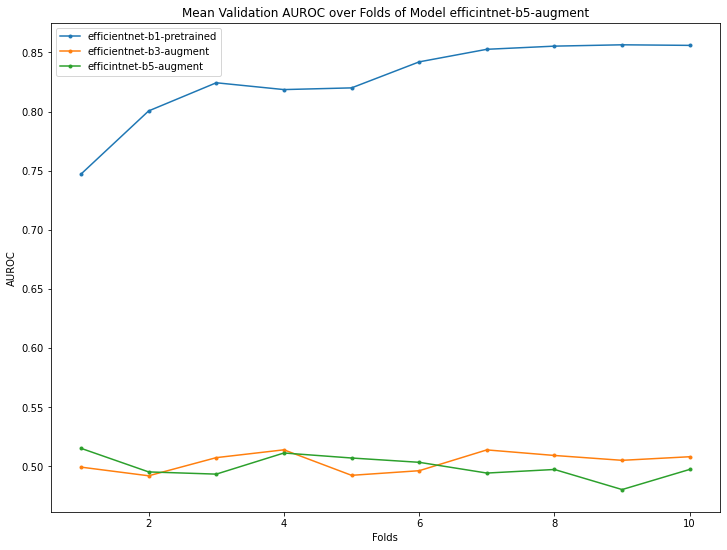

In [40]:
plt.figure(figsize=(12,9))
for j in range(3):
    plt.plot(range(1, epochs+1), aurocs[j][1], label=names[j], marker=".")
plt.xlabel("Folds")
plt.ylabel("AUROC")
plt.legend()
plt.title(f"Mean Validation AUROC over Folds of Model {names[j]}")



In [48]:
print(f"Batch Size {Batch_Size}")
for i in range(len(aurocs)):
    print(f"\nModel {names[i]}")
    for j in range(5):
        print(f"Fold {j}, mean AUROC: {np.mean(aurocs[i][j])}, best AUROC: {np.max(aurocs[i][j])}")

Batch Size 8

Model efficientnet-b1-pretrained
Fold 0, mean AUROC: 0.5035190277777778, best AUROC: 0.5207276234567901
Fold 1, mean AUROC: 0.8272906404320988, best AUROC: 0.8564697530864198
Fold 2, mean AUROC: 0.837202650462963, best AUROC: 0.8627466049382716
Fold 3, mean AUROC: 0.832273013117284, best AUROC: 0.8654195216049383
Fold 4, mean AUROC: 0.8288863541666667, best AUROC: 0.8610581790123457

Model efficientnet-b3-augment
Fold 0, mean AUROC: 0.4974826851851851, best AUROC: 0.5096740740740741
Fold 1, mean AUROC: 0.5034268595679011, best AUROC: 0.5136393518518518
Fold 2, mean AUROC: 0.8305720563271605, best AUROC: 0.8647927469135801
Fold 3, mean AUROC: 0.5003324189814815, best AUROC: 0.5058332561728396
Fold 4, mean AUROC: 0.8205029166666666, best AUROC: 0.8530609182098765

Model efficintnet-b5-augment
Fold 0, mean AUROC: 0.49952995756172835, best AUROC: 0.5078660108024691
Fold 1, mean AUROC: 0.49916410879629636, best AUROC: 0.5149051697530864
Fold 2, mean AUROC: 0.49711257330246916,